In [ ]:
#pip install rank_bm25

In [ ]:
#pip install pyaspeller

In [ ]:
#pip install transliterate

In [ ]:
#pip install pymorphy2

In [1]:
import pandas as pd
import os
import numpy as np
import json
from sklearn.metrics import ndcg_score
import pyarrow.parquet as pq
import time
import os
import pickle
import polars as pl
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import hstack
import cudf
#from cuml.feature_extraction.text import TfidfVectorizer,CountVectorizer
from cuml.neighbors import NearestNeighbors
from catboost import CatBoostRanker, Pool
from functools import partial
import re
#from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from pyaspeller import YandexSpeller
from sklearn.decomposition import TruncatedSVD, PCA
from transliterate import translit
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score, top_k_accuracy_score

In [2]:
automarkup = pd.read_parquet('input_/automarkup.parquet',engine = 'fastparquet')
sample_submission = pd.read_csv('input_/sample_submission.csv')
manualmarkup = pd.read_csv('input_/manualmarkup.csv')
videos = pd.read_parquet('input_/videos.parquet', engine = 'fastparquet')

In [3]:
def calculate_metric(test_auto, submission, DEBUG = False):
    
    test_auto['target'] = [1] * test_auto.shape[0]
    test_auto = test_auto[['query', 'video_id', 'target']].drop_duplicates()

    with_target = submission.merge(
        test_auto,
        how = 'left',
        on = ['query', 'video_id'],
    )

    with_target['target'] = with_target['target'].fillna(0.0)

    y_true = with_target.groupby('query').agg(list)['target'].values.tolist()
    
    y_score = np.array([[5.0, 4.0, 3.0, 2.0, 1.0] for _ in range(len(y_true))])
   
    score = 0
    for i in range(len(y_true)):
        try:
            true = np.array(y_true[i]).astype(int)[:5]
            val = y_score[i].astype(int)[:5]            
            score += ndcg_score([true], [val])
        except:
            if DEBUG:
                print(true)
                print(val)
            
    score /= len(y_true)     
    
    return score

In [4]:
class RutubeSearchModel:
    def __init__(self, top_k: int) -> None:
        self._vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 1),max_df=0.9)
       # self._vec = CountVectorizer(analyzer= 'char_wb', ngram_range=(1, 1),max_df=0.9)
        self._knn = NearestNeighbors(metric = 'cosine')
        self.speller = YandexSpeller()
        self._top_k = top_k
        
    def fit(self, videos: pd.DataFrame):
        videos['search_tag'] = videos['video_title'].astype(str) #+ " " + videos['channel_title'].astype(str) + " " + videos['v_category'].astype(str)
        videos = self.text_preprocessing(videos)
        self._videos = videos[['video_id','video_title']]
       
        self._mx_videos = self._vec.fit_transform(videos['search_tag'])
        self._knn.fit(self._mx_videos)
        return self

    def predict_front(self, test):
        query = test
        test = self.normalize_string(test)
        test = self.speller.spelled(test)
       # pars = self.parse_russian_words(test)
       # if pars != test:
        #    test = pars
            
      #  if self.has_russian_words(test) == False:
           #  test = self.find_foreign_layout_characters(test) 
                
      #  test = self.speller.spelled(test)
        print(test)
        try:
                        
            mx_predict = self._vec.transform([test])
            distances, indices = self._knn.kneighbors(mx_predict, n_neighbors = self._top_k)
            search = self._videos.iloc[indices.flatten()]
            search['neighbors'] = distances.flatten()
            search['video_title'] = search['video_title'].str.lower()
            corpus = search['video_title'].values.tolist()
            tokenized_corpus = [doc.split(" ") for doc in corpus]
            bm25 = BM25Okapi(tokenized_corpus)
            text_speller = self.speller.spelled(test)
            tokenized_query = text_speller.lower().split(" ")
            search['bm25_score'] = bm25.get_scores(tokenized_query)
            
        except:
            search = pd.DataFrame(columns=['query', 'video_id','bm25_score'],index = range(self._top_k))
            search['query'] = query
            search['bm25_score'] = 0
            search['video_id'] = 'video_9572889'
            
        return search.sort_values(by='bm25_score', ascending = False).head(self._top_k)
    
    def predict_submission(self, test):
        
        sub = []
        for i in tqdm(range(len(test))):
            search = self.predict_front(test['query'].iloc[i])['video_id'].tolist()
            for j in search:
                sub.append([test['query'].iloc[i],j])
        return pd.DataFrame(sub, columns = ['query', 'video_id'])
    
    def text_preprocessing(self,videos):
        videos['search_tag'] = videos['search_tag'].str.lower()
        return videos
    
    def parse_russian_words(self, text):
        cyrillic = translit(text, 'ru')
        if cyrillic != text:
            russian_text = cyrillic
        else: 
            russian_text = text
        # russian_text = translit(english_text, 'ru')
        return russian_text
    
    def normalize_string(self, s):
      
        s = s.lower()
        s = re.sub(r'([\D]*)([0-9]+)', r' \1 \2 ', s)
        return s
    
    def find_foreign_layout_characters(self,text):
        foreign_layout_characters = {'q': 'й','w': 'ц','e': 'у','r': 'к', 't': 'е',
                                     'y': 'н','u': 'г','i': 'ш','o': 'щ', 'p': 'з',
                                     '[': 'х',']': 'ъ','a': 'ф','s': 'ы', 'd': 'в',
                                     'f': 'а','g': 'п','h': 'р','j': 'о','k': 'л',
                                     'l': 'д',';': 'ж',"'": 'э','z': 'я','x': 'ч', 
                                     'c': 'с','v': 'м','b': 'и','n': 'т','m': 'ь',
                                     ',': 'б','.': 'ю','/': '.' }

        foreign_layout_chars = []
        for char in text:
            if char == ' ':
                foreign_layout_chars.append(char)
            else:
                if char.lower() in foreign_layout_characters.keys():
                    foreign_layout_chars.append(foreign_layout_characters[char.lower()])

        return ''.join(map(str, foreign_layout_chars))
    
    def has_russian_words(self, text):
        russian_words_regex = re.compile('[а-яА-ЯёЁ]')
        return bool(russian_words_regex.search(text))   

In [5]:
model_search = RutubeSearchModel(top_k=20)

In [6]:
%%time
model_search.fit(videos)

CPU times: user 2min 41s, sys: 38.8 s, total: 3min 20s
Wall time: 5min 10s


In [74]:
%%time
model_search.predict_front('моя фамилия шилов').head(5)

моя фамилия шилов
CPU times: user 568 ms, sys: 14.9 ms, total: 583 ms
Wall time: 1.09 s


,video_id,video_title,neighbors,bm25_score
10901411,video_11799605,моя фамилия шилов,0.000000,1.677363
24535415,video_14203175,фамилия моя,0.282140,1.448320
1680037,video_34015596,моя фамилия шилов (2013),0.073411,1.443675
3994165,video_11127290,моя фамилия шилов (2013),0.073411,1.443675
13399936,video_16958870,моя фамилия шилов (2013) фильм,0.126941,1.267138


In [75]:
%%time
model_search.predict_front('vtynjdcrbt djqys 7 ctpjy').head(5)

  ментовские войны  7  сезон
CPU times: user 596 ms, sys: 263 µs, total: 596 ms
Wall time: 973 ms


,video_id,video_title,neighbors,bm25_score
10403934,video_4675942,ментовские будни,0.312333,13.333003
16558182,video_9572889,ментовские войны 7 сезон 20 серия,0.094830,4.149627
5875851,video_26363202,ментовские войны 1 сезон 9 серия,0.049199,1.750754
8307399,video_25725604,ментовские войны 1 сезон 2 серия,0.049199,1.750754
15966583,video_26867692,ментовские войны 3 сезон 5 серия,0.049199,1.750754


In [76]:
%%time
model_search.predict_front('санкт петербург').head(5)

санкт петербург
CPU times: user 579 ms, sys: 203 µs, total: 579 ms
Wall time: 919 ms


,video_id,video_title,neighbors,bm25_score
1436330,video_6947148,санкт петербург,0.0,2.799022
33667325,video_28183502,санкт петербург 🏙,0.0,2.219914
3169412,video_14933229,санкт - петербург,0.0,2.219914
33806606,video_29434578,г.санкт -петербург.,0.0,0.000000
2820976,video_28670544,санкт-петербург,0.0,0.000000


In [ ]:
#Проверим BM25 на ручной разметке "exact"
val_df = manualmarkup[manualmarkup['sentiment']=="exact"][['query','video_id']]
val_df = val_df.reset_index(drop=True)

In [ ]:
sub_df = model_search.predict_submission(val_df)

In [ ]:
calculate_metric(val_df, sub_df)

## Получение кандидатов и обучение ранкера

In [10]:
automarkup = automarkup[~automarkup['query'].isna()]

In [11]:
n = 1400
top_n = automarkup['query'].value_counts()[:int(2*n)].index.to_list()
other = np.array(automarkup['query'].value_counts()[int(2*n):].index.to_list())
random_n = np.random.choice(other, size=n, replace=False).tolist()
queries = top_n + random_n
query2ind = {q: i for i, q in enumerate(queries)}

In [12]:
len(queries)

4200

In [13]:
# Получение кандидатов после ранжирования BM25
sub = []
for  q in tqdm((queries)):
    search = model_search.predict_front(q)['video_id'].tolist()
    for j in search:
        sub.append([q,j])
generated_cand = pd.DataFrame(sub, columns = ['query', 'video_id'])

  0%|                                                  | 0/4200 [00:00<?, ?it/s]

битва сильнейших


  0%|                                        | 1/4200 [00:00<1:03:12,  1.11it/s]

мужское женское


  0%|                                        | 2/4200 [00:01<1:04:36,  1.08it/s]

выжить в дубае


  0%|                                        | 3/4200 [00:02<1:04:28,  1.08it/s]

битва экстрасенсов


  0%|                                        | 4/4200 [00:03<1:04:32,  1.08it/s]

выжить в дубае


  0%|                                        | 5/4200 [00:05<1:16:49,  1.10s/it]

ну вот как с такими можно играть


  0%|                                        | 6/4200 [00:06<1:21:42,  1.17s/it]

врываемся тараном в возрождении


  0%|                                        | 7/4200 [00:07<1:29:10,  1.28s/it]

звезды в африке


  0%|                                        | 8/4200 [00:08<1:23:53,  1.20s/it]

битва сильнейших


  0%|                                        | 9/4200 [00:09<1:17:55,  1.12s/it]

новые звезды в африке


  0%|                                       | 10/4200 [00:10<1:14:22,  1.07s/it]

экстрасенсы битва сильнейших


  0%|                                       | 11/4200 [00:13<1:58:07,  1.69s/it]

битва сильнейших экстрасенсов


  0%|                                       | 12/4200 [00:14<1:43:38,  1.48s/it]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  35 


  0%|                                       | 13/4200 [00:15<1:31:50,  1.32s/it]

мужское женское


  0%|▏                                      | 14/4200 [00:16<1:23:48,  1.20s/it]

сердце клавы


  0%|▏                                      | 15/4200 [00:20<2:25:19,  2.08s/it]

  выдержка и тонкий расчёт успех игры на fv215b  183 


  0%|▏                                      | 16/4200 [00:22<2:17:35,  1.97s/it]

выжить в дубае


  0%|▏                                      | 17/4200 [00:23<1:55:52,  1.66s/it]

экстрасенсы. битва сильнейших


  0%|▏                                      | 18/4200 [00:24<1:40:58,  1.45s/it]

звезды в африке


  0%|▏                                      | 19/4200 [00:25<1:29:49,  1.29s/it]

мужское женское 


  0%|▏                                      | 20/4200 [00:26<1:22:39,  1.19s/it]

экстрасенсы


  0%|▏                                      | 21/4200 [00:27<1:19:33,  1.14s/it]

сердце клавы


  1%|▏                                      | 22/4200 [00:28<1:14:26,  1.07s/it]

барби


  1%|▏                                      | 23/4200 [00:29<1:11:25,  1.03s/it]

битва сильнейших 


  1%|▏                                      | 24/4200 [00:30<1:08:55,  1.01it/s]

однажды в россии


  1%|▏                                      | 25/4200 [00:31<1:07:42,  1.03it/s]

выжить в дубае 


  1%|▏                                      | 26/4200 [00:32<1:08:26,  1.02it/s]

наше дело


  1%|▎                                      | 27/4200 [00:33<1:08:28,  1.02it/s]

битва экстрасенсов 


  1%|▎                                      | 28/4200 [00:34<1:07:27,  1.03it/s]

матч тв


  1%|▎                                      | 29/4200 [00:34<1:06:59,  1.04it/s]

новые звёзды в африке


  1%|▎                                      | 30/4200 [00:35<1:05:53,  1.05it/s]

физические упражнения: какая от них польза?


  1%|▎                                      | 31/4200 [00:36<1:05:26,  1.06it/s]

наше дело


  1%|▎                                      | 32/4200 [00:37<1:05:38,  1.06it/s]

анна маслова в чем польза ранних подъемов?


  1%|▎                                      | 33/4200 [00:38<1:06:11,  1.05it/s]

лига городов


  1%|▎                                      | 34/4200 [00:39<1:05:40,  1.06it/s]

анна маслова домашний оберег!


  1%|▎                                      | 35/4200 [00:40<1:06:01,  1.05it/s]

челлендж papasha_live


  1%|▎                                      | 36/4200 [00:41<1:05:50,  1.05it/s]

 звезды в африке  3  сезон


  1%|▎                                      | 37/4200 [00:43<1:23:23,  1.20s/it]

как сделать много комментариев на ozon. отзывы ozon.


  1%|▎                                      | 38/4200 [00:44<1:22:16,  1.19s/it]

экстра такси


  1%|▎                                      | 39/4200 [00:45<1:16:26,  1.10s/it]

 скетч-шоу vellissimoo « 14  диски»


  1%|▎                                      | 40/4200 [00:46<1:12:43,  1.05s/it]

экстра такси


  1%|▍                                      | 41/4200 [00:47<1:10:10,  1.01s/it]

«поликлиника» заходите в мой дом!


  1%|▍                                      | 42/4200 [00:48<1:09:54,  1.01s/it]

овр шоу


  1%|▍                                      | 43/4200 [00:49<1:08:17,  1.01it/s]

debauchery food жареная кефаль


  1%|▍                                      | 44/4200 [00:52<1:55:45,  1.67s/it]

 битва экстрасенсов  23  сезон


  1%|▍                                      | 45/4200 [00:53<1:41:58,  1.47s/it]

мужское и женское


  1%|▍                                      | 46/4200 [00:54<1:30:24,  1.31s/it]

  как стать блоггером  2023 


  1%|▍                                      | 47/4200 [00:55<1:23:41,  1.21s/it]

  4  свадьбы


  1%|▍                                      | 48/4200 [00:56<1:18:39,  1.14s/it]

депрессия миф или реальность ?


  1%|▍                                      | 49/4200 [00:57<1:14:36,  1.08s/it]

анна маслова дневник благодарности: как меняет жизнь?


  1%|▍                                      | 50/4200 [00:58<1:12:59,  1.06s/it]

битва сильнейших 


  1%|▍                                      | 51/4200 [00:59<1:12:50,  1.05s/it]

мужское и женское!


  1%|▍                                      | 52/4200 [01:00<1:10:29,  1.02s/it]

барби


  1%|▍                                      | 53/4200 [01:01<1:08:00,  1.02it/s]

чертов угол в старой казани


  1%|▌                                      | 54/4200 [01:02<1:07:04,  1.03it/s]

главные вопросы сексологу / оргазмы/ нормы /полигамия


  1%|▌                                      | 55/4200 [01:03<1:05:52,  1.05it/s]

камеди клаб


  1%|▌                                      | 56/4200 [01:04<1:05:58,  1.05it/s]

вечерний макияж..сегодня ты будешь сиять


  1%|▌                                      | 57/4200 [01:04<1:05:29,  1.05it/s]

катание на слоне в таиланде | слон | таиланд | пхукет


  1%|▌                                      | 58/4200 [01:05<1:06:27,  1.04it/s]

поликлиника возле дома своего


  1%|▌                                      | 59/4200 [01:06<1:05:59,  1.05it/s]

выжить в дубаи


  1%|▌                                      | 60/4200 [01:07<1:05:26,  1.05it/s]

скетч-шоу vellissimoo «юбилей гарри»


  1%|▌                                      | 61/4200 [01:09<1:29:42,  1.30s/it]

«поликлиника» че там стало покажи ?


  1%|▌                                      | 62/4200 [01:10<1:21:59,  1.19s/it]

кинут не кинут ?? путь к миллиону


  2%|▌                                      | 63/4200 [01:11<1:17:52,  1.13s/it]

скетч-шоу vellissimoo «помни корни»


  2%|▌                                      | 64/4200 [01:13<1:30:17,  1.31s/it]

поликлиника ну погнали уже


  2%|▌                                      | 65/4200 [01:14<1:23:11,  1.21s/it]

остров джеймса бонда | тайланд | пхукет | пхи-пхи


  2%|▌                                      | 66/4200 [01:15<1:17:41,  1.13s/it]

анна маслова ходьба босиком: чем полезна?


  2%|▌                                      | 67/4200 [01:16<1:15:54,  1.10s/it]

как сделать авто диффузор? аромадиффузор.


  2%|▋                                      | 68/4200 [01:17<1:13:12,  1.06s/it]

экстрасенсы ведут расследование


  2%|▋                                      | 69/4200 [01:18<1:12:01,  1.05s/it]

следствие вели


  2%|▋                                      | 70/4200 [01:19<1:11:49,  1.04s/it]

«маска»


  2%|▋                                      | 71/4200 [01:20<1:09:49,  1.01s/it]

рассказы о суконке


  2%|▋                                      | 72/4200 [01:21<1:08:12,  1.01it/s]

лига городов


  2%|▋                                      | 73/4200 [01:22<1:08:18,  1.01it/s]

битва


  2%|▋                                      | 74/4200 [01:24<1:28:45,  1.29s/it]

куда исчезла армянская слобода в казани?


  2%|▋                                      | 75/4200 [01:25<1:21:10,  1.18s/it]

вегетарианская кухня в краснодаре


  2%|▋                                      | 76/4200 [01:26<1:17:05,  1.12s/it]

debauchery food стейк модена


  2%|▋                                      | 77/4200 [01:27<1:14:05,  1.08s/it]

debauchery food стейк раунд


  2%|▋                                      | 78/4200 [01:28<1:13:02,  1.06s/it]

какие нюансы в продаже на ozon?


  2%|▋                                      | 79/4200 [01:29<1:10:49,  1.03s/it]

пп пицца на сковороде


  2%|▋                                      | 80/4200 [01:30<1:09:32,  1.01s/it]

битва экстрасенсов 


  2%|▊                                      | 81/4200 [01:31<1:08:33,  1.00it/s]

 fitness_online пресс за  5  минут


  2%|▊                                      | 82/4200 [01:32<1:07:54,  1.01it/s]

анна маслова про гордыню


  2%|▊                                      | 83/4200 [01:33<1:06:56,  1.02it/s]

лебедевский мост в казани


  2%|▊                                      | 84/4200 [01:34<1:05:51,  1.04it/s]

улица щапова


  2%|▊                                      | 85/4200 [01:35<1:06:37,  1.03it/s]

казань. соболевские номера.


  2%|▊                                      | 86/4200 [01:37<1:27:29,  1.28s/it]

обзор на мыльные пузыри


  2%|▊                                      | 87/4200 [01:38<1:21:25,  1.19s/it]

звезды в африке


  2%|▊                                      | 88/4200 [01:39<1:37:24,  1.42s/it]

нестандартная ориентация в ссср /бисексуалы /геи /кино /актеры


  2%|▊                                      | 89/4200 [01:40<1:27:05,  1.27s/it]

путь к книге рекордов гиннесса /история /человек / мотивация


  2%|▊                                      | 90/4200 [01:41<1:20:43,  1.18s/it]

анна маслова место силы


  2%|▊                                      | 91/4200 [01:42<1:15:18,  1.10s/it]

самое странное свидание


  2%|▊                                      | 92/4200 [01:43<1:12:54,  1.06s/it]

мужское женское 


  2%|▊                                      | 93/4200 [01:44<1:11:30,  1.04s/it]

выжить в дубаи


  2%|▉                                        | 95/4200 [01:46<57:21,  1.19it/s]

rusakk
днк


  2%|▉                                      | 96/4200 [01:48<1:29:16,  1.31s/it]

 тест на совместимость | broshki |  1  часть


  2%|▉                                      | 97/4200 [01:49<1:23:20,  1.22s/it]

битва шефов


  2%|▉                                      | 98/4200 [01:50<1:17:15,  1.13s/it]

 битва экстрасенсов  23   сезон  7   выпуск  22   октября  2022 


  2%|▉                                      | 99/4200 [01:52<1:25:20,  1.25s/it]

последний герой


  2%|▉                                     | 100/4200 [01:53<1:20:41,  1.18s/it]

секрет на миллион


  2%|▉                                     | 101/4200 [01:54<1:35:56,  1.40s/it]

знаменитая мем -сова суфия хайдаровна /я устала жить на улице / помогите


  2%|▉                                     | 102/4200 [01:56<1:27:55,  1.29s/it]

конфетка


  2%|▉                                     | 103/4200 [01:56<1:20:35,  1.18s/it]

про казань и казанцев храм сошествия святаго духа


  2%|▉                                     | 104/4200 [01:57<1:15:53,  1.11s/it]

  блоггер  2023  | актуальные социальные сети


  2%|▉                                     | 105/4200 [01:58<1:12:37,  1.06s/it]

 тест на совместимость | broshki | часть  2 


  3%|▉                                     | 106/4200 [01:59<1:14:18,  1.09s/it]

рис по-арабски в казане с курицей


  3%|▉                                     | 107/4200 [02:00<1:11:17,  1.05s/it]

пространство и окружение: что они нам дают?


  3%|▉                                     | 108/4200 [02:01<1:09:40,  1.02s/it]

экстрасенсы 


  3%|▉                                     | 109/4200 [02:02<1:08:09,  1.00it/s]

 фруктовый салат осенью за  15  минут


  3%|▉                                     | 110/4200 [02:03<1:06:50,  1.02it/s]

выжить


  3%|█                                     | 111/4200 [02:04<1:05:56,  1.03it/s]

 papasha_live создаем  3 d игрушку из слайма


  3%|█                                     | 112/4200 [02:05<1:05:48,  1.04it/s]

лодочки с курицей и овощами в духовке


  3%|█                                     | 113/4200 [02:06<1:04:35,  1.05it/s]

debauchery food стейк стриплойн на гриле


  3%|█                                     | 114/4200 [02:07<1:06:43,  1.02it/s]

влюбись


  3%|█                                     | 115/4200 [02:08<1:06:10,  1.03it/s]

обзор лиги чемпионов


  3%|█                                     | 116/4200 [02:09<1:07:40,  1.01it/s]

свежие комедии | подборка | sudarikova kate


  3%|█                                     | 117/4200 [02:10<1:07:51,  1.00it/s]

mamasha.live виды контента в социальных сетях


  3%|█                                     | 118/4200 [02:11<1:06:15,  1.03it/s]

debauchery food салат из огурцов по немецки


  3%|█                                     | 119/4200 [02:12<1:07:11,  1.01it/s]

обзоры матчей


  3%|█                                     | 120/4200 [02:13<1:05:41,  1.04it/s]

звезды в африке 


  3%|█                                     | 121/4200 [02:14<1:05:18,  1.04it/s]

куриные крылышки с соусом терияки.


  3%|█                                     | 122/4200 [02:15<1:05:02,  1.05it/s]

экстрасенсы битва сильнейших


  3%|█                                     | 123/4200 [02:16<1:12:01,  1.06s/it]

днк


  3%|█                                     | 124/4200 [02:18<1:28:01,  1.30s/it]

экстра такси


  3%|█▏                                    | 125/4200 [02:19<1:20:57,  1.19s/it]

лисички с картошкой в казане


  3%|█▏                                    | 126/4200 [02:20<1:15:57,  1.12s/it]

стейк модена


  3%|█▏                                    | 127/4200 [02:21<1:12:15,  1.06s/it]

куриные крылышки в грушевом соусе.


  3%|█▏                                    | 128/4200 [02:22<1:09:40,  1.03s/it]

битва


  3%|█▏                                    | 129/4200 [02:23<1:07:14,  1.01it/s]

большой будда на пхукете | биг будда | что посмотреть в таиланде? | пхукет | экскурсии в таиланде


  3%|█▏                                    | 130/4200 [02:24<1:07:20,  1.01it/s]

шоу воли


  3%|█▏                                    | 131/4200 [02:25<1:07:17,  1.01it/s]

 битва экстрасенсов  23   сезон  13   выпуск  3   декабря  2022 


  3%|█▏                                    | 132/4200 [02:26<1:07:50,  1.00s/it]

конфетка


  3%|█▏                                    | 133/4200 [02:27<1:06:54,  1.01it/s]

 напряженные триллеры  2023  | подборка | sudarikova kate


  3%|█▏                                    | 134/4200 [02:28<1:05:57,  1.03it/s]

мышь для экономных геймеров


  3%|█▏                                    | 135/4200 [02:29<1:05:29,  1.03it/s]

debauchery food рис по-индийски


  3%|█▏                                    | 136/4200 [02:30<1:05:25,  1.04it/s]

стейк раунд


  3%|█▏                                    | 137/4200 [02:31<1:05:29,  1.03it/s]

 таврида - столица творчества |  2  часть


  3%|█▏                                    | 138/4200 [02:31<1:05:09,  1.04it/s]

фильмы про спорт | подборка | sudarikova kate


  3%|█▎                                    | 139/4200 [02:32<1:04:54,  1.04it/s]

как оформить состав на ozon?


  3%|█▎                                    | 140/4200 [02:34<1:10:07,  1.04s/it]

«поликлиника» завтра зайдёшь


  3%|█▎                                    | 141/4200 [02:35<1:08:27,  1.01s/it]

звёзды в африке


  3%|█▎                                    | 142/4200 [02:36<1:07:18,  1.00it/s]

скетч-шоу vellissimoo «найди себя»


  3%|█▎                                    | 143/4200 [02:36<1:06:04,  1.02it/s]

на ножах


  3%|█▎                                    | 144/4200 [02:37<1:05:51,  1.03it/s]

скетч-шоу vellissimoo «тайная комната»


  3%|█▎                                    | 145/4200 [02:38<1:06:03,  1.02it/s]

дайвинг в клубе sharm wave diving


  3%|█▎                                    | 146/4200 [02:39<1:05:20,  1.03it/s]

  куриные крылышки в казани за  30  минут


  4%|█▎                                    | 147/4200 [02:40<1:05:21,  1.03it/s]

куда ты лезешь на рожон


  4%|█▎                                    | 148/4200 [02:41<1:05:50,  1.03it/s]

«поликлиника» какой ты непонятливый


  4%|█▎                                    | 149/4200 [02:42<1:05:23,  1.03it/s]

 скетч-шоу vellissimoo «послушай  4  : 20 »


  4%|█▎                                    | 150/4200 [02:43<1:05:45,  1.03it/s]

любители потусить на заднем дворе / анальный кекс


  4%|█▎                                    | 151/4200 [02:44<1:05:41,  1.03it/s]

muragi vlog | генуэзская крепость


  4%|█▍                                    | 152/4200 [02:46<1:22:48,  1.23s/it]

четыре жены


  4%|█▍                                    | 153/4200 [02:47<1:17:08,  1.14s/it]

 затаранил советский танкоуничтожитель су- 100 


  4%|█▍                                    | 154/4200 [02:48<1:17:07,  1.14s/it]

что делать


  4%|█▍                                    | 155/4200 [02:50<1:37:11,  1.44s/it]

выжить в дубае 


  4%|█▍                                    | 156/4200 [02:51<1:27:10,  1.29s/it]

debauchery food индейка по-тайски


  4%|█▍                                    | 157/4200 [02:52<1:21:17,  1.21s/it]

модная команда..модная я. leylazakirovna


  4%|█▍                                    | 158/4200 [02:53<1:17:43,  1.15s/it]

debauchery food лисички с картошкой в казане


  4%|█▍                                    | 159/4200 [02:54<1:13:31,  1.09s/it]

новые звезды в африке


  4%|█▍                                    | 160/4200 [02:55<1:10:58,  1.05s/it]

ярче звезд


  4%|█▍                                    | 161/4200 [02:57<1:32:32,  1.37s/it]

эскалоп свиной и стейк халяль на мангале


  4%|█▍                                    | 162/4200 [02:58<1:26:32,  1.29s/it]

измеряем плотность воды!


  4%|█▍                                    | 163/4200 [03:01<2:01:10,  1.80s/it]

энергия лета! анна маслова


  4%|█▍                                    | 164/4200 [03:04<2:07:21,  1.89s/it]

храм-памятник на реке казанка


  4%|█▍                                    | 165/4200 [03:04<1:48:30,  1.61s/it]

сила украшений!


  4%|█▌                                    | 166/4200 [03:05<1:34:18,  1.40s/it]

рис жасмин с осьминогом


  4%|█▌                                    | 167/4200 [03:06<1:24:57,  1.26s/it]

наука с рутубиком съедобный ежик


  4%|█▌                                    | 168/4200 [03:07<1:19:38,  1.19s/it]

ты супер


  4%|█▌                                    | 169/4200 [03:08<1:14:45,  1.11s/it]

десерт банановый с матчей


  4%|█▌                                    | 170/4200 [03:09<1:11:07,  1.06s/it]

мужское и женское


  4%|█▌                                    | 171/4200 [03:10<1:08:51,  1.03s/it]

маска


  4%|█▌                                    | 172/4200 [03:11<1:07:17,  1.00s/it]

экстра такси


  4%|█▌                                    | 173/4200 [03:12<1:05:20,  1.03it/s]

веселые пузырьки!


  4%|█▌                                    | 174/4200 [03:14<1:24:03,  1.25s/it]

вызов


  4%|█▌                                    | 175/4200 [03:15<1:17:47,  1.16s/it]

наука с рутубиком веселые пузырьки


  4%|█▌                                    | 176/4200 [03:16<1:15:12,  1.12s/it]

однажды в россии


  4%|█▌                                    | 177/4200 [03:17<1:12:10,  1.08s/it]

влюбись если сможешь


  4%|█▌                                    | 178/4200 [03:18<1:09:34,  1.04s/it]

поднимаю fps doom eternal


  4%|█▌                                    | 179/4200 [03:19<1:08:04,  1.02s/it]

новая битва экстрасенсов


  4%|█▋                                    | 180/4200 [03:20<1:06:31,  1.01it/s]

следствие вели


  4%|█▋                                    | 181/4200 [03:21<1:05:30,  1.02it/s]

тнт


  4%|█▋                                    | 182/4200 [03:22<1:04:41,  1.04it/s]

звёзды в африке 


  4%|█▋                                    | 183/4200 [03:23<1:03:41,  1.05it/s]

выжить в дубае 


  4%|█▋                                    | 184/4200 [03:23<1:03:02,  1.06it/s]

упругие ягодицы/силовая тренировка на низ тела


  4%|█▋                                    | 185/4200 [03:24<1:03:36,  1.05it/s]

незабытые. фильм о фильме эпизода преступление в волгограде


  4%|█▋                                    | 186/4200 [03:25<1:04:25,  1.04it/s]

 мужское женское  2023 


  4%|█▋                                    | 187/4200 [03:27<1:12:26,  1.08s/it]

богиня


  4%|█▋                                    | 188/4200 [03:28<1:09:39,  1.04s/it]

богиня шопинга


  4%|█▋                                    | 189/4200 [03:29<1:07:50,  1.01s/it]

мини-обзор фильма «круче некуда» | sudarikova kate


  5%|█▋                                    | 190/4200 [03:30<1:07:40,  1.01s/it]

фестиваль блоггеры волгоград


  5%|█▋                                    | 191/4200 [03:31<1:07:01,  1.00s/it]

самые необычные музыкальные инструменты || органист


  5%|█▋                                    | 192/4200 [03:32<1:10:41,  1.06s/it]

незабытые |закрытый показ


  5%|█▋                                    | 193/4200 [03:33<1:07:53,  1.02s/it]

матч


  5%|█▊                                    | 194/4200 [03:34<1:14:40,  1.12s/it]

звёзды в африке


  5%|█▊                                    | 195/4200 [03:35<1:13:39,  1.10s/it]

выжить


  5%|█▊                                    | 196/4200 [03:36<1:10:12,  1.05s/it]

за гранью


  5%|█▊                                    | 197/4200 [03:37<1:09:56,  1.05s/it]

 звезды в африке  2  сезон


  5%|█▊                                    | 198/4200 [03:38<1:07:24,  1.01s/it]

шоу воли 


  5%|█▊                                    | 199/4200 [03:39<1:05:49,  1.01it/s]

плагиат или совпадение || niletta 


  5%|█▊                                    | 200/4200 [03:40<1:06:25,  1.00it/s]

битва сильнейших экстрасенсы


  5%|█▊                                    | 201/4200 [03:41<1:04:46,  1.03it/s]

обзор еды в додо пицца.


  5%|█▊                                    | 202/4200 [03:42<1:06:53,  1.00s/it]

наследники и самозванцы


  5%|█▊                                    | 203/4200 [03:43<1:05:35,  1.02it/s]

перелёт в таиланд с пересадкой в омане | оман | аэропорт в омане |пхукет


  5%|█▊                                    | 204/4200 [03:44<1:05:37,  1.01it/s]

мини-обзор фильма «оппенгеймер» | sudarikova kate


  5%|█▊                                    | 205/4200 [03:45<1:05:51,  1.01it/s]

сердце клавы 


  5%|█▊                                    | 206/4200 [03:46<1:05:03,  1.02it/s]

битва экстрасенсов битва сильнейших


  5%|█▊                                    | 207/4200 [03:47<1:06:24,  1.00it/s]

дом купца аполлонова в орле. гастроном колониальных товаров


  5%|█▉                                    | 208/4200 [03:48<1:05:46,  1.01it/s]

давай пока


  5%|█▉                                    | 209/4200 [03:49<1:05:24,  1.02it/s]

год в браке. неужели все?


  5%|█▉                                    | 210/4200 [03:50<1:05:24,  1.02it/s]

 скетч-шоу vellissimoo « 5  минут»


  5%|█▉                                    | 211/4200 [03:51<1:04:27,  1.03it/s]

богиня


  5%|█▉                                    | 212/4200 [03:52<1:03:41,  1.04it/s]

куда я пропал???! наука с рутубиком


  5%|█▉                                    | 213/4200 [03:53<1:04:08,  1.04it/s]

dadi drift


  5%|█▉                                    | 214/4200 [03:54<1:03:01,  1.05it/s]

обзор матчей


  5%|█▉                                    | 215/4200 [03:55<1:02:57,  1.05it/s]

индейка по-тайски


  5%|█▉                                    | 216/4200 [03:56<1:03:17,  1.05it/s]

dadi drift


  5%|█▉                                    | 217/4200 [03:56<1:02:46,  1.06it/s]

незабытые |закрытый показ mamasha.live


  5%|█▉                                    | 218/4200 [03:57<1:04:03,  1.04it/s]

фестиваль блоггеры волгоград mamasha.live


  5%|█▉                                    | 219/4200 [03:59<1:06:10,  1.00it/s]

рис по-индийски


  5%|█▉                                    | 220/4200 [04:00<1:05:49,  1.01it/s]

лед - идеальный киберспортивно-зожный продукт


  5%|█▉                                    | 221/4200 [04:00<1:04:51,  1.02it/s]

 мини-обзор фильма «миссия невыполнима  7 » | sudarikova kate


  5%|██                                    | 222/4200 [04:01<1:04:07,  1.03it/s]

незабытые. фильм о фильме эпизода преступление в волгограде.


  5%|██                                    | 223/4200 [04:03<1:09:09,  1.04s/it]

любители потусить на заднем дворе / анальный кекс /


  5%|██                                    | 224/4200 [04:04<1:07:04,  1.01s/it]

что пить пенсионеру если он решил поиграть в видеоигру


  5%|██                                    | 225/4200 [04:05<1:07:24,  1.02s/it]

макияж для мам от дочек leylazakirovna


  5%|██                                    | 226/4200 [04:06<1:08:51,  1.04s/it]

 экстрасенсы битва сильнейших  19   сезон  12  серия


  5%|██                                    | 227/4200 [04:07<1:07:04,  1.01s/it]

овр шоу


  5%|██                                    | 228/4200 [04:08<1:07:04,  1.01s/it]

 не смотри если моложе  12 .


  5%|██                                    | 229/4200 [04:09<1:06:04,  1.00it/s]

test гимн рф


  5%|██                                    | 230/4200 [04:10<1:05:04,  1.02it/s]

куриные крылышки в грушевом соусе


  6%|██                                    | 231/4200 [04:11<1:04:19,  1.03it/s]

 мужское / женское. выпуск от  16  . 01  . 2023  (последний выпуск сегодня)


  6%|██                                    | 232/4200 [04:11<1:04:24,  1.03it/s]

московская группа musicpro_ласточка_рэп_хип-хоп


  6%|██                                    | 233/4200 [04:12<1:04:05,  1.03it/s]

куриные крылышки с соусом терияки


  6%|██                                    | 234/4200 [04:13<1:03:53,  1.03it/s]

backstage со съемок


  6%|██▏                                   | 235/4200 [04:14<1:03:01,  1.05it/s]

наука с рутубиком магнитное притяжение


  6%|██▏                                   | 236/4200 [04:15<1:04:34,  1.02it/s]

на ножах


  6%|██▏                                   | 237/4200 [04:18<1:33:00,  1.41s/it]

анна маслова сила веры


  6%|██▏                                   | 238/4200 [04:19<1:23:55,  1.27s/it]

экстрасенсы 


  6%|██▏                                   | 239/4200 [04:20<1:17:22,  1.17s/it]

маска


  6%|██▏                                   | 240/4200 [04:21<1:14:13,  1.12s/it]

оригинал vs обновление || slava marlow


  6%|██▏                                   | 241/4200 [04:22<1:10:58,  1.08s/it]

 новые звезды в африке  2  сезон


  6%|██▏                                   | 242/4200 [04:23<1:08:47,  1.04s/it]

мужское


  6%|██▏                                   | 243/4200 [04:24<1:07:17,  1.02s/it]

слабый мужчина и сильная женщина: отношения


  6%|██▏                                   | 244/4200 [04:25<1:05:41,  1.00it/s]

импровизация


  6%|██▏                                   | 245/4200 [04:25<1:04:56,  1.01it/s]

наше дело 


  6%|██▏                                   | 246/4200 [04:26<1:04:13,  1.03it/s]

самые необычные музыкальные инструменты || терменвокс


  6%|██▏                                   | 247/4200 [04:27<1:05:19,  1.01it/s]

жизнь по вызову


  6%|██▏                                   | 248/4200 [04:28<1:05:46,  1.00it/s]

дайджест технологий - yandexgpt


  6%|██▎                                   | 249/4200 [04:29<1:05:35,  1.00it/s]

муз софт


  6%|██▎                                   | 250/4200 [04:30<1:05:30,  1.01it/s]

в чем польза ранних подъемов?


  6%|██▎                                   | 251/4200 [04:31<1:04:47,  1.02it/s]

оригинал vs обновление : самое большое простое число


  6%|██▎                                   | 252/4200 [04:33<1:20:09,  1.22s/it]

новые звезды в африке 


  6%|██▎                                   | 253/4200 [04:34<1:14:59,  1.14s/it]

сексолог - психолог регина спиридонова что делать


  6%|██▎                                   | 254/4200 [04:35<1:12:16,  1.10s/it]

экстра такси 


  6%|██▎                                   | 255/4200 [04:36<1:09:06,  1.05s/it]

женский стендап


  6%|██▎                                   | 256/4200 [04:37<1:06:57,  1.02s/it]

однажды в россии 


  6%|██▎                                   | 257/4200 [04:38<1:05:30,  1.00it/s]

мужское и женское 


  6%|██▎                                   | 258/4200 [04:39<1:04:45,  1.01it/s]

стендап


  6%|██▎                                   | 259/4200 [04:40<1:04:40,  1.02it/s]

звезды в африке 


  6%|██▎                                   | 260/4200 [04:41<1:03:41,  1.03it/s]

 русские драмы  2023  | подборка | sudarikova kate


  6%|██▎                                   | 261/4200 [04:43<1:24:42,  1.29s/it]

самая тяжелая арена в твердыне стражей на максимальной сложности doom eternal


  6%|██▎                                   | 262/4200 [04:44<1:18:06,  1.19s/it]

 битва экстрасенсов  2023  смотреть онлайн / новая битва экстрасенсов битва сильнейших


  6%|██▍                                   | 263/4200 [04:45<1:13:51,  1.13s/it]

выжить в дубай


  6%|██▍                                   | 264/4200 [04:46<1:11:49,  1.09s/it]

тренировка гори жир без доп оборудования/ кардио   сила


  6%|██▍                                   | 265/4200 [04:47<1:21:06,  1.24s/it]

камеди


  6%|██▍                                   | 266/4200 [04:48<1:14:57,  1.14s/it]

битва шефов


  6%|██▍                                   | 267/4200 [04:49<1:12:03,  1.10s/it]

скетч-шоу vellissimoo «сезон охоты»


  6%|██▍                                   | 268/4200 [04:50<1:09:15,  1.06s/it]

плагиат или совпадение the settlers


  6%|██▍                                   | 269/4200 [04:51<1:08:42,  1.05s/it]

рпл


  6%|██▍                                   | 270/4200 [04:52<1:06:16,  1.01s/it]

 битва экстрасенсов  4   выпуск  22  . 04  . 2023 


  6%|██▍                                   | 271/4200 [04:53<1:05:35,  1.00s/it]

анна маслова слова притягивающие изобилие!


  6%|██▍                                   | 272/4200 [04:54<1:07:10,  1.03s/it]

анна маслова пространство и окружение: что они нам дают?


  6%|██▍                                   | 273/4200 [04:55<1:07:01,  1.02s/it]

сломано абсолютно всё | redfall


  7%|██▍                                   | 274/4200 [04:56<1:05:07,  1.00it/s]

новые звёзды в африке


  7%|██▍                                   | 275/4200 [04:57<1:04:51,  1.01it/s]

свиной шашлык с луком и паприкой


  7%|██▍                                   | 276/4200 [04:58<1:03:51,  1.02it/s]

лига чемпионов


  7%|██▌                                   | 277/4200 [05:00<1:11:22,  1.09s/it]

шашлык из вырезки свиной


  7%|██▌                                   | 278/4200 [05:01<1:09:00,  1.06s/it]

молодой модный показ в волгограде


  7%|██▌                                   | 279/4200 [05:01<1:06:11,  1.01s/it]

фильмы про аферистов | подборка | sudarikova kate


  7%|██▌                                   | 280/4200 [05:02<1:05:01,  1.00it/s]

пирог из картофеля с сыром и ветчиной


  7%|██▌                                   | 281/4200 [05:04<1:13:06,  1.12s/it]

новые звёзды в африке 


  7%|██▌                                   | 282/4200 [05:06<1:38:34,  1.51s/it]

виброплиты мешают быть человеком


  7%|██▌                                   | 283/4200 [05:07<1:28:52,  1.36s/it]

 сочные губки за  5  мин. учимся красить


  7%|██▌                                   | 284/4200 [05:09<1:33:36,  1.43s/it]

спартак цска


  7%|██▌                                   | 285/4200 [05:10<1:23:57,  1.29s/it]

рисуй красиво!! учись дома самостоятельно


  7%|██▌                                   | 286/4200 [05:11<1:16:19,  1.17s/it]

мужское


  7%|██▌                                   | 287/4200 [05:12<1:11:36,  1.10s/it]

копилка свинка своими руками


  7%|██▌                                   | 288/4200 [05:13<1:09:16,  1.06s/it]

рис южная ночь с креветками


  7%|██▌                                   | 289/4200 [05:13<1:06:33,  1.02s/it]

салат три корочки


  7%|██▌                                   | 290/4200 [05:15<1:06:19,  1.02s/it]

сердце клавы


  7%|██▋                                   | 291/4200 [05:15<1:05:46,  1.01s/it]

 жизнь по вызову  2  серия


  7%|██▋                                   | 292/4200 [05:16<1:05:05,  1.00it/s]

дед тестирует киберспортивную еду


  7%|██▋                                   | 293/4200 [05:17<1:04:34,  1.01it/s]

плагиат или совпадение || goody


  7%|██▋                                   | 294/4200 [05:18<1:03:41,  1.02it/s]

 мини-обзор фильма «стражи галактики  3 » | sudarikova kate


  7%|██▋                                   | 295/4200 [05:19<1:03:56,  1.02it/s]

 как выглядеть стильно с алиэкспресс / тренды на лето  2023 


  7%|██▋                                   | 296/4200 [05:20<1:05:03,  1.00it/s]

 скетч-шоу vellissimoo « 33  апреля»


  7%|██▋                                   | 297/4200 [05:21<1:03:57,  1.02it/s]

битва 


  7%|██▋                                   | 298/4200 [05:22<1:03:25,  1.03it/s]

 битва экстрасенсов  22  сезон


  7%|██▋                                   | 299/4200 [05:23<1:02:39,  1.04it/s]

скетч-шоу vellissimoo «копчик в школе»


  7%|██▋                                   | 300/4200 [05:24<1:02:41,  1.04it/s]

черный список


  7%|██▋                                   | 301/4200 [05:25<1:02:17,  1.04it/s]

десерт банановый с матче


  7%|██▋                                   | 302/4200 [05:26<1:03:16,  1.03it/s]

полу полезное питание игрового пенсионера


  7%|██▋                                   | 303/4200 [05:27<1:07:05,  1.03s/it]

камеди клаб | премьера | новый сезон | полный выпуск


  7%|██▊                                   | 304/4200 [05:28<1:07:07,  1.03s/it]

битва 


  7%|██▊                                   | 305/4200 [05:29<1:04:56,  1.00s/it]

новые пацанки


  7%|██▊                                   | 306/4200 [05:30<1:03:17,  1.03it/s]

путь бойца


  7%|██▊                                   | 307/4200 [05:31<1:02:38,  1.04it/s]

  channel 29646416 


  7%|██▊                                   | 308/4200 [05:32<1:02:47,  1.03it/s]

выжить в дубае


  7%|██▊                                   | 309/4200 [05:33<1:01:32,  1.05it/s]

овр шоу


  7%|██▊                                   | 310/4200 [05:35<1:11:28,  1.10s/it]

papasha_live показ мод


  7%|██▊                                   | 311/4200 [05:35<1:08:57,  1.06s/it]

шашлыки из курицы и макарон в духовке.


  7%|██▊                                   | 312/4200 [05:38<1:35:26,  1.47s/it]

 звезды в африке  2   сезон  2  выпуск


  7%|██▊                                   | 313/4200 [05:39<1:26:07,  1.33s/it]

сердце клавы 


  7%|██▊                                   | 314/4200 [05:40<1:18:11,  1.21s/it]

 битва экстрасенсов  21  сезон


  8%|██▊                                   | 315/4200 [05:41<1:13:18,  1.13s/it]

 тренировка для беременных  2  -й - 3 -й триместр


  8%|██▊                                   | 316/4200 [05:42<1:10:16,  1.09s/it]

 как сохранить здоровье в  40 


  8%|██▊                                   | 317/4200 [05:43<1:09:20,  1.07s/it]

клава кока


  8%|██▉                                   | 318/4200 [05:44<1:06:17,  1.02s/it]

экстрасенсы битва сильнейших 


  8%|██▉                                   | 319/4200 [05:45<1:05:05,  1.01s/it]

майя бей | фильм «пляж» с леонардо дикаприо | бухта майя бей | таиланд


  8%|██▉                                   | 320/4200 [05:46<1:12:31,  1.12s/it]

салат из огурцов по немецки


  8%|██▉                                   | 321/4200 [05:47<1:14:04,  1.15s/it]

«поликлиника» даже не смей


  8%|██▉                                   | 322/4200 [05:48<1:10:17,  1.09s/it]

иванько


  8%|██▉                                   | 323/4200 [05:49<1:08:09,  1.05s/it]

 мужское женское  2022 


  8%|██▉                                   | 324/4200 [05:50<1:07:43,  1.05s/it]

поликлиника в этот раз прощаю!


  8%|██▉                                   | 325/4200 [05:51<1:06:19,  1.03s/it]

измеряем плотность воды! наука с рутубиком


  8%|██▉                                   | 326/4200 [05:52<1:04:26,  1.00it/s]

поликлиника в чем дело? дружище.


  8%|██▉                                   | 327/4200 [05:53<1:03:46,  1.01it/s]

  стрелки быстро и легко за  10  минут leylazakirovna


  8%|██▉                                   | 328/4200 [05:54<1:04:51,  1.01s/it]

ты супер


  8%|██▉                                   | 329/4200 [05:55<1:04:49,  1.00s/it]

поликлиника ну че там отец?


  8%|██▉                                   | 330/4200 [05:56<1:03:18,  1.02it/s]

выжить 


  8%|██▉                                   | 331/4200 [05:57<1:03:05,  1.02it/s]

битва сильнейших


  8%|███                                   | 332/4200 [05:58<1:02:10,  1.04it/s]

поликлиника что в тайной комнате?


  8%|███                                   | 333/4200 [05:59<1:04:33,  1.00s/it]

 новые мультфильмы  2023  | подборка | sudarikova kate


  8%|███                                   | 334/4200 [06:00<1:06:52,  1.04s/it]

debauchery food салат из китайских огурцов


  8%|███                                   | 335/4200 [06:01<1:09:19,  1.08s/it]

 маска  4  сезон


  8%|███                                   | 336/4200 [06:02<1:07:08,  1.04s/it]

экстрасенсы ведут расследование


  8%|███                                   | 337/4200 [06:04<1:17:11,  1.20s/it]

мини-обзор фильма «подземелья и драконы: честь среди воров» | sudarikova kate


  8%|███                                   | 338/4200 [06:05<1:12:18,  1.12s/it]

виды контента в социальных сетях


  8%|███                                   | 339/4200 [06:06<1:09:09,  1.07s/it]

камеди


  8%|███                                   | 340/4200 [06:07<1:07:57,  1.06s/it]

с детства на сцене? интервью с юными артистами нового арт театра?


  8%|███                                   | 341/4200 [06:08<1:06:30,  1.03s/it]

 битва экстрасенсов  23   сезон  14   выпуск  10   декабря  2022 


  8%|███                                   | 342/4200 [06:09<1:06:18,  1.03s/it]

анна маслова сила украшений!


  8%|███                                   | 343/4200 [06:11<1:33:03,  1.45s/it]

встретил гуся | atomic heart инстинкт истребления


  8%|███                                   | 344/4200 [06:12<1:23:25,  1.30s/it]

сила украшений! анна маслова


  8%|███                                   | 345/4200 [06:13<1:17:15,  1.20s/it]

чужие письма


  8%|███▏                                  | 346/4200 [06:15<1:33:22,  1.45s/it]

урал спартак


  8%|███▏                                  | 347/4200 [06:19<2:20:53,  2.19s/it]

сочнейшие куриные бедра в восхитительном сливочном соусе с зеленью.


  8%|███▏                                  | 348/4200 [06:20<1:59:15,  1.86s/it]

buzz_show «поликлиника» ну не суди так строго


  8%|███▏                                  | 349/4200 [06:21<1:41:36,  1.58s/it]

обзор матчей


  8%|███▏                                  | 350/4200 [06:22<1:31:06,  1.42s/it]

скетч-шоу vellissimoo “будь собой”


  8%|███▏                                  | 351/4200 [06:23<1:22:48,  1.29s/it]

как научиться подтягиваться pro_kach


  8%|███▏                                  | 352/4200 [06:24<1:16:00,  1.19s/it]

скетч-шоу vellissimoo «по дороге в лейбл»


  8%|███▏                                  | 353/4200 [06:25<1:11:15,  1.11s/it]

шоу воли 


  8%|███▏                                  | 354/4200 [06:26<1:08:37,  1.07s/it]

buzz_show «поликлиника» утро вечера мудренее


  8%|███▏                                  | 355/4200 [06:31<2:24:44,  2.26s/it]

у меня переезд!


  8%|███▏                                  | 356/4200 [06:32<2:00:15,  1.88s/it]

безработный (не)играет в (не)игру | there is no game: wrong dimension - 


  8%|███▏                                  | 357/4200 [06:33<1:43:04,  1.61s/it]

новые звезды в африке 


  9%|███▏                                  | 358/4200 [06:34<1:30:30,  1.41s/it]

битва экстрасенсов сильнейших


  9%|███▏                                  | 359/4200 [06:35<1:21:52,  1.28s/it]

новые звезды


  9%|███▎                                  | 360/4200 [06:37<1:28:45,  1.39s/it]

последний герой


  9%|███▎                                  | 361/4200 [06:38<1:21:01,  1.27s/it]

уральские пельмени


  9%|███▎                                  | 362/4200 [06:38<1:14:14,  1.16s/it]

выжить в дубай


  9%|███▎                                  | 363/4200 [06:40<1:12:06,  1.13s/it]

пенсионер играет лучше молодых


  9%|███▎                                  | 364/4200 [06:40<1:08:30,  1.07s/it]

 официально лучший  40 -летний игрок в doom


  9%|███▎                                  | 365/4200 [06:41<1:05:33,  1.03s/it]

роль / орхан melon


  9%|███▎                                  | 366/4200 [06:44<1:30:38,  1.42s/it]

звезды в дубае


  9%|███▎                                  | 367/4200 [06:45<1:22:32,  1.29s/it]

 роль / макс безбородов / часть  2 


  9%|███▎                                  | 368/4200 [06:46<1:16:14,  1.19s/it]

камеди вумен


  9%|███▎                                  | 369/4200 [06:47<1:11:19,  1.12s/it]

сдаст ли chatgpt егэ по математике?


  9%|███▎                                  | 370/4200 [06:48<1:09:19,  1.09s/it]

 битва шефов  3  сезон


  9%|███▎                                  | 371/4200 [06:49<1:17:34,  1.22s/it]

плагиат или совпадение || the limbo


  9%|███▎                                  | 372/4200 [06:50<1:13:21,  1.15s/it]

следствие вели 


  9%|███▎                                  | 373/4200 [06:51<1:08:27,  1.07s/it]

тайны чапман


  9%|███▍                                  | 374/4200 [06:52<1:06:30,  1.04s/it]

старый мужик косит под молодого


  9%|███▍                                  | 375/4200 [06:53<1:05:37,  1.03s/it]

днк


  9%|███▍                                  | 376/4200 [06:54<1:05:02,  1.02s/it]

огромный желейный мишка!


  9%|███▍                                  | 377/4200 [06:55<1:03:58,  1.00s/it]

компот


  9%|███▍                                  | 378/4200 [06:56<1:02:52,  1.01it/s]

плагиат или совпадение || егор шип


  9%|███▍                                  | 379/4200 [06:57<1:02:02,  1.03it/s]

поток энергии через экран!


  9%|███▍                                  | 380/4200 [06:58<1:01:39,  1.03it/s]

битва экстрасенсов битва сильнейших


  9%|███▍                                  | 381/4200 [06:59<1:00:45,  1.05it/s]

бесполезные покупки для новорожденных rinalich


  9%|███▍                                  | 382/4200 [07:00<1:02:02,  1.03it/s]

пенсионер хочет показать молодым как надо играть


  9%|███▍                                  | 383/4200 [07:01<1:14:53,  1.18s/it]

анна маслова равновесные силы или как исполнять свои желания?


  9%|███▍                                  | 384/4200 [07:04<1:41:43,  1.60s/it]

ты не поверишь


  9%|███▍                                  | 385/4200 [07:05<1:29:50,  1.41s/it]

  битва сильнейших экстрасенсов  2023  \\n битва сильнейших экстрасенсов  2023  смотреть


  9%|███▍                                  | 386/4200 [07:06<1:21:53,  1.29s/it]

 пацанки  8  сезон


  9%|███▌                                  | 387/4200 [07:07<1:15:36,  1.19s/it]

лига городов 


  9%|███▌                                  | 388/4200 [07:08<1:11:18,  1.12s/it]

битва сильнейших


  9%|███▌                                  | 389/4200 [07:09<1:08:12,  1.07s/it]

четыре дачи


  9%|███▌                                  | 390/4200 [07:10<1:07:09,  1.06s/it]

как решать уравнение sin(x) = a? | тригонометрия в егэ 


  9%|███▌                                  | 391/4200 [07:11<1:05:39,  1.03s/it]

 битва сильнейших  5  выпуск


  9%|███▌                                  | 392/4200 [07:12<1:04:03,  1.01s/it]

играю с подписчиками в fall guys !


  9%|███▌                                  | 393/4200 [07:13<1:03:58,  1.01s/it]

семья без секса -это реально ? / таинство/партнеры


  9%|███▌                                  | 394/4200 [07:14<1:05:41,  1.04s/it]

 битва сильнейших  3  выпуск


  9%|███▌                                  | 395/4200 [07:15<1:03:44,  1.01s/it]

слова притягивающие изобилие!


  9%|███▌                                  | 396/4200 [07:16<1:03:20,  1.00it/s]

пятница


  9%|███▌                                  | 397/4200 [07:17<1:01:43,  1.03it/s]

плоский животик/ тренировка на пресс


  9%|███▌                                  | 398/4200 [07:18<1:02:04,  1.02it/s]

чужие письма


 10%|███▌                                  | 399/4200 [07:19<1:06:59,  1.06s/it]

зенит


 10%|███▌                                  | 400/4200 [07:20<1:06:05,  1.04s/it]

 битва сильнейших  14  выпуск


 10%|███▋                                  | 401/4200 [07:22<1:31:00,  1.44s/it]

мародерам смерть


 10%|███▋                                  | 402/4200 [07:23<1:23:09,  1.31s/it]

 новинки  2023  | подборка | sudarikova kate


 10%|███▋                                  | 403/4200 [07:25<1:26:19,  1.36s/it]

однажды в россии новый сезон


 10%|███▋                                  | 404/4200 [07:26<1:18:08,  1.24s/it]

пенсионер получил нервный срыв от игры doom eternal


 10%|███▋                                  | 405/4200 [07:27<1:13:41,  1.16s/it]

выжить 


 10%|███▋                                  | 406/4200 [07:28<1:08:47,  1.09s/it]

 худший ремейк  3   сентября || михаил шуфутинский feat. егор крид -  3  сентября


 10%|███▋                                  | 407/4200 [07:29<1:09:58,  1.11s/it]

анна маслова равновесные силы или как исполнять свои желания


 10%|███▋                                  | 408/4200 [07:30<1:07:38,  1.07s/it]

цска


 10%|███▋                                  | 409/4200 [07:31<1:05:07,  1.03s/it]

выжить в дубай


 10%|███▋                                  | 410/4200 [07:32<1:03:04,  1.00it/s]

импровизация


 10%|███▋                                  | 411/4200 [07:33<1:03:37,  1.01s/it]

кондитер


 10%|███▋                                  | 412/4200 [07:34<1:02:22,  1.01it/s]

битва экстрасенсов


 10%|███▋                                  | 413/4200 [07:35<1:01:15,  1.03it/s]

адский шеф


 10%|███▋                                  | 414/4200 [07:37<1:33:37,  1.48s/it]

важный босс на высокой сложности (doom eternal)


 10%|███▊                                  | 415/4200 [07:38<1:24:41,  1.34s/it]

 студент-мажор подарил кеды за  150  тысяч (minecraft rp)


 10%|███▊                                  | 416/4200 [07:39<1:17:29,  1.23s/it]

 вот к чему привели  66  часов игры в doom eternal


 10%|███▊                                  | 417/4200 [07:40<1:12:32,  1.15s/it]

«днк» — новый сезон — по будням на нтв


 10%|███▊                                  | 418/4200 [07:41<1:09:02,  1.10s/it]

тнт


 10%|███▊                                  | 419/4200 [07:44<1:45:35,  1.68s/it]

иванько


 10%|███▊                                  | 420/4200 [07:45<1:35:35,  1.52s/it]

 битва сильнейших  7  выпуск


 10%|███▊                                  | 421/4200 [07:46<1:24:46,  1.35s/it]

 худшая игра за  5000   рублей |  3090  не тянет | redfall


 10%|███▊                                  | 422/4200 [07:47<1:18:40,  1.25s/it]

у этой смерти вместо косы дробовик


 10%|███▊                                  | 423/4200 [07:48<1:12:38,  1.15s/it]

спартак


 10%|███▊                                  | 424/4200 [07:50<1:24:59,  1.35s/it]

камеди клаб


 10%|███▊                                  | 425/4200 [07:51<1:17:32,  1.23s/it]

хайп реалити


 10%|███▊                                  | 426/4200 [07:53<1:30:43,  1.44s/it]

лига чемпионов 


 10%|███▊                                  | 427/4200 [07:55<1:38:41,  1.57s/it]

за гранью нтв


 10%|███▊                                  | 428/4200 [07:56<1:27:06,  1.39s/it]

 меч  2  сезон


 10%|███▉                                  | 429/4200 [07:57<1:19:47,  1.27s/it]

 звезды в африке  4  сезон


 10%|███▉                                  | 430/4200 [07:58<1:13:54,  1.18s/it]

приятный подкаст


 10%|███▉                                  | 431/4200 [07:59<1:09:22,  1.10s/it]

барби фильм


 10%|███▉                                  | 432/4200 [08:00<1:06:19,  1.06s/it]

вернувшиеся


 10%|███▉                                  | 433/4200 [08:01<1:04:57,  1.03s/it]

мультики


 10%|███▉                                  | 434/4200 [08:02<1:03:06,  1.01s/it]

плагиат или совпадение || саша новиков


 10%|███▉                                  | 435/4200 [08:03<1:02:19,  1.01it/s]

порно


 10%|███▉                                  | 436/4200 [08:04<1:17:40,  1.24s/it]

пенсионер пытается понять молодежь играя в аниме genshin impact


 10%|███▉                                  | 437/4200 [08:05<1:13:02,  1.16s/it]

нальчик l спрыгнули с горы??


 10%|███▉                                  | 438/4200 [08:06<1:09:57,  1.12s/it]

 битва экстрасенсов  22   сезон  1  выпуск


 10%|███▉                                  | 439/4200 [08:07<1:06:36,  1.06s/it]

давай поженимся


 10%|███▉                                  | 440/4200 [08:08<1:05:07,  1.04s/it]

 выжить в дубае  6 


 10%|███▉                                  | 441/4200 [08:09<1:03:26,  1.01s/it]

  4  дачи


 11%|███▉                                  | 442/4200 [08:10<1:01:15,  1.02it/s]

 лига чемпионов обзор матчей группового этапа  13    09    2022 


 11%|████                                  | 443/4200 [08:11<1:02:02,  1.01it/s]

 битва сильнейших  2023 


 11%|████                                  | 444/4200 [08:14<1:41:56,  1.63s/it]

магнитное притяжение!


 11%|████                                  | 445/4200 [08:15<1:28:43,  1.42s/it]

 вызов  1   сезон  1  выпуск


 11%|████                                  | 446/4200 [08:16<1:19:40,  1.27s/it]

 мужское женское  2021 


 11%|████                                  | 447/4200 [08:18<1:35:19,  1.52s/it]

 мужское женское  2018 


 11%|████                                  | 448/4200 [08:19<1:24:41,  1.35s/it]

сделал дела и расспросил про заработок курьера в чебоксарах


 11%|████                                  | 449/4200 [08:20<1:17:26,  1.24s/it]

 вызов  2  сезон


 11%|████                                  | 450/4200 [08:21<1:13:41,  1.18s/it]

новые звёзды в африке


 11%|████                                  | 451/4200 [08:22<1:10:24,  1.13s/it]

 новые звезды в африке  2 


 11%|████                                  | 452/4200 [08:23<1:07:29,  1.08s/it]

 выжить в дубае  4 


 11%|████                                  | 453/4200 [08:24<1:06:40,  1.07s/it]

 пацанки  6  сезон


 11%|████                                  | 454/4200 [08:25<1:06:13,  1.06s/it]

 битва сильнейших  1  выпуск


 11%|████                                  | 455/4200 [08:26<1:04:26,  1.03s/it]

 звезды в африке  2  сезон


 11%|████▏                                 | 456/4200 [08:27<1:05:27,  1.05s/it]

жизнь по вызову


 11%|████▏                                 | 457/4200 [08:28<1:03:18,  1.01s/it]

 выжить в дубае  5 


 11%|████▏                                 | 458/4200 [08:29<1:01:06,  1.02it/s]

мини-обзор фильма «гипнотик» | sudarikova kate


 11%|████▏                                 | 459/4200 [08:30<1:00:36,  1.03it/s]

 битва сильнейших  13  выпуск


 11%|████▏                                 | 460/4200 [08:31<1:01:06,  1.02it/s]

лига европы


 11%|████▏                                 | 461/4200 [08:32<1:00:20,  1.03it/s]

 битва сильнейших  3  выпуск


 11%|████▏                                 | 462/4200 [08:33<1:00:06,  1.04it/s]

кондитер дети


 11%|████▍                                   | 463/4200 [08:34<59:27,  1.05it/s]

обзор матчей лиги чемпионов


 11%|████▍                                   | 464/4200 [08:35<59:46,  1.04it/s]

 выжить в дубае  11 


 11%|████▏                                 | 465/4200 [08:37<1:19:15,  1.27s/it]

роль / бесстыдник


 11%|████▏                                 | 466/4200 [08:38<1:13:41,  1.18s/it]

 битва сильнейших  2  выпуск


 11%|████▏                                 | 467/4200 [08:39<1:08:44,  1.10s/it]

 пацанки  7  сезон


 11%|████▏                                 | 468/4200 [08:41<1:24:28,  1.36s/it]

 битва сильнейших  6  выпуск


 11%|████▏                                 | 469/4200 [08:42<1:16:55,  1.24s/it]

сердце ивлевой


 11%|████▎                                 | 470/4200 [08:43<1:11:02,  1.14s/it]

 битва сильнейших  1  сезон


 11%|████▎                                 | 471/4200 [08:44<1:07:35,  1.09s/it]

экстра такси 


 11%|████▎                                 | 472/4200 [08:44<1:04:38,  1.04s/it]

вечер с владимиром соловьевым


 11%|████▎                                 | 473/4200 [08:45<1:02:36,  1.01s/it]

зенит динамо


 11%|████▎                                 | 474/4200 [08:47<1:11:35,  1.15s/it]

 битва сильнейших от  13  . 05  . 2023  - что же там было на самом деле


 11%|████▎                                 | 475/4200 [08:48<1:11:48,  1.16s/it]

умнее всех


 11%|████▎                                 | 476/4200 [08:50<1:28:54,  1.43s/it]

экстрасенсы ведут расследование 


 11%|████▎                                 | 477/4200 [08:52<1:40:26,  1.62s/it]

стендап


 11%|████▎                                 | 478/4200 [08:53<1:30:48,  1.46s/it]

секс


 11%|████▎                                 | 479/4200 [08:54<1:20:32,  1.30s/it]

 выжить в дубае  3 


 11%|████▎                                 | 480/4200 [08:55<1:14:38,  1.20s/it]

исполнители выступавшие под фонограмму


 11%|████▎                                 | 481/4200 [08:56<1:11:02,  1.15s/it]

эдисон


 11%|████▎                                 | 482/4200 [08:57<1:07:00,  1.08s/it]

чадо из ада


 12%|████▎                                 | 483/4200 [08:58<1:04:59,  1.05s/it]

труднейшие испытания в чебоксарах простого московского курьера


 12%|████▍                                 | 484/4200 [08:59<1:05:18,  1.05s/it]

звезды в африке 


 12%|████▍                                 | 485/4200 [09:00<1:03:30,  1.03s/it]

шоу павла воли


 12%|████▍                                 | 486/4200 [09:01<1:03:39,  1.03s/it]

двор на двор


 12%|████▍                                 | 487/4200 [09:02<1:02:20,  1.01s/it]

влюбись если сможешь


 12%|████▍                                 | 488/4200 [09:03<1:00:26,  1.02it/s]

лучший игровой саундтрек в doom eternal


 12%|████▍                                 | 489/4200 [09:04<1:07:27,  1.09s/it]

кстати


 12%|████▍                                 | 490/4200 [09:05<1:05:25,  1.06s/it]

 меч  2 


 12%|████▍                                 | 491/4200 [09:06<1:03:40,  1.03s/it]

 выжить в дубае  8  выпуск


 12%|████▍                                 | 492/4200 [09:07<1:01:48,  1.00s/it]

приезд-работа-опять отдохнем)))


 12%|████▍                                 | 493/4200 [09:08<1:05:32,  1.06s/it]

 выжить в дубае  5 


 12%|████▍                                 | 494/4200 [09:09<1:02:56,  1.02s/it]

 беременна в  16  новый сезон


 12%|████▍                                 | 495/4200 [09:10<1:01:36,  1.00it/s]

спартак цска


 12%|████▍                                 | 496/4200 [09:11<1:00:41,  1.02it/s]

 выжить в дубае  2   выпуск от  02  . 07  . 2023 .


 12%|████▍                                 | 497/4200 [09:12<1:00:26,  1.02it/s]

 выжить в дубае  4 


 12%|████▌                                 | 498/4200 [09:14<1:06:55,  1.08s/it]

 звезды в африке  2   сезон  10  выпуск


 12%|████▌                                 | 499/4200 [09:15<1:04:41,  1.05s/it]

 выжить в дубае  7 


 12%|████▌                                 | 500/4200 [09:16<1:02:29,  1.01s/it]

 звезды в африке  5  сезон


 12%|████▌                                 | 501/4200 [09:17<1:15:54,  1.23s/it]

мужское 


 12%|████▌                                 | 502/4200 [09:19<1:18:21,  1.27s/it]

однажды в россии мэр


 12%|████▌                                 | 503/4200 [09:20<1:11:38,  1.16s/it]

краснодар ростов


 12%|████▌                                 | 504/4200 [09:21<1:10:00,  1.14s/it]

  8  - 16 


 12%|████▌                                 | 505/4200 [09:22<1:06:42,  1.08s/it]

четыре свадьбы 


 12%|████▌                                 | 506/4200 [09:23<1:05:32,  1.06s/it]

профессиональная мышь с утяжелителями за копейки


 12%|████▌                                 | 507/4200 [09:24<1:04:08,  1.04s/it]

умнее всех


 12%|████▌                                 | 508/4200 [09:25<1:02:25,  1.01s/it]

 выжить в дубае  8 


 12%|████▌                                 | 509/4200 [09:25<1:01:39,  1.00s/it]

как заключить соглашение с бывшей при разводе?


 12%|████▌                                 | 510/4200 [09:27<1:02:27,  1.02s/it]

роль / гека


 12%|████▌                                 | 511/4200 [09:27<1:00:27,  1.02it/s]

comedy club


 12%|████▉                                   | 512/4200 [09:28<59:26,  1.03it/s]

экстрасенсы битва сильнейших 


 12%|████▋                                 | 513/4200 [09:31<1:21:41,  1.33s/it]

битва сильнейших экстрасенсов


 12%|████▋                                 | 514/4200 [09:32<1:15:00,  1.22s/it]

ад - это когда ничего не меняется вечно


 12%|████▋                                 | 515/4200 [09:32<1:10:10,  1.14s/it]

 битва сильнейших  4  выпуск


 12%|████▋                                 | 516/4200 [09:34<1:08:26,  1.11s/it]

наука с рутубиком измеряем плотность воды


 12%|████▋                                 | 517/4200 [09:34<1:05:04,  1.06s/it]

пушман


 12%|████▋                                 | 518/4200 [09:36<1:04:47,  1.06s/it]

 выжить в дубае  2  выпуск


 12%|████▋                                 | 519/4200 [09:36<1:02:17,  1.02s/it]

маша и медведь


 12%|████▋                                 | 520/4200 [09:37<1:00:29,  1.01it/s]

музыкальная интуиция


 12%|████▉                                   | 521/4200 [09:38<59:56,  1.02it/s]

 выжить в дубае  6 


 12%|████▉                                   | 522/4200 [09:39<59:28,  1.03it/s]

 выжить в дубае  10 


 12%|████▉                                   | 523/4200 [09:40<59:23,  1.03it/s]

величайшее наслаждение в жизни - это преодоление трудностей


 12%|████▋                                 | 524/4200 [09:41<1:00:26,  1.01it/s]

выжить в 


 12%|████▊                                 | 525/4200 [09:42<1:00:18,  1.02it/s]

съедобный ежик!


 13%|█████                                   | 526/4200 [09:43<59:26,  1.03it/s]

мужское женское


 13%|█████                                   | 527/4200 [09:44<58:57,  1.04it/s]

 мужское женское  2020 


 13%|████▊                                 | 528/4200 [09:45<1:00:39,  1.01it/s]

приколы


 13%|█████                                   | 529/4200 [09:46<59:28,  1.03it/s]

 гарри поттер и философский камень  2001 


 13%|█████                                   | 530/4200 [09:47<59:17,  1.03it/s]

каспарянц


 13%|█████                                   | 531/4200 [09:48<59:06,  1.03it/s]

обзор


 13%|█████                                   | 532/4200 [09:49<58:33,  1.04it/s]

путь бойца


 13%|█████                                   | 533/4200 [09:50<59:10,  1.03it/s]

выжить в дубае 


 13%|█████                                   | 534/4200 [09:51<58:55,  1.04it/s]

обзор косметики organic shop


 13%|█████                                   | 535/4200 [09:52<58:53,  1.04it/s]

stand up


 13%|█████                                   | 536/4200 [09:53<57:53,  1.05it/s]

локомотив


 13%|█████                                   | 537/4200 [09:54<57:38,  1.06it/s]

 выжить в дубае  5  выпуск


 13%|█████                                   | 538/4200 [09:55<57:46,  1.06it/s]

 битва сильнейших  16  выпуск


 13%|█████▏                                  | 539/4200 [09:56<58:16,  1.05it/s]

 выжить в дубае  3 


 13%|█████▏                                  | 540/4200 [09:57<58:31,  1.04it/s]

мужское / женское


 13%|█████▏                                  | 541/4200 [09:58<59:16,  1.03it/s]

 битва экстрасенсов  23  сезон


 13%|████▉                                 | 542/4200 [09:59<1:02:08,  1.02s/it]

 битва сильнейших  18  выпуск


 13%|████▉                                 | 543/4200 [10:00<1:00:46,  1.00it/s]

лига чемпионов обзор


 13%|████▉                                 | 544/4200 [10:01<1:00:16,  1.01it/s]

квн


 13%|█████▏                                  | 545/4200 [10:02<59:52,  1.02it/s]

спартак пари нн


 13%|████▉                                 | 546/4200 [10:03<1:01:27,  1.01s/it]

выжить в дубаи 


 13%|████▉                                 | 547/4200 [10:06<1:34:35,  1.55s/it]

пушман


 13%|████▉                                 | 548/4200 [10:07<1:26:05,  1.41s/it]

битва сильнейших


 13%|████▉                                 | 549/4200 [10:08<1:18:38,  1.29s/it]

барби 


 13%|████▉                                 | 550/4200 [10:09<1:11:51,  1.18s/it]

 выжить в дубае  3  выпуск


 13%|████▉                                 | 551/4200 [10:10<1:12:58,  1.20s/it]

 битва сильнейших  4  выпуск


 13%|████▉                                 | 552/4200 [10:11<1:08:42,  1.13s/it]

 битва сильнейших  7  выпуск


 13%|█████                                 | 553/4200 [10:12<1:05:15,  1.07s/it]

 выжить в дубае  9 


 13%|█████                                 | 554/4200 [10:13<1:02:37,  1.03s/it]

 barbie-макияж за  5  минут


 13%|█████                                 | 555/4200 [10:14<1:15:58,  1.25s/it]

такую запеканку из куриной грудки вы ещё не пробовали


 13%|█████                                 | 556/4200 [10:17<1:32:46,  1.53s/it]

 звезды в африке  2   сезон  3  выпуск


 13%|█████                                 | 557/4200 [10:18<1:22:39,  1.36s/it]

 битва экстрасенсов  21  сезон


 13%|█████                                 | 558/4200 [10:18<1:15:05,  1.24s/it]

пенсионер собрал какой-то травы и стал играть в аниме


 13%|█████                                 | 559/4200 [10:20<1:11:55,  1.19s/it]

импровизация 


 13%|█████                                 | 560/4200 [10:20<1:07:44,  1.12s/it]

виктория складчикова


 13%|█████                                 | 561/4200 [10:21<1:04:18,  1.06s/it]

 звезды в африке  3 


 13%|█████                                 | 562/4200 [10:23<1:19:20,  1.31s/it]

краснодар спартак


 13%|█████                                 | 563/4200 [10:24<1:13:48,  1.22s/it]

comedy woman


 13%|█████                                 | 564/4200 [10:25<1:08:35,  1.13s/it]

похмельная викторина


 13%|█████                                 | 565/4200 [10:26<1:04:34,  1.07s/it]

богиня шопинга


 13%|█████                                 | 566/4200 [10:27<1:02:57,  1.04s/it]

 выжить в дубае  6  выпуск


 14%|█████▏                                | 567/4200 [10:28<1:01:58,  1.02s/it]

рпл


 14%|█████▏                                | 568/4200 [10:29<1:01:17,  1.01s/it]

дед странно озвучивает лизу из аниме игры - genshin impact


 14%|█████▏                                | 569/4200 [10:30<1:04:56,  1.07s/it]

вот почему старые мужики полюбили аниме


 14%|█████▏                                | 570/4200 [10:31<1:05:19,  1.08s/it]

 выжить в дубае  6  выпуск


 14%|█████▏                                | 571/4200 [10:32<1:02:48,  1.04s/it]

нежная куриная печень с яблоками запеченная в банке.


 14%|█████▏                                | 572/4200 [10:34<1:13:39,  1.22s/it]

невероятные рулеты из куриной грудки


 14%|█████▏                                | 573/4200 [10:36<1:25:19,  1.41s/it]

спартак динамо


 14%|█████▏                                | 574/4200 [10:37<1:16:14,  1.26s/it]

пацанки 


 14%|█████▏                                | 575/4200 [10:38<1:24:20,  1.40s/it]

рецепт грудки с грибами - вкуснее


 14%|█████▏                                | 576/4200 [10:39<1:15:51,  1.26s/it]

российский суд признал палец вверх подписью | разбор от юриста final


 14%|█████▏                                | 577/4200 [10:40<1:10:08,  1.16s/it]

битва сильнейших


 14%|█████▏                                | 578/4200 [10:41<1:07:00,  1.11s/it]

павел воля


 14%|█████▏                                | 579/4200 [10:42<1:05:27,  1.08s/it]

домашние куриные крылья лучше чем из kfc


 14%|█████▏                                | 580/4200 [10:43<1:02:58,  1.04s/it]

куриные рулетики с начинкой во фритюре на палочке. все просто и вкусно.


 14%|█████▎                                | 581/4200 [10:44<1:02:17,  1.03s/it]

обзор лиги европы


 14%|█████▎                                | 582/4200 [10:45<1:00:41,  1.01s/it]

фильмы


 14%|█████▎                                | 583/4200 [10:48<1:32:34,  1.54s/it]

вам стоит попробовать этот рецепт - шикарная курица в духовке.


 14%|█████▎                                | 584/4200 [10:49<1:23:23,  1.38s/it]

новые пацанки


 14%|█████▎                                | 585/4200 [10:50<1:15:25,  1.25s/it]

битва сильнейший 


 14%|█████▎                                | 586/4200 [10:51<1:09:58,  1.16s/it]

 мужское женское  9   декабря  2022 


 14%|█████▎                                | 587/4200 [10:52<1:06:04,  1.10s/it]

синий трактор


 14%|█████▎                                | 588/4200 [10:53<1:03:59,  1.06s/it]

 наследники и самозванцы  1   сезон  2  выпуск


 14%|█████▎                                | 589/4200 [10:54<1:02:15,  1.03s/it]

как правильно питаться киберспортсмены. чтобы игровые инстинкты усилились а здоровье не испортилось


 14%|█████▎                                | 590/4200 [10:55<1:04:53,  1.08s/it]

жестовый язык | семья первая часть


 14%|█████▎                                | 591/4200 [10:56<1:02:28,  1.04s/it]

днк нтв


 14%|█████▎                                | 592/4200 [10:57<1:00:47,  1.01s/it]

выжить в аду


 14%|█████▋                                  | 593/4200 [10:58<59:13,  1.01it/s]

 звезды в африке  3   сезон  1  выпуск


 14%|█████▋                                  | 594/4200 [10:59<59:24,  1.01it/s]

 битва сильнейших  2  выпуск


 14%|█████▍                                | 595/4200 [11:00<1:00:00,  1.00it/s]

влад череватый


 14%|█████▋                                  | 596/4200 [11:01<58:19,  1.03it/s]

ахмат цска


 14%|█████▋                                  | 597/4200 [11:02<57:51,  1.04it/s]

сердце клавы 


 14%|█████▋                                  | 598/4200 [11:03<57:43,  1.04it/s]

 выжить в дубае  4  выпуск


 14%|█████▍                                | 599/4200 [11:05<1:14:20,  1.24s/it]

запеканка из куриной грудки - вы должны это попробовать


 14%|█████▍                                | 600/4200 [11:06<1:09:51,  1.16s/it]

выжить в дубаи


 14%|█████▍                                | 601/4200 [11:07<1:09:53,  1.17s/it]

 битва сильнейших  14 


 14%|█████▍                                | 602/4200 [11:10<1:42:11,  1.70s/it]

 мужское женское  2019 


 14%|█████▍                                | 603/4200 [11:11<1:28:57,  1.48s/it]

 выжить в дубае  7  выпуск


 14%|█████▍                                | 604/4200 [11:12<1:33:50,  1.57s/it]

футбол


 14%|█████▍                                | 605/4200 [11:13<1:22:42,  1.38s/it]

экстрасенсы


 14%|█████▍                                | 606/4200 [11:14<1:15:30,  1.26s/it]

 выжить в дубае  2 


 14%|█████▍                                | 607/4200 [11:16<1:27:50,  1.47s/it]

 выжить в дубае  8  выпуск


 14%|█████▌                                | 608/4200 [11:17<1:17:51,  1.30s/it]

днк 


 14%|█████▌                                | 609/4200 [11:18<1:11:01,  1.19s/it]

жестовый язык | характеристики и состояния человека часть вторая


 15%|█████▌                                | 610/4200 [11:19<1:06:42,  1.11s/it]

битва сильнейших


 15%|█████▌                                | 611/4200 [11:20<1:03:31,  1.06s/it]

четыре жены 


 15%|█████▌                                | 612/4200 [11:21<1:01:27,  1.03s/it]

 меч  2 


 15%|█████▌                                | 613/4200 [11:23<1:19:09,  1.32s/it]

овр шоу: экзамен в гибдд


 15%|█████▌                                | 614/4200 [11:24<1:12:23,  1.21s/it]

цска сочи


 15%|█████▌                                | 615/4200 [11:25<1:07:54,  1.14s/it]

где логика


 15%|█████▌                                | 616/4200 [11:26<1:04:14,  1.08s/it]

битва  сильнейших


 15%|█████▌                                | 617/4200 [11:27<1:03:58,  1.07s/it]

обзор лиги чемпионов


 15%|█████▌                                | 618/4200 [11:28<1:03:39,  1.07s/it]

звезды в африке


 15%|█████▌                                | 619/4200 [11:30<1:17:35,  1.30s/it]

 новые звезды в африке  2  сезон


 15%|█████▌                                | 620/4200 [11:31<1:10:59,  1.19s/it]

иван абрамов


 15%|█████▌                                | 621/4200 [11:32<1:08:25,  1.15s/it]

 звезды в африке  2   сезон  1  выпуск


 15%|█████▋                                | 622/4200 [11:33<1:05:06,  1.09s/it]

обзор матча


 15%|█████▋                                | 623/4200 [11:34<1:02:52,  1.05s/it]

такого вы еще не видели \\\\\\\\ трэш квартиры дубай


 15%|█████▋                                | 624/4200 [11:35<1:02:42,  1.05s/it]

гравити фолз


 15%|█████▋                                | 625/4200 [11:36<1:01:05,  1.03s/it]

главный музей казани


 15%|█████▋                                | 626/4200 [11:37<1:01:25,  1.03s/it]

битва сильнейших


 15%|█████▋                                | 627/4200 [11:38<1:02:56,  1.06s/it]

 битва сильнейших  13  выпуск


 15%|█████▋                                | 628/4200 [11:39<1:02:06,  1.04s/it]

 битва экстрасенсов  20  сезон


 15%|█████▋                                | 629/4200 [11:40<1:00:34,  1.02s/it]

новая битва экстрасенсов 


 15%|██████                                  | 630/4200 [11:41<59:06,  1.01it/s]

матч тв 


 15%|██████                                  | 631/4200 [11:42<58:50,  1.01it/s]

тревел батл


 15%|██████                                  | 632/4200 [11:43<59:19,  1.00it/s]

выжить в дубай


 15%|██████                                  | 633/4200 [11:44<57:41,  1.03it/s]

 богиня шопинга  3  сезон


 15%|██████                                  | 634/4200 [11:45<56:48,  1.05it/s]

битва сильнейших экстрасенсов 


 15%|██████                                  | 635/4200 [11:46<59:11,  1.00it/s]

зовите шефа


 15%|██████                                  | 636/4200 [11:47<58:07,  1.02it/s]

 битва сильнейших  13 


 15%|██████                                  | 637/4200 [11:48<57:58,  1.02it/s]

дмитрий матвеев


 15%|█████▊                                | 638/4200 [11:49<1:00:30,  1.02s/it]

три кота


 15%|█████▊                                | 639/4200 [11:51<1:17:58,  1.31s/it]

урал спартак


 15%|█████▊                                | 640/4200 [11:52<1:11:31,  1.21s/it]

 маска  4  сезон


 15%|█████▊                                | 641/4200 [11:53<1:06:32,  1.12s/it]

 ты супер  7  сезон


 15%|█████▊                                | 642/4200 [11:55<1:20:54,  1.36s/it]

зенит локомотив


 15%|█████▊                                | 643/4200 [11:56<1:14:00,  1.25s/it]

цска зенит


 15%|█████▊                                | 644/4200 [11:56<1:08:10,  1.15s/it]

камеди вумен


 15%|█████▊                                | 645/4200 [11:57<1:04:30,  1.09s/it]

 мужское женское  2021 


 15%|█████▊                                | 646/4200 [11:59<1:11:46,  1.21s/it]

 выжить в дубае  9  выпуск


 15%|█████▊                                | 647/4200 [12:00<1:08:51,  1.16s/it]

телохранители


 15%|█████▊                                | 648/4200 [12:01<1:06:25,  1.12s/it]

каспарянц


 15%|█████▊                                | 649/4200 [12:02<1:03:04,  1.07s/it]

 битва сильнейших  17  выпуск


 15%|█████▉                                | 650/4200 [12:03<1:00:43,  1.03s/it]

первый раз на майнкрафт рп сервере (minecraft rp)


 16%|█████▉                                | 651/4200 [12:04<1:00:34,  1.02s/it]

милан интер


 16%|█████▉                                | 652/4200 [12:06<1:14:59,  1.27s/it]

выжить в аду


 16%|█████▉                                | 653/4200 [12:07<1:09:00,  1.17s/it]

 звезды в африке  1   сезон  1  выпуск


 16%|█████▉                                | 654/4200 [12:08<1:05:03,  1.10s/it]

 выжить в дубае  11 


 16%|█████▉                                | 655/4200 [12:09<1:02:25,  1.06s/it]

 мужское женское  2016 


 16%|█████▉                                | 656/4200 [12:09<1:00:19,  1.02s/it]

черный список


 16%|██████▎                                 | 657/4200 [12:10<58:32,  1.01it/s]

сравнение купальников / look.online vs aliexpress


 16%|█████▉                                | 658/4200 [12:12<1:14:29,  1.26s/it]

 битва сильнейших  2  сезон


 16%|█████▉                                | 659/4200 [12:13<1:08:43,  1.16s/it]

эдуард суровый


 16%|█████▉                                | 660/4200 [12:14<1:05:21,  1.11s/it]

 выжить в дубае  5   выпуск от  23  . 07  . 2023  на тнт.


 16%|█████▉                                | 661/4200 [12:15<1:02:52,  1.07s/it]

обзоры матчей 


 16%|█████▉                                | 662/4200 [12:16<1:01:00,  1.03s/it]

попал в день сурка в doom на высокой сложности


 16%|█████▉                                | 663/4200 [12:17<1:00:37,  1.03s/it]

маска финал


 16%|██████▎                                 | 664/4200 [12:18<58:49,  1.00it/s]

секрет на миллион 


 16%|██████▎                                 | 665/4200 [12:19<59:29,  1.01s/it]

битва экстрасенсов сильнейших


 16%|██████▎                                 | 666/4200 [12:20<58:01,  1.01it/s]

  22  сезон битва экстрасенсов


 16%|██████                                | 667/4200 [12:22<1:16:52,  1.31s/it]

концерты


 16%|██████                                | 668/4200 [12:23<1:12:00,  1.22s/it]

 мужское женское  2018 


 16%|██████                                | 669/4200 [12:25<1:26:56,  1.48s/it]

приятный подкаст 


 16%|██████                                | 670/4200 [12:26<1:17:38,  1.32s/it]

нурлан сабуров


 16%|██████                                | 671/4200 [12:27<1:15:16,  1.28s/it]

 битва экстрасенсов  24  . 12  . 2022 


 16%|██████                                | 672/4200 [12:28<1:11:23,  1.21s/it]

харламов


 16%|██████                                | 673/4200 [12:29<1:06:23,  1.13s/it]

битва экстрасенсов


 16%|██████                                | 674/4200 [12:30<1:04:42,  1.10s/it]

главная дорога


 16%|██████                                | 675/4200 [12:31<1:01:50,  1.05s/it]

сравнение купальников  look.online vs aliexpress


 16%|██████                                | 676/4200 [12:32<1:00:15,  1.03s/it]

роль / валера-лера


 16%|██████▍                                 | 677/4200 [12:33<58:49,  1.00s/it]

сериалы


 16%|██████▏                               | 678/4200 [12:36<1:28:30,  1.51s/it]

 битва сильнейших  19  выпуск


 16%|██████▏                               | 679/4200 [12:37<1:18:53,  1.34s/it]

звезды сошлись


 16%|██████▏                               | 680/4200 [12:39<1:29:31,  1.53s/it]

выжить в дубай 


 16%|██████▏                               | 681/4200 [12:40<1:20:00,  1.36s/it]

выжить  в дубае


 16%|██████▏                               | 682/4200 [12:42<1:43:51,  1.77s/it]

 битва сильнейших  9  выпуск


 16%|██████▏                               | 683/4200 [12:43<1:28:44,  1.51s/it]

экстра такси 


 16%|██████▏                               | 684/4200 [12:44<1:18:50,  1.35s/it]

 выжить в дубае  10 


 16%|██████▏                               | 685/4200 [12:45<1:12:26,  1.24s/it]

экстра такси


 16%|██████▏                               | 686/4200 [12:47<1:27:14,  1.49s/it]

красота и здоровье самарой


 16%|██████▏                               | 687/4200 [12:48<1:17:57,  1.33s/it]

глубинная бомба американцев. необычное оружие второй мировой войны


 16%|██████▏                               | 688/4200 [12:50<1:14:16,  1.27s/it]

бэкстейдж для бренда


 16%|██████▏                               | 689/4200 [12:50<1:09:03,  1.18s/it]

 новая битва экстрасенсов  1   сезон  1  выпуск


 16%|██████▏                               | 690/4200 [12:51<1:05:12,  1.11s/it]

 битва сильнейших  15  выпуск


 16%|██████▎                               | 691/4200 [12:52<1:01:43,  1.06s/it]

 мужское и женское  2023 


 16%|██████▎                               | 692/4200 [12:54<1:09:15,  1.18s/it]

 мужское женское  2022 


 16%|██████▎                               | 693/4200 [12:55<1:06:52,  1.14s/it]

 невский  4  сезон


 17%|██████▎                               | 694/4200 [12:56<1:02:51,  1.08s/it]

фикса


 17%|██████▎                               | 695/4200 [12:57<1:00:28,  1.04s/it]

зенит динамо


 17%|██████▋                                 | 696/4200 [12:58<58:37,  1.00s/it]

история появления неваляшки в ссср и при чем тут япония


 17%|██████▎                               | 697/4200 [12:59<1:10:14,  1.20s/it]

 ты супер  6  сезон


 17%|██████▎                               | 698/4200 [13:01<1:19:04,  1.35s/it]

битва сильнейших


 17%|██████▎                               | 699/4200 [13:02<1:12:08,  1.24s/it]

 мужское женское  2017 


 17%|██████▎                               | 700/4200 [13:03<1:07:37,  1.16s/it]

шоу воли кукояки


 17%|██████▎                               | 701/4200 [13:04<1:03:29,  1.09s/it]

  4  жены 


 17%|██████▎                               | 702/4200 [13:05<1:00:30,  1.04s/it]

динамо краснодар


 17%|██████▋                                 | 703/4200 [13:06<58:34,  1.01s/it]

дубаи


 17%|██████▎                               | 704/4200 [13:08<1:18:40,  1.35s/it]

  влада 4 


 17%|██████▍                               | 705/4200 [13:09<1:12:22,  1.24s/it]

воля


 17%|██████▍                               | 706/4200 [13:10<1:06:56,  1.15s/it]

выжить в дуб


 17%|██████▍                               | 707/4200 [13:11<1:03:30,  1.09s/it]

цска локомотив


 17%|██████▍                               | 708/4200 [13:13<1:18:54,  1.36s/it]

роль  гека


 17%|██████▍                               | 709/4200 [13:15<1:42:43,  1.77s/it]

выжить в 


 17%|██████▍                               | 710/4200 [13:16<1:29:15,  1.53s/it]

мультфильмы


 17%|██████▍                               | 711/4200 [13:17<1:18:29,  1.35s/it]

роль  валера-лера


 17%|██████▍                               | 712/4200 [13:18<1:11:26,  1.23s/it]

факел спартак


 17%|██████▍                               | 713/4200 [13:19<1:06:25,  1.14s/it]

 битва сильнейших  1  выпуск


 17%|██████▍                               | 714/4200 [13:20<1:03:12,  1.09s/it]

похмельная викторина | комики после вечеринки vs вопросы петра кулешова | спецгость – чипинкос


 17%|██████▍                               | 715/4200 [13:21<1:00:52,  1.05s/it]

молодые ножи


 17%|██████▍                               | 716/4200 [13:22<1:02:55,  1.08s/it]

шоу маска


 17%|██████▍                               | 717/4200 [13:23<1:00:43,  1.05s/it]

comedy


 17%|██████▍                               | 718/4200 [13:25<1:06:31,  1.15s/it]

отвечаем на школьные вопросы / жесткое наказание


 17%|██████▌                               | 719/4200 [13:26<1:06:01,  1.14s/it]

сердце клавы


 17%|██████▌                               | 720/4200 [13:27<1:03:29,  1.09s/it]

мужское 


 17%|██████▌                               | 721/4200 [13:28<1:00:30,  1.04s/it]

барби 


 17%|██████▌                               | 722/4200 [13:30<1:14:04,  1.28s/it]

ты супер супер сезон


 17%|██████▌                               | 723/4200 [13:31<1:08:49,  1.19s/it]

новые звезды 


 17%|██████▌                               | 724/4200 [13:32<1:06:27,  1.15s/it]

 выжить в дубае  10  выпуск


 17%|██████▌                               | 725/4200 [13:33<1:03:29,  1.10s/it]

похмельная викторина


 17%|██████▌                               | 726/4200 [13:34<1:00:41,  1.05s/it]

 битва сильнейших  17 


 17%|██████▌                               | 727/4200 [13:35<1:00:20,  1.04s/it]

чбд


 17%|██████▉                                 | 728/4200 [13:36<58:47,  1.02s/it]

дубае


 17%|██████▉                                 | 729/4200 [13:37<58:44,  1.02s/it]

рен тв


 17%|██████▉                                 | 730/4200 [13:38<58:08,  1.01s/it]

 битва экстрасенсов  3  . 12  . 2022 


 17%|██████▉                                 | 731/4200 [13:38<57:49,  1.00s/it]

 выжить в дубае  11  выпуск


 17%|██████▉                                 | 732/4200 [13:39<56:41,  1.02it/s]

 битва экстрасенсов  14  выпуск


 17%|██████▉                                 | 733/4200 [13:40<56:14,  1.03it/s]

новые звезды в африке


 17%|██████▉                                 | 734/4200 [13:41<55:35,  1.04it/s]

богиня 


 18%|███████                                 | 735/4200 [13:42<54:56,  1.05it/s]

 битва экстрасенсов  19  сезон


 18%|███████                                 | 736/4200 [13:43<55:00,  1.05it/s]

выжить в дубай


 18%|███████                                 | 737/4200 [13:44<54:39,  1.06it/s]

краснодар спартак


 18%|███████                                 | 738/4200 [13:45<54:56,  1.05it/s]

 битва сильнейших  15 


 18%|███████                                 | 739/4200 [13:46<54:38,  1.06it/s]

оренбург зенит


 18%|███████                                 | 740/4200 [13:47<54:16,  1.06it/s]

битва сильнейших экстрасенсов


 18%|███████                                 | 741/4200 [13:48<55:25,  1.04it/s]

 битва экстрасенсов  2023 


 18%|███████                                 | 742/4200 [13:49<55:39,  1.04it/s]

 выжить в дубае  9  выпуск


 18%|███████                                 | 743/4200 [13:50<55:39,  1.04it/s]

замена переменной в тригонометрических уравнениях | тригонометрия в егэ 


 18%|███████                                 | 744/4200 [13:51<56:19,  1.02it/s]

динамо цска


 18%|███████                                 | 745/4200 [13:52<55:53,  1.03it/s]

экстрасенсы


 18%|███████                                 | 746/4200 [13:53<56:16,  1.02it/s]

стендап женский


 18%|███████                                 | 747/4200 [13:54<56:38,  1.02it/s]

спартак динамо


 18%|███████                                 | 748/4200 [13:55<56:18,  1.02it/s]

 иванько  2  сезон


 18%|███████▏                                | 749/4200 [13:56<55:48,  1.03it/s]

пенсионер доказал что он еще может станцевать брейк данс


 18%|██████▊                               | 750/4200 [13:57<1:06:00,  1.15s/it]

самый плохой киберспортсмен в россии


 18%|██████▊                               | 751/4200 [13:58<1:02:30,  1.09s/it]

каспарянц карина


 18%|██████▊                               | 752/4200 [14:02<1:41:17,  1.76s/it]

сашатаня


 18%|██████▊                               | 753/4200 [14:03<1:33:49,  1.63s/it]

  9  часов на один уровень


 18%|██████▊                               | 754/4200 [14:04<1:23:15,  1.45s/it]

ахмат цска


 18%|██████▊                               | 755/4200 [14:05<1:14:43,  1.30s/it]

я тебе не верю


 18%|██████▊                               | 756/4200 [14:06<1:09:01,  1.20s/it]

ростов цска


 18%|██████▊                               | 757/4200 [14:07<1:04:17,  1.12s/it]

дима матвеев


 18%|██████▊                               | 758/4200 [14:08<1:00:43,  1.06s/it]

  18 +


 18%|███████▏                                | 759/4200 [14:09<58:42,  1.02s/it]

рубин спартак


 18%|██████▉                               | 760/4200 [14:10<1:00:20,  1.05s/it]

конфетка 


 18%|███████▏                                | 761/4200 [14:11<58:45,  1.03s/it]

студия союз


 18%|███████▎                                | 762/4200 [14:12<57:24,  1.00s/it]

экстрасенсы битва


 18%|███████▎                                | 763/4200 [14:13<56:07,  1.02it/s]

следствие вели 


 18%|███████▎                                | 764/4200 [14:14<57:44,  1.01s/it]

выжить в


 18%|██████▉                               | 765/4200 [14:17<1:30:58,  1.59s/it]

луномосик


 18%|██████▉                               | 766/4200 [14:18<1:20:12,  1.40s/it]

калагур максим тренировка верха тела


 18%|██████▉                               | 767/4200 [14:19<1:12:49,  1.27s/it]

 звёзды в африке  2  сезон


 18%|██████▉                               | 768/4200 [14:21<1:36:34,  1.69s/it]

 битва сильнейших  16  выпуск


 18%|██████▉                               | 769/4200 [14:22<1:25:35,  1.50s/it]

спартак краснодар


 18%|██████▉                               | 770/4200 [14:23<1:16:40,  1.34s/it]

ярче звёзд


 18%|██████▉                               | 771/4200 [14:24<1:11:15,  1.25s/it]

жить жизнь


 18%|██████▉                               | 772/4200 [14:25<1:06:05,  1.16s/it]

 выжить в дубае  1  выпуск


 18%|██████▉                               | 773/4200 [14:26<1:02:54,  1.10s/it]

краснодар локомотив


 18%|███████                               | 774/4200 [14:27<1:00:04,  1.05s/it]

мужское женское


 18%|███████▍                                | 775/4200 [14:28<58:43,  1.03s/it]

 наследники и самозванцы  1   сезон  3  выпуск


 18%|███████                               | 776/4200 [14:30<1:05:25,  1.15s/it]

 выжить в дубае  12 


 18%|███████                               | 777/4200 [14:30<1:01:39,  1.08s/it]

 сердце клавы  3  выпуск


 19%|███████                               | 778/4200 [14:32<1:00:23,  1.06s/it]

 невский  2  сезон


 19%|███████▍                                | 779/4200 [14:32<58:24,  1.02s/it]

первокурсницы


 19%|███████▍                                | 780/4200 [14:33<56:34,  1.01it/s]

 битва сильнейших  9  выпуск


 19%|███████▍                                | 781/4200 [14:34<55:31,  1.03it/s]

калагур максим спортивное


 19%|███████                               | 782/4200 [14:36<1:09:13,  1.22s/it]

 фильмы  2022  которые уже вышли


 19%|███████                               | 783/4200 [14:37<1:09:19,  1.22s/it]

 звезды в африке  4 


 19%|███████                               | 784/4200 [14:38<1:05:01,  1.14s/it]

 беременна в  16    6  сезон


 19%|███████                               | 785/4200 [14:39<1:03:12,  1.11s/it]

большое шоу


 19%|███████                               | 786/4200 [14:40<1:00:02,  1.06s/it]

 лучшие подарки до  1000  рублей


 19%|███████                               | 787/4200 [14:42<1:16:51,  1.35s/it]

  11  лет беременна


 19%|███████▏                              | 788/4200 [14:43<1:10:13,  1.24s/it]

муж олень


 19%|███████▏                              | 789/4200 [14:44<1:05:32,  1.15s/it]

урал локомотив


 19%|███████▏                              | 790/4200 [14:45<1:02:08,  1.09s/it]

sex


 19%|███████▌                                | 791/4200 [14:46<58:57,  1.04s/it]

жить жизнь


 19%|███████▌                                | 792/4200 [14:47<58:31,  1.03s/it]

 битва сильнейших


 19%|███████▌                                | 793/4200 [14:48<57:07,  1.01s/it]

сердце клавы


 19%|███████▏                              | 794/4200 [14:51<1:22:58,  1.46s/it]

звезды в дубае


 19%|███████▏                              | 795/4200 [14:51<1:14:16,  1.31s/it]

барби фильм


 19%|███████▏                              | 796/4200 [14:54<1:28:32,  1.56s/it]

майнкрафт


 19%|███████▏                              | 797/4200 [14:55<1:28:27,  1.56s/it]

однажды в россии: новый сезон


 19%|███████▏                              | 798/4200 [14:56<1:18:24,  1.38s/it]

жди меня


 19%|███████▏                              | 799/4200 [14:57<1:11:20,  1.26s/it]

зимородок


 19%|███████▏                              | 800/4200 [14:58<1:06:18,  1.17s/it]

чёрный список


 19%|███████▏                              | 801/4200 [14:59<1:02:17,  1.10s/it]

сашатаня: новый сезон


 19%|███████▎                              | 802/4200 [15:00<1:00:23,  1.07s/it]

большое шоу


 19%|███████▋                                | 803/4200 [15:01<58:45,  1.04s/it]

фиксики


 19%|███████▋                                | 804/4200 [15:02<57:37,  1.02s/it]

дима матвеев


 19%|███████▋                                | 805/4200 [15:03<56:15,  1.01it/s]

загадки человечества


 19%|███████▋                                | 806/4200 [15:04<57:32,  1.02s/it]

звезды в африке


 19%|███████▋                                | 807/4200 [15:05<55:46,  1.01it/s]

 невский  5   охота на архитектора  1    30   серия детектив  2022  нтв анонс и дата выхода


 19%|███████▋                                | 808/4200 [15:06<57:07,  1.01s/it]

орв шоу


 19%|███████▋                                | 809/4200 [15:07<56:49,  1.01s/it]

comedy


 19%|███████▎                              | 810/4200 [15:09<1:06:02,  1.17s/it]

оренбург цска


 19%|███████▎                              | 811/4200 [15:09<1:02:10,  1.10s/it]

 беременна в  16    7  сезон


 19%|███████▎                              | 812/4200 [15:10<1:00:17,  1.07s/it]

после футбола с георгием черданцевым


 19%|███████▋                                | 813/4200 [15:11<58:25,  1.04s/it]

 камеди клаб  2023 


 19%|███████▊                                | 814/4200 [15:12<57:02,  1.01s/it]

выжить в дубаи 


 19%|███████▊                                | 815/4200 [15:13<55:32,  1.02it/s]

 битва экстрасенсов  14  сезон


 19%|███████▊                                | 816/4200 [15:14<54:55,  1.03it/s]

манчестер сити


 19%|███████▊                                | 817/4200 [15:15<54:12,  1.04it/s]

 влюбись если сможешь  5  выпуск


 19%|███████▊                                | 818/4200 [15:16<53:55,  1.05it/s]

александр шепс


 20%|███████▊                                | 819/4200 [15:17<53:24,  1.06it/s]

 сердце клавы  3 


 20%|███████▊                                | 820/4200 [15:18<53:10,  1.06it/s]

секс


 20%|███████▊                                | 821/4200 [15:19<53:03,  1.06it/s]

 беременность в  16 


 20%|███████▊                                | 822/4200 [15:20<52:58,  1.06it/s]

лига городов 


 20%|███████▊                                | 823/4200 [15:21<53:12,  1.06it/s]

мужское и женское 


 20%|███████▊                                | 824/4200 [15:22<54:58,  1.02it/s]

олег шепс


 20%|███████▊                                | 825/4200 [15:23<54:38,  1.03it/s]

топ бесплатных игр ha android и ios


 20%|███████▊                                | 826/4200 [15:24<56:14,  1.00s/it]

след


 20%|███████▉                                | 827/4200 [15:25<55:05,  1.02it/s]

ньюкасл псж


 20%|███████▉                                | 828/4200 [15:26<54:30,  1.03it/s]

деффчонки


 20%|███████▉                                | 829/4200 [15:27<54:27,  1.03it/s]

 форсаж  6 


 20%|███████▉                                | 830/4200 [15:28<54:04,  1.04it/s]

чужие письма 


 20%|███████▉                                | 831/4200 [15:29<54:02,  1.04it/s]

 разложение на множители в № 12  егэ | тригонометрия в егэ 


 20%|███████▉                                | 832/4200 [15:30<54:04,  1.04it/s]

клава кока


 20%|███████▉                                | 833/4200 [15:31<53:58,  1.04it/s]

 сердце клавы  5  выпуск


 20%|███████▉                                | 834/4200 [15:32<54:21,  1.03it/s]

ростов урал


 20%|███████▉                                | 835/4200 [15:33<54:13,  1.03it/s]

спартак цска


 20%|███████▉                                | 836/4200 [15:33<53:59,  1.04it/s]

  5   минут тишины  2  сезон


 20%|███████▉                                | 837/4200 [15:34<54:42,  1.02it/s]

первокурсницы


 20%|███████▉                                | 838/4200 [15:35<53:29,  1.05it/s]

 выжить в дубае  2  серия


 20%|███████▉                                | 839/4200 [15:36<52:54,  1.06it/s]

мультики


 20%|████████                                | 840/4200 [15:37<53:59,  1.04it/s]

 битва сильнейших  11  выпуск


 20%|███████▌                              | 841/4200 [15:39<1:09:47,  1.25s/it]

 битва сильнейших  23  сезон


 20%|███████▌                              | 842/4200 [15:40<1:04:39,  1.16s/it]

 экстрасенсы  22  сезон


 20%|███████▋                              | 843/4200 [15:41<1:02:32,  1.12s/it]

 пацанки  5  сезон


 20%|████████                                | 844/4200 [15:42<59:58,  1.07s/it]

два холма


 20%|████████                                | 845/4200 [15:43<59:03,  1.06s/it]

зенит крылья советов


 20%|████████                                | 846/4200 [15:44<57:46,  1.03s/it]

шоу


 20%|███████▋                              | 847/4200 [15:46<1:07:23,  1.21s/it]

ведьмак


 20%|███████▋                              | 848/4200 [15:47<1:02:26,  1.12s/it]

владус


 20%|████████                                | 849/4200 [15:48<59:43,  1.07s/it]

мария марковна


 20%|████████                                | 850/4200 [15:49<58:55,  1.06s/it]

  битва экстрасенсов  21  сезон смотреть\\n битва экстрасенсов смотреть онлайн бесплатно в хорошем


 20%|████████                                | 851/4200 [15:50<57:03,  1.02s/it]

 новая битва экстрасенсов  1   сезон  5  выпуск


 20%|████████                                | 852/4200 [15:51<55:16,  1.01it/s]

демис карибидис


 20%|████████                                | 853/4200 [15:51<54:14,  1.03it/s]

 выжить в дубае  10  выпуск


 20%|████████▏                               | 854/4200 [15:53<57:07,  1.02s/it]

матч тв


 20%|████████▏                               | 855/4200 [15:54<56:12,  1.01s/it]

складчикова


 20%|████████▏                               | 856/4200 [15:55<55:37,  1.00it/s]

плагиат или совпадение || miyagi 


 20%|████████▏                               | 857/4200 [15:55<54:44,  1.02it/s]

эдисон


 20%|████████▏                               | 858/4200 [15:56<54:13,  1.03it/s]

богиня шопинга


 20%|████████▏                               | 859/4200 [15:58<57:03,  1.02s/it]

поле чудес


 20%|████████▏                               | 860/4200 [15:59<56:22,  1.01s/it]

цска


 20%|████████▏                               | 861/4200 [15:59<55:11,  1.01it/s]

варвара щербакова


 21%|████████▏                               | 862/4200 [16:00<54:16,  1.02it/s]

 битва сильнейших  18 


 21%|████████▏                               | 863/4200 [16:01<53:46,  1.03it/s]

 битва сильнейших  20  выпуск


 21%|████████▏                               | 864/4200 [16:02<53:35,  1.04it/s]

 пацанки  8 


 21%|████████▏                               | 865/4200 [16:03<52:43,  1.05it/s]

салют начальник


 21%|████████▏                               | 866/4200 [16:04<52:55,  1.05it/s]

зенит ахмад


 21%|████████▎                               | 867/4200 [16:05<53:37,  1.04it/s]

тумка


 21%|████████▎                               | 868/4200 [16:06<54:23,  1.02it/s]

 битва сильнейших  6 


 21%|████████▎                               | 869/4200 [16:07<53:49,  1.03it/s]

 битва сильнейших  13 


 21%|████████▎                               | 870/4200 [16:08<53:22,  1.04it/s]

спартак сочи


 21%|████████▎                               | 871/4200 [16:09<53:28,  1.04it/s]

 мужское и женское  2023 


 21%|████████▎                               | 872/4200 [16:10<52:52,  1.05it/s]

четыре дачи


 21%|███████▉                              | 873/4200 [16:12<1:06:02,  1.19s/it]

 самые шокирующие гипотезы с игорем прокопенко запах космоса  13    04    2022 


 21%|███████▉                              | 874/4200 [16:13<1:02:15,  1.12s/it]

зимородок


 21%|███████▉                              | 875/4200 [16:14<1:00:01,  1.08s/it]

экстрасенсы битва


 21%|████████▎                               | 876/4200 [16:15<59:46,  1.08s/it]

иванов смирнов соболев


 21%|████████▎                               | 877/4200 [16:16<56:58,  1.03s/it]

клава


 21%|████████▎                               | 878/4200 [16:17<54:51,  1.01it/s]

кстати


 21%|████████▎                               | 879/4200 [16:18<53:48,  1.03it/s]

 битва сильнейших  7 


 21%|████████▍                               | 880/4200 [16:18<53:35,  1.03it/s]

kalagur тренировка с гирей


 21%|████████▍                               | 881/4200 [16:19<53:40,  1.03it/s]

 выжить в дубае  12 


 21%|███████▉                              | 882/4200 [16:21<1:11:06,  1.29s/it]

битва экстрасенсов сильнейшие


 21%|███████▉                              | 883/4200 [16:22<1:05:35,  1.19s/it]

 битва экстрасенсов  21   сезон  1  выпуск


 21%|███████▉                              | 884/4200 [16:23<1:02:40,  1.13s/it]

обзор матча


 21%|████████▍                               | 885/4200 [16:24<59:13,  1.07s/it]

битва поколений


 21%|████████▍                               | 886/4200 [16:25<57:05,  1.03s/it]

смешарики


 21%|████████▍                               | 887/4200 [16:26<55:39,  1.01s/it]

 невский  5  сезон


 21%|████████▍                               | 888/4200 [16:27<54:38,  1.01it/s]

мужское женское


 21%|████████▍                               | 889/4200 [16:28<54:26,  1.01it/s]

урал цска


 21%|████████▍                               | 890/4200 [16:29<53:15,  1.04it/s]

битва сильнейших


 21%|████████▍                               | 891/4200 [16:30<52:45,  1.05it/s]

 битва сильнейших  16 


 21%|████████▍                               | 892/4200 [16:31<53:13,  1.04it/s]

оппенгеймер


 21%|████████                              | 893/4200 [16:32<1:00:33,  1.10s/it]

 звезды в африке  2 


 21%|████████▌                               | 894/4200 [16:33<58:43,  1.07s/it]

ньюкасл псж


 21%|████████▌                               | 895/4200 [16:34<56:24,  1.02s/it]

 наследники и самозванцы  1   сезон  5  выпуск


 21%|████████▌                               | 896/4200 [16:35<55:20,  1.01s/it]

однажды в россии мэр


 21%|████████▌                               | 897/4200 [16:36<54:24,  1.01it/s]

новые звезды 


 21%|████████▌                               | 898/4200 [16:37<54:53,  1.00it/s]

обзоры


 21%|████████▌                               | 899/4200 [16:38<53:39,  1.03it/s]

на что готова девушка ради айфона! / jpos tv


 21%|████████▌                               | 900/4200 [16:39<54:39,  1.01it/s]

выжить в дубаи 


 21%|████████▌                               | 901/4200 [16:40<53:44,  1.02it/s]

выжить в аду


 21%|████████▌                               | 902/4200 [16:41<53:10,  1.03it/s]

девичник


 22%|████████▌                               | 903/4200 [16:42<53:56,  1.02it/s]

цска оренбург


 22%|████████▌                               | 904/4200 [16:43<52:51,  1.04it/s]

битва сильнейших


 22%|████████▌                               | 905/4200 [16:44<53:16,  1.03it/s]

харламов


 22%|████████▋                               | 906/4200 [16:45<52:29,  1.05it/s]

новая битва


 22%|████████▋                               | 907/4200 [16:46<52:10,  1.05it/s]

 влюбись если сможешь  1   сезон  8  выпуск


 22%|████████▏                             | 908/4200 [16:49<1:21:34,  1.49s/it]

 мужское женское  2015 


 22%|████████▏                             | 909/4200 [16:50<1:12:49,  1.33s/it]

 пацанки  6 


 22%|████████▏                             | 910/4200 [16:51<1:06:04,  1.21s/it]

дмитрий матвеев


 22%|████████▏                             | 911/4200 [16:51<1:02:21,  1.14s/it]

 экстрасенсы ведут расследование  10   сезон  2  серия. анонс


 22%|████████▎                             | 912/4200 [16:53<1:00:08,  1.10s/it]

однажды в россии 


 22%|████████▎                             | 913/4200 [16:55<1:21:29,  1.49s/it]

 сердце ивлеевой  1  выпуск


 22%|████████▎                             | 914/4200 [16:56<1:12:59,  1.33s/it]

битва шефов 


 22%|████████▎                             | 915/4200 [16:57<1:06:21,  1.21s/it]

голос уже не дети


 22%|████████▎                             | 916/4200 [16:58<1:02:49,  1.15s/it]

наше дело 


 22%|████████▋                               | 917/4200 [16:59<59:08,  1.08s/it]

новая битва экстрасенсов 


 22%|████████▋                               | 918/4200 [17:00<56:32,  1.03s/it]

дом - стихи владимира высоцкого


 22%|████████▊                               | 919/4200 [17:01<55:11,  1.01s/it]

скетч-шоу vellissimoo «тимати в теме?»


 22%|████████▊                               | 920/4200 [17:02<54:16,  1.01it/s]

цска спартак


 22%|████████▊                               | 921/4200 [17:02<52:49,  1.03it/s]

 аватар  2   путь воды  2022  фильм


 22%|████████▊                               | 922/4200 [17:03<53:13,  1.03it/s]

обзор лч


 22%|████████▊                               | 923/4200 [17:04<52:49,  1.03it/s]

ты супер 


 22%|████████▊                               | 924/4200 [17:05<53:51,  1.01it/s]

 звезды в африке  2  сезон 


 22%|████████▊                               | 925/4200 [17:06<53:21,  1.02it/s]

сильнейших


 22%|████████▊                               | 926/4200 [17:07<53:06,  1.03it/s]

манчестер сити реал


 22%|████████▊                               | 927/4200 [17:08<53:16,  1.02it/s]

выжить в дубаях


 22%|████████▊                               | 928/4200 [17:09<52:08,  1.05it/s]

 сердце клавы  2  выпуск


 22%|████████▊                               | 929/4200 [17:10<51:53,  1.05it/s]

 женский стендап  4  сезон


 22%|████████▍                             | 930/4200 [17:13<1:26:55,  1.59s/it]

обзор матчей 


 22%|████████▍                             | 931/4200 [17:14<1:16:30,  1.40s/it]

зенит урал


 22%|████████▍                             | 932/4200 [17:15<1:09:57,  1.28s/it]

невский


 22%|████████▍                             | 933/4200 [17:16<1:05:36,  1.20s/it]

адская кухня


 22%|████████▍                             | 934/4200 [17:17<1:00:43,  1.12s/it]

краснодар


 22%|████████▉                               | 935/4200 [17:18<57:23,  1.05s/it]

шаманаев александр колокольчик


 22%|████████▉                               | 936/4200 [17:19<55:20,  1.02s/it]

экстра такси


 22%|████████▉                               | 937/4200 [17:20<55:23,  1.02s/it]

следствие вели. \\""подельники\\


 22%|████████▉                               | 938/4200 [17:21<54:22,  1.00s/it]

ярче звёзд


 22%|████████▉                               | 939/4200 [17:22<53:50,  1.01it/s]

 форсаж  7 


 22%|████████▉                               | 940/4200 [17:23<53:14,  1.02it/s]

зенит факел


 22%|████████▉                               | 941/4200 [17:24<52:57,  1.03it/s]

калагур максим обзор пиццы


 22%|████████▌                             | 942/4200 [17:26<1:06:46,  1.23s/it]

 мир! дружба! жвачка! —  3  | первая серия | premier


 22%|████████▌                             | 943/4200 [17:27<1:02:25,  1.15s/it]

богиня шопинга


 22%|████████▉                               | 944/4200 [17:28<59:46,  1.10s/it]

громкий вопрос


 22%|█████████                               | 945/4200 [17:29<57:42,  1.06s/it]

битва сильнейших


 23%|████████▌                             | 946/4200 [17:31<1:13:44,  1.36s/it]

бавария


 23%|████████▌                             | 947/4200 [17:32<1:09:39,  1.28s/it]

 форсаж  5 


 23%|████████▌                             | 948/4200 [17:33<1:04:12,  1.18s/it]

динамо


 23%|████████▌                             | 949/4200 [17:34<1:00:05,  1.11s/it]

 битва сильнейших  10  выпуск


 23%|█████████                               | 950/4200 [17:35<57:27,  1.06s/it]

 битва сильнейших  6 


 23%|█████████                               | 951/4200 [17:36<55:11,  1.02s/it]

битва экстрасенсов


 23%|█████████                               | 952/4200 [17:37<54:44,  1.01s/it]

 музыка  2022   новинки хиты  2022   самые лучшие песни  2022  russische musik


 23%|█████████                               | 953/4200 [17:37<53:39,  1.01it/s]

щербаков


 23%|█████████                               | 954/4200 [17:38<52:44,  1.03it/s]

 битва экстрасенсов  23  сезон 


 23%|████████▋                             | 955/4200 [17:41<1:12:22,  1.34s/it]

 мужское женское  2016 


 23%|████████▋                             | 956/4200 [17:42<1:07:28,  1.25s/it]

выжить в дикой


 23%|████████▋                             | 957/4200 [17:43<1:01:57,  1.15s/it]

где логика


 23%|█████████                               | 958/4200 [17:44<58:50,  1.09s/it]

сильнейших экстрасенсов


 23%|█████████▏                              | 959/4200 [17:44<56:12,  1.04s/it]

шоу


 23%|█████████▏                              | 960/4200 [17:45<54:25,  1.01s/it]

луномосик


 23%|█████████▏                              | 961/4200 [17:46<53:07,  1.02it/s]

 сердце клавы  3  выпуск


 23%|█████████▏                              | 962/4200 [17:47<52:32,  1.03it/s]

 битва экстрасенсов  22 


 23%|█████████▏                              | 963/4200 [17:48<51:50,  1.04it/s]

 битва экстрасенсов  22  сезон 


 23%|█████████▏                              | 964/4200 [17:49<51:32,  1.05it/s]

ростов зенит


 23%|█████████▏                              | 965/4200 [17:50<51:19,  1.05it/s]

милан интер


 23%|█████████▏                              | 966/4200 [17:51<50:54,  1.06it/s]

фикса


 23%|█████████▏                              | 967/4200 [17:52<52:04,  1.03it/s]

 экстрасенсы битва сильнейших  14  выпуск


 23%|█████████▏                              | 968/4200 [17:53<51:33,  1.04it/s]

 битва сильнейших  14  сезон


 23%|█████████▏                              | 969/4200 [17:54<53:13,  1.01it/s]

comedy club: робот | демис карибидис


 23%|█████████▏                              | 970/4200 [17:55<52:51,  1.02it/s]

обзоры матчей лиги чемпионов


 23%|█████████▏                              | 971/4200 [17:56<52:44,  1.02it/s]

цска


 23%|█████████▎                              | 972/4200 [17:57<51:38,  1.04it/s]

 выжить в дубае  11  выпуск


 23%|█████████▎                              | 973/4200 [17:58<51:19,  1.05it/s]

игра в кальмара


 23%|████████▊                             | 974/4200 [17:59<1:01:34,  1.15s/it]

спартак балтика


 23%|█████████▎                              | 975/4200 [18:00<58:19,  1.09s/it]

битва сильнейший


 23%|█████████▎                              | 976/4200 [18:01<55:53,  1.04s/it]

comedy club


 23%|████████▊                             | 977/4200 [18:03<1:05:53,  1.23s/it]

 однажды в россии  9   сезон  25  выпуск


 23%|████████▊                             | 978/4200 [18:04<1:01:43,  1.15s/it]

пусть говорят


 23%|█████████▎                              | 979/4200 [18:05<59:25,  1.11s/it]

выжить в  дубае


 23%|█████████▎                              | 980/4200 [18:06<58:15,  1.09s/it]

  влада 4 


 23%|█████████▎                              | 981/4200 [18:07<56:44,  1.06s/it]

сити реал


 23%|█████████▎                              | 982/4200 [18:08<54:31,  1.02s/it]

barbie


 23%|█████████▎                              | 983/4200 [18:09<52:49,  1.02it/s]

  на что готова девушка ради денег. часть  24  / jps tv


 23%|█████████▎                              | 984/4200 [18:10<54:35,  1.02s/it]

король десертов


 23%|█████████▍                              | 985/4200 [18:11<53:25,  1.00it/s]

 звёзды в африке  4  сезон


 23%|█████████▍                              | 986/4200 [18:12<53:51,  1.01s/it]

спартак динамо


 24%|█████████▍                              | 987/4200 [18:13<52:39,  1.02it/s]

гарри поттер и узник азкабана


 24%|█████████▍                              | 988/4200 [18:14<52:12,  1.03it/s]

битва сильнейших


 24%|█████████▍                              | 989/4200 [18:15<51:47,  1.03it/s]

 новые звезды в африке  2 


 24%|█████████▍                              | 990/4200 [18:16<51:57,  1.03it/s]

битва городов


 24%|████████▉                             | 991/4200 [18:18<1:09:27,  1.30s/it]

тнт битва экстрасенсов


 24%|████████▉                             | 992/4200 [18:19<1:04:18,  1.20s/it]

спартак пари нн


 24%|████████▉                             | 993/4200 [18:20<1:00:24,  1.13s/it]

 невский  4  сезон


 24%|█████████▍                              | 994/4200 [18:21<57:22,  1.07s/it]

 барби  2023 


 24%|█████████▍                              | 995/4200 [18:22<55:13,  1.03s/it]

обзор


 24%|█████████▍                              | 996/4200 [18:23<53:59,  1.01s/it]

плагиат или совпадение: егор шип


 24%|█████████▍                              | 997/4200 [18:23<53:19,  1.00it/s]

кондитер 


 24%|█████████▌                              | 998/4200 [18:24<52:19,  1.02it/s]

битва сильнейших


 24%|█████████▌                              | 999/4200 [18:25<51:08,  1.04it/s]

интер милан


 24%|█████████▎                             | 1000/4200 [18:26<50:51,  1.05it/s]

пацанки 


 24%|█████████▎                             | 1001/4200 [18:27<50:23,  1.06it/s]

 невский  5  сезон


 24%|█████████▎                             | 1002/4200 [18:28<50:20,  1.06it/s]

  дом бабушки за  500  миллионов? \\\\\\\\ трэш-квартиры


 24%|█████████▎                             | 1003/4200 [18:29<50:51,  1.05it/s]

ты не поверишь


 24%|█████████▎                             | 1004/4200 [18:30<50:33,  1.05it/s]

воля


 24%|█████████▎                             | 1005/4200 [18:31<49:55,  1.07it/s]

в дубае


 24%|████████▊                            | 1006/4200 [18:33<1:02:04,  1.17s/it]

битва сильнейших экстрасенсов 


 24%|█████████▎                             | 1007/4200 [18:34<58:22,  1.10s/it]

рпл обзор


 24%|█████████▎                             | 1008/4200 [18:35<56:07,  1.05s/it]

каневский следствие вели


 24%|█████████▎                             | 1009/4200 [18:36<54:45,  1.03s/it]

 звезды в африке  1  сезон


 24%|█████████▍                             | 1010/4200 [18:36<52:51,  1.01it/s]

вызов 


 24%|█████████▍                             | 1011/4200 [18:37<51:48,  1.03it/s]

молодые ножи


 24%|█████████▍                             | 1012/4200 [18:38<51:06,  1.04it/s]

готовим товар на отправку на ozon? как подготовить отправку свечей на маркетплейс ?


 24%|█████████▍                             | 1013/4200 [18:39<51:36,  1.03it/s]

клипы


 24%|████████▉                            | 1014/4200 [18:41<1:06:06,  1.25s/it]

на самом деле


 24%|████████▉                            | 1015/4200 [18:43<1:17:30,  1.46s/it]

шокирующие гипотезы


 24%|████████▉                            | 1016/4200 [18:44<1:09:43,  1.31s/it]

эти группы будут слушать все || новые современные исполнители: otuken


 24%|████████▉                            | 1017/4200 [18:45<1:05:02,  1.23s/it]

 битва сильнейших  19 


 24%|████████▉                            | 1018/4200 [18:46<1:00:15,  1.14s/it]

звезды 


 24%|█████████▍                             | 1019/4200 [18:47<58:11,  1.10s/it]

битва сильнейших


 24%|█████████▍                             | 1020/4200 [18:48<57:30,  1.09s/it]

 бригада  2  серия


 24%|████████▉                            | 1021/4200 [18:50<1:14:59,  1.42s/it]

мистер бист


 24%|█████████                            | 1022/4200 [18:51<1:07:16,  1.27s/it]

отвечаем на школьные вопросы  жесткое наказание


 24%|█████████                            | 1023/4200 [18:52<1:02:56,  1.19s/it]

скетч-шоу vellissimoo «очень интересная ситуация»


 24%|█████████▌                             | 1024/4200 [18:53<58:47,  1.11s/it]

 иванько  2  серия


 24%|█████████▌                             | 1025/4200 [18:54<55:59,  1.06s/it]

 новые звезды в африке  1  выпуск


 24%|█████████▌                             | 1026/4200 [18:55<53:51,  1.02s/it]

битва сильнейших


 24%|█████████                            | 1027/4200 [18:58<1:17:42,  1.47s/it]

вернувшиеся


 24%|█████████                            | 1028/4200 [18:58<1:09:32,  1.32s/it]

ростов факел


 24%|█████████                            | 1029/4200 [19:00<1:04:49,  1.23s/it]

 выжить в дубае  2  серия


 25%|█████████                            | 1030/4200 [19:00<1:00:10,  1.14s/it]

минимальные риски - танец от raadhakalpa dance company


 25%|█████████▌                             | 1031/4200 [19:01<58:19,  1.10s/it]

причина полюбить её


 25%|█████████▌                             | 1032/4200 [19:02<55:43,  1.06s/it]

выжить в дубае финал


 25%|█████████▌                             | 1033/4200 [19:03<54:25,  1.03s/it]

голос уже не дети


 25%|█████████▌                             | 1034/4200 [19:04<53:09,  1.01s/it]

мужское женское новые выпуски


 25%|█████████                            | 1035/4200 [19:06<1:08:12,  1.29s/it]

лига европы обзор


 25%|█████████▏                           | 1036/4200 [19:07<1:02:27,  1.18s/it]

тнт онлайн


 25%|█████████▋                             | 1037/4200 [19:08<58:21,  1.11s/it]

что было дальше


 25%|█████████▋                             | 1038/4200 [19:09<55:43,  1.06s/it]

хороводы - видеоряд от turkey. the ottoman empire - olga meos


 25%|█████████▋                             | 1039/4200 [19:10<55:15,  1.05s/it]

 новые звезды в африке  2  сезон


 25%|█████████▋                             | 1040/4200 [19:11<53:25,  1.01s/it]

поликлиника как говорил великий?


 25%|█████████▋                             | 1041/4200 [19:12<53:13,  1.01s/it]

 битва сильнейших  12 


 25%|█████████▋                             | 1042/4200 [19:13<55:43,  1.06s/it]

 пацанки  6   сезон  1  серия


 25%|█████████▋                             | 1043/4200 [19:14<54:31,  1.04s/it]

 сердце клавы  4  выпуск


 25%|█████████▋                             | 1044/4200 [19:15<54:08,  1.03s/it]

первая отгрузка на ozon. аромасвечи в стакане.


 25%|█████████▋                             | 1045/4200 [19:16<53:34,  1.02s/it]

греем свечу феном! адгезия свечи. соевые свечи . делаем свечи сами.


 25%|█████████▋                             | 1046/4200 [19:17<53:14,  1.01s/it]

днк на нтв


 25%|█████████▋                             | 1047/4200 [19:18<53:54,  1.03s/it]

родина - видеоряд дикая природа россии trailers book hd


 25%|█████████▋                             | 1048/4200 [19:19<53:30,  1.02s/it]

выжить в дубае


 25%|█████████▋                             | 1049/4200 [19:20<52:33,  1.00s/it]

сердце коки


 25%|█████████▎                           | 1050/4200 [19:22<1:02:35,  1.19s/it]

клиент


 25%|█████████▊                             | 1051/4200 [19:23<59:01,  1.12s/it]

новые звезды в африке


 25%|█████████▊                             | 1052/4200 [19:24<56:52,  1.08s/it]

 невский  3  сезон


 25%|█████████▎                           | 1053/4200 [19:27<1:25:28,  1.63s/it]

муз софт 


 25%|█████████▎                           | 1054/4200 [19:28<1:17:24,  1.48s/it]

асмр


 25%|█████████▎                           | 1055/4200 [19:32<1:54:14,  2.18s/it]

клава


 25%|█████████▎                           | 1056/4200 [19:33<1:35:12,  1.82s/it]

поликлиника завтра будет то


 25%|█████████▎                           | 1057/4200 [19:34<1:22:30,  1.58s/it]

локомотив рубин


 25%|█████████▎                           | 1058/4200 [19:35<1:12:22,  1.38s/it]

битва сильнейших


 25%|█████████▎                           | 1059/4200 [19:36<1:05:46,  1.26s/it]

влюбись


 25%|█████████▎                           | 1060/4200 [19:38<1:17:30,  1.48s/it]

 битва сильнейших  4 


 25%|█████████▎                           | 1061/4200 [19:39<1:09:26,  1.33s/it]

 битва сильнейших  3 


 25%|█████████▎                           | 1062/4200 [19:40<1:04:09,  1.23s/it]

 экстрасенсы битва сильнейших  19  сезон


 25%|█████████▎                           | 1063/4200 [19:41<1:00:19,  1.15s/it]

шаманаев александр мертвый и богатый


 25%|█████████▉                             | 1064/4200 [19:41<57:27,  1.10s/it]

 как пройти only up! за  4  минуты


 25%|█████████▉                             | 1065/4200 [19:42<55:11,  1.06s/it]

скетч-шоу vellissimoo «белый лебедь»


 25%|█████████▉                             | 1066/4200 [19:43<53:08,  1.02s/it]

сити реал


 25%|█████████▉                             | 1067/4200 [19:44<52:31,  1.01s/it]

 битва сильнейших  15 


 25%|█████████▉                             | 1068/4200 [19:45<51:44,  1.01it/s]

дубай


 25%|█████████▉                             | 1069/4200 [19:46<50:45,  1.03it/s]

новые


 25%|█████████▉                             | 1070/4200 [19:47<49:32,  1.05it/s]

битва сильнейших


 26%|█████████▉                             | 1071/4200 [19:48<50:41,  1.03it/s]

 зимородок  1 


 26%|█████████▉                             | 1072/4200 [19:49<51:07,  1.02it/s]

пьет


 26%|█████████▉                             | 1073/4200 [19:50<50:45,  1.03it/s]

барбоскины


 26%|█████████▉                             | 1074/4200 [19:51<50:14,  1.04it/s]

женя синяков


 26%|█████████▉                             | 1075/4200 [19:52<50:04,  1.04it/s]

  на что готова девушка ради айфо на. часть  2  / gps tv


 26%|█████████▉                             | 1076/4200 [19:53<53:44,  1.03s/it]

урал спартак


 26%|██████████                             | 1077/4200 [19:54<51:58,  1.00it/s]

 форсаж  3 


 26%|██████████                             | 1078/4200 [19:55<51:10,  1.02it/s]

концерты


 26%|██████████                             | 1079/4200 [19:56<51:22,  1.01it/s]

 битва сильнейших  5 


 26%|██████████                             | 1080/4200 [19:57<50:52,  1.02it/s]

надо - видеоряд от питера габриэля


 26%|█████████▌                           | 1081/4200 [20:00<1:21:21,  1.57s/it]

стас старовойтов


 26%|█████████▌                           | 1082/4200 [20:01<1:13:05,  1.41s/it]

backstage из питера


 26%|█████████▌                           | 1083/4200 [20:02<1:06:33,  1.28s/it]

папа янчика


 26%|█████████▌                           | 1084/4200 [20:03<1:01:06,  1.18s/it]

эльбрус?русские альпы


 26%|██████████                             | 1085/4200 [20:04<59:42,  1.15s/it]

 невский  6   расплата за справедливость  1    30   серия детектив  2022  нтв анонс и дата выхода


 26%|█████████▌                           | 1086/4200 [20:06<1:10:24,  1.36s/it]

 форсаж  8 


 26%|█████████▌                           | 1087/4200 [20:07<1:05:06,  1.25s/it]

 битва экстрасенсов  19  сезон


 26%|█████████▌                           | 1088/4200 [20:08<1:00:29,  1.17s/it]

лето и арбалеты. аким апачев


 26%|██████████                             | 1089/4200 [20:09<56:52,  1.10s/it]

выжить в дубае


 26%|█████████▌                           | 1090/4200 [20:11<1:07:16,  1.30s/it]

дубаи


 26%|█████████▌                           | 1091/4200 [20:12<1:03:09,  1.22s/it]

роль / студентка


 26%|██████████▏                            | 1092/4200 [20:12<58:39,  1.13s/it]

 выжить в дубае  1  выпуск


 26%|██████████▏                            | 1093/4200 [20:13<55:13,  1.07s/it]

цска локомотив


 26%|██████████▏                            | 1094/4200 [20:14<52:50,  1.02s/it]

 зимородок турецкий сериал  2022 


 26%|██████████▏                            | 1095/4200 [20:15<51:37,  1.00it/s]

 битва экстрасенсов  23   сезон  1  выпуск


 26%|██████████▏                            | 1096/4200 [20:16<52:45,  1.02s/it]

калагур максим обзор


 26%|██████████▏                            | 1097/4200 [20:17<52:00,  1.01s/it]

stand up


 26%|██████████▏                            | 1098/4200 [20:18<51:27,  1.00it/s]

на ножах 


 26%|██████████▏                            | 1099/4200 [20:19<52:08,  1.01s/it]

спартак оренбург


 26%|██████████▏                            | 1100/4200 [20:20<51:07,  1.01it/s]

muzloft


 26%|██████████▏                            | 1101/4200 [20:21<49:59,  1.03it/s]

шаманаев александр не понять - музыка sub-zero


 26%|██████████▏                            | 1102/4200 [20:22<49:52,  1.04it/s]

  23  сезон битва экстрасенсов


 26%|██████████▏                            | 1103/4200 [20:23<52:11,  1.01s/it]

звезды в африке новый сезон


 26%|██████████▎                            | 1104/4200 [20:24<51:22,  1.00it/s]

 мужское женское


 26%|█████████▋                           | 1105/4200 [20:26<1:05:10,  1.26s/it]

костя андреев


 26%|█████████▋                           | 1106/4200 [20:27<1:00:20,  1.17s/it]

синий трактор


 26%|██████████▎                            | 1107/4200 [20:28<56:12,  1.09s/it]

жесткие файтинги  | atomic heart: инстинкт истребления


 26%|██████████▎                            | 1108/4200 [20:29<55:13,  1.07s/it]

новая битва сильнейших


 26%|██████████▎                            | 1109/4200 [20:30<52:59,  1.03s/it]

sex


 26%|██████████▎                            | 1110/4200 [20:31<52:29,  1.02s/it]

александр шепс


 26%|██████████▎                            | 1111/4200 [20:32<50:50,  1.01it/s]

чбд


 26%|██████████▎                            | 1112/4200 [20:33<49:43,  1.04it/s]

голубые озера | стоит ли ехать? ? путешествие по приэльбрусью


 26%|██████████▎                            | 1113/4200 [20:34<49:40,  1.04it/s]

иван абрамов


 27%|██████████▎                            | 1114/4200 [20:35<49:23,  1.04it/s]

жизнь по вызову 


 27%|██████████▎                            | 1115/4200 [20:36<49:29,  1.04it/s]

пако


 27%|██████████▎                            | 1116/4200 [20:37<48:56,  1.05it/s]

 битва сильнейших  20  выпуск


 27%|██████████▎                            | 1117/4200 [20:38<50:06,  1.03it/s]

 звёзды в африке  3  сезон


 27%|██████████▍                            | 1118/4200 [20:39<49:43,  1.03it/s]

чума сериал


 27%|██████████▍                            | 1119/4200 [20:40<49:51,  1.03it/s]

в комнате (тумба) - музыка sub-zero


 27%|██████████▍                            | 1120/4200 [20:40<49:11,  1.04it/s]

рубин динамо


 27%|██████████▍                            | 1121/4200 [20:41<49:11,  1.04it/s]

жестовый язык | характеристики и состояния часть первая


 27%|██████████▍                            | 1122/4200 [20:42<49:39,  1.03it/s]

шоу воли кукояки


 27%|██████████▍                            | 1123/4200 [20:43<49:34,  1.03it/s]

реал сити


 27%|██████████▍                            | 1124/4200 [20:44<49:41,  1.03it/s]

 пацанки  8 


 27%|██████████▍                            | 1125/4200 [20:45<49:17,  1.04it/s]

сердце клавы коки


 27%|██████████▍                            | 1126/4200 [20:46<49:04,  1.04it/s]

слабейший монстр


 27%|██████████▍                            | 1127/4200 [20:47<49:05,  1.04it/s]

 мег  2 


 27%|██████████▍                            | 1128/4200 [20:48<48:43,  1.05it/s]

в дубае


 27%|██████████▍                            | 1129/4200 [20:49<47:55,  1.07it/s]

интервью димы матвеева


 27%|██████████▍                            | 1130/4200 [20:50<49:59,  1.02it/s]

новые звезды в африке 


 27%|██████████▌                            | 1131/4200 [20:51<49:20,  1.04it/s]

 экстрасенсы битва сильнейших  1  выпуск


 27%|██████████▌                            | 1132/4200 [20:52<49:25,  1.03it/s]

 влюбись если сможешь  7  выпуск


 27%|██████████▌                            | 1133/4200 [20:53<49:17,  1.04it/s]

краснодар ростов


 27%|██████████▌                            | 1134/4200 [20:54<50:16,  1.02it/s]

шаманаев александр песок - музыка sub-zero


 27%|█████████▉                           | 1135/4200 [20:56<1:10:59,  1.39s/it]

чебурашка


 27%|██████████                           | 1136/4200 [20:57<1:04:41,  1.27s/it]

ростов цска


 27%|██████████▌                            | 1137/4200 [20:58<59:59,  1.18s/it]

 формула приведения в № 12  егэ | тригонометрия в егэ 


 27%|██████████▌                            | 1138/4200 [20:59<57:34,  1.13s/it]

 сердце клавы  5 


 27%|██████████▌                            | 1139/4200 [21:00<54:45,  1.07s/it]

битва экстрасенсов


 27%|██████████▌                            | 1140/4200 [21:01<52:25,  1.03s/it]

следствие вели с леонидом каневским


 27%|██████████▌                            | 1141/4200 [21:02<52:11,  1.02s/it]

 наследники и самозванцы  1   сезон  4  выпуск


 27%|██████████▌                            | 1142/4200 [21:03<51:14,  1.01s/it]

оппенгеймер


 27%|██████████▌                            | 1143/4200 [21:04<49:49,  1.02it/s]

фантастика


 27%|██████████▌                            | 1144/4200 [21:05<49:23,  1.03it/s]

лето и арбалеты


 27%|██████████▋                            | 1145/4200 [21:06<50:09,  1.01it/s]

наша раша


 27%|██████████▋                            | 1146/4200 [21:07<48:52,  1.04it/s]

  на что готова девушка ради денег. часть  30  / gps tv


 27%|██████████▋                            | 1147/4200 [21:08<50:52,  1.00it/s]

 пацанки  6  сезон


 27%|██████████▋                            | 1148/4200 [21:09<50:07,  1.01it/s]

гадалка


 27%|██████████▋                            | 1149/4200 [21:10<49:37,  1.02it/s]

матч ты


 27%|██████████▋                            | 1150/4200 [21:11<49:39,  1.02it/s]

модные игры


 27%|██████████▋                            | 1151/4200 [21:12<49:56,  1.02it/s]

один.бров


 27%|██████████▋                            | 1152/4200 [21:13<49:16,  1.03it/s]

ярче звёзд 


 27%|██████████▋                            | 1153/4200 [21:14<50:10,  1.01it/s]

камеди 


 27%|██████████▋                            | 1154/4200 [21:15<49:37,  1.02it/s]

импровизация шокеры


 28%|██████████▏                          | 1155/4200 [21:17<1:07:06,  1.32s/it]

гарри поттер и орден феникса


 28%|██████████▏                          | 1156/4200 [21:18<1:02:45,  1.24s/it]

 kalagur топ  3 


 28%|██████████▏                          | 1157/4200 [21:21<1:34:21,  1.86s/it]

богиня 


 28%|██████████▏                          | 1158/4200 [21:22<1:20:12,  1.58s/it]

алексей щербаков


 28%|██████████▏                          | 1159/4200 [21:23<1:11:54,  1.42s/it]

игра в кальмара


 28%|██████████▏                          | 1160/4200 [21:24<1:05:55,  1.30s/it]

однажды в россии 


 28%|██████████▏                          | 1161/4200 [21:25<1:01:37,  1.22s/it]

 звёзды в африке  2  сезон


 28%|██████████▊                            | 1162/4200 [21:26<57:47,  1.14s/it]

 цска - локомотив. обзор матча мир рпл от  23  . 04  . 2023 


 28%|██████████▊                            | 1163/4200 [21:27<56:47,  1.12s/it]

севилья ювентус


 28%|██████████▊                            | 1164/4200 [21:28<54:21,  1.07s/it]

последний герой 


 28%|██████████▊                            | 1165/4200 [21:29<52:23,  1.04s/it]

 мужское женское  16  . 01  . 2023 


 28%|██████████▊                            | 1166/4200 [21:30<51:10,  1.01s/it]

  на что готова девушка ради денег. часть  26  / jps tv


 28%|██████████▊                            | 1167/4200 [21:31<50:48,  1.01s/it]

воли


 28%|██████████▊                            | 1168/4200 [21:32<50:27,  1.00it/s]

мужское женское


 28%|██████████▊                            | 1169/4200 [21:33<51:23,  1.02s/it]

 сердце клавы  2 


 28%|██████████▊                            | 1170/4200 [21:34<50:47,  1.01s/it]

 новые звезды в африке


 28%|██████████▊                            | 1171/4200 [21:35<49:24,  1.02it/s]

 сердце клавы  3 


 28%|██████████▎                          | 1172/4200 [21:37<1:05:12,  1.29s/it]

ixbt


 28%|██████████▎                          | 1173/4200 [21:38<1:01:08,  1.21s/it]

цска зенит


 28%|██████████▉                            | 1174/4200 [21:39<56:59,  1.13s/it]

 мир дружба жвачка  3   сезон  1  - 8   серия ( 2023  ) / все серии подряд  1 


 28%|██████████▉                            | 1175/4200 [21:40<54:27,  1.08s/it]

мэр однажды в россии


 28%|██████████▉                            | 1176/4200 [21:41<54:15,  1.08s/it]

свинорез


 28%|██████████▉                            | 1177/4200 [21:42<53:14,  1.06s/it]

 вызов  1   сезон  2  выпуск


 28%|██████████▉                            | 1178/4200 [21:43<51:12,  1.02s/it]

нурлан сабуров


 28%|██████████▉                            | 1179/4200 [21:44<49:33,  1.02it/s]

форсаж


 28%|██████████▉                            | 1180/4200 [21:45<48:46,  1.03it/s]

match tv


 28%|██████████▉                            | 1181/4200 [21:46<48:24,  1.04it/s]

пако


 28%|██████████▉                            | 1182/4200 [21:47<48:32,  1.04it/s]

тумка


 28%|██████████▉                            | 1183/4200 [21:48<48:09,  1.04it/s]

comedy club: робот


 28%|██████████▉                            | 1184/4200 [21:49<49:39,  1.01it/s]

гравити фолз


 28%|██████████▍                          | 1185/4200 [21:51<1:05:28,  1.30s/it]

звезды в африке новые


 28%|██████████▍                          | 1186/4200 [21:52<1:00:38,  1.21s/it]

 выжить в дубае  4 


 28%|███████████                            | 1187/4200 [21:53<56:22,  1.12s/it]

клавы


 28%|███████████                            | 1188/4200 [21:54<53:19,  1.06s/it]

экстрасенс


 28%|███████████                            | 1189/4200 [21:55<51:47,  1.03s/it]

цска краснодар


 28%|███████████                            | 1190/4200 [21:56<50:17,  1.00s/it]

краснодар спартак


 28%|██████████▍                          | 1191/4200 [21:58<1:06:26,  1.32s/it]

выжить в дубае финал


 28%|██████████▌                          | 1192/4200 [21:59<1:01:07,  1.22s/it]

 зенит - динамо. обзор матча мир рпл от  22  . 04  . 2023 


 28%|███████████                            | 1193/4200 [22:00<57:33,  1.15s/it]

talk


 28%|███████████                            | 1194/4200 [22:01<54:09,  1.08s/it]

 выжить в дубае  8 


 28%|███████████                            | 1195/4200 [22:01<51:47,  1.03s/it]

крылья спартак


 28%|███████████                            | 1196/4200 [22:03<51:41,  1.03s/it]

 битва сильнейших  8 


 28%|███████████                            | 1197/4200 [22:03<50:20,  1.01s/it]

 беременная в  16 


 29%|███████████                            | 1198/4200 [22:05<51:04,  1.02s/it]

гарри поттер и кубок огня


 29%|███████████▏                           | 1199/4200 [22:06<50:37,  1.01s/it]

 выжить в дубае  4   выпуск  15  . 07  . 2023 


 29%|███████████▏                           | 1200/4200 [22:06<49:53,  1.00it/s]

голосование битва экстрасенсов


 29%|███████████▏                           | 1201/4200 [22:07<49:10,  1.02it/s]

 битва сильнейших  3 


 29%|███████████▏                           | 1202/4200 [22:08<48:24,  1.03it/s]

импровизаторы


 29%|███████████▏                           | 1203/4200 [22:09<48:04,  1.04it/s]

новая битва


 29%|███████████▏                           | 1204/4200 [22:10<48:07,  1.04it/s]

 выжить в дубае  3 


 29%|███████████▏                           | 1205/4200 [22:11<47:44,  1.05it/s]

гастротур


 29%|██████████▌                          | 1206/4200 [22:13<1:03:48,  1.28s/it]

открытый брак


 29%|███████████▏                           | 1207/4200 [22:14<58:26,  1.17s/it]

шаманаев александр песок - микс от galaxy


 29%|██████████▋                          | 1208/4200 [22:16<1:09:01,  1.38s/it]

 пацанки  5 


 29%|██████████▋                          | 1209/4200 [22:17<1:02:16,  1.25s/it]

солдатики


 29%|██████████▋                          | 1210/4200 [22:20<1:27:57,  1.77s/it]

 битва сильнейших  11  выпуск


 29%|██████████▋                          | 1211/4200 [22:21<1:23:04,  1.67s/it]

 битва экстрасенсов  22  сезон 


 29%|██████████▋                          | 1212/4200 [22:22<1:12:04,  1.45s/it]

 звезды в африке  2   сезон  4  выпуск


 29%|██████████▋                          | 1213/4200 [22:23<1:04:17,  1.29s/it]

овр шоу: шумные соседи


 29%|███████████▎                           | 1214/4200 [22:24<59:08,  1.19s/it]

 мужское и женское  2022 


 29%|███████████▎                           | 1215/4200 [22:25<58:54,  1.18s/it]

 битва сильнейших  16 


 29%|███████████▎                           | 1216/4200 [22:26<55:42,  1.12s/it]

рубин спартак


 29%|███████████▎                           | 1217/4200 [22:27<54:03,  1.09s/it]

врачи


 29%|███████████▎                           | 1218/4200 [22:28<53:57,  1.09s/it]

 бригада  3  серия


 29%|███████████▎                           | 1219/4200 [22:29<51:49,  1.04s/it]

я тебе не верю


 29%|███████████▎                           | 1220/4200 [22:30<50:18,  1.01s/it]

экстрасенсы битва сильнейших


 29%|███████████▎                           | 1221/4200 [22:32<55:26,  1.12s/it]

 фантастические фильмы  2022  - 2023  | подборка | sudarikova kate


 29%|███████████▎                           | 1222/4200 [22:33<53:25,  1.08s/it]

 синий трактор дыр дыр мегасборник на  1   час  11  песен мультиков про машинки без перерывов


 29%|███████████▎                           | 1223/4200 [22:34<51:44,  1.04s/it]

шаманаев александр дорз - galaxy


 29%|███████████▎                           | 1224/4200 [22:35<49:56,  1.01s/it]

модные игры


 29%|███████████▍                           | 1225/4200 [22:35<48:53,  1.01it/s]

универ


 29%|███████████▍                           | 1226/4200 [22:37<50:03,  1.01s/it]

новые звезды в африке


 29%|███████████▍                           | 1227/4200 [22:38<49:46,  1.00s/it]

гарри поттер и принц полукровка


 29%|███████████▍                           | 1228/4200 [22:38<48:41,  1.02it/s]

интервью с димой матвеевым


 29%|███████████▍                           | 1229/4200 [22:39<48:05,  1.03it/s]

 новые звезды в африке  9  выпуск


 29%|███████████▍                           | 1230/4200 [22:40<47:57,  1.03it/s]

краснодар урал


 29%|███████████▍                           | 1231/4200 [22:41<47:11,  1.05it/s]

щербаков


 29%|███████████▍                           | 1232/4200 [22:42<47:07,  1.05it/s]

 мир дружба жвачка  1  сезон


 29%|██████████▊                          | 1233/4200 [22:45<1:15:25,  1.53s/it]

юля пушман


 29%|██████████▊                          | 1234/4200 [22:48<1:35:17,  1.93s/it]

porn


 29%|██████████▉                          | 1235/4200 [22:50<1:36:15,  1.95s/it]

экстрасенсы битва сильнейших


 29%|██████████▉                          | 1236/4200 [22:51<1:21:15,  1.64s/it]

мультики для детей


 29%|██████████▉                          | 1237/4200 [22:52<1:12:26,  1.47s/it]

эдуард суровый


 29%|██████████▉                          | 1238/4200 [22:54<1:18:07,  1.58s/it]

 звезды в африке  4   сезон  7   выпуск  23  . 04  . 2023 


 30%|██████████▉                          | 1239/4200 [22:56<1:23:09,  1.69s/it]

новые звёзды 


 30%|██████████▉                          | 1240/4200 [22:57<1:12:08,  1.46s/it]

стенд ап


 30%|██████████▉                          | 1241/4200 [22:58<1:11:25,  1.45s/it]

 выжить в дубае  6 


 30%|██████████▉                          | 1242/4200 [22:59<1:03:17,  1.28s/it]

шоу воля


 30%|███████████▌                           | 1243/4200 [23:00<58:47,  1.19s/it]

король и шут


 30%|███████████▌                           | 1244/4200 [23:01<55:39,  1.13s/it]

уральские пельмени


 30%|███████████▌                           | 1245/4200 [23:02<52:54,  1.07s/it]

почка


 30%|███████████▌                           | 1246/4200 [23:03<51:09,  1.04s/it]

 жизнь по вызову  2 


 30%|███████████▌                           | 1247/4200 [23:04<49:57,  1.02s/it]

поззи


 30%|██████████▉                          | 1248/4200 [23:06<1:06:04,  1.34s/it]

 новые звезды в африке  2   сезон  1  выпуск


 30%|███████████                          | 1249/4200 [23:07<1:00:17,  1.23s/it]

 первый отдел  2   сезон  2022  все серии


 30%|███████████▌                           | 1250/4200 [23:08<57:49,  1.18s/it]

 сердце клавы  4 


 30%|███████████                          | 1251/4200 [23:10<1:11:07,  1.45s/it]

 экстрасенсы битва сильнейших  2  выпуск


 30%|███████████                          | 1252/4200 [23:11<1:03:04,  1.28s/it]

звёзды сошлись


 30%|███████████▋                           | 1253/4200 [23:12<57:56,  1.18s/it]

 битва сильнейших  21  выпуск


 30%|███████████                          | 1254/4200 [23:14<1:16:08,  1.55s/it]

днк 


 30%|███████████                          | 1255/4200 [23:16<1:20:51,  1.65s/it]

интер милан


 30%|███████████                          | 1256/4200 [23:17<1:12:09,  1.47s/it]

матч 


 30%|███████████                          | 1257/4200 [23:18<1:04:16,  1.31s/it]

 выжить в дубае  3  серия


 30%|███████████▋                           | 1258/4200 [23:19<59:02,  1.20s/it]

 новые звёзды в африке  11   выпуск от  21  . 05  . 2023  .   звезды в африке  11  выпуск.


 30%|███████████▋                           | 1259/4200 [23:20<55:44,  1.14s/it]

два холма


 30%|███████████                          | 1260/4200 [23:22<1:05:07,  1.33s/it]

морские дьяволы


 30%|███████████▋                           | 1261/4200 [23:23<59:53,  1.22s/it]

 сваты  7 


 30%|███████████▋                           | 1262/4200 [23:24<55:29,  1.13s/it]

 битва сильнейших  14  серия


 30%|███████████▋                           | 1263/4200 [23:25<52:34,  1.07s/it]

ярче


 30%|███████████▋                           | 1264/4200 [23:26<50:46,  1.04s/it]

спицын


 30%|███████████▋                           | 1265/4200 [23:27<49:11,  1.01s/it]

реал


 30%|███████████▊                           | 1266/4200 [23:28<49:32,  1.01s/it]

ростов зенит


 30%|███████████▊                           | 1267/4200 [23:29<57:48,  1.18s/it]

вечерний ургант


 30%|███████████▊                           | 1268/4200 [23:30<55:31,  1.14s/it]

подставка под телефон в подарок от хитсад


 30%|███████████▊                           | 1269/4200 [23:31<52:32,  1.08s/it]

музыкальная интуиция 


 30%|███████████▏                         | 1270/4200 [23:33<1:00:46,  1.24s/it]

 выжить в дубае  8  серия


 30%|███████████▊                           | 1271/4200 [23:34<56:11,  1.15s/it]

 битва экстрасенсов  16  выпуск


 30%|███████████▊                           | 1272/4200 [23:35<55:32,  1.14s/it]

битва экстрасенсов


 30%|███████████▊                           | 1273/4200 [23:36<52:32,  1.08s/it]

наследники


 30%|███████████▊                           | 1274/4200 [23:37<51:57,  1.07s/it]

библиотекарь


 30%|███████████▊                           | 1275/4200 [23:38<49:35,  1.02s/it]

невский


 30%|███████████▏                         | 1276/4200 [23:40<1:04:18,  1.32s/it]

бригада


 30%|███████████▏                         | 1277/4200 [23:41<1:01:04,  1.25s/it]

 битва сильнейших  2  серия


 30%|███████████▊                           | 1278/4200 [23:42<56:17,  1.16s/it]

спартак 


 30%|███████████▉                           | 1279/4200 [23:43<52:52,  1.09s/it]

крылья советов ростов


 30%|███████████▉                           | 1280/4200 [23:44<50:37,  1.04s/it]

чернов


 30%|███████████▉                           | 1281/4200 [23:45<48:51,  1.00s/it]

 форсаж  5 


 31%|███████████▉                           | 1282/4200 [23:45<47:56,  1.01it/s]

россия камерун


 31%|███████████▉                           | 1283/4200 [23:46<48:03,  1.01it/s]

девичник


 31%|███████████▉                           | 1284/4200 [23:47<47:27,  1.02it/s]

чапман


 31%|███████████▉                           | 1285/4200 [23:48<47:44,  1.02it/s]

аватар


 31%|███████████▉                           | 1286/4200 [23:49<46:43,  1.04it/s]

салют


 31%|███████████▉                           | 1287/4200 [23:50<47:13,  1.03it/s]

сердце клавы


 31%|███████████▉                           | 1288/4200 [23:51<46:51,  1.04it/s]

битва сильнейших


 31%|███████████▉                           | 1289/4200 [23:52<47:07,  1.03it/s]

 галустян  |  1  выпуск


 31%|███████████▎                         | 1290/4200 [23:55<1:16:51,  1.58s/it]

аниме


 31%|███████████▎                         | 1291/4200 [23:56<1:07:51,  1.40s/it]

 пацанки  8  сезон


 31%|███████████▍                         | 1292/4200 [23:57<1:01:31,  1.27s/it]

антимоскитные подставки хитсад


 31%|████████████                           | 1293/4200 [23:58<56:44,  1.17s/it]

 звезды в африке  3  сезон


 31%|████████████                           | 1294/4200 [23:59<53:00,  1.09s/it]

  22  сезон


 31%|███████████▍                         | 1295/4200 [24:02<1:12:59,  1.51s/it]

саша таня


 31%|███████████▍                         | 1296/4200 [24:02<1:04:54,  1.34s/it]

 новые звёзды в африке  2  сезон


 31%|████████████                           | 1297/4200 [24:03<58:54,  1.22s/it]

динамо краснодар


 31%|████████████                           | 1298/4200 [24:04<54:11,  1.12s/it]

игра


 31%|████████████                           | 1299/4200 [24:06<59:51,  1.24s/it]

 битва экстрасенсов  18  сезон


 31%|████████████                           | 1300/4200 [24:07<55:34,  1.15s/it]

экстра


 31%|████████████                           | 1301/4200 [24:08<52:39,  1.09s/it]

приколы


 31%|████████████                           | 1302/4200 [24:09<51:43,  1.07s/it]

  на что готова девушка ради денег. часть  25  / продолжение jps tv


 31%|████████████                           | 1303/4200 [24:10<51:02,  1.06s/it]

реал сити


 31%|████████████                           | 1304/4200 [24:11<49:03,  1.02s/it]

майнкрафт


 31%|████████████                           | 1305/4200 [24:12<47:43,  1.01it/s]

источники водоснабжения для загородного участка - скважина


 31%|████████████▏                          | 1306/4200 [24:13<48:05,  1.00it/s]

дмитрий матвеев


 31%|████████████▏                          | 1307/4200 [24:14<47:48,  1.01it/s]

африка


 31%|████████████▏                          | 1308/4200 [24:15<47:00,  1.03it/s]

лололошка


 31%|████████████▏                          | 1309/4200 [24:15<46:25,  1.04it/s]

 битва сильнейших  2  серия


 31%|████████████▏                          | 1310/4200 [24:16<46:01,  1.05it/s]

 форсаж  7 


 31%|████████████▏                          | 1311/4200 [24:18<49:51,  1.04s/it]

 выжить в дубае  8  серия


 31%|████████████▏                          | 1312/4200 [24:19<48:42,  1.01s/it]

битва сильнейших


 31%|████████████▏                          | 1313/4200 [24:20<47:29,  1.01it/s]

 влюбись если сможешь  1   сезон  5  выпуск


 31%|████████████▏                          | 1314/4200 [24:21<47:19,  1.02it/s]

оренбург краснодар


 31%|████████████▏                          | 1315/4200 [24:21<46:18,  1.04it/s]

пацанки новые


 31%|████████████▏                          | 1316/4200 [24:22<45:54,  1.05it/s]

«пожалуйста


 31%|████████████▏                          | 1317/4200 [24:23<46:26,  1.03it/s]

факел локомотив


 31%|███████████▌                         | 1318/4200 [24:26<1:04:01,  1.33s/it]

шоу конфетка


 31%|████████████▏                          | 1319/4200 [24:26<58:26,  1.22s/it]

мультики для малышей


 31%|████████████▎                          | 1320/4200 [24:27<55:21,  1.15s/it]

 битва сильнейших


 31%|███████████▋                         | 1321/4200 [24:30<1:13:20,  1.53s/it]

 выжить в дубае  12  выпуск


 31%|███████████▋                         | 1322/4200 [24:31<1:07:31,  1.41s/it]

шоу аватар


 32%|███████████▋                         | 1323/4200 [24:32<1:00:33,  1.26s/it]

 квн  2023 


 32%|████████████▎                          | 1324/4200 [24:33<55:57,  1.17s/it]

карибидис


 32%|████████████▎                          | 1325/4200 [24:34<52:09,  1.09s/it]

британская готика \\\\\\\\ трэш квартиры


 32%|████████████▎                          | 1326/4200 [24:35<51:33,  1.08s/it]

 звезды в африке  4 


 32%|████████████▎                          | 1327/4200 [24:36<49:21,  1.03s/it]

зенит локомотив 


 32%|████████████▎                          | 1328/4200 [24:37<48:11,  1.01s/it]

анна маслова домашний оберег


 32%|████████████▎                          | 1329/4200 [24:38<47:00,  1.02it/s]

 форсаж  2 


 32%|████████████▎                          | 1330/4200 [24:39<46:15,  1.03it/s]

холостяк


 32%|████████████▎                          | 1331/4200 [24:40<46:34,  1.03it/s]

 выжить в дубае  6  выпуск


 32%|████████████▎                          | 1332/4200 [24:41<48:34,  1.02s/it]

 маска  4  сезон финал


 32%|████████████▍                          | 1333/4200 [24:42<47:43,  1.00it/s]

не выходи из комнаты - стихи иосиф бродский танец - steven wilson


 32%|████████████▍                          | 1334/4200 [24:43<47:51,  1.00s/it]

винди


 32%|████████████▍                          | 1335/4200 [24:44<47:04,  1.01it/s]

 битва экстрасенсов  23   сезон  7   выпуск  22   октября  2022 


 32%|████████████▍                          | 1336/4200 [24:45<46:44,  1.02it/s]

первый отдел


 32%|████████████▍                          | 1337/4200 [24:45<45:47,  1.04it/s]

 чебурашка  2022  семейный комедия full hd


 32%|████████████▍                          | 1338/4200 [24:46<45:26,  1.05it/s]

 битва сильнейших  1  серия


 32%|████████████▍                          | 1339/4200 [24:47<45:32,  1.05it/s]

есть тема


 32%|████████████▍                          | 1340/4200 [24:48<45:15,  1.05it/s]

экстрасенсы ведут расследование 


 32%|████████████▍                          | 1341/4200 [24:49<44:38,  1.07it/s]

динамо


 32%|████████████▍                          | 1342/4200 [24:50<44:56,  1.06it/s]

 битва сильнейших  21  выпуск


 32%|████████████▍                          | 1343/4200 [24:51<44:29,  1.07it/s]

дневник благодарности: как меняет жизнь


 32%|████████████▍                          | 1344/4200 [24:52<45:23,  1.05it/s]

наполи реал


 32%|███████████▊                         | 1345/4200 [24:54<1:06:05,  1.39s/it]

 жизнь по вызову  2022    1    2    3    4    5    6    7    8    9    10  серия


 32%|███████████▊                         | 1346/4200 [24:55<1:00:14,  1.27s/it]

фильмах


 32%|████████████▌                          | 1347/4200 [24:56<55:20,  1.16s/it]

 форсаж  9 


 32%|████████████▌                          | 1348/4200 [24:57<51:37,  1.09s/it]

 выжить в дубае  5 


 32%|████████████▌                          | 1349/4200 [24:58<50:05,  1.05s/it]

шаманаев александр тумба - мис от galaxy


 32%|████████████▌                          | 1350/4200 [24:59<48:42,  1.03s/it]

 битва сильнейших  6  серия


 32%|████████████▌                          | 1351/4200 [25:00<47:44,  1.01s/it]

квартирник у маргулиса


 32%|████████████▌                          | 1352/4200 [25:01<46:53,  1.01it/s]

жить здорово


 32%|████████████▌                          | 1353/4200 [25:03<53:15,  1.12s/it]

где купить все для дачи и сада - интернет магазин hitsad ru


 32%|████████████▌                          | 1354/4200 [25:04<51:38,  1.09s/it]

 выжить в дубае  6   выпуск  29  . 07  . 2023 


 32%|███████████▉                         | 1355/4200 [25:06<1:15:00,  1.58s/it]

 форсаж  4 


 32%|███████████▉                         | 1356/4200 [25:07<1:05:59,  1.39s/it]

 мег  2 


 32%|███████████▉                         | 1357/4200 [25:09<1:13:31,  1.55s/it]

стендап


 32%|███████████▉                         | 1358/4200 [25:10<1:04:57,  1.37s/it]

простоквашино


 32%|████████████▌                          | 1359/4200 [25:11<59:54,  1.27s/it]

 битва экстрасенсов  22   сезон  2  выпуск


 32%|████████████▋                          | 1360/4200 [25:12<55:38,  1.18s/it]

зенит цска


 32%|████████████▋                          | 1361/4200 [25:13<52:11,  1.10s/it]

 битва сильнейших  10  выпуск


 32%|████████████▋                          | 1362/4200 [25:14<49:36,  1.05s/it]

экстра такси 


 32%|████████████▋                          | 1363/4200 [25:15<47:45,  1.01s/it]

битва  сильнейших


 32%|████████████▋                          | 1364/4200 [25:16<46:34,  1.01it/s]

дима матвеев


 32%|████████████                         | 1365/4200 [25:18<1:06:14,  1.40s/it]

индиана джонс


 33%|████████████                         | 1366/4200 [25:21<1:25:11,  1.80s/it]

жди меня


 33%|████████████                         | 1367/4200 [25:22<1:13:17,  1.55s/it]

спартак крылья советов


 33%|████████████                         | 1368/4200 [25:23<1:05:53,  1.40s/it]

новые звезды в африке


 33%|████████████▋                          | 1369/4200 [25:24<59:28,  1.26s/it]

спил дуба - декор люков и септиков из стеклопластика


 33%|████████████                         | 1370/4200 [25:26<1:09:52,  1.48s/it]

 сердце клавы  2  выпуск


 33%|████████████                         | 1371/4200 [25:27<1:02:30,  1.33s/it]

 выжить в дубае  2  выпуск


 33%|████████████▋                          | 1372/4200 [25:28<57:06,  1.21s/it]

универ новая общага


 33%|████████████                         | 1373/4200 [25:30<1:07:27,  1.43s/it]

 пацанки  5 


 33%|████████████                         | 1374/4200 [25:32<1:16:12,  1.62s/it]

овр


 33%|████████████                         | 1375/4200 [25:34<1:21:38,  1.73s/it]

 выжить в дубае  3  серия


 33%|████████████                         | 1376/4200 [25:36<1:28:29,  1.88s/it]

битва сильнейший


 33%|████████████▏                        | 1377/4200 [25:37<1:16:37,  1.63s/it]

 адская кухня  5  сезон


 33%|████████████▏                        | 1378/4200 [25:38<1:06:45,  1.42s/it]

мистер бист


 33%|████████████▏                        | 1379/4200 [25:39<1:00:53,  1.30s/it]

криминальная россия


 33%|████████████▊                          | 1380/4200 [25:40<56:20,  1.20s/it]

секрет на миллион костомаров


 33%|████████████▊                          | 1381/4200 [25:41<53:27,  1.14s/it]

бебуришвили


 33%|████████████▊                          | 1382/4200 [25:42<50:17,  1.07s/it]

иванько сериал


 33%|████████████▊                          | 1383/4200 [25:43<49:30,  1.05s/it]

 битва сильнейших  2  сезон


 33%|████████████▊                          | 1384/4200 [25:44<48:16,  1.03s/it]

ну ка все вместе


 33%|████████████▊                          | 1385/4200 [25:45<48:48,  1.04s/it]

дмитрий матвеев 


 33%|████████████▊                          | 1386/4200 [25:46<47:17,  1.01s/it]

 битва экстрасенсов  6  выпуск


 33%|████████████▉                          | 1387/4200 [25:47<46:09,  1.02it/s]

матч тв 


 33%|████████████▉                          | 1388/4200 [25:48<47:10,  1.01s/it]

ростов факел


 33%|████████████▏                        | 1389/4200 [25:50<1:05:00,  1.39s/it]

женя синяков


 33%|████████████▉                          | 1390/4200 [25:51<58:41,  1.25s/it]

 выжить в дубае  4  выпуск


 33%|████████████▉                          | 1391/4200 [25:52<54:16,  1.16s/it]

куплинов


 33%|████████████▎                        | 1392/4200 [25:55<1:14:06,  1.58s/it]

следствие вели с леонидом


 33%|████████████▎                        | 1393/4200 [25:56<1:06:05,  1.41s/it]

 битва экстрасенсов  1  сезон


 33%|████████████▉                          | 1394/4200 [25:57<59:19,  1.27s/it]

три кота


 33%|████████████▉                          | 1395/4200 [25:58<55:22,  1.18s/it]

 битва сильнейших  18 


 33%|████████████▉                          | 1396/4200 [25:58<51:51,  1.11s/it]

гурам амарян


 33%|████████████▉                          | 1397/4200 [25:59<49:14,  1.05s/it]

мужское  женское


 33%|████████████▉                          | 1398/4200 [26:00<47:50,  1.02s/it]

 битва сильнейших  1 


 33%|████████████▉                          | 1399/4200 [26:01<46:39,  1.00it/s]

овр шоу: кредитная история


 33%|█████████████                          | 1400/4200 [26:02<47:34,  1.02s/it]

фильмы


 33%|█████████████                          | 1401/4200 [26:03<47:11,  1.01s/it]

котэ


 33%|█████████████                          | 1402/4200 [26:04<46:26,  1.00it/s]

 битва сильнейших  14  серия


 33%|█████████████                          | 1403/4200 [26:05<45:49,  1.02it/s]

новые звёзды в африке 


 33%|█████████████                          | 1404/4200 [26:06<45:49,  1.02it/s]

 битва экстрасенсов  15  сезон


 33%|█████████████                          | 1405/4200 [26:07<47:09,  1.01s/it]

 влюбись если сможешь  1   сезон  37  выпуск


 33%|█████████████                          | 1406/4200 [26:08<47:59,  1.03s/it]

дуэт имени чехова


 34%|█████████████                          | 1407/4200 [26:09<46:48,  1.01s/it]

 битва экстрасенсов  6  выпуск


 34%|█████████████                          | 1408/4200 [26:10<46:02,  1.01it/s]

адский шеф


 34%|█████████████                          | 1409/4200 [26:11<45:12,  1.03it/s]

шепс


 34%|█████████████                          | 1410/4200 [26:12<45:12,  1.03it/s]

porn


 34%|█████████████                          | 1411/4200 [26:13<45:24,  1.02it/s]

 вернувшиеся  5  сезон


 34%|█████████████                          | 1412/4200 [26:14<45:59,  1.01it/s]

великий уравнитель


 34%|█████████████                          | 1413/4200 [26:15<46:51,  1.01s/it]

 выжить в дубае  3   выпуск   09  . 07  . 2023 .


 34%|█████████████▏                         | 1414/4200 [26:16<46:06,  1.01it/s]

маска 


 34%|█████████████▏                         | 1415/4200 [26:17<46:50,  1.01s/it]

битва сильнейших


 34%|█████████████▏                         | 1416/4200 [26:18<45:51,  1.01it/s]

 битва сильнейших  6  серия


 34%|█████████████▏                         | 1417/4200 [26:19<45:20,  1.02it/s]

 выжить в дубае  6  серия


 34%|█████████████▏                         | 1418/4200 [26:20<44:33,  1.04it/s]

динамо спартак


 34%|█████████████▏                         | 1419/4200 [26:21<44:11,  1.05it/s]

экстрасенсы


 34%|█████████████▏                         | 1420/4200 [26:22<44:40,  1.04it/s]

в африке


 34%|█████████████▏                         | 1421/4200 [26:23<45:08,  1.03it/s]

 выжить в дубае  3   выпуск от  09  . 07  . 2023  .выжить в дубае от  09  . 07  . 2023 


 34%|█████████████▏                         | 1422/4200 [26:24<45:51,  1.01it/s]

 новые звезды в африке -  11  выпуск | новые звезды в африке смотреть новый выпуск | смотреть онлайн


 34%|█████████████▏                         | 1423/4200 [26:25<46:11,  1.00it/s]

битва экстрасенсов


 34%|█████████████▏                         | 1424/4200 [26:26<45:44,  1.01it/s]

 экстрасенсы битва сильнейших  3  выпуск


 34%|█████████████▏                         | 1425/4200 [26:27<45:32,  1.02it/s]

 экстрасенсы  22  сезон


 34%|█████████████▏                         | 1426/4200 [26:28<45:21,  1.02it/s]

цска ахмат


 34%|█████████████▎                         | 1427/4200 [26:29<45:09,  1.02it/s]

 битва сильнейших  11 


 34%|█████████████▎                         | 1428/4200 [26:30<45:23,  1.02it/s]

куплинов


 34%|████████████▌                        | 1429/4200 [26:32<1:02:57,  1.36s/it]

 битва сильнейших  9 


 34%|████████████▌                        | 1430/4200 [26:33<1:02:04,  1.34s/it]

 стражи галактики  3 


 34%|█████████████▎                         | 1431/4200 [26:35<59:23,  1.29s/it]

рубин зенит


 34%|████████████▌                        | 1432/4200 [26:36<1:03:51,  1.38s/it]

организация водоснабжения и полива на даче - hitsad.ru


 34%|█████████████▎                         | 1433/4200 [26:37<58:11,  1.26s/it]

пауки - микс от galaxy


 34%|█████████████▎                         | 1434/4200 [26:38<54:12,  1.18s/it]

шоу воли


 34%|█████████████▎                         | 1435/4200 [26:39<50:18,  1.09s/it]

 выжить в дубае  2 


 34%|█████████████▎                         | 1436/4200 [26:40<47:52,  1.04s/it]

мужские и женские


 34%|█████████████▎                         | 1437/4200 [26:41<47:15,  1.03s/it]

 выжить в дубае  5  серия


 34%|█████████████▎                         | 1438/4200 [26:42<46:16,  1.01s/it]

 звезды в африке  2  сезон 


 34%|█████████████▎                         | 1439/4200 [26:43<45:01,  1.02it/s]

гача


 34%|█████████████▎                         | 1440/4200 [26:44<45:31,  1.01it/s]

 невский  2  сезон


 34%|████████████▋                        | 1441/4200 [26:46<1:07:20,  1.46s/it]

 богиня шопинга  3   сезон  1  серия


 34%|████████████▋                        | 1442/4200 [26:47<1:00:38,  1.32s/it]

звезды в африке 


 34%|█████████████▍                         | 1443/4200 [26:48<55:21,  1.20s/it]

матч тв


 34%|█████████████▍                         | 1444/4200 [26:49<52:16,  1.14s/it]

 битва экстрасенсов  23   сезон  9   выпуск  5   ноября  2022 


 34%|█████████████▍                         | 1445/4200 [26:50<49:24,  1.08s/it]

новые


 34%|█████████████▍                         | 1446/4200 [26:51<47:31,  1.04s/it]

овр шоу: дачные новости


 34%|█████████████▍                         | 1447/4200 [26:52<46:20,  1.01s/it]

солдаты


 34%|█████████████▍                         | 1448/4200 [26:53<45:39,  1.00it/s]

экстра такси


 34%|█████████████▍                         | 1449/4200 [26:54<46:18,  1.01s/it]

 битва экстрасенсов  16  сезон


 35%|█████████████▍                         | 1450/4200 [26:55<45:47,  1.00it/s]

  14  выпуск


 35%|█████████████▍                         | 1451/4200 [26:56<45:43,  1.00it/s]

 выжить в дубае  4  серия


 35%|█████████████▍                         | 1452/4200 [26:57<45:16,  1.01it/s]

олег шепс


 35%|█████████████▍                         | 1453/4200 [26:58<45:32,  1.01it/s]

телохранители 


 35%|█████████████▌                         | 1454/4200 [26:59<44:49,  1.02it/s]

битва городов


 35%|█████████████▌                         | 1455/4200 [27:00<44:04,  1.04it/s]

гарик харламов


 35%|█████████████▌                         | 1456/4200 [27:01<43:48,  1.04it/s]

квн


 35%|█████████████▌                         | 1457/4200 [27:02<44:38,  1.02it/s]

 выжить в дубае  9 


 35%|█████████████▌                         | 1458/4200 [27:03<44:17,  1.03it/s]

битва экстрасенсов


 35%|████████████▊                        | 1459/4200 [27:05<1:01:41,  1.35s/it]

локомотив 


 35%|█████████████▌                         | 1460/4200 [27:06<56:09,  1.23s/it]

анна маслова ходьба босиком: чем полезна


 35%|█████████████▌                         | 1461/4200 [27:07<52:03,  1.14s/it]

спартак оренбург 


 35%|█████████████▌                         | 1462/4200 [27:08<50:20,  1.10s/it]

битва сильнейших экстрасенсов


 35%|█████████████▌                         | 1463/4200 [27:09<49:34,  1.09s/it]

 мужское женское  11  лет беременна


 35%|█████████████▌                         | 1464/4200 [27:10<50:13,  1.10s/it]

интервью с димой матвеевым


 35%|█████████████▌                         | 1465/4200 [27:11<48:16,  1.06s/it]

сердце коки


 35%|█████████████▌                         | 1466/4200 [27:12<47:06,  1.03s/it]

 последний герой  1  сезон


 35%|█████████████▌                         | 1467/4200 [27:13<47:14,  1.04s/it]

 почка  1   сезон  1  - 10   серии |  1 


 35%|█████████████▋                         | 1468/4200 [27:14<47:12,  1.04s/it]

что где когда 


 35%|█████████████▋                         | 1469/4200 [27:15<47:36,  1.05s/it]

по следу монстра


 35%|█████████████▋                         | 1470/4200 [27:16<48:01,  1.06s/it]

череватый


 35%|█████████████▋                         | 1471/4200 [27:17<46:19,  1.02s/it]

андрей бебуришвили


 35%|█████████████▋                         | 1472/4200 [27:18<47:52,  1.05s/it]

 выжить в дубае  9  серия


 35%|█████████████▋                         | 1473/4200 [27:19<46:29,  1.02s/it]

 битва шефов  3 


 35%|█████████████▋                         | 1474/4200 [27:20<45:00,  1.01it/s]

зенит спартак


 35%|████████████▉                        | 1475/4200 [27:23<1:03:52,  1.41s/it]

 выжить в дубае  5  выпуск


 35%|█████████████▋                         | 1476/4200 [27:24<58:55,  1.30s/it]

новые звёзды


 35%|█████████████▋                         | 1477/4200 [27:25<55:00,  1.21s/it]

реал наполи


 35%|█████████████▋                         | 1479/4200 [27:26<40:36,  1.12it/s]

зубзазуб
 новые звезды в африке  2  выпуск


 35%|█████████████▋                         | 1480/4200 [27:27<43:54,  1.03it/s]

человек паук


 35%|█████████████▊                         | 1481/4200 [27:28<43:43,  1.04it/s]

 битва сильнейших  2 


 35%|█████████████                        | 1482/4200 [27:31<1:04:49,  1.43s/it]

град и ливень


 35%|█████████████▊                         | 1483/4200 [27:32<58:10,  1.28s/it]

 битва экстрасенсов  23  сезон 


 35%|█████████████▊                         | 1484/4200 [27:33<54:31,  1.20s/it]

локомотив факел


 35%|█████████████▊                         | 1485/4200 [27:34<51:26,  1.14s/it]

анна чапман


 35%|█████████████▊                         | 1486/4200 [27:35<50:58,  1.13s/it]

 битва сильнейших  15  сезон


 35%|█████████████▊                         | 1487/4200 [27:36<48:10,  1.07s/it]

 выжить в дубае  11 


 35%|█████████████▊                         | 1488/4200 [27:37<46:22,  1.03s/it]

однажды в россии экзамен в гибдд


 35%|█████████████▊                         | 1489/4200 [27:38<45:24,  1.01s/it]

куколки


 35%|█████████████▊                         | 1490/4200 [27:38<44:47,  1.01it/s]

воля шоу


 36%|█████████████▏                       | 1491/4200 [27:41<1:02:33,  1.39s/it]

  4  свадьбы новый сезон


 36%|█████████████▏                       | 1492/4200 [27:43<1:15:10,  1.67s/it]

сиськи


 36%|█████████████▏                       | 1493/4200 [27:44<1:06:17,  1.47s/it]

интервью с дмитрием медведевым


 36%|█████████████▊                         | 1494/4200 [27:45<59:20,  1.32s/it]

динамо краснодар


 36%|█████████████▉                         | 1495/4200 [27:46<56:36,  1.26s/it]

эдисон 


 36%|█████████████▉                         | 1496/4200 [27:47<53:10,  1.18s/it]

барби


 36%|█████████████▉                         | 1497/4200 [27:48<49:42,  1.10s/it]

загадки человечества с олегом шишкиным приручить крокодила


 36%|█████████████▉                         | 1498/4200 [27:49<46:56,  1.04s/it]

 биквадратное уравнение в № 12  егэ | тригонометрия в егэ 


 36%|█████████████▉                         | 1499/4200 [27:50<46:18,  1.03s/it]

военная приемка


 36%|█████████████▏                       | 1500/4200 [27:53<1:07:07,  1.49s/it]

локомотив урал


 36%|█████████████▏                       | 1501/4200 [27:54<1:00:46,  1.35s/it]

привет я рома


 36%|█████████████▉                         | 1502/4200 [27:55<56:31,  1.26s/it]

мужское женское


 36%|█████████████▉                         | 1503/4200 [27:56<52:09,  1.16s/it]

лунтик


 36%|█████████████▉                         | 1504/4200 [27:57<49:19,  1.10s/it]

 битва сильнейших  19 


 36%|█████████████▉                         | 1505/4200 [27:58<48:05,  1.07s/it]

папа янчика


 36%|█████████████▉                         | 1506/4200 [27:59<47:22,  1.06s/it]

валера


 36%|█████████████▉                         | 1507/4200 [28:00<45:46,  1.02s/it]

пушман 


 36%|█████████████▎                       | 1508/4200 [28:02<1:11:38,  1.60s/it]

гарри поттер


 36%|█████████████▎                       | 1509/4200 [28:05<1:25:34,  1.91s/it]

 битва сильнейших  5  серия


 36%|█████████████▎                       | 1510/4200 [28:07<1:28:32,  1.98s/it]

импровизация 


 36%|█████████████▎                       | 1511/4200 [28:10<1:44:23,  2.33s/it]

 битва сильнейших  17  сезон


 36%|█████████████▎                       | 1512/4200 [28:12<1:34:20,  2.11s/it]

 выжить в дубае  7  выпуск


 36%|█████████████▎                       | 1513/4200 [28:13<1:18:57,  1.76s/it]

зимородок 


 36%|█████████████▎                       | 1514/4200 [28:14<1:08:25,  1.53s/it]

экстрасенсы


 36%|█████████████▎                       | 1515/4200 [28:15<1:00:56,  1.36s/it]

 зимородок  2022    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19    20  серия


 36%|██████████████                         | 1516/4200 [28:16<55:50,  1.25s/it]

буба


 36%|██████████████                         | 1517/4200 [28:17<51:35,  1.15s/it]

спартак оренбург


 36%|██████████████                         | 1518/4200 [28:18<49:38,  1.11s/it]

 новые звезды в африке  2   сезон  3  выпуск


 36%|██████████████                         | 1519/4200 [28:19<48:16,  1.08s/it]

четыре свадьбы 


 36%|██████████████                         | 1520/4200 [28:20<46:27,  1.04s/it]

 форсаж  3 


 36%|█████████████▍                       | 1521/4200 [28:23<1:20:47,  1.81s/it]

битва экстрасенсов


 36%|█████████████▍                       | 1522/4200 [28:24<1:10:14,  1.57s/it]

 экстрасенсы битва сильнейших  14  выпуск


 36%|█████████████▍                       | 1523/4200 [28:26<1:06:51,  1.50s/it]

 первый отдел  3   сезон  1    20   серия детектив  2022  нтв анонс и дата выхода


 36%|█████████████▍                       | 1524/4200 [28:27<1:02:03,  1.39s/it]

танцы на тнт


 36%|██████████████▏                        | 1525/4200 [28:28<56:31,  1.27s/it]

 экстрасенсы ведут расследование  5  сезон


 36%|██████████████▏                        | 1526/4200 [28:29<51:48,  1.16s/it]

лига чемпионов обзор


 36%|██████████████▏                        | 1527/4200 [28:30<52:11,  1.17s/it]

чудо техники


 36%|██████████████▏                        | 1528/4200 [28:31<49:32,  1.11s/it]

лацио атлетико


 36%|█████████████▍                       | 1529/4200 [28:33<1:06:04,  1.48s/it]

битва сильнейших


 36%|██████████████▏                        | 1530/4200 [28:34<59:00,  1.33s/it]

карина каспарянц 


 36%|██████████████▏                        | 1531/4200 [28:35<54:32,  1.23s/it]

дабл бабл


 36%|██████████████▏                        | 1532/4200 [28:36<50:34,  1.14s/it]

 битва сильнейших  12 


 36%|██████████████▏                        | 1533/4200 [28:38<58:28,  1.32s/it]

 «невский. охота на архитектора».  1  серия | «одиночка»


 37%|██████████████▏                        | 1534/4200 [28:39<55:19,  1.24s/it]

 выжить в дубае  12  выпуск


 37%|██████████████▎                        | 1535/4200 [28:40<56:18,  1.27s/it]

сердце клавы


 37%|██████████████▎                        | 1536/4200 [28:41<52:07,  1.17s/it]

зовите шефа


 37%|██████████████▎                        | 1537/4200 [28:42<48:48,  1.10s/it]

 битва экстрасенсов  1   сезон  1  серия


 37%|██████████████▎                        | 1538/4200 [28:43<48:07,  1.08s/it]

 выжить в дубае  8  выпуск


 37%|██████████████▎                        | 1539/4200 [28:44<47:08,  1.06s/it]

 богиня шопинга  3  сезон


 37%|██████████████▎                        | 1540/4200 [28:45<45:54,  1.04s/it]

дачные умывальники хитсад


 37%|██████████████▎                        | 1541/4200 [28:47<58:31,  1.32s/it]

 новая битва экстрасенсов  1   сезон  3  выпуск


 37%|██████████████▎                        | 1542/4200 [28:48<53:44,  1.21s/it]

ростов динамо


 37%|██████████████▎                        | 1543/4200 [28:49<51:06,  1.15s/it]

роль / talantnovik


 37%|██████████████▎                        | 1544/4200 [28:50<49:33,  1.12s/it]

экстра такси


 37%|██████████████▎                        | 1545/4200 [28:51<49:39,  1.12s/it]

 битва сильнейших  1  сезон


 37%|██████████████▎                        | 1546/4200 [28:52<48:06,  1.09s/it]

камеди клаб 


 37%|██████████████▎                        | 1547/4200 [28:53<46:03,  1.04s/it]

 вернувшиеся  5  сезон


 37%|██████████████▎                        | 1548/4200 [28:54<44:50,  1.01s/it]

почка


 37%|██████████████▍                        | 1549/4200 [28:55<43:36,  1.01it/s]

 сердце клавы  2 


 37%|██████████████▍                        | 1550/4200 [28:56<43:03,  1.03it/s]

мужское женское дети


 37%|██████████████▍                        | 1551/4200 [28:57<42:26,  1.04it/s]

 битва экстрасенсов  3  выпуск


 37%|██████████████▍                        | 1552/4200 [28:58<42:15,  1.04it/s]

 битва сильнейших  20 


 37%|██████████████▍                        | 1553/4200 [28:59<42:19,  1.04it/s]

ширма для маугли


 37%|██████████████▍                        | 1554/4200 [29:00<44:44,  1.01s/it]

 форсаж  2 


 37%|██████████████▍                        | 1555/4200 [29:01<43:18,  1.02it/s]

порно 


 37%|██████████████▍                        | 1556/4200 [29:02<42:19,  1.04it/s]

ростов


 37%|██████████████▍                        | 1557/4200 [29:03<42:05,  1.05it/s]

 выжить в дубае  5  серия


 37%|██████████████▍                        | 1558/4200 [29:04<42:42,  1.03it/s]

пожалуйста не рассказывай


 37%|██████████████▍                        | 1559/4200 [29:05<42:21,  1.04it/s]

 выжить в дубае  3  выпуск


 37%|██████████████▍                        | 1561/4200 [29:09<56:08,  1.28s/it]

борзи
 новые звезды в африке  8  выпуск


 37%|██████████████▌                        | 1562/4200 [29:09<52:08,  1.19s/it]

цска факел


 37%|██████████████▌                        | 1563/4200 [29:10<49:46,  1.13s/it]

дрифт на мустанге


 37%|██████████████▌                        | 1564/4200 [29:12<49:23,  1.12s/it]

невский тень архитектора


 37%|██████████████▌                        | 1565/4200 [29:13<46:37,  1.06s/it]

милан


 37%|██████████████▌                        | 1566/4200 [29:14<50:43,  1.16s/it]

 битва экстрасенсов  2  выпуск


 37%|█████████████▊                       | 1567/4200 [29:16<1:07:01,  1.53s/it]

сочи локомотив


 37%|██████████████▌                        | 1568/4200 [29:17<59:23,  1.35s/it]

 экстрасенсы битва сильнейших  2  выпуск


 37%|██████████████▌                        | 1569/4200 [29:18<53:49,  1.23s/it]

лига городов


 37%|██████████████▌                        | 1570/4200 [29:19<50:03,  1.14s/it]

папины дочки новые


 37%|██████████████▌                        | 1571/4200 [29:20<47:23,  1.08s/it]

спартак пари


 37%|██████████████▌                        | 1572/4200 [29:21<45:25,  1.04s/it]

ты не поверишь последний выпуск


 37%|██████████████▌                        | 1573/4200 [29:22<45:00,  1.03s/it]

 женский стендап  5  сезон


 37%|██████████████▌                        | 1574/4200 [29:23<43:49,  1.00s/it]

зенит краснодар


 38%|██████████████▋                        | 1575/4200 [29:25<59:18,  1.36s/it]

новые звезды в африке


 38%|██████████████▋                        | 1576/4200 [29:26<54:26,  1.24s/it]

 камеди клаб  2022 


 38%|██████████████▋                        | 1577/4200 [29:27<52:33,  1.20s/it]

россия кения


 38%|██████████████▋                        | 1578/4200 [29:28<49:52,  1.14s/it]

три аккорда


 38%|█████████████▉                       | 1579/4200 [29:31<1:05:28,  1.50s/it]

 битва экстрасенсов  23 


 38%|██████████████▋                        | 1580/4200 [29:32<59:28,  1.36s/it]

танцы


 38%|██████████████▋                        | 1581/4200 [29:32<53:39,  1.23s/it]

красота и здоровье самарой


 38%|██████████████▋                        | 1582/4200 [29:33<50:07,  1.15s/it]

мамок


 38%|██████████████▋                        | 1583/4200 [29:34<48:21,  1.11s/it]

 братаны  2 


 38%|██████████████▋                        | 1584/4200 [29:35<46:23,  1.06s/it]

 сердце клавы  4 


 38%|██████████████▋                        | 1585/4200 [29:36<44:58,  1.03s/it]

 битва сильнейших  3  серия


 38%|██████████████▋                        | 1586/4200 [29:37<43:45,  1.00s/it]

звезды в африке


 38%|██████████████▋                        | 1587/4200 [29:38<42:44,  1.02it/s]

динамо краснодар 


 38%|██████████████▋                        | 1588/4200 [29:39<42:01,  1.04it/s]

битва сильнейших


 38%|██████████████▊                        | 1589/4200 [29:40<42:21,  1.03it/s]

полицейский с рублевки


 38%|██████████████▊                        | 1590/4200 [29:41<41:35,  1.05it/s]

ярче звезд 


 38%|██████████████▊                        | 1591/4200 [29:42<41:06,  1.06it/s]

 битва сильнейших  2 


 38%|██████████████▊                        | 1592/4200 [29:43<40:49,  1.06it/s]

экстрасенсы


 38%|██████████████▊                        | 1593/4200 [29:44<40:38,  1.07it/s]

 выжить в дубае  9  серия


 38%|██████████████▊                        | 1594/4200 [29:45<41:37,  1.04it/s]

экстрасенсов битва


 38%|██████████████▊                        | 1595/4200 [29:46<41:31,  1.05it/s]

факел


 38%|██████████████▊                        | 1596/4200 [29:47<41:08,  1.05it/s]

 звезды в африке  5  сезон


 38%|██████████████▊                        | 1597/4200 [29:48<40:57,  1.06it/s]

экстра такси


 38%|██████████████▊                        | 1598/4200 [29:49<41:04,  1.06it/s]

 битва экстрасенсов  17  сезон


 38%|██████████████▊                        | 1599/4200 [29:50<41:24,  1.05it/s]

выжить в дубае


 38%|██████████████▊                        | 1600/4200 [29:51<42:06,  1.03it/s]

 иванько  1  серия


 38%|██████████████▊                        | 1601/4200 [29:52<41:42,  1.04it/s]

ахмат цска


 38%|██████████████▉                        | 1602/4200 [29:52<40:59,  1.06it/s]

битва сильнейших


 38%|██████████████▉                        | 1603/4200 [29:53<40:47,  1.06it/s]

елена райтман


 38%|██████████████▉                        | 1604/4200 [29:55<51:10,  1.18s/it]

 битва сильнейших  7  выпуск 


 38%|██████████████▉                        | 1605/4200 [29:56<48:06,  1.11s/it]

овр шоу: идеальный отец


 38%|██████████████▉                        | 1606/4200 [29:57<45:51,  1.06s/it]

саня во флориде


 38%|██████████████▉                        | 1607/4200 [29:58<44:23,  1.03s/it]

лига городов


 38%|██████████████▉                        | 1608/4200 [30:00<58:58,  1.37s/it]

выжить в дикой


 38%|██████████████▉                        | 1609/4200 [30:01<53:05,  1.23s/it]

 звезды в африке  2   сезон  6  выпуск


 38%|██████████████▏                      | 1610/4200 [30:03<1:08:20,  1.58s/it]

галустян


 38%|██████████████▉                        | 1611/4200 [30:04<59:53,  1.39s/it]

клавы


 38%|██████████████▉                        | 1612/4200 [30:05<54:00,  1.25s/it]

  2 drots


 38%|██████████████▉                        | 1613/4200 [30:06<49:32,  1.15s/it]

 влюбись если сможешь  1   сезон  7  выпуск


 38%|██████████████▉                        | 1614/4200 [30:08<54:33,  1.27s/it]

 звезды в африке  4   сезон  1  выпуск


 38%|██████████████▏                      | 1615/4200 [30:10<1:04:56,  1.51s/it]

мэр во дворе


 38%|███████████████                        | 1616/4200 [30:11<57:55,  1.35s/it]

 битва экстрасенсов  5  выпуск


 38%|██████████████▏                      | 1617/4200 [30:14<1:23:03,  1.93s/it]

 битва сильнейших  1   сезон  1  серия


 39%|██████████████▎                      | 1618/4200 [30:15<1:10:52,  1.65s/it]

  богиня шопинга  3  сезон


 39%|██████████████▎                      | 1619/4200 [30:16<1:02:10,  1.45s/it]

овр


 39%|███████████████                        | 1620/4200 [30:17<55:14,  1.28s/it]

 битва сильнейших  7  серия


 39%|███████████████                        | 1621/4200 [30:18<50:59,  1.19s/it]

 звезды в африке  2   сезон  3  серия


 39%|███████████████                        | 1622/4200 [30:19<47:58,  1.12s/it]

зенит факел


 39%|███████████████                        | 1623/4200 [30:20<45:48,  1.07s/it]

детективы


 39%|███████████████                        | 1624/4200 [30:21<44:17,  1.03s/it]

ростов рубин


 39%|███████████████                        | 1625/4200 [30:22<43:15,  1.01s/it]

издержки любви


 39%|███████████████                        | 1626/4200 [30:23<42:58,  1.00s/it]

локомотив факел


 39%|███████████████                        | 1627/4200 [30:24<41:54,  1.02it/s]

овр мэр


 39%|███████████████                        | 1628/4200 [30:25<41:42,  1.03it/s]

карина мейханаджян


 39%|███████████████▏                       | 1629/4200 [30:26<42:20,  1.01it/s]

 битва сильнейших экстрасенсов  2023  битва сильнейших экстрасенсов  2023  смотреть


 39%|███████████████▏                       | 1630/4200 [30:27<41:40,  1.03it/s]

вологда / веганские кафе / шоппинг / сходила к стоматологу


 39%|███████████████▏                       | 1631/4200 [30:28<42:05,  1.02it/s]

 битва сильнейших  4  серия


 39%|███████████████▏                       | 1632/4200 [30:29<41:32,  1.03it/s]

камеди робот


 39%|███████████████▏                       | 1633/4200 [30:29<41:00,  1.04it/s]

военная тайна


 39%|███████████████▏                       | 1634/4200 [30:30<40:37,  1.05it/s]

деффчонки


 39%|███████████████▏                       | 1635/4200 [30:31<40:05,  1.07it/s]

звезды 


 39%|███████████████▏                       | 1636/4200 [30:33<54:34,  1.28s/it]

 сладкая жизнь  2  сезон


 39%|███████████████▏                       | 1637/4200 [30:35<57:31,  1.35s/it]

локомотив балтика


 39%|███████████████▏                       | 1638/4200 [30:36<53:09,  1.25s/it]

оренбург цска


 39%|██████████████▍                      | 1639/4200 [30:39<1:16:27,  1.79s/it]

милан интер


 39%|██████████████▍                      | 1640/4200 [30:40<1:05:18,  1.53s/it]

урал цска


 39%|███████████████▏                       | 1641/4200 [30:41<57:52,  1.36s/it]

универ


 39%|███████████████▏                       | 1642/4200 [30:42<52:29,  1.23s/it]

 битва экстрасенсов  5  выпуск


 39%|███████████████▎                       | 1643/4200 [30:43<48:43,  1.14s/it]

 битва сильнейших  1 


 39%|██████████████▍                      | 1644/4200 [30:45<1:01:20,  1.44s/it]

щенячий патруль


 39%|███████████████▎                       | 1645/4200 [30:46<54:40,  1.28s/it]

  сердце ивлевой  2  выпуск


 39%|███████████████▎                       | 1646/4200 [30:47<51:10,  1.20s/it]

comedy woman


 39%|██████████████▌                      | 1647/4200 [30:49<1:02:01,  1.46s/it]

выжить в дубае


 39%|███████████████▎                       | 1648/4200 [30:50<55:34,  1.31s/it]

сашатаня


 39%|███████████████▎                       | 1649/4200 [30:51<51:06,  1.20s/it]

комедии


 39%|███████████████▎                       | 1650/4200 [30:52<47:45,  1.12s/it]

чадо из ада


 39%|███████████████▎                       | 1651/4200 [30:53<46:35,  1.10s/it]

маска валерия


 39%|███████████████▎                       | 1652/4200 [30:54<46:08,  1.09s/it]

барселона


 39%|██████████████▌                      | 1653/4200 [30:57<1:10:42,  1.67s/it]

 битва сильнейших  18  сезон


 39%|██████████████▌                      | 1654/4200 [30:58<1:01:30,  1.45s/it]

 новые звезды в африке  2  сезон 


 39%|███████████████▎                       | 1655/4200 [30:59<54:53,  1.29s/it]

 экстрасенсы битва сильнейших  15  выпуск


 39%|███████████████▍                       | 1656/4200 [31:00<50:55,  1.20s/it]

серж горелый


 39%|███████████████▍                       | 1657/4200 [31:01<47:58,  1.13s/it]

новые звёзды


 39%|██████████████▌                      | 1658/4200 [31:03<1:03:34,  1.50s/it]

dnk


 40%|███████████████▍                       | 1659/4200 [31:04<56:28,  1.33s/it]

битва сильнейших


 40%|██████████████▌                      | 1660/4200 [31:06<1:06:02,  1.56s/it]

уэнсдей


 40%|███████████████▍                       | 1661/4200 [31:07<58:13,  1.38s/it]

 битва экстрасенсов  13  выпуск


 40%|███████████████▍                       | 1662/4200 [31:08<52:59,  1.25s/it]

павел воля 


 40%|███████████████▍                       | 1663/4200 [31:09<49:03,  1.16s/it]

лесник


 40%|███████████████▍                       | 1664/4200 [31:10<46:08,  1.09s/it]

фиксики


 40%|███████████████▍                       | 1665/4200 [31:12<58:38,  1.39s/it]

 бригада  5  серия


 40%|███████████████▍                       | 1666/4200 [31:13<53:09,  1.26s/it]

ростов цска


 40%|███████████████▍                       | 1667/4200 [31:14<49:18,  1.17s/it]

марина кравец


 40%|███████████████▍                       | 1668/4200 [31:15<46:30,  1.10s/it]

 битва экстрасенсов  23   сезон  1  выпуск


 40%|███████████████▍                       | 1669/4200 [31:17<58:27,  1.39s/it]

экстрасенсы битва 


 40%|███████████████▌                       | 1670/4200 [31:18<52:55,  1.26s/it]

мы вас слушаем


 40%|███████████████▌                       | 1671/4200 [31:19<49:13,  1.17s/it]

вики шоу


 40%|███████████████▌                       | 1672/4200 [31:20<46:19,  1.10s/it]

богато жить не запретишь


 40%|███████████████▌                       | 1673/4200 [31:21<45:24,  1.08s/it]

 влюбись если сможешь  5 


 40%|███████████████▌                       | 1674/4200 [31:22<44:08,  1.05s/it]

лига европы


 40%|███████████████▌                       | 1675/4200 [31:23<42:57,  1.02s/it]

 битва экстрасенсов  2   выпуск  8  . 04  . 2023 


 40%|███████████████▌                       | 1676/4200 [31:25<57:10,  1.36s/it]

звезды в дубаи


 40%|███████████████▌                       | 1677/4200 [31:26<53:23,  1.27s/it]

звезды в дубае 


 40%|███████████████▌                       | 1678/4200 [31:27<50:09,  1.19s/it]

краснодар спартак 


 40%|███████████████▌                       | 1679/4200 [31:28<47:13,  1.12s/it]

интервью димы матвеева


 40%|███████████████▌                       | 1680/4200 [31:29<45:00,  1.07s/it]

новые звёзды в африке 


 40%|███████████████▌                       | 1681/4200 [31:30<43:16,  1.03s/it]

шаман


 40%|███████████████▌                       | 1682/4200 [31:31<41:58,  1.00s/it]

 влюбись если сможешь  5  выпуск


 40%|███████████████▋                       | 1683/4200 [31:32<40:59,  1.02it/s]

динамо цска


 40%|███████████████▋                       | 1684/4200 [31:33<41:30,  1.01it/s]

юлия пушман


 40%|███████████████▋                       | 1685/4200 [31:33<40:49,  1.03it/s]

выжить в дубае


 40%|███████████████▋                       | 1686/4200 [31:35<46:34,  1.11s/it]

рыбалка


 40%|███████████████▋                       | 1687/4200 [31:36<44:35,  1.06s/it]

солдатики


 40%|███████████████▋                       | 1688/4200 [31:37<43:42,  1.04s/it]

сочи ростов


 40%|███████████████▋                       | 1689/4200 [31:38<42:37,  1.02s/it]

 мужское женское  2015 


 40%|███████████████▋                       | 1690/4200 [31:39<41:31,  1.01it/s]

лч обзор


 40%|███████████████▋                       | 1691/4200 [31:40<41:13,  1.01it/s]

звезды сошлись 


 40%|███████████████▋                       | 1692/4200 [31:41<41:03,  1.02it/s]

экстрасенсов 


 40%|███████████████▋                       | 1693/4200 [31:42<40:43,  1.03it/s]

камеди клад


 40%|███████████████▋                       | 1694/4200 [31:43<39:50,  1.05it/s]

 новые звёзды в африке  10   выпуск от  13  . 05  . 2023 


 40%|███████████████▋                       | 1695/4200 [31:44<39:59,  1.04it/s]

за гранью на нтв


 40%|███████████████▋                       | 1696/4200 [31:45<41:15,  1.01it/s]

сериал


 40%|███████████████▊                       | 1697/4200 [31:46<41:04,  1.02it/s]

 битва экстрасенсов  7  выпуск


 40%|███████████████▊                       | 1698/4200 [31:47<40:43,  1.02it/s]

харламов против всех


 40%|███████████████▊                       | 1699/4200 [31:48<42:31,  1.02s/it]

овр шоу: мэр во дворе


 40%|███████████████▊                       | 1700/4200 [31:49<41:24,  1.01it/s]

складчикова


 40%|███████████████▊                       | 1701/4200 [31:50<41:37,  1.00it/s]

 звезды в африке  5 


 41%|███████████████▊                       | 1702/4200 [31:51<40:45,  1.02it/s]

 звезды в африке  2   сезон  5  выпуск


 41%|███████████████▊                       | 1703/4200 [31:51<39:54,  1.04it/s]

выжить в пустыне


 41%|███████████████▊                       | 1704/4200 [31:52<39:39,  1.05it/s]

обзор лига чемпионов


 41%|███████████████▊                       | 1705/4200 [31:53<40:31,  1.03it/s]

 маска - спецвыпуск валерии /  07  . 05  . 2023  / - кто скрывается в масках...


 41%|███████████████▊                       | 1706/4200 [31:55<50:18,  1.21s/it]

урал локомотив


 41%|███████████████▊                       | 1707/4200 [31:56<46:51,  1.13s/it]

звёзды сошлись 


 41%|███████████████▊                       | 1708/4200 [31:58<59:26,  1.43s/it]

наше дело


 41%|███████████████▊                       | 1709/4200 [31:59<53:15,  1.28s/it]

статус неравный брак


 41%|███████████████▉                       | 1710/4200 [32:00<50:35,  1.22s/it]

остров


 41%|███████████████▉                       | 1711/4200 [32:01<47:16,  1.14s/it]

клиент


 41%|███████████████▉                       | 1712/4200 [32:02<44:46,  1.08s/it]

спартак балтика


 41%|███████████████▉                       | 1713/4200 [32:04<52:13,  1.26s/it]

 битва экстрасенсов  7   выпуск  13  . 05  . 2023 


 41%|███████████████▉                       | 1714/4200 [32:05<48:22,  1.17s/it]

интервью с дмитрием медведевым


 41%|███████████████▉                       | 1715/4200 [32:06<49:42,  1.20s/it]

 битва сильнейших  7  серия


 41%|███████████████                      | 1716/4200 [32:09<1:10:32,  1.70s/it]

 выжить в дубае  7  серия


 41%|███████████████▏                     | 1717/4200 [32:10<1:01:02,  1.47s/it]

песни на тнт


 41%|███████████████▉                       | 1718/4200 [32:11<55:27,  1.34s/it]

 проверка девушки на верность jpos tv! часть  1 


 41%|███████████████▉                       | 1719/4200 [32:12<50:27,  1.22s/it]

comedy club: муж олень


 41%|███████████████▉                       | 1720/4200 [32:13<47:40,  1.15s/it]

чебатков


 41%|███████████████▉                       | 1721/4200 [32:14<45:27,  1.10s/it]

  60  минут


 41%|███████████████▉                       | 1722/4200 [32:15<43:22,  1.05s/it]

 звезды в африке  4   сезон  9   выпуск  7  . 05  . 2023 


 41%|███████████████▉                       | 1723/4200 [32:16<44:31,  1.08s/it]

битва сил


 41%|████████████████                       | 1724/4200 [32:17<43:18,  1.05s/it]

невский чужой среди чужих


 41%|████████████████                       | 1725/4200 [32:18<43:43,  1.06s/it]

шумные соседи


 41%|████████████████                       | 1726/4200 [32:20<54:53,  1.33s/it]

 битва сильнейших  10 


 41%|███████████████▏                     | 1727/4200 [32:22<1:03:49,  1.55s/it]

веля


 41%|████████████████                       | 1728/4200 [32:23<56:08,  1.36s/it]

экстрасенсы


 41%|████████████████                       | 1729/4200 [32:24<51:08,  1.24s/it]

 битва экстрасенсов  2  выпуск


 41%|████████████████                       | 1730/4200 [32:25<48:16,  1.17s/it]

лесник


 41%|████████████████                       | 1731/4200 [32:26<45:14,  1.10s/it]

 ты супер  6   сезон  6  выпуск


 41%|████████████████                       | 1732/4200 [32:27<43:37,  1.06s/it]

саша таня


 41%|████████████████                       | 1733/4200 [32:28<42:34,  1.04s/it]

спартак краснодар


 41%|████████████████                       | 1734/4200 [32:29<40:54,  1.00it/s]

 звезды в африке  4  сезон 


 41%|████████████████                       | 1735/4200 [32:30<40:23,  1.02it/s]

  20  сезон битва экстрасенсов


 41%|████████████████                       | 1736/4200 [32:31<39:47,  1.03it/s]

звезды  в африке


 41%|████████████████▏                      | 1737/4200 [32:31<39:10,  1.05it/s]

рубин спартак 


 41%|████████████████▏                      | 1738/4200 [32:32<39:05,  1.05it/s]

 музыка  2023 


 41%|████████████████▏                      | 1739/4200 [32:33<39:15,  1.04it/s]

слава комиссаренко


 41%|████████████████▏                      | 1740/4200 [32:34<39:19,  1.04it/s]

крылья советов динамо


 41%|████████████████▏                      | 1741/4200 [32:35<40:22,  1.01it/s]

муз лофт


 41%|████████████████▏                      | 1742/4200 [32:38<54:47,  1.34s/it]

игра


 42%|████████████████▏                      | 1743/4200 [32:38<49:44,  1.21s/it]

 выжить в дубае  7   выпуск  05  . 08  . 2023 


 42%|███████████████▎                     | 1744/4200 [32:41<1:10:59,  1.73s/it]

спартак пари


 42%|███████████████▎                     | 1745/4200 [32:42<1:01:06,  1.49s/it]

 экстрасенсы. битва сильнейших  2   выпуск ( 08  . 04  . 2023 ) трагическая смерть


 42%|████████████████▏                      | 1746/4200 [32:43<54:39,  1.34s/it]

камеди клаб


 42%|████████████████▏                      | 1747/4200 [32:44<51:01,  1.25s/it]

интервью дмитрий матвеев


 42%|████████████████▏                      | 1748/4200 [32:45<47:40,  1.17s/it]

матч 


 42%|████████████████▏                      | 1749/4200 [32:46<45:59,  1.13s/it]

 иванько  2  сезон


 42%|████████████████▎                      | 1750/4200 [32:47<44:56,  1.10s/it]

 адский шеф  2  сезон


 42%|████████████████▎                      | 1751/4200 [32:48<43:05,  1.06s/it]

приятный подкаст 


 42%|████████████████▎                      | 1752/4200 [32:49<41:51,  1.03s/it]

битва экстрасенсов


 42%|████████████████▎                      | 1753/4200 [32:50<41:05,  1.01s/it]

овр шоу 


 42%|████████████████▎                      | 1754/4200 [32:51<40:40,  1.00it/s]

экстрасенсов


 42%|████████████████▎                      | 1755/4200 [32:52<39:57,  1.02it/s]

 битва экстрасенсов  23 


 42%|████████████████▎                      | 1756/4200 [32:53<39:35,  1.03it/s]

юлия пушман


 42%|████████████████▎                      | 1757/4200 [32:55<52:15,  1.28s/it]

балтика краснодар


 42%|████████████████▎                      | 1758/4200 [32:56<48:15,  1.19s/it]

 «пять минут тишины. возвращение».  2   сезон.  1  серия


 42%|████████████████▎                      | 1759/4200 [32:57<46:13,  1.14s/it]

 битва сильнейших  9 


 42%|████████████████▎                      | 1760/4200 [32:58<44:35,  1.10s/it]

герои


 42%|████████████████▎                      | 1761/4200 [32:59<42:31,  1.05s/it]

цска крылья


 42%|████████████████▎                      | 1762/4200 [33:00<41:11,  1.01s/it]

 «меч  2  ».  1  серия | «феникс»


 42%|████████████████▎                      | 1763/4200 [33:01<40:14,  1.01it/s]

бригада


 42%|████████████████▍                      | 1764/4200 [33:03<56:21,  1.39s/it]

битва экстрасенсов


 42%|████████████████▍                      | 1765/4200 [33:04<51:14,  1.26s/it]

грешницы


 42%|████████████████▍                      | 1766/4200 [33:05<47:36,  1.17s/it]

малышарики


 42%|████████████████▍                      | 1767/4200 [33:06<44:30,  1.10s/it]

битва сильнейший 


 42%|████████████████▍                      | 1768/4200 [33:07<42:57,  1.06s/it]

оренбург факел


 42%|████████████████▍                      | 1769/4200 [33:08<41:12,  1.02s/it]

роль  студентка


 42%|████████████████▍                      | 1770/4200 [33:09<40:39,  1.00s/it]

жорик вартанов


 42%|████████████████▍                      | 1771/4200 [33:10<40:14,  1.01it/s]

дима матвеев интервью


 42%|████████████████▍                      | 1772/4200 [33:11<39:47,  1.02it/s]

 битва сильнейших  6  выпуск 


 42%|████████████████▍                      | 1773/4200 [33:12<41:23,  1.02s/it]

 новые звёзды в африке  10   выпуск от  14  . 05  . 2023 


 42%|███████████████▋                     | 1774/4200 [33:15<1:00:24,  1.49s/it]

интернет


 42%|████████████████▍                      | 1775/4200 [33:16<54:30,  1.35s/it]

кибер деревня


 42%|████████████████▍                      | 1776/4200 [33:17<50:34,  1.25s/it]

богиня шопинга 


 42%|████████████████▌                      | 1777/4200 [33:18<47:20,  1.17s/it]

экстра такси


 42%|████████████████▌                      | 1778/4200 [33:19<45:20,  1.12s/it]

фильм


 42%|███████████████▋                     | 1779/4200 [33:21<1:00:35,  1.50s/it]

talk


 42%|████████████████▌                      | 1780/4200 [33:22<54:26,  1.35s/it]

тнт 


 42%|████████████████▌                      | 1781/4200 [33:23<49:36,  1.23s/it]

псж


 42%|████████████████▌                      | 1782/4200 [33:24<45:59,  1.14s/it]

малахов прямой эфир


 42%|████████████████▌                      | 1783/4200 [33:25<43:49,  1.09s/it]

ювентус севилья


 42%|████████████████▌                      | 1784/4200 [33:26<41:53,  1.04s/it]

документальные фильмы


 42%|████████████████▌                      | 1785/4200 [33:28<59:43,  1.48s/it]

спартак рубин


 43%|████████████████▌                      | 1786/4200 [33:29<53:04,  1.32s/it]

спартак урал


 43%|████████████████▌                      | 1787/4200 [33:30<49:14,  1.22s/it]

 как приручить дракона  3 


 43%|████████████████▌                      | 1788/4200 [33:31<46:06,  1.15s/it]

спартак краснодар


 43%|████████████████▌                      | 1789/4200 [33:32<43:35,  1.08s/it]

карибидис


 43%|████████████████▌                      | 1790/4200 [33:34<47:38,  1.19s/it]

экстрасенсы


 43%|████████████████▋                      | 1791/4200 [33:35<44:40,  1.11s/it]

цска торпедо


 43%|████████████████▋                      | 1792/4200 [33:35<42:34,  1.06s/it]

 битва экстрасенсов  8  выпуск


 43%|████████████████▋                      | 1793/4200 [33:36<41:11,  1.03s/it]

битва сильнейших


 43%|████████████████▋                      | 1794/4200 [33:38<45:25,  1.13s/it]

битва экстрасенсов


 43%|████████████████▋                      | 1795/4200 [33:39<45:15,  1.13s/it]

экстрасенсы


 43%|████████████████▋                      | 1796/4200 [33:40<43:24,  1.08s/it]

маньяк из кожемяк


 43%|████████████████▋                      | 1797/4200 [33:41<42:09,  1.05s/it]

спартак нн


 43%|████████████████▋                      | 1798/4200 [33:42<40:28,  1.01s/it]

 битва экстрасенсов  22   сезон  1  серия


 43%|████████████████▋                      | 1799/4200 [33:43<40:40,  1.02s/it]

 сердце клавы  6  выпуск


 43%|████████████████▋                      | 1800/4200 [33:44<39:39,  1.01it/s]

куклы наследника тутти


 43%|████████████████▋                      | 1801/4200 [33:45<39:15,  1.02it/s]

hyper reality


 43%|████████████████▋                      | 1802/4200 [33:46<38:32,  1.04it/s]

чернов


 43%|████████████████▋                      | 1803/4200 [33:47<39:11,  1.02it/s]

реал наполи


 43%|████████████████▊                      | 1804/4200 [33:48<39:41,  1.01it/s]

 битва экстрасенсов  18  выпуск


 43%|████████████████▊                      | 1805/4200 [33:49<39:18,  1.02it/s]

comedy club


 43%|████████████████▊                      | 1806/4200 [33:50<38:27,  1.04it/s]

химки спартак


 43%|████████████████▊                      | 1807/4200 [33:51<38:09,  1.05it/s]

 выжить в дубае  7  серия


 43%|████████████████▊                      | 1808/4200 [33:52<39:48,  1.00it/s]

шоу без слов


 43%|████████████████▊                      | 1809/4200 [33:53<39:26,  1.01it/s]

ростов ахмат


 43%|████████████████▊                      | 1810/4200 [33:54<39:03,  1.02it/s]

мария марковна


 43%|████████████████▊                      | 1811/4200 [33:55<39:17,  1.01it/s]

шоу воли 


 43%|████████████████▊                      | 1812/4200 [33:55<39:04,  1.02it/s]

 битва экстрасенсов  7  выпуск


 43%|████████████████▊                      | 1813/4200 [33:57<40:42,  1.02s/it]

 импровизация  6  сезон


 43%|████████████████▊                      | 1814/4200 [33:59<55:24,  1.39s/it]

факел краснодар


 43%|████████████████▊                      | 1815/4200 [34:00<50:51,  1.28s/it]

 экстрасенсы битва сильнейших  18  выпуск


 43%|████████████████▊                      | 1816/4200 [34:01<46:58,  1.18s/it]

матч тв 


 43%|████████████████▊                      | 1817/4200 [34:02<44:34,  1.12s/it]

алена блин


 43%|████████████████▉                      | 1818/4200 [34:03<42:40,  1.07s/it]

 новые звезды в африке  9 


 43%|████████████████▉                      | 1819/4200 [34:04<40:51,  1.03s/it]

овр шоу: экстрасенсорная помощь


 43%|████████████████▉                      | 1820/4200 [34:05<40:51,  1.03s/it]

 битва экстрасенсов  20   сезон  1  выпуск


 43%|████████████████▉                      | 1821/4200 [34:06<40:15,  1.02s/it]

камеди клаб


 43%|████████████████▉                      | 1822/4200 [34:07<39:09,  1.01it/s]

спартак краснодар 


 43%|████████████████▉                      | 1823/4200 [34:08<39:19,  1.01it/s]

 выжить в дубае  10  серия


 43%|████████████████▉                      | 1824/4200 [34:09<38:38,  1.02it/s]

наполи реал


 43%|████████████████▉                      | 1825/4200 [34:10<37:57,  1.04it/s]

выжить в африке


 43%|████████████████▉                      | 1826/4200 [34:10<37:27,  1.06it/s]

лига чемпионов 


 44%|████████████████▉                      | 1827/4200 [34:13<54:47,  1.39s/it]

бавария мю


 44%|████████████████▉                      | 1828/4200 [34:14<49:15,  1.25s/it]

фильм барби


 44%|████████████████▉                      | 1829/4200 [34:15<48:07,  1.22s/it]

овр шоу: дорогое здоровье


 44%|████████████████▉                      | 1830/4200 [34:16<44:48,  1.13s/it]

 новые звезды в африке  7  выпуск


 44%|█████████████████                      | 1831/4200 [34:18<58:07,  1.47s/it]

урал спартак 


 44%|█████████████████                      | 1832/4200 [34:19<53:24,  1.35s/it]

 форсаж  10 


 44%|█████████████████                      | 1833/4200 [34:20<49:09,  1.25s/it]

мужское женское последний выпуск


 44%|█████████████████                      | 1834/4200 [34:21<46:13,  1.17s/it]

  7  выпуск


 44%|█████████████████                      | 1835/4200 [34:22<43:30,  1.10s/it]

 новые звезды в африке  2   сезон  1  серия


 44%|█████████████████                      | 1836/4200 [34:23<42:24,  1.08s/it]

плохие песни


 44%|█████████████████                      | 1837/4200 [34:24<42:26,  1.08s/it]

 гарри поттер и дары смерти часть  1 


 44%|█████████████████                      | 1838/4200 [34:25<40:54,  1.04s/it]

 невский  6   сезон  1  - 30   серия расплата за справедливость ( 2023 ) детектив


 44%|█████████████████                      | 1839/4200 [34:26<40:44,  1.04s/it]

без обид


 44%|█████████████████                      | 1840/4200 [34:27<39:45,  1.01s/it]

выжить в думе


 44%|█████████████████                      | 1841/4200 [34:28<40:12,  1.02s/it]

 экстрасенсы битва сильнейших  13  выпуск


 44%|████████████████▏                    | 1842/4200 [34:31<1:01:11,  1.56s/it]

лесник своя земля


 44%|█████████████████                      | 1843/4200 [34:32<55:59,  1.43s/it]

рубин краснодар


 44%|█████████████████                      | 1844/4200 [34:33<50:12,  1.28s/it]

майнкрафт 


 44%|█████████████████▏                     | 1845/4200 [34:34<46:10,  1.18s/it]

 выжить в дубае  5  


 44%|█████████████████▏                     | 1846/4200 [34:35<42:56,  1.09s/it]

локомотив оренбург


 44%|█████████████████▏                     | 1847/4200 [34:36<42:29,  1.08s/it]

импровизация опоздание


 44%|████████████████▎                    | 1848/4200 [34:39<1:10:30,  1.80s/it]

балтика ростов


 44%|████████████████▎                    | 1849/4200 [34:40<1:00:30,  1.54s/it]

спартак сочи


 44%|█████████████████▏                     | 1850/4200 [34:41<53:17,  1.36s/it]

 деффчонки  4  сезон


 44%|████████████████▎                    | 1851/4200 [34:44<1:09:02,  1.76s/it]

 экстрасенсы битва сильнейших  13  серия


 44%|█████████████████▏                     | 1852/4200 [34:45<59:32,  1.52s/it]

харламов кастинг


 44%|█████████████████▏                     | 1853/4200 [34:46<52:53,  1.35s/it]

  8    16 


 44%|█████████████████▏                     | 1854/4200 [34:47<47:52,  1.22s/it]

 новые звезды в африке  5  сезон


 44%|█████████████████▏                     | 1855/4200 [34:48<44:56,  1.15s/it]

 экстрасенсы битва сильнейших  3  выпуск


 44%|█████████████████▏                     | 1856/4200 [34:49<42:16,  1.08s/it]

импровизаторы


 44%|█████████████████▏                     | 1857/4200 [34:50<41:31,  1.06s/it]

овр шоу: сериальные маньяки


 44%|█████████████████▎                     | 1858/4200 [34:51<40:23,  1.03s/it]

 звезды в африке  4   сезон  11   выпуск  21  . 05  . 2023 


 44%|████████████████▍                    | 1859/4200 [34:54<1:11:34,  1.83s/it]

вика складчикова


 44%|████████████████▍                    | 1860/4200 [34:55<1:01:56,  1.59s/it]

 битва сильнейших  13  серия


 44%|█████████████████▎                     | 1861/4200 [34:56<54:53,  1.41s/it]

 экстрасенсы битва сильнейших  8  выпуск


 44%|█████████████████▎                     | 1862/4200 [34:57<50:41,  1.30s/it]

 сердце клавы  2  серия


 44%|█████████████████▎                     | 1863/4200 [34:59<47:20,  1.22s/it]

 экстрасенсы  21  сезон


 44%|█████████████████▎                     | 1864/4200 [34:59<44:42,  1.15s/it]

матч тв обзоры


 44%|█████████████████▎                     | 1865/4200 [35:02<58:27,  1.50s/it]

первое свидание на ограбление банка \\\\ minecraft rp


 44%|█████████████████▎                     | 1866/4200 [35:03<54:09,  1.39s/it]

зоя яровицына


 44%|████████████████▍                    | 1867/4200 [35:06<1:12:40,  1.87s/it]

 битва сильнейших  8  серия


 44%|████████████████▍                    | 1868/4200 [35:07<1:01:46,  1.59s/it]

пять минут тишины


 44%|█████████████████▎                     | 1869/4200 [35:08<55:33,  1.43s/it]

экстрасенсы битва 


 45%|████████████████▍                    | 1870/4200 [35:10<1:06:05,  1.70s/it]

после футбола


 45%|█████████████████▎                     | 1871/4200 [35:11<57:33,  1.48s/it]

 звезды в африке


 45%|█████████████████▍                     | 1872/4200 [35:12<52:11,  1.34s/it]

бавария манчестер


 45%|█████████████████▍                     | 1873/4200 [35:13<47:36,  1.23s/it]

 сердце клавы  5 


 45%|█████████████████▍                     | 1874/4200 [35:14<45:16,  1.17s/it]

 экстрасенсы битва сильнейших  5  выпуск


 45%|█████████████████▍                     | 1875/4200 [35:16<57:22,  1.48s/it]

гордей


 45%|█████████████████▍                     | 1876/4200 [35:17<51:37,  1.33s/it]

эксклюзивное интервью димы матвеева


 45%|█████████████████▍                     | 1877/4200 [35:18<47:44,  1.23s/it]

 лига городов  2  выпуск


 45%|█████████████████▍                     | 1878/4200 [35:19<44:46,  1.16s/it]

герои


 45%|█████████████████▍                     | 1879/4200 [35:20<42:18,  1.09s/it]

бавария манчестер


 45%|█████████████████▍                     | 1880/4200 [35:21<40:35,  1.05s/it]

четыре жены 


 45%|█████████████████▍                     | 1881/4200 [35:22<39:23,  1.02s/it]

 экстрасенсы битва сильнейших  19  выпуск


 45%|█████████████████▍                     | 1882/4200 [35:23<41:03,  1.06s/it]

лебедев


 45%|█████████████████▍                     | 1883/4200 [35:24<39:29,  1.02s/it]

 влюбись если сможешь  6  выпуск


 45%|█████████████████▍                     | 1884/4200 [35:25<39:03,  1.01s/it]

 битва экстрасенсов  14  сезон


 45%|█████████████████▌                     | 1885/4200 [35:26<38:31,  1.00it/s]

гран туризмо


 45%|█████████████████▌                     | 1886/4200 [35:28<41:51,  1.09s/it]

 битва экстрасенсов  22   сезон  1  выпуск


 45%|█████████████████▌                     | 1887/4200 [35:29<40:39,  1.05s/it]

африке


 45%|█████████████████▌                     | 1888/4200 [35:31<56:30,  1.47s/it]

ньюкасл псж


 45%|█████████████████▌                     | 1889/4200 [35:32<50:56,  1.32s/it]

  на что готова девушка ради денег. часть  25  / jps tv


 45%|█████████████████▌                     | 1890/4200 [35:33<48:26,  1.26s/it]

вопрос ребром


 45%|█████████████████▌                     | 1891/4200 [35:34<45:12,  1.17s/it]

 жизнь по вызову  1   сезон  2  серия


 45%|█████████████████▌                     | 1892/4200 [35:35<43:27,  1.13s/it]

 звёзды в африке  2  сезон 


 45%|█████████████████▌                     | 1893/4200 [35:36<41:14,  1.07s/it]

как сэкономить на юристе  как узнать подробности дела без похода в суд


 45%|█████████████████▌                     | 1894/4200 [35:37<40:20,  1.05s/it]

как выжить в дубае


 45%|█████████████████▌                     | 1895/4200 [35:38<39:21,  1.02s/it]

битва шефов 


 45%|█████████████████▌                     | 1896/4200 [35:40<50:08,  1.31s/it]

кастинг актрисы с обманом проверка людей! jpos tv


 45%|█████████████████▌                     | 1897/4200 [35:42<58:48,  1.53s/it]

 экстрасенсы ведут расследование  1  сезон


 45%|█████████████████▌                     | 1898/4200 [35:43<51:44,  1.35s/it]

asmr


 45%|█████████████████▋                     | 1899/4200 [35:44<46:48,  1.22s/it]

\\экстрасенсы


 45%|█████████████████▋                     | 1900/4200 [35:45<44:18,  1.16s/it]

мужское / женское.


 45%|█████████████████▋                     | 1901/4200 [35:46<41:32,  1.08s/it]

цска 


 45%|█████████████████▋                     | 1902/4200 [35:47<39:56,  1.04s/it]

сиськи


 45%|████████████████▊                    | 1903/4200 [35:50<1:01:02,  1.59s/it]

битва сильнейших


 45%|█████████████████▋                     | 1904/4200 [35:51<56:28,  1.48s/it]

поззи


 45%|█████████████████▋                     | 1905/4200 [35:52<50:01,  1.31s/it]

зенит динамо 


 45%|█████████████████▋                     | 1906/4200 [35:53<45:57,  1.20s/it]

новые звёзды в африке 


 45%|█████████████████▋                     | 1907/4200 [35:54<43:46,  1.15s/it]

космос


 45%|█████████████████▋                     | 1908/4200 [35:55<42:02,  1.10s/it]

манчестер сити


 45%|█████████████████▋                     | 1909/4200 [35:56<40:25,  1.06s/it]

экстрасенсы ведут расследование


 45%|█████████████████▋                     | 1910/4200 [35:57<39:48,  1.04s/it]

 сердце клавы  3  серия


 46%|█████████████████▋                     | 1911/4200 [35:58<44:23,  1.16s/it]

взрослые игры на банной вечеринке


 46%|█████████████████▊                     | 1912/4200 [35:59<42:30,  1.11s/it]

рубин


 46%|█████████████████▊                     | 1913/4200 [36:00<40:28,  1.06s/it]

бедный олигарх


 46%|█████████████████▊                     | 1914/4200 [36:03<57:49,  1.52s/it]

фишер


 46%|█████████████████▊                     | 1915/4200 [36:04<51:49,  1.36s/it]

 звезды в африке  3  сезон 


 46%|█████████████████▊                     | 1916/4200 [36:06<59:14,  1.56s/it]

импровизация команды


 46%|█████████████████▊                     | 1917/4200 [36:07<53:47,  1.41s/it]

попутчик


 46%|█████████████████▊                     | 1918/4200 [36:08<48:32,  1.28s/it]

 выжить в дубае  10  серия


 46%|█████████████████▊                     | 1919/4200 [36:09<46:22,  1.22s/it]

шоу павла воли 


 46%|█████████████████▊                     | 1920/4200 [36:11<55:50,  1.47s/it]

сладкая жизнь


 46%|█████████████████▊                     | 1921/4200 [36:12<49:41,  1.31s/it]

богиня шопинга 


 46%|█████████████████▊                     | 1922/4200 [36:13<45:18,  1.19s/it]

 выжить в дубае  6  


 46%|█████████████████▊                     | 1923/4200 [36:14<43:14,  1.14s/it]

черный список 


 46%|█████████████████▊                     | 1924/4200 [36:16<53:01,  1.40s/it]

отель элеон


 46%|████████████████▉                    | 1925/4200 [36:19<1:10:36,  1.86s/it]

 «выжить в дубае»  2   выпуск от  02  . 07  . 2023  .«выжить в дубае»  2   выпуск  02   июля  2023 


 46%|████████████████▉                    | 1926/4200 [36:20<1:01:54,  1.63s/it]

 битва экстрасенсов  18  сезон


 46%|█████████████████▉                     | 1927/4200 [36:21<54:34,  1.44s/it]

человек и закон


 46%|█████████████████▉                     | 1928/4200 [36:22<48:51,  1.29s/it]

 новые звезды в африке  6  выпуск


 46%|█████████████████▉                     | 1929/4200 [36:23<45:13,  1.19s/it]

 новая битва экстрасенсов  1  сезон


 46%|█████████████████▉                     | 1930/4200 [36:24<43:02,  1.14s/it]

зенит оренбург


 46%|█████████████████▉                     | 1931/4200 [36:25<43:49,  1.16s/it]

почему кен лучше барби ?


 46%|█████████████████                    | 1932/4200 [36:27<1:00:00,  1.59s/it]

 великий уравнитель  3 


 46%|█████████████████▉                     | 1933/4200 [36:28<52:29,  1.39s/it]

 сильнейших


 46%|█████████████████▉                     | 1934/4200 [36:29<47:18,  1.25s/it]

 африка  3  сезон


 46%|█████████████████▉                     | 1935/4200 [36:30<44:00,  1.17s/it]

как сэкономить на юристе / как узнать подробности дела без похода в суд


 46%|█████████████████▉                     | 1936/4200 [36:31<42:01,  1.11s/it]

 сердце клавы  3  серия


 46%|█████████████████▉                     | 1937/4200 [36:32<40:07,  1.06s/it]

 звезды в африке  2   сезон  7  выпуск


 46%|█████████████████▉                     | 1938/4200 [36:34<46:21,  1.23s/it]

 битва экстрасенсов  21 


 46%|██████████████████                     | 1939/4200 [36:35<44:22,  1.18s/it]

 первый отдел  1  сезон


 46%|██████████████████                     | 1940/4200 [36:36<42:09,  1.12s/it]

 игра в кальмара  2  серия


 46%|██████████████████                     | 1941/4200 [36:37<42:03,  1.12s/it]

воля шоу


 46%|██████████████████                     | 1942/4200 [36:38<39:51,  1.06s/it]

дима матвеев интервью


 46%|██████████████████                     | 1943/4200 [36:39<38:25,  1.02s/it]

шоу  воли


 46%|██████████████████                     | 1944/4200 [36:40<37:45,  1.00s/it]

плакса


 46%|██████████████████                     | 1945/4200 [36:41<37:59,  1.01s/it]

 звезды в африке  2  сезон


 46%|██████████████████                     | 1946/4200 [36:42<38:21,  1.02s/it]

 однажды в россии  2023 


 46%|██████████████████                     | 1947/4200 [36:43<37:55,  1.01s/it]

 экстрасенсы битва сильнейших  8  выпуск


 46%|██████████████████                     | 1948/4200 [36:44<37:13,  1.01it/s]

звезды в африке


 46%|██████████████████                     | 1949/4200 [36:45<37:25,  1.00it/s]

модный народный


 46%|██████████████████                     | 1950/4200 [36:48<58:12,  1.55s/it]

пятница телеканал


 46%|██████████████████                     | 1951/4200 [36:49<51:20,  1.37s/it]

оппенгеймер


 46%|██████████████████▏                    | 1952/4200 [36:50<46:32,  1.24s/it]

голос


 46%|██████████████████▏                    | 1953/4200 [36:51<54:04,  1.44s/it]

 наследники и самозванцы  1   сезон  1  выпуск


 47%|█████████████████▏                   | 1954/4200 [36:54<1:10:21,  1.88s/it]

экстрасенсы битва сильнейших


 47%|██████████████████▏                    | 1955/4200 [36:55<59:58,  1.60s/it]

делаем пенный огнетушитель из детского химического набора chemistry | bunny mill проверил!


 47%|██████████████████▏                    | 1956/4200 [36:56<53:42,  1.44s/it]

 новые звезды в африке  9  выпуск


 47%|██████████████████▏                    | 1957/4200 [36:57<47:55,  1.28s/it]

спартак цска 


 47%|██████████████████▏                    | 1958/4200 [36:59<47:23,  1.27s/it]

 звёзды в африке  1  сезон


 47%|█████████████████▎                   | 1959/4200 [37:02<1:07:19,  1.80s/it]

мужское/женское


 47%|█████████████████▎                   | 1960/4200 [37:04<1:14:54,  2.01s/it]

такси с череватым


 47%|█████████████████▎                   | 1961/4200 [37:05<1:04:08,  1.72s/it]

 битва сильнейших  1  серия


 47%|██████████████████▏                    | 1962/4200 [37:06<57:26,  1.54s/it]

валюха покажет как


 47%|██████████████████▏                    | 1963/4200 [37:07<51:20,  1.38s/it]

цска сочи


 47%|██████████████████▏                    | 1964/4200 [37:08<46:46,  1.26s/it]

влад череватый


 47%|█████████████████▎                   | 1965/4200 [37:11<1:03:02,  1.69s/it]

 бригада  3  серия


 47%|██████████████████▎                    | 1966/4200 [37:12<55:52,  1.50s/it]

звезды в африке новые


 47%|██████████████████▎                    | 1967/4200 [37:13<49:42,  1.34s/it]

танцы


 47%|██████████████████▎                    | 1968/4200 [37:14<45:53,  1.23s/it]

 меч  2  сезон


 47%|██████████████████▎                    | 1969/4200 [37:15<42:52,  1.15s/it]

тревел баттл


 47%|██████████████████▎                    | 1970/4200 [37:16<41:34,  1.12s/it]

 врачи  2  сезон


 47%|██████████████████▎                    | 1971/4200 [37:17<39:42,  1.07s/it]

 битва сильнейших  23  сезон


 47%|██████████████████▎                    | 1972/4200 [37:18<38:19,  1.03s/it]

локомотив пари нн


 47%|██████████████████▎                    | 1973/4200 [37:19<37:32,  1.01s/it]

овр шоу: соперник мэра


 47%|██████████████████▎                    | 1974/4200 [37:20<37:05,  1.00it/s]

первая передача


 47%|██████████████████▎                    | 1975/4200 [37:22<50:45,  1.37s/it]

том и джерри


 47%|██████████████████▎                    | 1976/4200 [37:23<45:45,  1.23s/it]

  13  выпуск битва экстрасенсов


 47%|█████████████████▍                   | 1977/4200 [37:26<1:01:32,  1.66s/it]

краснодар локомотив


 47%|██████████████████▎                    | 1978/4200 [37:26<53:29,  1.44s/it]

битва экстрасенсов


 47%|██████████████████▍                    | 1979/4200 [37:28<49:46,  1.34s/it]

 битва экстрасенсов  1  выпуск


 47%|██████████████████▍                    | 1980/4200 [37:29<45:10,  1.22s/it]

холостяк


 47%|██████████████████▍                    | 1981/4200 [37:29<41:41,  1.13s/it]

зови меня мамой


 47%|██████████████████▍                    | 1982/4200 [37:30<39:41,  1.07s/it]

колхоз дело добровольное


 47%|██████████████████▍                    | 1983/4200 [37:31<39:23,  1.07s/it]

 новые звезды в африке  2 


 47%|██████████████████▍                    | 1984/4200 [37:33<49:08,  1.33s/it]

стендап 


 47%|██████████████████▍                    | 1985/4200 [37:34<44:31,  1.21s/it]

битва сильнейших


 47%|█████████████████▍                   | 1986/4200 [37:37<1:03:15,  1.71s/it]

экзамен у заочников


 47%|██████████████████▍                    | 1987/4200 [37:38<54:39,  1.48s/it]

матч


 47%|██████████████████▍                    | 1988/4200 [37:39<49:07,  1.33s/it]

 выжить в дубае  1  серия


 47%|██████████████████▍                    | 1989/4200 [37:40<45:04,  1.22s/it]

 выжить в дубае  9  выпуск


 47%|██████████████████▍                    | 1990/4200 [37:41<46:10,  1.25s/it]

наполи


 47%|██████████████████▍                    | 1991/4200 [37:42<43:15,  1.17s/it]

 пять минут тишины  1  сезон


 47%|██████████████████▍                    | 1992/4200 [37:43<40:28,  1.10s/it]

 выжить в дубае —  1   выпуск  25  . 06  . 2023  . выжить в дубае —  1   выпуск от  25  июня на тнт


 47%|██████████████████▌                    | 1993/4200 [37:45<50:12,  1.36s/it]

гача срача


 47%|██████████████████▌                    | 1994/4200 [37:46<45:16,  1.23s/it]

наследники


 48%|██████████████████▌                    | 1995/4200 [37:47<42:55,  1.17s/it]

опасные связи


 48%|██████████████████▌                    | 1996/4200 [37:48<40:55,  1.11s/it]

 битва сильнейших экстрасенсов  2023 


 48%|██████████████████▌                    | 1997/4200 [37:49<41:08,  1.12s/it]

 выжить в дубае  4  


 48%|██████████████████▌                    | 1998/4200 [37:50<38:49,  1.06s/it]

 бригада  2  серия


 48%|██████████████████▌                    | 1999/4200 [37:51<37:19,  1.02s/it]

 битва экстрасенсов  21 


 48%|██████████████████▌                    | 2000/4200 [37:52<36:59,  1.01s/it]

лена кука


 48%|██████████████████▌                    | 2001/4200 [37:53<36:50,  1.01s/it]

африка


 48%|██████████████████▌                    | 2002/4200 [37:54<36:19,  1.01it/s]

 новые звезды в африке  3  выпуск


 48%|██████████████████▌                    | 2003/4200 [37:57<58:35,  1.60s/it]

зенит ахмад


 48%|██████████████████▌                    | 2004/4200 [37:58<51:38,  1.41s/it]

крылья советов факел


 48%|█████████████████▋                   | 2005/4200 [38:00<1:00:13,  1.65s/it]

рпл 


 48%|██████████████████▋                    | 2006/4200 [38:01<52:36,  1.44s/it]

четыре жены: жена-огонь


 48%|██████████████████▋                    | 2007/4200 [38:02<49:44,  1.36s/it]

 битва сильнейших  11 


 48%|██████████████████▋                    | 2008/4200 [38:03<45:10,  1.24s/it]

  16  выпуск битва экстрасенсов


 48%|██████████████████▋                    | 2009/4200 [38:04<42:35,  1.17s/it]

 битва экстрасенсов  12  выпуск


 48%|██████████████████▋                    | 2010/4200 [38:05<40:08,  1.10s/it]

краснодар сочи


 48%|██████████████████▋                    | 2011/4200 [38:08<59:15,  1.62s/it]

привет андрей


 48%|██████████████████▋                    | 2012/4200 [38:09<51:25,  1.41s/it]

сердце  клавы


 48%|██████████████████▋                    | 2013/4200 [38:10<46:22,  1.27s/it]

 экстрасенсы битва сильнейших  16  выпуск


 48%|██████████████████▋                    | 2014/4200 [38:11<42:57,  1.18s/it]

стриптиз


 48%|██████████████████▋                    | 2015/4200 [38:12<40:26,  1.11s/it]

 два холма  2  сезон


 48%|██████████████████▋                    | 2016/4200 [38:13<39:27,  1.08s/it]

 битва сильнейших  17  серия


 48%|██████████████████▋                    | 2017/4200 [38:14<38:23,  1.06s/it]

чёрный список


 48%|██████████████████▋                    | 2018/4200 [38:15<37:48,  1.04s/it]

кондитер дети 


 48%|██████████████████▋                    | 2019/4200 [38:16<36:49,  1.01s/it]

 богиня  3  сезон


 48%|█████████████████▊                   | 2020/4200 [38:19<1:04:00,  1.76s/it]

реал ман сити


 48%|██████████████████▊                    | 2021/4200 [38:20<55:51,  1.54s/it]

тест днк


 48%|██████████████████▊                    | 2022/4200 [38:21<49:37,  1.37s/it]

камеди клаб 


 48%|██████████████████▊                    | 2023/4200 [38:23<46:11,  1.27s/it]

блин блин короче


 48%|█████████████████▊                   | 2024/4200 [38:25<1:00:35,  1.67s/it]

 битва сильнейших  21 


 48%|██████████████████▊                    | 2025/4200 [38:26<53:20,  1.47s/it]

фонк


 48%|██████████████████▊                    | 2026/4200 [38:27<48:35,  1.34s/it]

 звезды в африке  3   сезон  5  выпуск


 48%|██████████████████▊                    | 2027/4200 [38:28<44:40,  1.23s/it]

 мужское и женское  2020 


 48%|██████████████████▊                    | 2028/4200 [38:30<48:27,  1.34s/it]

тест днк


 48%|██████████████████▊                    | 2029/4200 [38:31<44:10,  1.22s/it]

камеди клаб робот


 48%|██████████████████▊                    | 2030/4200 [38:32<42:13,  1.17s/it]

открытый брак 


 48%|██████████████████▊                    | 2031/4200 [38:33<44:01,  1.22s/it]

 жизнь по вызову  2  сезон


 48%|██████████████████▊                    | 2032/4200 [38:34<41:41,  1.15s/it]

как работодателю не попасть на деньги при увольнении сотрудника | кейсы юриста 


 48%|██████████████████▉                    | 2033/4200 [38:35<41:34,  1.15s/it]

матч тв обзор


 48%|██████████████████▉                    | 2034/4200 [38:36<39:36,  1.10s/it]

зенит урал


 48%|██████████████████▉                    | 2035/4200 [38:37<38:03,  1.05s/it]

юмор


 48%|██████████████████▉                    | 2036/4200 [38:38<37:45,  1.05s/it]

папины дочки 


 48%|██████████████████▉                    | 2037/4200 [38:39<36:10,  1.00s/it]

nude


 49%|██████████████████▉                    | 2038/4200 [38:40<35:06,  1.03it/s]

адская кухня


 49%|██████████████████▉                    | 2039/4200 [38:41<35:39,  1.01it/s]

малахов


 49%|██████████████████▉                    | 2040/4200 [38:42<35:17,  1.02it/s]

руссо эспрессо


 49%|██████████████████▉                    | 2041/4200 [38:43<36:12,  1.01s/it]

битва экстрасенсов


 49%|██████████████████▉                    | 2042/4200 [38:46<52:25,  1.46s/it]

секс 


 49%|██████████████████▉                    | 2043/4200 [38:47<49:04,  1.36s/it]

  богиня шопинга  3  сезон


 49%|██████████████████▉                    | 2044/4200 [38:48<44:25,  1.24s/it]

студия союз шастун


 49%|██████████████████▉                    | 2045/4200 [38:49<41:59,  1.17s/it]

доктор твоего счастья


 49%|██████████████████                   | 2046/4200 [38:52<1:03:04,  1.76s/it]

динамо урал


 49%|███████████████████                    | 2047/4200 [38:53<55:00,  1.53s/it]

 влюбись если сможешь  7 


 49%|███████████████████                    | 2048/4200 [38:54<49:30,  1.38s/it]

мужское женское


 49%|███████████████████                    | 2049/4200 [38:56<56:00,  1.56s/it]

реализация


 49%|███████████████████                    | 2050/4200 [38:57<50:40,  1.41s/it]

цска ростов


 49%|███████████████████                    | 2051/4200 [38:58<47:03,  1.31s/it]

сабуров


 49%|██████████████████                   | 2052/4200 [39:02<1:11:34,  2.00s/it]

 битва сильнейших  20 


 49%|██████████████████                   | 2053/4200 [39:04<1:13:26,  2.05s/it]

новые звезды в африке 


 49%|██████████████████                   | 2054/4200 [39:05<1:01:53,  1.73s/it]

смешарики


 49%|███████████████████                    | 2055/4200 [39:06<54:14,  1.52s/it]

шоу воли


 49%|███████████████████                    | 2056/4200 [39:07<48:45,  1.36s/it]

папины дочки сериал


 49%|███████████████████                    | 2057/4200 [39:08<45:24,  1.27s/it]

 ведьмак  3  сезон


 49%|███████████████████                    | 2058/4200 [39:09<42:26,  1.19s/it]

школа экстрасенсов


 49%|███████████████████                    | 2059/4200 [39:11<52:44,  1.48s/it]

игра тнт


 49%|███████████████████▏                   | 2060/4200 [39:12<48:44,  1.37s/it]

\\""мужское-женское\\


 49%|███████████████████▏                   | 2061/4200 [39:13<46:28,  1.30s/it]

ixbt games


 49%|███████████████████▏                   | 2062/4200 [39:15<54:26,  1.53s/it]

 лига городов  5  выпуск


 49%|██████████████████▏                  | 2063/4200 [39:18<1:11:28,  2.01s/it]

комедия


 49%|██████████████████▏                  | 2064/4200 [39:19<1:01:35,  1.73s/it]

рубин зенит


 49%|███████████████████▏                   | 2066/4200 [39:21<40:44,  1.15s/it]

барабекусов
спартак сочи


 49%|███████████████████▏                   | 2067/4200 [39:22<38:23,  1.08s/it]

 маска  4   сезон  1  выпуск


 49%|███████████████████▏                   | 2068/4200 [39:23<37:59,  1.07s/it]

звёзды


 49%|███████████████████▏                   | 2069/4200 [39:24<36:25,  1.03s/it]

ты супер 


 49%|███████████████████▏                   | 2070/4200 [39:25<35:24,  1.00it/s]

выжить в пустыне


 49%|███████████████████▏                   | 2071/4200 [39:26<35:45,  1.01s/it]

лига европы


 49%|███████████████████▏                   | 2072/4200 [39:26<34:48,  1.02it/s]

уральские пельмени 


 49%|███████████████████▏                   | 2073/4200 [39:27<34:41,  1.02it/s]

детский концлагерь


 49%|███████████████████▎                   | 2074/4200 [39:28<35:04,  1.01it/s]

тяни


 49%|███████████████████▎                   | 2075/4200 [39:29<34:52,  1.02it/s]

дмитрий матвеев интервью


 49%|███████████████████▎                   | 2076/4200 [39:30<34:22,  1.03it/s]

битва сильнейших


 49%|███████████████████▎                   | 2077/4200 [39:31<34:28,  1.03it/s]

выжить дубае


 49%|███████████████████▎                   | 2078/4200 [39:32<33:44,  1.05it/s]

роль  talantnovik


 50%|███████████████████▎                   | 2079/4200 [39:33<34:15,  1.03it/s]

битва экстрасенсов


 50%|███████████████████▎                   | 2080/4200 [39:34<34:11,  1.03it/s]

ювентус


 50%|███████████████████▎                   | 2081/4200 [39:35<33:34,  1.05it/s]

 влюбись если сможешь  5 


 50%|███████████████████▎                   | 2082/4200 [39:36<33:23,  1.06it/s]

радио тапок


 50%|███████████████████▎                   | 2083/4200 [39:38<45:38,  1.29s/it]

что было дальше


 50%|███████████████████▎                   | 2084/4200 [39:39<43:22,  1.23s/it]

дима масленников


 50%|███████████████████▎                   | 2085/4200 [39:40<40:34,  1.15s/it]

ростов локомотив


 50%|███████████████████▎                   | 2086/4200 [39:42<42:56,  1.22s/it]

 открытый брак  2  серия


 50%|███████████████████▍                   | 2087/4200 [39:43<40:11,  1.14s/it]

титаник


 50%|███████████████████▍                   | 2088/4200 [39:44<38:22,  1.09s/it]

виктор леонтьев


 50%|███████████████████▍                   | 2089/4200 [39:45<38:27,  1.09s/it]

илона новоселова


 50%|███████████████████▍                   | 2090/4200 [39:46<38:23,  1.09s/it]

новые экстрасенсы


 50%|███████████████████▍                   | 2091/4200 [39:47<39:03,  1.11s/it]

псж милан


 50%|███████████████████▍                   | 2092/4200 [39:48<37:31,  1.07s/it]

концерты тнт


 50%|███████████████████▍                   | 2093/4200 [39:49<37:45,  1.08s/it]

егорик


 50%|███████████████████▍                   | 2094/4200 [39:50<36:32,  1.04s/it]

 четыре свадьбы  4  сезон


 50%|███████████████████▍                   | 2095/4200 [39:51<36:19,  1.04s/it]

 битва сильнейших экстрасенсов  19  сезон


 50%|███████████████████▍                   | 2096/4200 [39:52<40:57,  1.17s/it]

муж олень 


 50%|███████████████████▍                   | 2097/4200 [39:53<38:30,  1.10s/it]

сердце клав


 50%|███████████████████▍                   | 2098/4200 [39:54<37:22,  1.07s/it]

  4  cdflm


 50%|███████████████████▍                   | 2099/4200 [39:57<49:19,  1.41s/it]

дмитрий матвеев интервью


 50%|███████████████████▌                   | 2100/4200 [39:58<47:03,  1.34s/it]

битва экстрасенсов сильнейших 


 50%|███████████████████▌                   | 2101/4200 [39:59<43:35,  1.25s/it]

дачный ответ


 50%|███████████████████▌                   | 2102/4200 [40:00<40:57,  1.17s/it]

 днк  2023 


 50%|███████████████████▌                   | 2103/4200 [40:01<38:27,  1.10s/it]

соперник мэра


 50%|███████████████████▌                   | 2104/4200 [40:02<37:13,  1.07s/it]

алекс лютый


 50%|███████████████████▌                   | 2105/4200 [40:03<36:31,  1.05s/it]

фикса 


 50%|███████████████████▌                   | 2106/4200 [40:04<36:27,  1.04s/it]

 маска  7  . 05  . 2023  специальный выпуск


 50%|███████████████████▌                   | 2107/4200 [40:05<35:52,  1.03s/it]

сочи зенит


 50%|███████████████████▌                   | 2108/4200 [40:06<35:25,  1.02s/it]

 издержки любви -  2  серия


 50%|███████████████████▌                   | 2109/4200 [40:07<35:27,  1.02s/it]

 новые звёзды в африке  2 


 50%|███████████████████▌                   | 2110/4200 [40:08<35:58,  1.03s/it]

 выжить в дубае  11  серия


 50%|███████████████████▌                   | 2111/4200 [40:09<35:29,  1.02s/it]

 звезды в африке  4   сезон  10   выпуск  14  . 05  . 2023 


 50%|███████████████████▌                   | 2112/4200 [40:10<35:24,  1.02s/it]

каха


 50%|███████████████████▌                   | 2113/4200 [40:11<34:46,  1.00it/s]

 беременна в  16    7  сезон


 50%|███████████████████▋                   | 2114/4200 [40:12<34:03,  1.02it/s]

зенит крылья


 50%|███████████████████▋                   | 2115/4200 [40:13<34:57,  1.01s/it]

манчестер сити реал


 50%|███████████████████▋                   | 2116/4200 [40:14<34:12,  1.02it/s]

оренбург


 50%|███████████████████▋                   | 2117/4200 [40:15<36:39,  1.06s/it]

 звезды в африке  2   сезон  3  выпуск


 50%|███████████████████▋                   | 2118/4200 [40:16<35:28,  1.02s/it]

экзамен в гибдд


 50%|███████████████████▋                   | 2119/4200 [40:17<34:48,  1.00s/it]

 реал мадрид - манчестер сити обзор матча  09  . 05  . 2023 . лига чемпионов полуфинал.


 50%|███████████████████▋                   | 2120/4200 [40:18<35:08,  1.01s/it]

 битва экстрасенсов  17  выпуск


 50%|███████████████████▋                   | 2121/4200 [40:19<34:33,  1.00it/s]

машинки


 51%|███████████████████▋                   | 2122/4200 [40:20<34:58,  1.01s/it]

 выжить в дубае  3  


 51%|███████████████████▋                   | 2123/4200 [40:21<34:13,  1.01it/s]

 влюбись если сможешь  7  выпуск


 51%|██████████████████▋                  | 2124/4200 [40:24<1:02:08,  1.80s/it]

 новые звезды в африке  2   сезон  2  серия


 51%|███████████████████▋                   | 2125/4200 [40:25<53:55,  1.56s/it]

 битва сильнейших  15  серия


 51%|███████████████████▋                   | 2126/4200 [40:27<49:27,  1.43s/it]

задорнов


 51%|███████████████████▊                   | 2127/4200 [40:28<44:21,  1.28s/it]

битва сильнейших


 51%|███████████████████▊                   | 2128/4200 [40:29<41:09,  1.19s/it]

кстати 


 51%|███████████████████▊                   | 2129/4200 [40:29<38:39,  1.12s/it]

пятница 


 51%|██████████████████▊                  | 2130/4200 [40:34<1:12:17,  2.10s/it]

 шоу маска  4  сезон


 51%|██████████████████▊                  | 2131/4200 [40:35<1:02:34,  1.81s/it]

крылья советов балтика


 51%|███████████████████▊                   | 2132/4200 [40:36<55:21,  1.61s/it]

факел


 51%|███████████████████▊                   | 2133/4200 [40:37<48:54,  1.42s/it]

 звезды в африке  3   сезон  2  выпуск


 51%|███████████████████▊                   | 2134/4200 [40:38<44:27,  1.29s/it]

обзор лиги


 51%|███████████████████▊                   | 2135/4200 [40:39<41:38,  1.21s/it]

крылья спартак


 51%|███████████████████▊                   | 2136/4200 [40:40<38:45,  1.13s/it]

женский стендап 


 51%|███████████████████▊                   | 2137/4200 [40:41<37:43,  1.10s/it]

ну погоди


 51%|███████████████████▊                   | 2138/4200 [40:42<37:05,  1.08s/it]

 экстрасенсы битва сильнейших  5  выпуск


 51%|███████████████████▊                   | 2139/4200 [40:43<36:01,  1.05s/it]

музыка для работы


 51%|███████████████████▊                   | 2140/4200 [40:44<35:28,  1.03s/it]

шоу павла воли


 51%|███████████████████▉                   | 2141/4200 [40:45<38:55,  1.13s/it]

компот 


 51%|███████████████████▉                   | 2142/4200 [40:47<43:33,  1.27s/it]

супер ниндзя


 51%|███████████████████▉                   | 2143/4200 [40:48<40:01,  1.17s/it]

 звезды в африке  2   сезон  13  выпуск


 51%|███████████████████▉                   | 2144/4200 [40:49<38:26,  1.12s/it]

грешницы на перевоспитание


 51%|███████████████████▉                   | 2145/4200 [40:51<42:17,  1.23s/it]

 гравити фолз  1  сезон


 51%|███████████████████▉                   | 2146/4200 [40:52<46:56,  1.37s/it]

 битва сильнейших  15  серия


 51%|███████████████████▉                   | 2147/4200 [40:53<42:56,  1.25s/it]

матч обзор


 51%|███████████████████▉                   | 2148/4200 [40:54<42:41,  1.25s/it]

  4 жены


 51%|███████████████████▉                   | 2149/4200 [40:55<40:34,  1.19s/it]

мужское / женское. 


 51%|███████████████████▉                   | 2150/4200 [40:56<38:25,  1.12s/it]

крылья советов спартак


 51%|███████████████████▉                   | 2151/4200 [40:57<36:47,  1.08s/it]

мастодонт


 51%|███████████████████▉                   | 2152/4200 [40:59<41:35,  1.22s/it]

ты супер супер сезон


 51%|███████████████████▉                   | 2153/4200 [41:00<40:48,  1.20s/it]

 битва сильнейших  3  выпуск 


 51%|████████████████████                   | 2154/4200 [41:01<38:19,  1.12s/it]

интервью димы матвеева 


 51%|████████████████████                   | 2155/4200 [41:02<36:43,  1.08s/it]

смешные видео


 51%|████████████████████                   | 2156/4200 [41:03<35:51,  1.05s/it]

однажды в россии


 51%|████████████████████                   | 2157/4200 [41:04<35:19,  1.04s/it]

  4 свадьбы


 51%|████████████████████                   | 2158/4200 [41:05<34:50,  1.02s/it]

женский доктор


 51%|████████████████████                   | 2159/4200 [41:06<34:00,  1.00it/s]

дороже денег


 51%|████████████████████                   | 2160/4200 [41:07<33:41,  1.01it/s]

мир дружба жвачка


 51%|████████████████████                   | 2161/4200 [41:08<33:19,  1.02it/s]

международная пилорама


 51%|████████████████████                   | 2162/4200 [41:09<33:27,  1.02it/s]

 пацанки  5  сезон


 52%|████████████████████                   | 2163/4200 [41:10<33:01,  1.03it/s]

зенит локо


 52%|████████████████████                   | 2164/4200 [41:12<46:07,  1.36s/it]

арсенал псв


 52%|████████████████████                   | 2165/4200 [41:13<42:45,  1.26s/it]

лига европы 


 52%|████████████████████                   | 2166/4200 [41:14<40:02,  1.18s/it]

 влюбись если сможешь  7 


 52%|████████████████████                   | 2167/4200 [41:15<38:01,  1.12s/it]

 пять минут тишины  2  сезон


 52%|████████████████████▏                  | 2168/4200 [41:16<36:50,  1.09s/it]

иван абрамов 


 52%|████████████████████▏                  | 2169/4200 [41:17<36:17,  1.07s/it]

тревел батл


 52%|████████████████████▏                  | 2170/4200 [41:18<35:09,  1.04s/it]

матч тв


 52%|████████████████████▏                  | 2171/4200 [41:19<34:28,  1.02s/it]

битва


 52%|████████████████████▏                  | 2172/4200 [41:20<33:58,  1.01s/it]

 экстрасенсы битва сильнейших  2023 


 52%|████████████████████▏                  | 2173/4200 [41:21<34:01,  1.01s/it]

неравный брак


 52%|████████████████████▏                  | 2174/4200 [41:22<34:41,  1.03s/it]

comedy club 


 52%|████████████████████▏                  | 2175/4200 [41:23<33:43,  1.00it/s]

 битва экстрасенсов  21  сезон 


 52%|████████████████████▏                  | 2176/4200 [41:26<57:32,  1.71s/it]

  на что готова девушка ради денег. часть  29  / jps tv


 52%|████████████████████▏                  | 2177/4200 [41:28<52:32,  1.56s/it]

англия италия


 52%|████████████████████▏                  | 2178/4200 [41:29<51:11,  1.52s/it]

шепс


 52%|████████████████████▏                  | 2179/4200 [41:30<46:17,  1.37s/it]

миссия невыполнима


 52%|████████████████████▏                  | 2180/4200 [41:31<45:25,  1.35s/it]

 битва экстрасенсов  20  сезон 


 52%|████████████████████▎                  | 2181/4200 [41:32<41:53,  1.24s/it]

балтика зенит


 52%|████████████████████▎                  | 2182/4200 [41:33<38:51,  1.16s/it]

 экстра такси  1  выпуск


 52%|███████████████████▏                 | 2183/4200 [41:37<1:02:14,  1.85s/it]

бавария 


 52%|████████████████████▎                  | 2184/4200 [41:38<53:13,  1.58s/it]

 мужское женское  2020  год


 52%|████████████████████▎                  | 2185/4200 [41:39<47:55,  1.43s/it]

 выжить в дубае  2  


 52%|████████████████████▎                  | 2186/4200 [41:40<42:56,  1.28s/it]

мужское женское


 52%|████████████████████▎                  | 2187/4200 [41:41<39:59,  1.19s/it]

колобок


 52%|████████████████████▎                  | 2188/4200 [41:42<38:10,  1.14s/it]

как выжить в дубае


 52%|████████████████████▎                  | 2189/4200 [41:43<37:20,  1.11s/it]

 маска для валерии / спецвыпуск  07  . 05  . 2023  / все маски раскрыты - кто в масках ?


 52%|████████████████████▎                  | 2190/4200 [41:44<36:55,  1.10s/it]

 маска  4   сезон  7  выпуск


 52%|████████████████████▎                  | 2191/4200 [41:45<35:48,  1.07s/it]

мужское женское


 52%|████████████████████▎                  | 2192/4200 [41:46<35:15,  1.05s/it]

 новые звезды в африке  2  сезон


 52%|████████████████████▎                  | 2193/4200 [41:49<50:52,  1.52s/it]

секрет на миллион костомаров


 52%|████████████████████▍                  | 2195/4200 [41:50<34:03,  1.02s/it]

j
 сердце клавы  2  серия


 52%|████████████████████▍                  | 2196/4200 [41:51<33:55,  1.02s/it]

секретная жеребьевка сильнейших экстрасенсов


 52%|████████████████████▍                  | 2197/4200 [41:52<33:55,  1.02s/it]

 взрослые игры на банной вечеринке. мужское / женское. выпуск от  28  . 04  . 2018 


 52%|████████████████████▍                  | 2198/4200 [41:53<34:09,  1.02s/it]

цска факел


 52%|████████████████████▍                  | 2199/4200 [41:54<33:14,  1.00it/s]

 маска  4  сезон финал


 52%|████████████████████▍                  | 2200/4200 [41:57<51:47,  1.55s/it]

звёзды в африке


 52%|████████████████████▍                  | 2201/4200 [41:58<46:14,  1.39s/it]

мужское женское алкаши


 52%|████████████████████▍                  | 2202/4200 [41:59<44:12,  1.33s/it]

 два холма  1    2    3    4    5    6    7    8    9    10    11    12    13  серия


 52%|████████████████████▍                  | 2203/4200 [42:00<41:32,  1.25s/it]

барселона антверпен


 52%|████████████████████▍                  | 2204/4200 [42:01<39:16,  1.18s/it]

факел спартак


 52%|████████████████████▍                  | 2205/4200 [42:02<37:32,  1.13s/it]

 бригада  5  серия


 53%|████████████████████▍                  | 2206/4200 [42:03<35:43,  1.07s/it]

давай поженимся 


 53%|████████████████████▍                  | 2207/4200 [42:04<34:45,  1.05s/it]

битва сильнейших жеребьевка


 53%|████████████████████▌                  | 2208/4200 [42:05<33:35,  1.01s/it]

ведьмак


 53%|████████████████████▌                  | 2209/4200 [42:06<33:05,  1.00it/s]

подозрительная сова


 53%|████████████████████▌                  | 2210/4200 [42:07<33:06,  1.00it/s]

 звезды в африке  1   сезон  1  серия


 53%|████████████████████▌                  | 2211/4200 [42:08<32:38,  1.02it/s]

 битва сильнейших  20  сезон


 53%|████████████████████▌                  | 2212/4200 [42:10<46:15,  1.40s/it]

 иванько  1  сезон


 53%|████████████████████▌                  | 2213/4200 [42:12<54:07,  1.63s/it]

андрей атлас


 53%|███████████████████▌                 | 2214/4200 [42:15<1:06:17,  2.00s/it]

холодное сердце


 53%|████████████████████▌                  | 2215/4200 [42:16<56:42,  1.71s/it]

сериал


 53%|████████████████████▌                  | 2216/4200 [42:17<49:50,  1.51s/it]

выжить в дубае


 53%|████████████████████▌                  | 2217/4200 [42:18<46:52,  1.42s/it]

битва с


 53%|████████████████████▌                  | 2218/4200 [42:19<42:36,  1.29s/it]

влад и никита


 53%|████████████████████▌                  | 2219/4200 [42:20<39:23,  1.19s/it]

грузовичок лева


 53%|████████████████████▌                  | 2220/4200 [42:21<37:55,  1.15s/it]

локомотив динамо


 53%|████████████████████▌                  | 2221/4200 [42:22<36:15,  1.10s/it]

выжить в дубае


 53%|████████████████████▋                  | 2222/4200 [42:23<34:49,  1.06s/it]

 звезды в африке  5  выпуск


 53%|████████████████████▋                  | 2223/4200 [42:24<34:14,  1.04s/it]

череватый владимир


 53%|████████████████████▋                  | 2224/4200 [42:25<33:34,  1.02s/it]

зенит цска


 53%|████████████████████▋                  | 2225/4200 [42:26<32:51,  1.00it/s]

ахмат зенит


 53%|████████████████████▋                  | 2226/4200 [42:27<33:07,  1.01s/it]

орв шоу


 53%|████████████████████▋                  | 2227/4200 [42:28<33:13,  1.01s/it]

мужское женское


 53%|████████████████████▋                  | 2228/4200 [42:29<33:04,  1.01s/it]

кадони шоу


 53%|████████████████████▋                  | 2229/4200 [42:30<34:48,  1.06s/it]

настя и папа


 53%|████████████████████▋                  | 2230/4200 [42:31<34:09,  1.04s/it]

невероятно интересные истории


 53%|████████████████████▋                  | 2231/4200 [42:32<33:41,  1.03s/it]

реал мадрид


 53%|████████████████████▋                  | 2232/4200 [42:35<44:23,  1.35s/it]

спартак балтика


 53%|████████████████████▋                  | 2233/4200 [42:35<40:04,  1.22s/it]

 выжить в дубае  7  


 53%|████████████████████▋                  | 2234/4200 [42:36<37:18,  1.14s/it]

хентай


 53%|████████████████████▊                  | 2235/4200 [42:37<36:20,  1.11s/it]

стенд ап


 53%|████████████████████▊                  | 2236/4200 [42:38<34:48,  1.06s/it]

 экстрасенсы битва сильнейших  1  выпуск


 53%|████████████████████▊                  | 2237/4200 [42:39<33:35,  1.03s/it]

гадкий я


 53%|████████████████████▊                  | 2238/4200 [42:40<33:33,  1.03s/it]

домер


 53%|████████████████████▊                  | 2239/4200 [42:43<51:58,  1.59s/it]

леди диана


 53%|████████████████████▊                  | 2240/4200 [42:44<47:36,  1.46s/it]

 выжить в дубае  5  


 53%|████████████████████▊                  | 2241/4200 [42:45<42:21,  1.30s/it]

«ты супер! суперсезон»


 53%|████████████████████▊                  | 2242/4200 [42:46<38:55,  1.19s/it]

воля павел


 53%|████████████████████▊                  | 2243/4200 [42:48<44:03,  1.35s/it]

грешницы на перевоспитание


 53%|████████████████████▊                  | 2244/4200 [42:50<50:16,  1.54s/it]

цска локомотив


 53%|████████████████████▊                  | 2245/4200 [42:52<56:17,  1.73s/it]

 экстрасенсы битва сильнейших  14 


 53%|████████████████████▊                  | 2246/4200 [42:53<51:03,  1.57s/it]

выжить в дубае


 54%|████████████████████▊                  | 2247/4200 [42:55<56:20,  1.73s/it]

  23  сезон


 54%|████████████████████▊                  | 2248/4200 [42:56<48:56,  1.50s/it]

 сердце клавы  6 


 54%|████████████████████▉                  | 2249/4200 [42:57<43:36,  1.34s/it]

жуки


 54%|████████████████████▉                  | 2250/4200 [42:58<39:54,  1.23s/it]

камеди клаб | новый сезон | «доклад наверх» | харламов


 54%|████████████████████▉                  | 2251/4200 [42:59<37:10,  1.14s/it]

реальные пацаны


 54%|████████████████████▉                  | 2252/4200 [43:00<35:23,  1.09s/it]

гордей


 54%|████████████████████▉                  | 2253/4200 [43:01<33:45,  1.04s/it]

реалити шоу


 54%|████████████████████▉                  | 2254/4200 [43:02<33:39,  1.04s/it]

гача лайф


 54%|████████████████████▉                  | 2255/4200 [43:04<43:18,  1.34s/it]

 мужское женское  2018  год


 54%|████████████████████▉                  | 2256/4200 [43:05<39:38,  1.22s/it]

мужское/женское


 54%|████████████████████▉                  | 2257/4200 [43:07<47:16,  1.46s/it]

роблокс


 54%|████████████████████▉                  | 2258/4200 [43:08<43:17,  1.34s/it]

гарри поттер и философский камень


 54%|████████████████████▉                  | 2259/4200 [43:10<47:39,  1.47s/it]

 аватар  2 


 54%|████████████████████▉                  | 2260/4200 [43:11<42:28,  1.31s/it]

  2  выпуск


 54%|████████████████████▉                  | 2261/4200 [43:12<38:26,  1.19s/it]

варвара щербакова


 54%|█████████████████████                  | 2262/4200 [43:13<35:53,  1.11s/it]

битва экстрасенсов


 54%|█████████████████████                  | 2263/4200 [43:15<48:09,  1.49s/it]

контакт


 54%|█████████████████████                  | 2264/4200 [43:16<42:28,  1.32s/it]

звезды в африке


 54%|█████████████████████                  | 2265/4200 [43:17<39:10,  1.21s/it]

usb comedy


 54%|█████████████████████                  | 2266/4200 [43:18<36:29,  1.13s/it]

 выжить в дубае  2  


 54%|█████████████████████                  | 2267/4200 [43:19<34:39,  1.08s/it]

 уральские пельмени салютологи  13   января  2023 


 54%|█████████████████████                  | 2268/4200 [43:20<34:24,  1.07s/it]

расследование экстрасенсов


 54%|█████████████████████                  | 2269/4200 [43:21<33:22,  1.04s/it]

 битва экстрасенсов


 54%|█████████████████████                  | 2270/4200 [43:22<32:25,  1.01s/it]

мужское женское


 54%|█████████████████████                  | 2271/4200 [43:23<36:29,  1.13s/it]

ростов урал


 54%|█████████████████████                  | 2272/4200 [43:24<35:45,  1.11s/it]

 экстрасенсы битва сильнейших  4  выпуск


 54%|█████████████████████                  | 2273/4200 [43:25<34:41,  1.08s/it]

матч премьер


 54%|█████████████████████                  | 2274/4200 [43:26<33:31,  1.04s/it]

 звезды в африке  3  сезон 


 54%|█████████████████████▏                 | 2275/4200 [43:28<41:02,  1.28s/it]

эксклюзивное интервью александра шепса | экстрасенсы. битва сильнейших


 54%|█████████████████████▏                 | 2276/4200 [43:29<38:43,  1.21s/it]

пари нн зенит


 54%|█████████████████████▏                 | 2277/4200 [43:31<40:42,  1.27s/it]

переводчик камеди клаб


 54%|█████████████████████▏                 | 2278/4200 [43:32<40:46,  1.27s/it]

 звёзды в африке  4  сезон


 54%|█████████████████████▏                 | 2279/4200 [43:33<38:42,  1.21s/it]

главная дорога


 54%|█████████████████████▏                 | 2280/4200 [43:36<53:33,  1.67s/it]

шерлок


 54%|█████████████████████▏                 | 2281/4200 [43:37<46:44,  1.46s/it]

за гранью


 54%|█████████████████████▏                 | 2282/4200 [43:38<41:33,  1.30s/it]

  3  выпуск


 54%|█████████████████████▏                 | 2283/4200 [43:39<38:00,  1.19s/it]

овр шоу: женская раздевалка


 54%|█████████████████████▏                 | 2284/4200 [43:40<36:01,  1.13s/it]

shaker


 54%|█████████████████████▏                 | 2285/4200 [43:41<34:25,  1.08s/it]

 битва экстрасенсов  17  сезон


 54%|█████████████████████▏                 | 2286/4200 [43:41<33:03,  1.04s/it]

балтика ахмат


 54%|█████████████████████▏                 | 2287/4200 [43:43<33:06,  1.04s/it]

  битва сильнейших экстрасенсов  2023   бесплатно\\n битва экстрасенсов  4  выпуск


 54%|█████████████████████▏                 | 2288/4200 [43:44<34:24,  1.08s/it]

 вызов  1   сезон  4  выпуск


 55%|█████████████████████▎                 | 2289/4200 [43:45<33:25,  1.05s/it]

 сладкая жизнь  3  сезон


 55%|█████████████████████▎                 | 2290/4200 [43:46<32:56,  1.03s/it]

следствие вели с каневским


 55%|█████████████████████▎                 | 2291/4200 [43:48<44:05,  1.39s/it]

 деффчонки  2  сезон


 55%|█████████████████████▎                 | 2292/4200 [43:49<39:41,  1.25s/it]

 женский стендап  3  сезон


 55%|█████████████████████▎                 | 2293/4200 [43:51<46:00,  1.45s/it]

 битва экстрасенсов  22   сезон  3  выпуск


 55%|█████████████████████▎                 | 2294/4200 [43:52<41:29,  1.31s/it]

динамо зенит


 55%|█████████████████████▎                 | 2295/4200 [43:53<38:28,  1.21s/it]

 маньяк из кожемяк. мужское / женское. выпуск от  07  . 12  . 2020 


 55%|█████████████████████▎                 | 2296/4200 [43:54<36:51,  1.16s/it]

суперстар


 55%|█████████████████████▎                 | 2297/4200 [43:55<35:21,  1.11s/it]

 маска  4  сезон 


 55%|█████████████████████▎                 | 2298/4200 [43:56<36:28,  1.15s/it]

 битва экстрасенсов  16  сезон


 55%|█████████████████████▎                 | 2299/4200 [43:57<37:36,  1.19s/it]

шоу воли джиган


 55%|█████████████████████▎                 | 2300/4200 [43:58<36:13,  1.14s/it]

экстра такси


 55%|█████████████████████▎                 | 2301/4200 [44:01<46:58,  1.48s/it]

мужское женское


 55%|█████████████████████▍                 | 2302/4200 [44:02<42:25,  1.34s/it]

самые шокирующие гипотезы


 55%|█████████████████████▍                 | 2303/4200 [44:03<39:07,  1.24s/it]

мультфильм


 55%|█████████████████████▍                 | 2304/4200 [44:04<36:57,  1.17s/it]

импровизация шокеры


 55%|█████████████████████▍                 | 2305/4200 [44:04<34:30,  1.09s/it]

выжить в дубае


 55%|█████████████████████▍                 | 2306/4200 [44:05<32:58,  1.04s/it]

камеди робот


 55%|█████████████████████▍                 | 2307/4200 [44:06<32:27,  1.03s/it]

 маска  4   сезон  12  выпуск


 55%|█████████████████████▍                 | 2308/4200 [44:07<31:54,  1.01s/it]

самый дорогой дом эльбруса??


 55%|█████████████████████▍                 | 2309/4200 [44:08<31:41,  1.01s/it]

спартак пари не


 55%|█████████████████████▍                 | 2310/4200 [44:11<46:37,  1.48s/it]

мужское женское малолетка


 55%|█████████████████████▍                 | 2311/4200 [44:12<41:57,  1.33s/it]

локомотив ростов


 55%|█████████████████████▍                 | 2312/4200 [44:13<38:58,  1.24s/it]

 новые звезды в африке  10  выпуск


 55%|█████████████████████▍                 | 2313/4200 [44:14<36:34,  1.16s/it]

 битва экстрасенсов  14 


 55%|█████████████████████▍                 | 2314/4200 [44:15<35:11,  1.12s/it]

авторадио


 55%|█████████████████████▍                 | 2315/4200 [44:16<33:42,  1.07s/it]

экстра такси


 55%|█████████████████████▌                 | 2316/4200 [44:17<32:58,  1.05s/it]

 бригада  4  серия


 55%|█████████████████████▌                 | 2317/4200 [44:18<32:25,  1.03s/it]

 битва экстрасенсов  24  сезон


 55%|█████████████████████▌                 | 2318/4200 [44:19<31:52,  1.02s/it]

 новые звезды в африке  5  выпуск


 55%|█████████████████████▌                 | 2319/4200 [44:20<31:29,  1.00s/it]

 шоу воли  3 


 55%|█████████████████████▌                 | 2320/4200 [44:21<30:46,  1.02it/s]

 битва сильнейших  18  серия


 55%|█████████████████████▌                 | 2321/4200 [44:22<31:16,  1.00it/s]

динамо цска


 55%|█████████████████████▌                 | 2322/4200 [44:23<30:44,  1.02it/s]

битва  экстрасенсов


 55%|█████████████████████▌                 | 2323/4200 [44:24<31:04,  1.01it/s]

спартак ахмат


 55%|█████████████████████▌                 | 2324/4200 [44:25<31:07,  1.00it/s]

 новые звезды в африке  1  сезон


 55%|█████████████████████▌                 | 2325/4200 [44:26<31:18,  1.00s/it]

 женский стендап  2  сезон


 55%|█████████████████████▌                 | 2326/4200 [44:27<31:31,  1.01s/it]

самый умный


 55%|█████████████████████▌                 | 2327/4200 [44:28<31:20,  1.00s/it]

 камеди клаб  2023 


 55%|█████████████████████▌                 | 2328/4200 [44:29<30:50,  1.01it/s]

цска торпедо


 55%|█████████████████████▋                 | 2329/4200 [44:30<30:26,  1.02it/s]

обмен женами


 55%|█████████████████████▋                 | 2330/4200 [44:31<30:52,  1.01it/s]

спас


 56%|█████████████████████▋                 | 2331/4200 [44:32<30:21,  1.03it/s]

чебатков


 56%|█████████████████████▋                 | 2332/4200 [44:33<29:53,  1.04it/s]

голые девушки


 56%|█████████████████████▋                 | 2333/4200 [44:34<30:01,  1.04it/s]

крылья ростов


 56%|█████████████████████▋                 | 2334/4200 [44:35<34:51,  1.12s/it]

виктория райдос


 56%|█████████████████████▋                 | 2335/4200 [44:36<33:02,  1.06s/it]

выжить в дубае


 56%|█████████████████████▋                 | 2336/4200 [44:38<38:10,  1.23s/it]

похвасталась мужское женское


 56%|█████████████████████▋                 | 2337/4200 [44:39<36:04,  1.16s/it]

барселона антверпен


 56%|█████████████████████▋                 | 2338/4200 [44:40<34:17,  1.11s/it]

  21  выпуск битва экстрасенсов


 56%|█████████████████████▋                 | 2339/4200 [44:41<33:11,  1.07s/it]

 экстрасенсы битва сильнейших  12  выпуск


 56%|█████████████████████▋                 | 2340/4200 [44:42<35:02,  1.13s/it]

на ножах 


 56%|█████████████████████▋                 | 2341/4200 [44:43<33:24,  1.08s/it]

 битва сильнейших  2  выпуск 


 56%|█████████████████████▋                 | 2342/4200 [44:44<33:22,  1.08s/it]

решала


 56%|█████████████████████▊                 | 2343/4200 [44:45<33:28,  1.08s/it]

балтика факел


 56%|█████████████████████▊                 | 2344/4200 [44:46<32:10,  1.04s/it]

уроки русского


 56%|█████████████████████▊                 | 2345/4200 [44:48<42:50,  1.39s/it]

zubzazub undefined


 56%|█████████████████████▊                 | 2346/4200 [44:49<39:00,  1.26s/it]

битва сильнейших


 56%|█████████████████████▊                 | 2347/4200 [44:50<36:59,  1.20s/it]

 «меч  2  ».  10  серия | «дикий запад»


 56%|█████████████████████▊                 | 2348/4200 [44:51<35:05,  1.14s/it]

 экстрасенсы. битва сильнейших —  6   выпуск  06  . 05  . 2023  на тнт.новости шоу.


 56%|█████████████████████▊                 | 2349/4200 [44:52<34:23,  1.11s/it]

мстители


 56%|█████████████████████▊                 | 2350/4200 [44:53<32:54,  1.07s/it]

интервью с димой матвеевым


 56%|█████████████████████▊                 | 2351/4200 [44:54<31:34,  1.02s/it]

хб шоу


 56%|█████████████████████▊                 | 2352/4200 [44:55<31:54,  1.04s/it]

локомотив зенит


 56%|█████████████████████▊                 | 2353/4200 [44:58<51:46,  1.68s/it]

  11   лет беременна. мужское / женское. выпуск от  10  . 08  . 2017 


 56%|█████████████████████▊                 | 2354/4200 [44:59<46:08,  1.50s/it]

 битва экстрасенсов  5   выпуск  29  . 04  . 2023 


 56%|█████████████████████▊                 | 2355/4200 [45:02<55:29,  1.80s/it]

рубин цска


 56%|█████████████████████▉                 | 2356/4200 [45:03<47:46,  1.55s/it]

 экстрасенсы  20  сезон


 56%|█████████████████████▉                 | 2357/4200 [45:04<45:41,  1.49s/it]

моя лолита мужское женское


 56%|█████████████████████▉                 | 2358/4200 [45:05<41:00,  1.34s/it]

мужское женское дети


 56%|█████████████████████▉                 | 2359/4200 [45:06<38:22,  1.25s/it]

семья каннибалов мужское женское


 56%|█████████████████████▉                 | 2360/4200 [45:07<35:32,  1.16s/it]

мужское женское 


 56%|█████████████████████▉                 | 2361/4200 [45:08<33:36,  1.10s/it]

цска крылья советов


 56%|█████████████████████▉                 | 2362/4200 [45:09<32:24,  1.06s/it]

 жизнь по вызову  1  сезон


 56%|█████████████████████▉                 | 2363/4200 [45:10<32:23,  1.06s/it]

 жить жизнь  1  - 8   серия ( 2023 ) смотреть сериал на старт


 56%|█████████████████████▉                 | 2364/4200 [45:11<31:55,  1.04s/it]

мужское женское трэш выпуски


 56%|█████████████████████▉                 | 2365/4200 [45:12<31:43,  1.04s/it]

 меч 2 


 56%|█████████████████████▉                 | 2366/4200 [45:13<30:55,  1.01s/it]

 выжить в дубае  10  выпуск


 56%|█████████████████████▉                 | 2367/4200 [45:14<30:51,  1.01s/it]

 звезды в африке  3   сезон  10  выпуск


 56%|█████████████████████▉                 | 2368/4200 [45:15<31:22,  1.03s/it]

ваня усович


 56%|█████████████████████▉                 | 2369/4200 [45:16<31:02,  1.02s/it]

кадони шоу


 56%|██████████████████████                 | 2370/4200 [45:18<40:56,  1.34s/it]

новая битва 


 56%|██████████████████████                 | 2371/4200 [45:19<38:09,  1.25s/it]

мю галатасарай


 56%|██████████████████████                 | 2372/4200 [45:20<35:46,  1.17s/it]

амкар


 56%|██████████████████████                 | 2373/4200 [45:21<34:15,  1.13s/it]

 экстрасенсы битва сильнейших  20  выпуск


 57%|██████████████████████                 | 2374/4200 [45:24<51:29,  1.69s/it]

 невский  6  сезон


 57%|██████████████████████                 | 2375/4200 [45:25<45:21,  1.49s/it]

против всех


 57%|██████████████████████                 | 2376/4200 [45:26<40:21,  1.33s/it]

ростов урал


 57%|██████████████████████                 | 2377/4200 [45:27<36:46,  1.21s/it]

муз лофт


 57%|██████████████████████                 | 2378/4200 [45:28<34:26,  1.13s/it]

экстрасенсы


 57%|██████████████████████                 | 2379/4200 [45:29<33:27,  1.10s/it]

 лига городов  5  выпуск


 57%|██████████████████████                 | 2380/4200 [45:30<32:21,  1.07s/it]

  checker  2  серия


 57%|██████████████████████                 | 2381/4200 [45:31<32:49,  1.08s/it]

динамо зенит


 57%|██████████████████████                 | 2382/4200 [45:32<31:24,  1.04s/it]

реал манчестер сити


 57%|██████████████████████▏                | 2383/4200 [45:33<30:41,  1.01s/it]

цска оренбург 


 57%|██████████████████████▏                | 2384/4200 [45:34<30:19,  1.00s/it]

однажды в россии


 57%|██████████████████████▏                | 2385/4200 [45:35<30:06,  1.00it/s]

сердце клавы финал


 57%|██████████████████████▏                | 2386/4200 [45:36<30:36,  1.01s/it]

 битва сильнейших  14  выпуск 


 57%|██████████████████████▏                | 2387/4200 [45:38<40:19,  1.33s/it]

легенды советского сыска


 57%|██████████████████████▏                | 2388/4200 [45:39<36:46,  1.22s/it]

рабы любви


 57%|██████████████████████▏                | 2389/4200 [45:40<34:42,  1.15s/it]

жизнь после шоу


 57%|██████████████████████▏                | 2390/4200 [45:41<33:04,  1.10s/it]

 «ты не поверишь!» — новый сезон  — по субботам в  23  : 00  на нтв


 57%|██████████████████████▏                | 2391/4200 [45:42<32:37,  1.08s/it]

в дубае 


 57%|██████████████████████▏                | 2392/4200 [45:43<31:19,  1.04s/it]

 мужское женское  2017  год


 57%|██████████████████████▏                | 2393/4200 [45:44<30:39,  1.02s/it]

цветняшки


 57%|██████████████████████▏                | 2394/4200 [45:45<29:48,  1.01it/s]

скибиди туалет


 57%|██████████████████████▏                | 2395/4200 [45:46<29:30,  1.02it/s]

краснодар ростов 


 57%|██████████████████████▏                | 2396/4200 [45:47<29:05,  1.03it/s]

 новые звезды в африке  8 


 57%|██████████████████████▎                | 2397/4200 [45:48<28:53,  1.04it/s]

мужское женское


 57%|██████████████████████▎                | 2398/4200 [45:49<29:26,  1.02it/s]

солдаты


 57%|██████████████████████▎                | 2399/4200 [45:50<29:03,  1.03it/s]

аудиокниги


 57%|██████████████████████▎                | 2400/4200 [45:51<28:47,  1.04it/s]

двое на миллион


 57%|██████████████████████▎                | 2401/4200 [45:52<29:42,  1.01it/s]

битва сильнейших


 57%|██████████████████████▎                | 2402/4200 [45:53<29:27,  1.02it/s]

малолетка мужское женское


 57%|██████████████████████▎                | 2403/4200 [45:54<29:30,  1.01it/s]

интер милан 


 57%|██████████████████████▎                | 2404/4200 [45:55<29:34,  1.01it/s]

пес


 57%|██████████████████████▎                | 2405/4200 [45:56<29:30,  1.01it/s]

 камеди вумен  20    03    15 


 57%|██████████████████████▎                | 2406/4200 [46:00<56:12,  1.88s/it]

экстрасенсы


 57%|██████████████████████▎                | 2407/4200 [46:01<47:59,  1.61s/it]

звёзды в дубае


 57%|██████████████████████▎                | 2408/4200 [46:02<41:46,  1.40s/it]

 новые звезды в африке  10 


 57%|██████████████████████▎                | 2409/4200 [46:03<42:23,  1.42s/it]

 битва сильнейших  23 


 57%|██████████████████████▍                | 2410/4200 [46:05<42:10,  1.41s/it]

на что готовы девушка ради денег / jpos tv


 57%|██████████████████████▍                | 2411/4200 [46:06<38:39,  1.30s/it]

 выжить в дубае  3  


 57%|██████████████████████▍                | 2412/4200 [46:07<35:31,  1.19s/it]

 новые звезды в африке  2  сезон 


 57%|██████████████████████▍                | 2413/4200 [46:08<33:28,  1.12s/it]

за гранью 


 57%|██████████████████████▍                | 2414/4200 [46:09<32:04,  1.08s/it]

asmr


 57%|██████████████████████▍                | 2415/4200 [46:09<30:55,  1.04s/it]

меч


 58%|██████████████████████▍                | 2416/4200 [46:10<30:18,  1.02s/it]

валера


 58%|██████████████████████▍                | 2417/4200 [46:14<48:35,  1.64s/it]

стс


 58%|██████████████████████▍                | 2418/4200 [46:15<42:53,  1.44s/it]

 камеди вумен  7  сезон


 58%|██████████████████████▍                | 2419/4200 [46:16<38:49,  1.31s/it]

 сердце клавы  6  выпуск


 58%|██████████████████████▍                | 2420/4200 [46:17<35:57,  1.21s/it]

остров


 58%|██████████████████████▍                | 2421/4200 [46:19<43:13,  1.46s/it]

 выжить в дубае  2  серия


 58%|██████████████████████▍                | 2422/4200 [46:20<39:10,  1.32s/it]

битва экстрасенсов


 58%|██████████████████████▍                | 2423/4200 [46:20<35:38,  1.20s/it]

новые звёзды в африке


 58%|██████████████████████▌                | 2424/4200 [46:21<33:21,  1.13s/it]

сериальные маньяки


 58%|██████████████████████▌                | 2425/4200 [46:22<31:46,  1.07s/it]

 сваты  7 


 58%|██████████████████████▌                | 2426/4200 [46:23<30:45,  1.04s/it]

 битва сильнейших  18  серия


 58%|██████████████████████▌                | 2427/4200 [46:24<29:58,  1.01s/it]

 выжить в дубае  4  выпуск 


 58%|██████████████████████▌                | 2428/4200 [46:25<29:38,  1.00s/it]

 «меч  2  ».  17  серия | «волчье логово»


 58%|██████████████████████▌                | 2429/4200 [46:26<29:20,  1.01it/s]

супер мама


 58%|██████████████████████▌                | 2430/4200 [46:27<29:13,  1.01it/s]

интервью с димой матвеевым 


 58%|██████████████████████▌                | 2431/4200 [46:29<32:28,  1.10s/it]

зенит 


 58%|██████████████████████▌                | 2432/4200 [46:30<30:55,  1.05s/it]

 звезды в африке  4  сезон 


 58%|██████████████████████▌                | 2433/4200 [46:30<30:10,  1.02s/it]

роблокс


 58%|██████████████████████▌                | 2434/4200 [46:31<29:43,  1.01s/it]

битва экстрасенсов


 58%|██████████████████████▌                | 2435/4200 [46:32<29:29,  1.00s/it]

дтп


 58%|██████████████████████▌                | 2436/4200 [46:34<32:04,  1.09s/it]

  4  выпуск


 58%|██████████████████████▋                | 2437/4200 [46:35<30:39,  1.04s/it]

ход королевы


 58%|██████████████████████▋                | 2438/4200 [46:36<29:44,  1.01s/it]

мужской женское


 58%|██████████████████████▋                | 2439/4200 [46:37<29:27,  1.00s/it]

пацанки новый сезон


 58%|██████████████████████▋                | 2440/4200 [46:38<29:45,  1.01s/it]

тайны чапман


 58%|██████████████████████▋                | 2441/4200 [46:39<29:08,  1.01it/s]

прокопенко шокирующие гипотезы


 58%|██████████████████████▋                | 2442/4200 [46:40<29:03,  1.01it/s]

морские дьяволы


 58%|██████████████████████▋                | 2444/4200 [46:41<22:07,  1.32it/s]

лунамосик
выжить после


 58%|██████████████████████▋                | 2445/4200 [46:42<24:24,  1.20it/s]

динамо балтика


 58%|██████████████████████▋                | 2446/4200 [46:44<33:13,  1.14s/it]

чёрный список 


 58%|██████████████████████▋                | 2447/4200 [46:45<31:24,  1.08s/it]

  14  выпуск битва сильнейших


 58%|██████████████████████▋                | 2448/4200 [46:46<31:15,  1.07s/it]

 винди  31 


 58%|██████████████████████▋                | 2449/4200 [46:47<30:30,  1.05s/it]

 выжить в дубае  8  


 58%|██████████████████████▊                | 2450/4200 [46:48<29:53,  1.02s/it]

 святой дух.  1  серия. кто он? фильм бориса корчевникова


 58%|██████████████████████▊                | 2451/4200 [46:49<30:40,  1.05s/it]

 мужское женское  14   декабря  2022 


 58%|██████████████████████▊                | 2452/4200 [46:50<30:01,  1.03s/it]

 хайп реалити  2 


 58%|██████████████████████▊                | 2453/4200 [46:51<29:37,  1.02s/it]

богиня свиданий


 58%|██████████████████████▊                | 2454/4200 [46:53<38:21,  1.32s/it]

битва сильнейших


 58%|██████████████████████▊                | 2455/4200 [46:54<35:50,  1.23s/it]

 фишер  2  серия


 58%|██████████████████████▊                | 2456/4200 [46:55<33:47,  1.16s/it]

мультик


 58%|██████████████████████▊                | 2457/4200 [46:56<33:40,  1.16s/it]

песни


 59%|██████████████████████▊                | 2458/4200 [46:57<31:59,  1.10s/it]

 беременна в  16  


 59%|██████████████████████▊                | 2459/4200 [46:58<30:55,  1.07s/it]

 «меч  2  ».  9  серия | «сириус»


 59%|██████████████████████▊                | 2460/4200 [46:59<29:56,  1.03s/it]

 битва сильнейших  17  выпуск 


 59%|██████████████████████▊                | 2461/4200 [47:01<43:33,  1.50s/it]

громкий вопрос


 59%|██████████████████████▊                | 2462/4200 [47:02<40:10,  1.39s/it]

синий трактор 


 59%|██████████████████████▊                | 2463/4200 [47:03<36:36,  1.26s/it]

 влюбись если сможешь  9  выпуск


 59%|██████████████████████▉                | 2464/4200 [47:05<35:07,  1.21s/it]

 битва экстрасенсов  15  сезон


 59%|██████████████████████▉                | 2465/4200 [47:06<33:04,  1.14s/it]

вернувшиеся 


 59%|██████████████████████▉                | 2466/4200 [47:06<31:25,  1.09s/it]

экстрасенсы битва сильнейших все выпуски смотреть


 59%|██████████████████████▉                | 2467/4200 [47:08<31:36,  1.09s/it]

 выжить в дубае  11  выпуск


 59%|██████████████████████▉                | 2468/4200 [47:09<30:12,  1.05s/it]

 меч  2    13  серия


 59%|██████████████████████▉                | 2469/4200 [47:10<30:29,  1.06s/it]

ахмат краснодар


 59%|██████████████████████▉                | 2470/4200 [47:11<29:43,  1.03s/it]

ланс арсенал


 59%|██████████████████████▉                | 2471/4200 [47:12<29:20,  1.02s/it]

краснодар динамо


 59%|██████████████████████▉                | 2472/4200 [47:13<29:32,  1.03s/it]

 ты супер  7  сезон


 59%|██████████████████████▉                | 2473/4200 [47:14<28:47,  1.00s/it]

 топор  1943    2   сезон  1  - 4  серии смотреть онлайн бесплатно все серии подряд | анонс


 59%|██████████████████████▉                | 2474/4200 [47:16<40:13,  1.40s/it]

аватар


 59%|██████████████████████▉                | 2475/4200 [47:17<37:22,  1.30s/it]

 звезды в африке  3   сезон  6  выпуск


 59%|██████████████████████▉                | 2476/4200 [47:18<34:30,  1.20s/it]

 экстрасенсы ведут расследование  6  сезон


 59%|███████████████████████                | 2477/4200 [47:19<32:51,  1.14s/it]

  на что готова девушка ради денег. часть  26  / jps tv 


 59%|███████████████████████                | 2478/4200 [47:20<32:28,  1.13s/it]

чебурашка


 59%|███████████████████████                | 2479/4200 [47:21<30:43,  1.07s/it]

 битва сильнейших  19  серия


 59%|███████████████████████                | 2480/4200 [47:22<29:55,  1.04s/it]

невский 


 59%|███████████████████████                | 2481/4200 [47:23<29:27,  1.03s/it]

непослушная


 59%|███████████████████████                | 2482/4200 [47:24<29:09,  1.02s/it]

джули


 59%|███████████████████████                | 2483/4200 [47:26<37:18,  1.30s/it]

бавария манчестер юнайтед


 59%|███████████████████████                | 2484/4200 [47:27<35:19,  1.24s/it]

вика ураган


 59%|███████████████████████                | 2485/4200 [47:28<33:52,  1.19s/it]

экстрасенсы.битва сильнейших


 59%|███████████████████████                | 2486/4200 [47:29<31:49,  1.11s/it]

мультики 


 59%|███████████████████████                | 2487/4200 [47:30<30:15,  1.06s/it]

 битва экстрасенсов  20  . 05  . 2023 


 59%|███████████████████████                | 2488/4200 [47:31<29:52,  1.05s/it]

новые 


 59%|███████████████████████                | 2489/4200 [47:32<29:30,  1.03s/it]

лацио атлетико


 59%|███████████████████████                | 2490/4200 [47:33<28:44,  1.01s/it]

матч та


 59%|███████████████████████▏               | 2491/4200 [47:34<28:24,  1.00it/s]

лацио атлетико


 59%|███████████████████████▏               | 2492/4200 [47:35<28:14,  1.01it/s]

звёзды


 59%|███████████████████████▏               | 2493/4200 [47:36<28:42,  1.01s/it]

мужское женское марина ли


 59%|███████████████████████▏               | 2494/4200 [47:37<29:20,  1.03s/it]

супер ивановы


 59%|███████████████████████▏               | 2495/4200 [47:38<29:10,  1.03s/it]

сумерки


 59%|███████████████████████▏               | 2496/4200 [47:39<28:41,  1.01s/it]

караоке


 59%|███████████████████████▏               | 2497/4200 [47:40<28:04,  1.01it/s]

вите надо выйти мужское женское


 59%|███████████████████████▏               | 2498/4200 [47:41<29:22,  1.04s/it]

урал ростов


 60%|███████████████████████▏               | 2499/4200 [47:42<28:40,  1.01s/it]

звезды в африке


 60%|███████████████████████▏               | 2500/4200 [47:43<28:28,  1.00s/it]

 битва сильнейших  13  выпуск 


 60%|███████████████████████▏               | 2501/4200 [47:44<28:39,  1.01s/it]

саша таня 


 60%|███████████████████████▏               | 2502/4200 [47:45<28:25,  1.00s/it]

ахмат – пфк цска. обзор матча


 60%|███████████████████████▏               | 2503/4200 [47:46<28:03,  1.01it/s]

 импровизация  1  сезон


 60%|███████████████████████▎               | 2504/4200 [47:47<28:03,  1.01it/s]

ньюкасл


 60%|███████████████████████▎               | 2505/4200 [47:48<27:35,  1.02it/s]

 ты супер  60     3   сезон  1   выпуск  14  . 05  . 2023 


 60%|███████████████████████▎               | 2506/4200 [47:49<27:32,  1.03it/s]

 новые звезды в африке  2   сезон  3  серия


 60%|███████████████████████▎               | 2507/4200 [47:50<28:25,  1.01s/it]

 глухарь  1  сезон


 60%|███████████████████████▎               | 2508/4200 [47:51<27:55,  1.01it/s]

балтика


 60%|███████████████████████▎               | 2509/4200 [47:52<28:01,  1.01it/s]

вызов 


 60%|███████████████████████▎               | 2510/4200 [47:53<27:24,  1.03it/s]

 битва сильнейших  4  выпуск 


 60%|███████████████████████▎               | 2511/4200 [47:54<27:13,  1.03it/s]

 битва экстрасенсов  5  сезон


 60%|███████████████████████▎               | 2512/4200 [47:55<27:20,  1.03it/s]

ахмат


 60%|███████████████████████▎               | 2513/4200 [47:56<27:13,  1.03it/s]

равшан и джамшут


 60%|███████████████████████▎               | 2514/4200 [47:57<27:18,  1.03it/s]

 сладкая жизнь  1  сезон


 60%|███████████████████████▎               | 2515/4200 [47:58<26:54,  1.04it/s]

 маска  4   сезон  2  выпуск


 60%|███████████████████████▎               | 2516/4200 [47:59<27:09,  1.03it/s]

однажды в россии


 60%|███████████████████████▎               | 2517/4200 [48:00<27:43,  1.01it/s]

пацанка


 60%|███████████████████████▍               | 2518/4200 [48:01<27:23,  1.02it/s]

 звезды в африке  4   сезон  5   выпуск  9  . 04  . 2023 


 60%|███████████████████████▍               | 2519/4200 [48:02<27:45,  1.01it/s]

 выжить в дубае  5  выпуск 


 60%|███████████████████████▍               | 2520/4200 [48:03<27:44,  1.01it/s]

 битва экстрасенсов  9  выпуск


 60%|███████████████████████▍               | 2521/4200 [48:04<27:15,  1.03it/s]

 выжить в дубае  7   выпуск от  06  . 08  . 2023  шоу на тнт


 60%|███████████████████████▍               | 2522/4200 [48:05<28:15,  1.01s/it]

обзор матча 


 60%|███████████████████████▍               | 2523/4200 [48:06<28:04,  1.00s/it]

мужское женское похвасталась


 60%|███████████████████████▍               | 2524/4200 [48:07<27:47,  1.00it/s]

я русский


 60%|███████████████████████▍               | 2525/4200 [48:08<27:51,  1.00it/s]

очень странные дела


 60%|███████████████████████▍               | 2526/4200 [48:09<27:55,  1.00s/it]

бавария лейпциг


 60%|███████████████████████▍               | 2527/4200 [48:10<27:35,  1.01it/s]

влюбись 


 60%|███████████████████████▍               | 2528/4200 [48:11<27:54,  1.00s/it]

  19  сезон битва экстрасенсов


 60%|███████████████████████▍               | 2529/4200 [48:12<28:55,  1.04s/it]

жизнь по вызову 


 60%|███████████████████████▍               | 2530/4200 [48:13<28:58,  1.04s/it]

овр шоу 


 60%|███████████████████████▌               | 2531/4200 [48:14<29:20,  1.06s/it]

меч


 60%|███████████████████████▌               | 2532/4200 [48:15<29:25,  1.06s/it]

прожарка


 60%|███████████████████████▌               | 2533/4200 [48:16<28:26,  1.02s/it]

битва сильнейших


 60%|███████████████████████▌               | 2534/4200 [48:17<28:06,  1.01s/it]

  15  выпуск


 60%|███████████████████████▌               | 2535/4200 [48:18<27:35,  1.01it/s]

жизнь после шоу


 60%|███████████████████████▌               | 2536/4200 [48:19<27:20,  1.01it/s]

аниме


 60%|███████████████████████▌               | 2537/4200 [48:20<28:31,  1.03s/it]

динамо - краснодар


 60%|███████████████████████▌               | 2538/4200 [48:21<28:21,  1.02s/it]

  влада 4 


 60%|███████████████████████▌               | 2539/4200 [48:22<28:40,  1.04s/it]

нурлан сабуров стендап


 60%|███████████████████████▌               | 2540/4200 [48:23<29:05,  1.05s/it]

локомотив зенит


 60%|███████████████████████▌               | 2541/4200 [48:24<28:18,  1.02s/it]

майни


 61%|███████████████████████▌               | 2542/4200 [48:25<28:09,  1.02s/it]

 шоу маска  5   выпуск  4   сезон  12  . 03  . 2023  .маска нтв  12  . 03  . 2023 .кто под маской пиковой дамы в шоу маска?


 61%|███████████████████████▌               | 2543/4200 [48:26<30:24,  1.10s/it]

 экстрасенсы  15  выпуск


 61%|███████████████████████▌               | 2544/4200 [48:27<29:47,  1.08s/it]

битва сил


 61%|███████████████████████▋               | 2545/4200 [48:28<29:34,  1.07s/it]

святой дух


 61%|███████████████████████▋               | 2546/4200 [48:30<30:09,  1.09s/it]

выжить в дубае


 61%|███████████████████████▋               | 2547/4200 [48:31<31:54,  1.16s/it]

сердце клавы 


 61%|███████████████████████▋               | 2548/4200 [48:32<30:22,  1.10s/it]

мастодонт


 61%|███████████████████████▋               | 2549/4200 [48:33<29:12,  1.06s/it]

 женский стендап  2023 


 61%|███████████████████████▋               | 2550/4200 [48:34<28:59,  1.05s/it]

виктор комаров


 61%|███████████████████████▋               | 2551/4200 [48:35<28:47,  1.05s/it]

гача срача


 61%|███████████████████████▋               | 2552/4200 [48:36<29:22,  1.07s/it]

дима гордей


 61%|███████████████████████▋               | 2553/4200 [48:37<29:04,  1.06s/it]

 фильмы  2023 


 61%|███████████████████████▋               | 2554/4200 [48:38<28:22,  1.03s/it]

невский проверка на прочность


 61%|███████████████████████▋               | 2555/4200 [48:39<28:28,  1.04s/it]

  на что готова девушка ради айфо на. часть  2  / gps tv 


 61%|███████████████████████▋               | 2556/4200 [48:40<30:46,  1.12s/it]

абовян


 61%|███████████████████████▋               | 2557/4200 [48:42<31:11,  1.14s/it]

 маска  4  сезон 


 61%|███████████████████████▊               | 2558/4200 [48:43<30:43,  1.12s/it]

харламов и батрутдинов


 61%|███████████████████████▊               | 2559/4200 [48:44<30:03,  1.10s/it]

робот камеди


 61%|███████████████████████▊               | 2560/4200 [48:45<29:31,  1.08s/it]

выжить  в дубае


 61%|███████████████████████▊               | 2561/4200 [48:46<29:08,  1.07s/it]

куклы наследника тутти


 61%|███████████████████████▊               | 2562/4200 [48:47<29:00,  1.06s/it]

экзамен в гибдд


 61%|███████████████████████▊               | 2563/4200 [48:48<28:14,  1.04s/it]

 каменская  1  сезон


 61%|███████████████████████▊               | 2564/4200 [48:49<28:07,  1.03s/it]

  20  выпуск битва экстрасенсов


 61%|███████████████████████▊               | 2565/4200 [48:50<28:12,  1.04s/it]

голос дети


 61%|███████████████████████▊               | 2566/4200 [48:51<28:02,  1.03s/it]

бородач


 61%|███████████████████████▊               | 2567/4200 [48:52<27:27,  1.01s/it]

 выжить в дубае  1  серия


 61%|███████████████████████▊               | 2568/4200 [48:53<27:02,  1.01it/s]

влад и никита


 61%|███████████████████████▊               | 2569/4200 [48:54<27:35,  1.01s/it]

интернет


 61%|███████████████████████▊               | 2570/4200 [48:55<27:40,  1.02s/it]

камеди 


 61%|███████████████████████▊               | 2571/4200 [48:56<27:35,  1.02s/it]

асмр 


 61%|███████████████████████▉               | 2572/4200 [48:57<28:08,  1.04s/it]

звезды в африке


 61%|███████████████████████▉               | 2573/4200 [48:58<28:10,  1.04s/it]

 звезды в африке  3   сезон  4  выпуск


 61%|███████████████████████▉               | 2574/4200 [48:59<27:39,  1.02s/it]

 шоу воли  21 


 61%|███████████████████████▉               | 2575/4200 [49:00<27:18,  1.01s/it]

гимн россии


 61%|███████████████████████▉               | 2576/4200 [49:01<28:17,  1.05s/it]

основано на реальных событиях


 61%|███████████████████████▉               | 2577/4200 [49:02<28:18,  1.05s/it]

 выжить в дубае  3  выпуск 


 61%|███████████████████████▉               | 2578/4200 [49:03<27:26,  1.02s/it]

 битва экстрасенсов  23   сезон  1  серия


 61%|███████████████████████▉               | 2579/4200 [49:04<27:41,  1.03s/it]

реальные пацаны премьерная серия


 61%|███████████████████████▉               | 2580/4200 [49:05<27:59,  1.04s/it]

крестный отец


 61%|███████████████████████▉               | 2581/4200 [49:06<27:32,  1.02s/it]

 пацанки  7 


 61%|███████████████████████▉               | 2582/4200 [49:07<26:54,  1.00it/s]

 оппенгеймер кристофер нолан русский трейлер субтитры фильм  2023 


 62%|███████████████████████▉               | 2583/4200 [49:08<27:29,  1.02s/it]

охотники за привидениями


 62%|███████████████████████▉               | 2584/4200 [49:09<27:32,  1.02s/it]

 кино  2022 


 62%|████████████████████████               | 2585/4200 [49:10<27:08,  1.01s/it]

 выжить в дубае  8  выпуск 


 62%|████████████████████████               | 2586/4200 [49:11<26:54,  1.00s/it]

фнаф плей


 62%|████████████████████████               | 2587/4200 [49:12<26:37,  1.01it/s]

ебать нацистов


 62%|████████████████████████               | 2588/4200 [49:13<26:33,  1.01it/s]

вика ураган


 62%|████████████████████████               | 2589/4200 [49:14<26:16,  1.02it/s]

 стандофф  2 


 62%|████████████████████████               | 2590/4200 [49:15<26:16,  1.02it/s]

 «меч  2  ».  18  серия | «симулянты»


 62%|████████████████████████               | 2591/4200 [49:16<27:36,  1.03s/it]

фантастические твари


 62%|████████████████████████               | 2592/4200 [49:17<28:38,  1.07s/it]

леди диана


 62%|████████████████████████               | 2593/4200 [49:18<27:48,  1.04s/it]

титаник фильм


 62%|████████████████████████               | 2594/4200 [49:19<27:18,  1.02s/it]

любовь и голуби


 62%|████████████████████████               | 2595/4200 [49:20<26:57,  1.01s/it]

локомотив крылья советов матч тв премьер


 62%|████████████████████████               | 2596/4200 [49:21<26:43,  1.00it/s]

полный блэкаут


 62%|████████████████████████               | 2597/4200 [49:22<26:53,  1.01s/it]

 звезды в африке  2  выпуск


 62%|████████████████████████               | 2598/4200 [49:23<26:36,  1.00it/s]

битва сильнейших


 62%|████████████████████████▏              | 2599/4200 [49:24<26:50,  1.01s/it]

 звезды в африке  4   сезон  9   серия от  07  . 05  | новые звезды в африке  2023  |новые звезды в африке  2023 


 62%|████████████████████████▏              | 2600/4200 [49:25<26:55,  1.01s/it]

матч обзор


 62%|████████████████████████▏              | 2601/4200 [49:26<26:21,  1.01it/s]

comedy club робот


 62%|████████████████████████▏              | 2602/4200 [49:27<26:35,  1.00it/s]

 маска  4   сезон  3  выпуск


 62%|████████████████████████▏              | 2603/4200 [49:28<26:33,  1.00it/s]

однажды в россии


 62%|████████████████████████▏              | 2604/4200 [49:29<26:04,  1.02it/s]

 содержанки  1  сезон


 62%|████████████████████████▏              | 2605/4200 [49:30<25:57,  1.02it/s]

 звезды в африке  1  выпуск


 62%|████████████████████████▏              | 2606/4200 [49:31<26:08,  1.02it/s]

comedy club: муж олень | демис карибидис


 62%|████████████████████████▏              | 2607/4200 [49:32<27:02,  1.02s/it]

 выжить в дубае  4  


 62%|████████████████████████▏              | 2608/4200 [49:33<26:22,  1.01it/s]

 выжить в дубае  7  выпуск 


 62%|████████████████████████▏              | 2609/4200 [49:34<25:53,  1.02it/s]

  3  выпуск битва экстрасенсов


 62%|████████████████████████▏              | 2610/4200 [49:35<26:46,  1.01s/it]

главная дорога нтв


 62%|████████████████████████▏              | 2611/4200 [49:36<26:26,  1.00it/s]

 лига городов  5 


 62%|████████████████████████▎              | 2612/4200 [49:37<26:39,  1.01s/it]

страшные истории


 62%|████████████████████████▎              | 2613/4200 [49:38<26:12,  1.01it/s]

битва сильнейших


 62%|████████████████████████▎              | 2614/4200 [49:39<25:48,  1.02it/s]

 битва сильнейших  3  сезон


 62%|████████████████████████▎              | 2615/4200 [49:40<26:21,  1.00it/s]

 экстрасенсы битва сильнейших  2023 


 62%|████████████████████████▎              | 2616/4200 [49:41<26:20,  1.00it/s]

ростов


 62%|████████████████████████▎              | 2617/4200 [49:42<25:38,  1.03it/s]

 выжить в дубае  8  


 62%|████████████████████████▎              | 2618/4200 [49:43<25:33,  1.03it/s]

иван абрамов стендап


 62%|████████████████████████▎              | 2619/4200 [49:44<25:41,  1.03it/s]

битва сильнейших 


 62%|████████████████████████▎              | 2620/4200 [49:45<26:18,  1.00it/s]

вологда  веганские кафе / шоппинг / сходила к стоматологу


 62%|████████████████████████▎              | 2621/4200 [49:46<26:44,  1.02s/it]

однажды в россии мэр


 62%|████████████████████████▎              | 2622/4200 [49:47<27:05,  1.03s/it]

 маска  4   сезон  6  выпуск


 62%|████████████████████████▎              | 2623/4200 [49:48<27:04,  1.03s/it]

шоу воли куколки


 62%|████████████████████████▎              | 2624/4200 [49:49<26:50,  1.02s/it]

  солдатики  2  сезон


 62%|████████████████████████▍              | 2625/4200 [49:50<26:47,  1.02s/it]

обзоры матчей 


 63%|████████████████████████▍              | 2626/4200 [49:51<26:07,  1.00it/s]

интервью александр шепс


 63%|████████████████████████▍              | 2627/4200 [49:52<26:29,  1.01s/it]

 маска  4   сезон  5  выпуск


 63%|████████████████████████▍              | 2628/4200 [49:53<26:22,  1.01s/it]

урал цска


 63%|████████████████████████▍              | 2629/4200 [49:54<26:01,  1.01it/s]

султан лагучев - горячая


 63%|████████████████████████▍              | 2630/4200 [49:55<25:46,  1.01it/s]

зенит спартак 


 63%|████████████████████████▍              | 2631/4200 [49:56<25:28,  1.03it/s]

давай поженимся!


 63%|████████████████████████▍              | 2632/4200 [49:57<25:36,  1.02it/s]

секрет на миллион наталья фриске


 63%|████████████████████████▍              | 2633/4200 [49:58<25:48,  1.01it/s]

звезды в 


 63%|████████████████████████▍              | 2634/4200 [49:59<25:43,  1.01it/s]

 ведьмак  2  сезон


 63%|████████████████████████▍              | 2635/4200 [50:00<25:49,  1.01it/s]

фантастика шоу


 63%|████████████████████████▍              | 2636/4200 [50:01<26:17,  1.01s/it]

москва слезам не верит


 63%|████████████████████████▍              | 2637/4200 [50:02<26:40,  1.02s/it]

 пацан-ботан i сериал i серия  1 


 63%|████████████████████████▍              | 2638/4200 [50:03<26:13,  1.01s/it]

следствие вели исполнитель желаний


 63%|████████████████████████▌              | 2639/4200 [50:04<26:09,  1.01s/it]

 новые звезды в африке  11  выпуск


 63%|████████████████████████▌              | 2640/4200 [50:05<26:12,  1.01s/it]

битва экстрасенсов


 63%|████████████████████████▌              | 2641/4200 [50:06<25:41,  1.01it/s]

 ева. связь сквозь время.  1  серия


 63%|████████████████████████▌              | 2642/4200 [50:07<25:21,  1.02it/s]

локомотив сочи


 63%|████████████████████████▌              | 2643/4200 [50:08<25:01,  1.04it/s]

пять минут тишины


 63%|████████████████████████▌              | 2644/4200 [50:09<24:58,  1.04it/s]

дела судебные


 63%|████████████████████████▌              | 2645/4200 [50:10<26:02,  1.00s/it]

цска локомотив 


 63%|████████████████████████▌              | 2646/4200 [50:11<26:13,  1.01s/it]

чернобыль зона отчуждения


 63%|████████████████████████▌              | 2647/4200 [50:12<25:43,  1.01it/s]

экстрасенсы битва сильнейших


 63%|████████████████████████▌              | 2648/4200 [50:13<26:11,  1.01s/it]

битва экстрасенсов


 63%|████████████████████████▌              | 2649/4200 [50:14<25:36,  1.01it/s]

милан интер 


 63%|████████████████████████▌              | 2650/4200 [50:15<25:28,  1.01it/s]

рубин


 63%|████████████████████████▌              | 2651/4200 [50:16<25:31,  1.01it/s]

сердце ивлевой


 63%|████████████████████████▋              | 2652/4200 [50:17<25:59,  1.01s/it]

галустян +


 63%|████████████████████████▋              | 2653/4200 [50:18<25:23,  1.02it/s]

севилья ювентус


 63%|████████████████████████▋              | 2654/4200 [50:19<25:02,  1.03it/s]

битва сильнейших


 63%|████████████████████████▋              | 2655/4200 [50:20<25:13,  1.02it/s]

 сердце клавы  1  выпуск


 63%|████████████████████████▋              | 2656/4200 [50:21<25:35,  1.01it/s]

краснодар пари нн


 63%|████████████████████████▋              | 2657/4200 [50:22<25:49,  1.00s/it]

смешная история


 63%|████████████████████████▋              | 2658/4200 [50:23<25:51,  1.01s/it]

 «меч  2  ».  19  серия | «волчья квинта»


 63%|████████████████████████▋              | 2659/4200 [50:24<25:50,  1.01s/it]

интервью дмитрий матвеев


 63%|████████████████████████▋              | 2660/4200 [50:25<25:20,  1.01it/s]

шеди меня


 63%|████████████████████████▋              | 2661/4200 [50:26<27:19,  1.07s/it]

непослушная


 63%|████████████████████████▋              | 2662/4200 [50:27<26:46,  1.04s/it]

арсенал


 63%|████████████████████████▋              | 2663/4200 [50:28<26:00,  1.02s/it]

 спасская  2022    2   сезон  1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16  серия


 63%|████████████████████████▋              | 2664/4200 [50:29<25:52,  1.01s/it]

мя бока


 63%|████████████████████████▋              | 2665/4200 [50:30<27:37,  1.08s/it]

  13  карт


 63%|████████████████████████▊              | 2666/4200 [50:31<27:10,  1.06s/it]

 «меч  2  ».  20  серия | «черная пятница»


 64%|████████████████████████▊              | 2667/4200 [50:33<26:58,  1.06s/it]

гарри поттер и дары смерти


 64%|████████████████████████▊              | 2668/4200 [50:34<26:38,  1.04s/it]

крылья советов ростов


 64%|████████████████████████▊              | 2669/4200 [50:35<26:13,  1.03s/it]

 звезды в африке  3   сезон  1  серия


 64%|████████████████████████▊              | 2670/4200 [50:35<25:52,  1.01s/it]

звезды в 


 64%|████████████████████████▊              | 2671/4200 [50:36<25:12,  1.01it/s]

локомотив крылья советов


 64%|████████████████████████▊              | 2672/4200 [50:37<25:07,  1.01it/s]

 битва экстрасенсов  6  сезон


 64%|████████████████████████▊              | 2673/4200 [50:38<24:59,  1.02it/s]

хайп реалити 


 64%|████████████████████████▊              | 2674/4200 [50:39<25:02,  1.02it/s]

 звезды в африке  4   сезон  10   серия от  14  . 05  | новые звезды в африке  2023  |новые звезды в африке  2023 


 64%|████████████████████████▊              | 2675/4200 [50:40<25:27,  1.00s/it]

выжить в дубае


 64%|████████████████████████▊              | 2676/4200 [50:41<25:41,  1.01s/it]

смотреть фильмы


 64%|████████████████████████▊              | 2677/4200 [50:42<25:18,  1.00it/s]

шоу кстати


 64%|████████████████████████▊              | 2678/4200 [50:43<24:56,  1.02it/s]

  уральские пельмени девушка в трамвае mp4 


 64%|████████████████████████▉              | 2679/4200 [50:44<25:32,  1.01s/it]

псж боруссия


 64%|████████████████████████▉              | 2680/4200 [50:45<25:15,  1.00it/s]

фильмах


 64%|████████████████████████▉              | 2681/4200 [50:46<24:52,  1.02it/s]

выжить дубае


 64%|████████████████████████▉              | 2682/4200 [50:47<24:26,  1.04it/s]

понять простить


 64%|████████████████████████▉              | 2683/4200 [50:48<25:13,  1.00it/s]

 выжить в дубае  2  выпуск 


 64%|████████████████████████▉              | 2684/4200 [50:49<24:53,  1.01it/s]

 интерстеллар  2014 


 64%|████████████████████████▉              | 2685/4200 [50:50<24:50,  1.02it/s]

звезды в африке


 64%|████████████████████████▉              | 2686/4200 [50:51<24:40,  1.02it/s]

мужское женское алкаши


 64%|████████████████████████▉              | 2687/4200 [50:52<24:18,  1.04it/s]

битва сильнейших


 64%|████████████████████████▉              | 2688/4200 [50:53<24:59,  1.01it/s]

саня во флориде


 64%|████████████████████████▉              | 2689/4200 [50:54<24:58,  1.01it/s]

динамо пари нн


 64%|████████████████████████▉              | 2690/4200 [50:55<24:51,  1.01it/s]

овр шоу экзамен


 64%|████████████████████████▉              | 2691/4200 [50:56<25:04,  1.00it/s]

 экстрасенсы битва сильнейших  23  сезон


 64%|████████████████████████▉              | 2692/4200 [50:57<24:55,  1.01it/s]

урал


 64%|█████████████████████████              | 2693/4200 [50:58<24:10,  1.04it/s]

дороже денег


 64%|█████████████████████████              | 2694/4200 [50:59<24:26,  1.03it/s]

 новые звезды в африке  3  сезон


 64%|█████████████████████████              | 2695/4200 [51:00<25:31,  1.02s/it]

 маска  4   сезон  10  выпуск


 64%|█████████████████████████              | 2696/4200 [51:01<25:58,  1.04s/it]

дети в нечистотах


 64%|█████████████████████████              | 2697/4200 [51:02<25:23,  1.01s/it]

новая битва сильнейших


 64%|█████████████████████████              | 2698/4200 [51:03<25:12,  1.01s/it]

охота на архитектора


 64%|█████████████████████████              | 2699/4200 [51:04<25:55,  1.04s/it]

 битва экстрасенсов  22   сезон  1  серия


 64%|█████████████████████████              | 2700/4200 [51:05<25:10,  1.01s/it]

муз софт 


 64%|█████████████████████████              | 2701/4200 [51:06<25:39,  1.03s/it]

 женский стендап премьерный выпуск  4  сезона


 64%|█████████████████████████              | 2702/4200 [51:07<25:14,  1.01s/it]

 новые звезды в африке  2   сезон  6  выпуск


 64%|█████████████████████████              | 2703/4200 [51:08<25:54,  1.04s/it]

 влюбись если сможешь  12  выпуск


 64%|█████████████████████████              | 2704/4200 [51:10<26:20,  1.06s/it]

 выжить в дубае  7  


 64%|█████████████████████████              | 2705/4200 [51:10<25:29,  1.02s/it]

 новые пацанки  7   сезон  2   выпуск  29    09    2022 


 64%|█████████████████████████▏             | 2706/4200 [51:12<25:32,  1.03s/it]

импровизация следователь


 64%|█████████████████████████▏             | 2707/4200 [51:13<27:00,  1.09s/it]

 «меч  2  ».  6  серия | «глаз урагана»


 64%|█████████████████████████▏             | 2708/4200 [51:14<26:25,  1.06s/it]

 битва сильнейших  16  серия


 64%|█████████████████████████▏             | 2709/4200 [51:15<26:10,  1.05s/it]

олежэ


 65%|█████████████████████████▏             | 2710/4200 [51:16<26:54,  1.08s/it]

экстрасенсы битва сильнейших


 65%|█████████████████████████▏             | 2711/4200 [51:17<26:29,  1.07s/it]

блин блин короче


 65%|█████████████████████████▏             | 2712/4200 [51:18<25:19,  1.02s/it]

жуки


 65%|█████████████████████████▏             | 2713/4200 [51:19<24:41,  1.00it/s]

диана анкудинова


 65%|█████████████████████████▏             | 2714/4200 [51:20<24:57,  1.01s/it]

гарри поттер и философский камень


 65%|█████████████████████████▏             | 2715/4200 [51:21<25:00,  1.01s/it]

ахмат динамо


 65%|█████████████████████████▏             | 2716/4200 [51:22<24:54,  1.01s/it]

артемий лебедев


 65%|█████████████████████████▏             | 2717/4200 [51:23<24:20,  1.02it/s]

обзор матчей лиги европы


 65%|█████████████████████████▏             | 2718/4200 [51:24<24:19,  1.02it/s]

мужское женское моя лолита


 65%|█████████████████████████▏             | 2719/4200 [51:25<24:23,  1.01it/s]

что где когда 


 65%|█████████████████████████▎             | 2720/4200 [51:26<24:16,  1.02it/s]

выжить в дубае


 65%|█████████████████████████▎             | 2721/4200 [51:27<24:18,  1.01it/s]

что? где? когда?


 65%|█████████████████████████▎             | 2722/4200 [51:28<24:16,  1.01it/s]

нии рен тв


 65%|█████████████████████████▎             | 2723/4200 [51:29<24:08,  1.02it/s]

звезды в африке


 65%|█████████████████████████▎             | 2724/4200 [51:30<24:06,  1.02it/s]

 выжить в дубае  6  


 65%|█████████████████████████▎             | 2725/4200 [51:31<24:32,  1.00it/s]

sexy


 65%|█████████████████████████▎             | 2726/4200 [51:32<24:05,  1.02it/s]

последний герой 


 65%|█████████████████████████▎             | 2727/4200 [51:33<24:13,  1.01it/s]

 звёзды в африке  4  сезон 


 65%|█████████████████████████▎             | 2728/4200 [51:34<23:46,  1.03it/s]

nude


 65%|█████████████████████████▎             | 2729/4200 [51:35<23:27,  1.05it/s]

 босс молокосос  2 


 65%|█████████████████████████▎             | 2730/4200 [51:35<23:10,  1.06it/s]

сильнейших


 65%|█████████████████████████▎             | 2731/4200 [51:36<22:50,  1.07it/s]

ньюкасл


 65%|█████████████████████████▎             | 2732/4200 [51:37<22:51,  1.07it/s]

 влюбись если сможешь  10  выпуск


 65%|█████████████████████████▍             | 2733/4200 [51:38<23:41,  1.03it/s]

ольга


 65%|█████████████████████████▍             | 2734/4200 [51:39<23:23,  1.04it/s]

реал ман сити


 65%|█████████████████████████▍             | 2735/4200 [51:40<24:13,  1.01it/s]

 меч  2    6  серия


 65%|█████████████████████████▍             | 2736/4200 [51:41<24:02,  1.02it/s]

пираты карибского моря


 65%|█████████████████████████▍             | 2737/4200 [51:42<24:15,  1.00it/s]

 содержанки  4  сезон


 65%|█████████████████████████▍             | 2738/4200 [51:43<23:48,  1.02it/s]

паша воля


 65%|█████████████████████████▍             | 2739/4200 [51:44<23:29,  1.04it/s]

porno


 65%|█████████████████████████▍             | 2740/4200 [51:45<23:29,  1.04it/s]

 кстати  2   выпуск  3  . 06  . 2023 


 65%|█████████████████████████▍             | 2741/4200 [51:46<24:15,  1.00it/s]

реализация сериал


 65%|█████████████████████████▍             | 2742/4200 [51:47<24:13,  1.00it/s]

новые 


 65%|█████████████████████████▍             | 2743/4200 [51:48<24:12,  1.00it/s]

 шоу воли  1 


 65%|█████████████████████████▍             | 2744/4200 [51:49<24:07,  1.01it/s]

битвы экстрасенсов


 65%|█████████████████████████▍             | 2745/4200 [51:50<23:51,  1.02it/s]

жесткое женское


 65%|█████████████████████████▍             | 2746/4200 [51:51<23:44,  1.02it/s]

мемы


 65%|█████████████████████████▌             | 2747/4200 [51:52<24:17,  1.00s/it]

 барби фильм  2023 


 65%|█████████████████████████▌             | 2748/4200 [51:53<24:03,  1.01it/s]

 битва экстрасенсов  4  выпуск


 65%|█████████████████████████▌             | 2749/4200 [51:54<23:51,  1.01it/s]

 почка  2 


 65%|█████████████████████████▌             | 2750/4200 [51:55<23:24,  1.03it/s]

овр шоу: натальная карта


 66%|█████████████████████████▌             | 2751/4200 [51:56<23:41,  1.02it/s]

ахмат


 66%|█████████████████████████▌             | 2752/4200 [51:57<23:20,  1.03it/s]

 меч  2    17  серия


 66%|█████████████████████████▌             | 2753/4200 [51:58<23:54,  1.01it/s]

 солдаты  2  сезон


 66%|█████████████████████████▌             | 2754/4200 [51:59<23:31,  1.02it/s]

проверка людей на честность и на верность! jpos tv \\


 66%|█████████████████████████▌             | 2755/4200 [52:00<24:04,  1.00it/s]

 звезды в африке  2   сезон  9  выпуск


 66%|█████████████████████████▌             | 2756/4200 [52:01<24:08,  1.00s/it]

сауле юсупова


 66%|█████████████████████████▌             | 2757/4200 [52:02<24:06,  1.00s/it]

овр шоу: скандал на автомойке


 66%|█████████████████████████▌             | 2758/4200 [52:03<24:18,  1.01s/it]

эротика 


 66%|█████████████████████████▌             | 2759/4200 [52:04<24:32,  1.02s/it]

локомотив крылья


 66%|█████████████████████████▋             | 2760/4200 [52:05<24:44,  1.03s/it]

азамат мусагалиев


 66%|█████████████████████████▋             | 2761/4200 [52:06<24:15,  1.01s/it]

мужское женское трэш


 66%|█████████████████████████▋             | 2762/4200 [52:07<24:02,  1.00s/it]

 битва экстрасенсов  2  сезон


 66%|█████████████████████████▋             | 2763/4200 [52:08<24:04,  1.01s/it]

лига


 66%|█████████████████████████▋             | 2764/4200 [52:09<23:34,  1.02it/s]

bitva extrasensov


 66%|█████████████████████████▋             | 2765/4200 [52:10<24:10,  1.01s/it]

мистер бест на русском


 66%|█████████████████████████▋             | 2766/4200 [52:11<24:37,  1.03s/it]

 битва сильнейших  19  серия


 66%|█████████████████████████▋             | 2767/4200 [52:12<24:04,  1.01s/it]

беременна


 66%|█████████████████████████▋             | 2768/4200 [52:13<23:38,  1.01it/s]

 спартак - пари нн. обзор матча мир рпл  28  . 05  . 2023 


 66%|█████████████████████████▋             | 2769/4200 [52:14<24:27,  1.03s/it]

 женский доктор  1  сезон


 66%|█████████████████████████▋             | 2770/4200 [52:15<24:35,  1.03s/it]

 битва сильнейших  16  серия


 66%|█████████████████████████▋             | 2771/4200 [52:16<24:13,  1.02s/it]

 звёзды в африке  3  сезон


 66%|█████████████████████████▋             | 2772/4200 [52:17<24:38,  1.04s/it]

сергей орлов


 66%|█████████████████████████▋             | 2773/4200 [52:18<24:21,  1.02s/it]

кастинг актрисы с обманом проверка людей! jpos tv \\


 66%|█████████████████████████▊             | 2774/4200 [52:19<24:23,  1.03s/it]

 экстрасенсы. битва сильнейших —  8   выпуск  битва сильнейших  8  выпуск


 66%|█████████████████████████▊             | 2775/4200 [52:20<23:54,  1.01s/it]

 выжить в дубае  3   выпуск от  09  . 07  . 2023 .


 66%|█████████████████████████▊             | 2776/4200 [52:21<24:00,  1.01s/it]

тачки


 66%|█████████████████████████▊             | 2777/4200 [52:22<23:48,  1.00s/it]

демис карибидис


 66%|█████████████████████████▊             | 2778/4200 [52:23<24:20,  1.03s/it]

 сердце клавы  4  серия


 66%|█████████████████████████▊             | 2779/4200 [52:24<23:55,  1.01s/it]

 выжить в дубае.выпуск  09  . 07  . 2023  . 4  серия.смотреть онлайн.смотреть на тнт rutube.рутуб.павел воля


 66%|█████████████████████████▊             | 2780/4200 [52:25<24:12,  1.02s/it]

вологда  веганские кафе  шоппинг / сходила к стоматологу


 66%|█████████████████████████▊             | 2781/4200 [52:26<24:11,  1.02s/it]

засекреченные списки


 66%|█████████████████████████▊             | 2782/4200 [52:27<23:38,  1.00s/it]

 «морские дьяволы. дальние рубежи».  1  серия | «цена победы»


 66%|█████████████████████████▊             | 2783/4200 [52:28<23:26,  1.01it/s]

  17  выпуск битва сильнейших


 66%|█████████████████████████▊             | 2784/4200 [52:29<23:18,  1.01it/s]

импровизация без чувств


 66%|█████████████████████████▊             | 2785/4200 [52:30<23:48,  1.01s/it]

 маска  4   сезон  8  выпуск


 66%|█████████████████████████▊             | 2786/4200 [52:31<23:38,  1.00s/it]

марина ли мужское женское


 66%|█████████████████████████▉             | 2787/4200 [52:32<23:37,  1.00s/it]

адская поездка


 66%|█████████████████████████▉             | 2788/4200 [52:34<24:22,  1.04s/it]

ширма для маугли мужское женское


 66%|█████████████████████████▉             | 2789/4200 [52:35<25:49,  1.10s/it]

султан лагучев


 66%|█████████████████████████▉             | 2790/4200 [52:36<24:34,  1.05s/it]

днк 


 66%|█████████████████████████▉             | 2791/4200 [52:37<24:43,  1.05s/it]

тревел батл


 66%|█████████████████████████▉             | 2792/4200 [52:38<23:52,  1.02s/it]

 экстрасенсы битва сильнейших  19  сезон


 66%|█████████████████████████▉             | 2793/4200 [52:39<23:07,  1.01it/s]

рпл


 67%|█████████████████████████▉             | 2794/4200 [52:40<23:18,  1.01it/s]

камеди вумен


 67%|█████████████████████████▉             | 2795/4200 [52:41<23:42,  1.01s/it]

 звезды в африке  4   сезон  1   выпуск  12   марта  2023 


 67%|█████████████████████████▉             | 2796/4200 [52:42<23:41,  1.01s/it]

нурлан сабуров


 67%|█████████████████████████▉             | 2797/4200 [52:43<25:32,  1.09s/it]

 звезды в африке  3  сезон


 67%|█████████████████████████▉             | 2798/4200 [52:44<25:05,  1.07s/it]

кулинарные детективы


 67%|█████████████████████████▉             | 2799/4200 [52:45<24:19,  1.04s/it]

конфетка


 67%|██████████████████████████             | 2800/4200 [52:46<23:29,  1.01s/it]

ricchi e poveri


 67%|██████████████████████████             | 2801/4200 [52:47<22:57,  1.02it/s]

  женский стендап  1   сезон  2  серия


 67%|██████████████████████████             | 2802/4200 [52:48<24:05,  1.03s/it]

почему у женщины пропадает сексуальное влечение к своему мужчине 


 67%|██████████████████████████             | 2803/4200 [52:49<24:41,  1.06s/it]

барби


 67%|██████████████████████████             | 2804/4200 [52:50<24:11,  1.04s/it]

мужское женское ребёнок умер


 67%|██████████████████████████             | 2805/4200 [52:51<25:27,  1.09s/it]

куколки уехали из дубаи! васька не хочет домой


 67%|██████████████████████████             | 2806/4200 [52:52<25:23,  1.09s/it]

  5   сезон  7  серия время приключений


 67%|██████████████████████████             | 2807/4200 [52:53<25:05,  1.08s/it]

российский флот история


 67%|██████████████████████████             | 2808/4200 [52:55<26:10,  1.13s/it]

  битва экстрасенсов  22   сезон  6  серия


 67%|██████████████████████████             | 2809/4200 [52:56<26:35,  1.15s/it]

кибирева


 67%|██████████████████████████             | 2810/4200 [52:57<25:13,  1.09s/it]

высоцкий баллада о любви


 67%|██████████████████████████             | 2811/4200 [52:58<24:00,  1.04s/it]

 анекдоты выпуск  20 


 67%|██████████████████████████             | 2812/4200 [52:59<23:32,  1.02s/it]

борис сопин


 67%|██████████████████████████             | 2813/4200 [53:00<23:23,  1.01s/it]

еда вьетнам


 67%|██████████████████████████▏            | 2814/4200 [53:01<23:18,  1.01s/it]

латинские танцы


 67%|██████████████████████████▏            | 2815/4200 [53:02<22:50,  1.01it/s]

обзор матча краснодар динамо


 67%|██████████████████████████▏            | 2816/4200 [53:03<23:05,  1.00s/it]

 где логика?  4   сезон  32  выпуск


 67%|██████████████████████████▏            | 2817/4200 [53:04<23:16,  1.01s/it]

московское долголетие


 67%|██████████████████████████▏            | 2818/4200 [53:05<23:18,  1.01s/it]

серго в камеди клаб


 67%|██████████████████████████▏            | 2819/4200 [53:06<23:11,  1.01s/it]

днк для всей деревни


 67%|██████████████████████████▏            | 2820/4200 [53:07<23:27,  1.02s/it]

  уроки индизайн. adobe indesign. урок  5 


 67%|██████████████████████████▏            | 2821/4200 [53:08<25:28,  1.11s/it]

  экстрасенсы битва сильнейших  6 


 67%|██████████████████████████▏            | 2822/4200 [53:09<24:46,  1.08s/it]

героиня из кбр в передаче за гранью


 67%|██████████████████████████▏            | 2823/4200 [53:10<24:17,  1.06s/it]

экстрасенсы


 67%|██████████████████████████▏            | 2824/4200 [53:11<23:22,  1.02s/it]

хобби за которые дают вещи в роблокс


 67%|██████████████████████████▏            | 2825/4200 [53:12<23:30,  1.03s/it]

  звёзды в африке  2 сезон


 67%|██████████████████████████▏            | 2826/4200 [53:13<24:04,  1.05s/it]

bitva extrasensov


 67%|██████████████████████████▎            | 2827/4200 [53:14<23:33,  1.03s/it]

amazing digital circus


 67%|██████████████████████████▎            | 2828/4200 [53:15<23:07,  1.01s/it]

псж ньюкасле


 67%|██████████████████████████▎            | 2829/4200 [53:16<23:11,  1.02s/it]

  меч  2   серия  15 


 67%|██████████████████████████▎            | 2830/4200 [53:17<23:22,  1.02s/it]

мужское и женское кнопка


 67%|██████████████████████████▎            | 2831/4200 [53:18<23:04,  1.01s/it]

gacha heat


 67%|██████████████████████████▎            | 2832/4200 [53:19<23:26,  1.03s/it]

 деффчонки  2   сезон  1  серия


 67%|██████████████████████████▎            | 2833/4200 [53:20<24:32,  1.08s/it]

  11   лет беременна. часть  5  . мужское / женское. выпуск от  07  . 09  . 2017 


 67%|██████████████████████████▎            | 2834/4200 [53:22<25:15,  1.11s/it]

богиня шопинга все серии


 68%|██████████████████████████▎            | 2835/4200 [53:23<25:20,  1.11s/it]

 экстрасенсы. битва сильнейших.   5  выпуск 


 68%|██████████████████████████▎            | 2836/4200 [53:24<26:04,  1.15s/it]

 овр  8   сезон  2  серия


 68%|██████████████████████████▎            | 2837/4200 [53:25<26:10,  1.15s/it]

вика треп 


 68%|██████████████████████████▎            | 2838/4200 [53:26<26:28,  1.17s/it]

 умный дом  1   сезон  1  выпуск


 68%|██████████████████████████▎            | 2839/4200 [53:27<25:58,  1.15s/it]

 мужское / женское. выпуск от  27  . 07  . 2023 


 68%|██████████████████████████▎            | 2840/4200 [53:28<25:06,  1.11s/it]

 гравити полз  1   сезон серия  12 


 68%|██████████████████████████▍            | 2841/4200 [53:30<26:05,  1.15s/it]

  8  мужское женское  2018  год


 68%|██████████████████████████▍            | 2842/4200 [53:31<25:02,  1.11s/it]

секретно космос солнце


 68%|██████████████████████████▍            | 2843/4200 [53:32<24:58,  1.10s/it]

 подземелья


 68%|██████████████████████████▍            | 2844/4200 [53:33<24:11,  1.07s/it]

comedy club карибидис кравец


 68%|██████████████████████████▍            | 2845/4200 [53:34<23:35,  1.04s/it]

перезагрузка


 68%|██████████████████████████▍            | 2846/4200 [53:35<22:50,  1.01s/it]

экстрасенсы 


 68%|██████████████████████████▍            | 2847/4200 [53:36<22:09,  1.02it/s]

жестокий мир мужчин


 68%|██████████████████████████▍            | 2848/4200 [53:37<22:16,  1.01it/s]

пучков зулейха первая 


 68%|██████████████████████████▍            | 2849/4200 [53:38<22:21,  1.01it/s]

большая афера


 68%|██████████████████████████▍            | 2850/4200 [53:39<22:30,  1.00s/it]

  невский  3  сезон все серии


 68%|██████████████████████████▍            | 2851/4200 [53:40<23:48,  1.06s/it]

битва экстрасенсов 


 68%|██████████████████████████▍            | 2852/4200 [53:41<23:20,  1.04s/it]

 шоу воли  14 


 68%|██████████████████████████▍            | 2853/4200 [53:42<22:41,  1.01s/it]

 битва сильнейших  18  вы


 68%|██████████████████████████▌            | 2854/4200 [53:43<22:38,  1.01s/it]

smartthings выключатель


 68%|██████████████████████████▌            | 2855/4200 [53:44<22:43,  1.01s/it]

огурчики на зиму


 68%|██████████████████████████▌            | 2856/4200 [53:45<22:53,  1.02s/it]

 гнев тора. мужское / женское. выпуск от  30  . 10  . 2020 


 68%|██████████████████████████▌            | 2857/4200 [53:46<23:47,  1.06s/it]

 битва  сильней 1 ших


 68%|██████████████████████████▌            | 2858/4200 [53:47<22:47,  1.02s/it]

  hyper reality  14 


 68%|██████████████████████████▌            | 2859/4200 [53:48<22:38,  1.01s/it]

  трасса м5  старниково


 68%|██████████████████████████▌            | 2860/4200 [53:49<22:41,  1.02s/it]

как настроить усилитель электрогитары на песню наргиз


 68%|██████████████████████████▌            | 2861/4200 [53:50<23:39,  1.06s/it]

шедевры классической музыки | бах


 68%|██████████████████████████▌            | 2862/4200 [53:51<23:29,  1.05s/it]

ку ку плей


 68%|██████████████████████████▌            | 2863/4200 [53:52<22:55,  1.03s/it]

танцы анна тихая и макс нестерович


 68%|██████████████████████████▌            | 2864/4200 [53:53<23:28,  1.05s/it]

тик ток мо


 68%|██████████████████████████▌            | 2865/4200 [53:54<23:30,  1.06s/it]

\\""следствие вели\\"" \\""барин


 68%|██████████████████████████▌            | 2866/4200 [53:55<23:45,  1.07s/it]

денис дорохов в камеди


 68%|██████████████████████████▌            | 2867/4200 [53:57<24:13,  1.09s/it]

героин


 68%|██████████████████████████▋            | 2868/4200 [53:58<24:00,  1.08s/it]

тутти тихоновская


 68%|██████████████████████████▋            | 2869/4200 [53:59<23:54,  1.08s/it]

росс вдв


 68%|██████████████████████████▋            | 2870/4200 [54:00<23:33,  1.06s/it]

radioactive imagine dragons


 68%|██████████████████████████▋            | 2871/4200 [54:01<23:01,  1.04s/it]

камеди клаб скулкина


 68%|██████████████████████████▋            | 2872/4200 [54:02<22:41,  1.03s/it]

книжные полки


 68%|██████████████████████████▋            | 2873/4200 [54:03<22:53,  1.04s/it]

трактор


 68%|██████████████████████████▋            | 2874/4200 [54:04<23:20,  1.06s/it]

фильмы  тинто брасса


 68%|██████████████████████████▋            | 2875/4200 [54:05<24:28,  1.11s/it]

 битва экстрасенсов  2021  года


 68%|██████████████████████████▋            | 2876/4200 [54:06<25:35,  1.16s/it]

  ты супер. супер сезон  3   выпуск  17  . 09  . 2023 


 68%|██████████████████████████▋            | 2877/4200 [54:07<25:08,  1.14s/it]

  экстрасенсы битва сильнейших  19  выпуск


 69%|██████████████████████████▋            | 2878/4200 [54:09<24:43,  1.12s/it]

тюмгма


 69%|██████████████████████████▋            | 2879/4200 [54:10<23:31,  1.07s/it]

 брежнев сериал  2005 


 69%|██████████████████████████▋            | 2880/4200 [54:11<23:12,  1.05s/it]

твердые вещества жидкости газы


 69%|██████████████████████████▊            | 2881/4200 [54:12<22:59,  1.05s/it]

 сериал ведьмак  2  сезон


 69%|██████████████████████████▊            | 2882/4200 [54:13<23:08,  1.05s/it]

снуд из ализе суперлана макси


 69%|██████████████████████████▊            | 2883/4200 [54:14<22:57,  1.05s/it]

 offspring  1  \\n.mp 4 


 69%|██████████████████████████▊            | 2884/4200 [54:15<22:21,  1.02s/it]

 мужское женское  16  мая


 69%|██████████████████████████▊            | 2885/4200 [54:16<22:44,  1.04s/it]

 новые звезды в африке  10  серия


 69%|██████████████████████████▊            | 2886/4200 [54:17<23:18,  1.06s/it]

чужие письма мы в мы вас 


 69%|██████████████████████████▊            | 2887/4200 [54:18<24:11,  1.11s/it]

импровизация терон


 69%|██████████████████████████▊            | 2888/4200 [54:19<25:16,  1.16s/it]

 близкие родственники. мужское / женское. выпуск от  08  . 08  . 2023 


 69%|██████████████████████████▊            | 2889/4200 [54:20<24:11,  1.11s/it]

 mega hack v 7  бесплатно (crack) | geometry dash


 69%|██████████████████████████▊            | 2890/4200 [54:21<23:12,  1.06s/it]

  выжить в дубае    11 серия


 69%|██████████████████████████▊            | 2891/4200 [54:22<22:42,  1.04s/it]

tsentralnaya televideniya ru


 69%|██████████████████████████▊            | 2892/4200 [54:23<23:02,  1.06s/it]

девочка в колготках


 69%|██████████████████████████▊            | 2893/4200 [54:24<22:31,  1.03s/it]

 сериал пес  1  сезон


 69%|██████████████████████████▊            | 2894/4200 [54:25<22:09,  1.02s/it]

пацанки реакция


 69%|██████████████████████████▉            | 2895/4200 [54:26<22:22,  1.03s/it]

 вызов фильм  2023  смотреть полностью 


 69%|██████████████████████████▉            | 2896/4200 [54:27<22:22,  1.03s/it]

 мужское женское пьяные родители


 69%|██████████████████████████▉            | 2897/4200 [54:29<23:01,  1.06s/it]

цска зенит обзор


 69%|██████████████████████████▉            | 2898/4200 [54:30<23:18,  1.07s/it]

грехов обзор


 69%|██████████████████████████▉            | 2899/4200 [54:31<22:52,  1.05s/it]

 битва сильнейших  14 выпуск


 69%|██████████████████████████▉            | 2900/4200 [54:32<22:20,  1.03s/it]

масленица мультфильм


 69%|██████████████████████████▉            | 2901/4200 [54:33<22:24,  1.03s/it]

 импровизация   2   сезон  1  выпуск


 69%|██████████████████████████▉            | 2902/4200 [54:34<22:12,  1.03s/it]

следствие вели с леонидом каневским


 69%|██████████████████████████▉            | 2903/4200 [54:35<22:43,  1.05s/it]

 каха фильм  2 


 69%|██████████████████████████▉            | 2904/4200 [54:36<22:01,  1.02s/it]

exceed atlantis


 69%|██████████████████████████▉            | 2905/4200 [54:37<22:12,  1.03s/it]

  8    16   


 69%|██████████████████████████▉            | 2906/4200 [54:38<21:37,  1.00s/it]

одна в россии мер


 69%|██████████████████████████▉            | 2907/4200 [54:39<21:57,  1.02s/it]

 мистика карт аврора водолей на август  2023 


 69%|███████████████████████████            | 2908/4200 [54:40<22:38,  1.05s/it]

марк бернес журавли


 69%|███████████████████████████            | 2909/4200 [54:41<22:25,  1.04s/it]

секрет на миллион лолита


 69%|███████████████████████████            | 2910/4200 [54:42<22:48,  1.06s/it]

диванный номер камеди


 69%|███████████████████████████            | 2911/4200 [54:43<22:19,  1.04s/it]

игорь тальков таня


 69%|███████████████████████████            | 2912/4200 [54:44<21:45,  1.01s/it]

вся правда влюбись если сможешь


 69%|███████████████████████████            | 2913/4200 [54:45<21:14,  1.01it/s]

  глава  2  выпуск


 69%|███████████████████████████            | 2914/4200 [54:46<21:14,  1.01it/s]

ай-кыс


 69%|███████████████████████████            | 2915/4200 [54:47<21:15,  1.01it/s]

 любовь смерть и роботы  1  сезон


 69%|███████████████████████████            | 2916/4200 [54:48<21:53,  1.02s/it]

 ярче звезд  1   сезон 1  серия


 69%|███████████████████████████            | 2917/4200 [54:49<21:51,  1.02s/it]

мужское женское лекарство от депрессии


 69%|███████████████████████████            | 2918/4200 [54:50<22:22,  1.05s/it]

 кино меч  3 


 70%|███████████████████████████            | 2919/4200 [54:51<21:43,  1.02s/it]

смотреть шоу с картунковой


 70%|███████████████████████████            | 2920/4200 [54:52<21:28,  1.01s/it]

малыш


 70%|███████████████████████████            | 2921/4200 [54:53<21:30,  1.01s/it]

  13   октября  2023  г.


 70%|███████████████████████████▏           | 2922/4200 [54:54<21:14,  1.00it/s]

бруно


 70%|███████████████████████████▏           | 2923/4200 [54:55<21:20,  1.00s/it]

мужское женское выпуск брат по интернету 


 70%|███████████████████████████▏           | 2924/4200 [54:56<21:25,  1.01s/it]

соболев воля масленников


 70%|███████████████████████████▏           | 2925/4200 [54:57<21:09,  1.00it/s]

кс фк спартак


 70%|███████████████████████████▏           | 2926/4200 [54:58<21:08,  1.00it/s]

  экстрасенсы битва сильнейших  15  выпуск 


 70%|███████████████████████████▏           | 2927/4200 [54:59<22:13,  1.05s/it]

квартира александра шепса


 70%|███████████████████████████▏           | 2928/4200 [55:00<21:31,  1.02s/it]

не звони


 70%|███████████████████████████▏           | 2929/4200 [55:01<21:05,  1.00it/s]

женя искандарова это мое с отаром


 70%|███████████████████████████▏           | 2930/4200 [55:02<21:05,  1.00it/s]

 экстрасенсы  20   выпуск  2023 


 70%|███████████████████████████▏           | 2931/4200 [55:03<20:52,  1.01it/s]

камеди астана


 70%|███████████████████████████▏           | 2932/4200 [55:04<21:31,  1.02s/it]

  21  выпуск битвы сильнейших экстрасенсов


 70%|███████████████████████████▏           | 2933/4200 [55:05<21:30,  1.02s/it]

братья гаязовы


 70%|███████████████████████████▏           | 2934/4200 [55:06<21:08,  1.00s/it]

виталий милонов


 70%|███████████████████████████▎           | 2935/4200 [55:07<21:08,  1.00s/it]

 чу чу чарли  1  часть


 70%|███████████████████████████▎           | 2936/4200 [55:08<21:11,  1.01s/it]

мужики дают сдачи бабам


 70%|███████████████████████████▎           | 2937/4200 [55:09<21:51,  1.04s/it]

 невский  3   сезон  1 серия


 70%|███████████████████████████▎           | 2938/4200 [55:10<21:31,  1.02s/it]

vlad crazy show шар


 70%|███████████████████████████▎           | 2939/4200 [55:11<21:56,  1.04s/it]

шепс призвал дух экстрасенса


 70%|███████████████████████████▎           | 2940/4200 [55:12<22:11,  1.06s/it]

однажды в россии хоккей


 70%|███████████████████████████▎           | 2941/4200 [55:13<22:13,  1.06s/it]

сумочка из бархата с вышивкой


 70%|███████████████████████████▎           | 2942/4200 [55:14<21:58,  1.05s/it]

цми


 70%|███████████████████████████▎           | 2943/4200 [55:15<21:37,  1.03s/it]

уильямс суприм


 70%|███████████████████████████▎           | 2944/4200 [55:17<21:44,  1.04s/it]

 битва сильнейших  2  сезон  1  серия


 70%|███████████████████████████▎           | 2945/4200 [55:18<21:14,  1.02s/it]

 постучись в мою дверь  47   серия.  2  сезон.  краткое содержание. русская версия.


 70%|███████████████████████████▎           | 2946/4200 [55:19<21:20,  1.02s/it]

завтрак по английски


 70%|███████████████████████████▎           | 2947/4200 [55:20<21:33,  1.03s/it]

  битва экстрасенсов  21 сезон


 70%|███████████████████████████▎           | 2948/4200 [55:21<21:35,  1.03s/it]

шлифовка бетона


 70%|███████████████████████████▍           | 2949/4200 [55:22<21:09,  1.01s/it]

индап чеботков


 70%|███████████████████████████▍           | 2950/4200 [55:23<21:50,  1.05s/it]

 военная полиция  8  серия


 70%|███████████████████████████▍           | 2951/4200 [55:24<22:03,  1.06s/it]

 телескоп  23  . 12  . 1995 


 70%|███████████████████████████▍           | 2952/4200 [55:25<21:29,  1.03s/it]

нн зенит


 70%|███████████████████████████▍           | 2953/4200 [55:26<22:02,  1.06s/it]

ургант и аронова про чайку


 70%|███████████████████████████▍           | 2954/4200 [55:27<21:31,  1.04s/it]

сад в контейнерах


 70%|███████████████████████████▍           | 2955/4200 [55:28<21:35,  1.04s/it]

 шоу песни сезон  1 


 70%|███████████████████████████▍           | 2956/4200 [55:29<22:25,  1.08s/it]

сборная городов


 70%|███████████████████████████▍           | 2957/4200 [55:30<22:05,  1.07s/it]

шоу аватар. 


 70%|███████████████████████████▍           | 2958/4200 [55:31<21:39,  1.05s/it]

однажды в россии скорая помощь 


 70%|███████████████████████████▍           | 2959/4200 [55:32<22:55,  1.11s/it]

 пацанки  06 


 70%|███████████████████████████▍           | 2960/4200 [55:34<23:06,  1.12s/it]

  ёзды в африке новые  2  сезон


 70%|███████████████████████████▍           | 2961/4200 [55:35<23:34,  1.14s/it]

шоу ма


 71%|███████████████████████████▌           | 2962/4200 [55:36<22:55,  1.11s/it]

удаление папилломы


 71%|███████████████████████████▌           | 2963/4200 [55:37<22:27,  1.09s/it]

 гача клипы  90 -ых


 71%|███████████████████████████▌           | 2964/4200 [55:38<21:40,  1.05s/it]

алексей летучий


 71%|███████████████████████████▌           | 2965/4200 [55:39<20:57,  1.02s/it]

непослушная мужское женское


 71%|███████████████████████████▌           | 2966/4200 [55:40<20:39,  1.00s/it]

дежавю юни


 71%|███████████████████████████▌           | 2967/4200 [55:41<20:49,  1.01s/it]

  жизнь по вы  2  серия вызов 


 71%|███████████████████████████▌           | 2968/4200 [55:42<22:15,  1.08s/it]

 солдаты  7   сезон  6  серия


 71%|███████████████████████████▌           | 2969/4200 [55:43<21:38,  1.06s/it]

реал сити


 71%|███████████████████████████▌           | 2970/4200 [55:44<21:53,  1.07s/it]

есть вопросики


 71%|███████████████████████████▌           | 2971/4200 [55:45<21:23,  1.04s/it]

шоу студия союз: арсений попов


 71%|███████████████████████████▌           | 2972/4200 [55:46<20:58,  1.03s/it]

 пацанки  6 


 71%|███████████████████████████▌           | 2974/4200 [55:47<16:35,  1.23it/s]

звездыбаедуба
трейлер фильма \\""летучий корабль\\


 71%|███████████████████████████▋           | 2975/4200 [55:48<18:20,  1.11it/s]

деспосито


 71%|███████████████████████████▋           | 2976/4200 [55:49<19:05,  1.07it/s]

таня


 71%|███████████████████████████▋           | 2977/4200 [55:50<19:20,  1.05it/s]

see through lingerie


 71%|███████████████████████████▋           | 2978/4200 [55:51<19:45,  1.03it/s]

ярче звёзд селин дион


 71%|███████████████████████████▋           | 2979/4200 [55:53<20:25,  1.00s/it]

мужское женское  дети за наследство


 71%|███████████████████████████▋           | 2980/4200 [55:54<20:13,  1.01it/s]

уральские пельмени зона


 71%|███████████████████████████▋           | 2981/4200 [55:55<20:14,  1.00it/s]

  6  мая битва экстрасенсов 


 71%|███████████████████████████▋           | 2982/4200 [55:56<20:41,  1.02s/it]

kate ryan


 71%|███████████████████████████▋           | 2983/4200 [55:57<20:08,  1.01it/s]

алгоритмы рутуб


 71%|███████████████████████████▋           | 2984/4200 [55:57<19:59,  1.01it/s]

ai sayama


 71%|███████████████████████████▋           | 2985/4200 [55:59<20:08,  1.01it/s]

 лабораторный блок питания своими руками охлаждение часть  2 


 71%|███████████████████████████▋           | 2986/4200 [56:00<20:38,  1.02s/it]

дрей бебуришвили камеди


 71%|███████████████████████████▋           | 2987/4200 [56:01<20:44,  1.03s/it]

экстрасенсы


 71%|███████████████████████████▋           | 2988/4200 [56:02<20:48,  1.03s/it]

two steps from hell - strength of a thousand men 


 71%|███████████████████████████▊           | 2989/4200 [56:03<21:22,  1.06s/it]

 харламов  представление гостей


 71%|███████████████████████████▊           | 2990/4200 [56:04<20:42,  1.03s/it]

 сильнейших от  20  .  05  . 23 


 71%|███████████████████████████▊           | 2991/4200 [56:05<21:02,  1.04s/it]

ловушка времени


 71%|███████████████████████████▊           | 2992/4200 [56:06<20:38,  1.02s/it]

гейдар джемаль


 71%|███████████████████████████▊           | 2993/4200 [56:07<20:44,  1.03s/it]

камеди вумен смотреть стилист и русская баба 


 71%|███████████████████████████▊           | 2994/4200 [56:08<20:41,  1.03s/it]

 выжить в дубае  6 выпуск смотреть онлайн 


 71%|███████████████████████████▊           | 2995/4200 [56:09<20:37,  1.03s/it]

 мужское женское  05  . 11  . 2019 


 71%|███████████████████████████▊           | 2996/4200 [56:10<20:57,  1.04s/it]

голос уже не дети выпуск 


 71%|███████████████████████████▊           | 2997/4200 [56:11<20:47,  1.04s/it]

 танцы  3 


 71%|███████████████████████████▊           | 2998/4200 [56:12<20:39,  1.03s/it]

мир российская


 71%|███████████████████████████▊           | 2999/4200 [56:13<20:46,  1.04s/it]

 импровизация  5   сезон  9  выпуск


 71%|███████████████████████████▊           | 3000/4200 [56:14<20:46,  1.04s/it]

 женский доктор  5   сезон  25  серия


 71%|███████████████████████████▊           | 3001/4200 [56:15<20:38,  1.03s/it]

  9   мая  2023  ивангород


 71%|███████████████████████████▉           | 3002/4200 [56:16<20:12,  1.01s/it]

  мужское женское  24  . 10  . 23 


 72%|███████████████████████████▉           | 3003/4200 [56:17<19:56,  1.00it/s]

андрей ивашко


 72%|███████████████████████████▉           | 3004/4200 [56:18<19:38,  1.02it/s]

баллада о трёх сыновьях


 72%|███████████████████████████▉           | 3005/4200 [56:19<19:33,  1.02it/s]

народная солянка подушка на блокпосту военных


 72%|███████████████████████████▉           | 3006/4200 [56:20<20:05,  1.01s/it]

  4   сезон  35  выпуск


 72%|███████████████████████████▉           | 3007/4200 [56:21<19:49,  1.00it/s]

lionel messi


 72%|███████████████████████████▉           | 3008/4200 [56:22<19:35,  1.01it/s]

смокинг росы


 72%|███████████████████████████▉           | 3009/4200 [56:23<19:30,  1.02it/s]

 porsche  987  кайман


 72%|███████████████████████████▉           | 3010/4200 [56:24<19:20,  1.03it/s]

выжить  в


 72%|███████████████████████████▉           | 3011/4200 [56:25<19:24,  1.02it/s]

 студия союз  2  сезон


 72%|███████████████████████████▉           | 3012/4200 [56:26<19:10,  1.03it/s]

 мужское женское  3  . 03  . 2017 


 72%|███████████████████████████▉           | 3013/4200 [56:27<19:39,  1.01it/s]

зимородок


 72%|███████████████████████████▉           | 3014/4200 [56:28<20:17,  1.03s/it]

клинок разрушающий демонов


 72%|███████████████████████████▉           | 3015/4200 [56:29<20:22,  1.03s/it]

клава кокуа


 72%|████████████████████████████           | 3016/4200 [56:30<20:04,  1.02s/it]

гадание


 72%|████████████████████████████           | 3017/4200 [56:31<19:35,  1.01it/s]

выжить в дубае


 72%|████████████████████████████           | 3018/4200 [56:32<19:43,  1.00s/it]

саша таня


 72%|████████████████████████████           | 3019/4200 [56:33<19:36,  1.00it/s]

топ триллеров 


 72%|████████████████████████████           | 3020/4200 [56:34<19:51,  1.01s/it]

битва экстрасенсов нейших


 72%|████████████████████████████           | 3021/4200 [56:35<20:07,  1.02s/it]

фара кореец наше дело 


 72%|████████████████████████████           | 3022/4200 [56:36<20:14,  1.03s/it]

  богиня шопинга  2   сезон   1 


 72%|████████████████████████████           | 3023/4200 [56:37<20:47,  1.06s/it]

игра орион 


 72%|████████████████████████████           | 3024/4200 [56:38<20:19,  1.04s/it]

док фильмы снежный человек


 72%|████████████████████████████           | 3025/4200 [56:39<20:37,  1.05s/it]

анатолий вассерман


 72%|████████████████████████████           | 3026/4200 [56:40<20:02,  1.02s/it]

солдаты


 72%|████████████████████████████           | 3027/4200 [56:41<19:31,  1.00it/s]

вечерний ургант макар хлебников


 72%|████████████████████████████           | 3028/4200 [56:42<19:42,  1.01s/it]

игра престолов музыка


 72%|████████████████████████████▏          | 3029/4200 [56:43<19:38,  1.01s/it]

шоу с габи


 72%|████████████████████████████▏          | 3030/4200 [56:44<19:09,  1.02it/s]

медичи / как банкиры из флоренции влияли на всю европу / уроки истории / минаев


 72%|████████████████████████████▏          | 3031/4200 [56:45<19:35,  1.01s/it]

экстрасенсы. битва сильнейших


 72%|████████████████████████████▏          | 3032/4200 [56:46<19:22,  1.00it/s]

 mujuice - юность (ost мир! дружба! жвачка!  2  сезон)


 72%|████████████████████████████▏          | 3033/4200 [56:47<19:23,  1.00it/s]

анимация историй


 72%|████████████████████████████▏          | 3034/4200 [56:48<19:30,  1.00s/it]

самый умный


 72%|████████████████████████████▏          | 3035/4200 [56:49<19:35,  1.01s/it]

кидо новые серии


 72%|████████████████████████████▏          | 3036/4200 [56:50<20:01,  1.03s/it]

  экстрасенсы. битва сильнейших  2 серия первый выпуск


 72%|████████████████████████████▏          | 3037/4200 [56:51<19:36,  1.01s/it]

мандрил высоцкий


 72%|████████████████████████████▏          | 3038/4200 [56:52<19:54,  1.03s/it]

первокурсницы  тнт


 72%|████████████████████████████▏          | 3039/4200 [56:53<19:44,  1.02s/it]

  выжить в дубае 3 


 72%|████████████████████████████▏          | 3040/4200 [56:54<19:39,  1.02s/it]

мужское женское мать малолетка


 72%|████████████████████████████▏          | 3041/4200 [56:55<19:45,  1.02s/it]

\\\\\\\\\\\\\\\\реакция пика и варуна пивовару из т//•пик


 72%|████████████████████████████▏          | 3042/4200 [56:57<21:13,  1.10s/it]

над пропастью во ржеве


 72%|████████████████████████████▎          | 3043/4200 [56:58<20:42,  1.07s/it]

wind of change


 72%|████████████████████████████▎          | 3044/4200 [56:59<20:07,  1.04s/it]

первый канал меж ское женское


 72%|████████████████████████████▎          | 3045/4200 [57:00<21:01,  1.09s/it]

баклажаны рецепты


 73%|████████████████████████████▎          | 3046/4200 [57:01<20:09,  1.05s/it]

 the quarry игрофильм на русском ч. 1 


 73%|████████████████████████████▎          | 3047/4200 [57:02<20:29,  1.07s/it]

 мазда  3  бк


 73%|████████████████████████████▎          | 3048/4200 [57:03<19:55,  1.04s/it]

импровизация это рэп


 73%|████████████████████████████▎          | 3049/4200 [57:04<19:35,  1.02s/it]

карась речной 


 73%|████████████████████████████▎          | 3050/4200 [57:05<19:31,  1.02s/it]

 влюбись если сможешь  1  сезон  5 


 73%|████████████████████████████▎          | 3051/4200 [57:06<19:23,  1.01s/it]

митрофан воронежский фильм


 73%|████████████████████████████▎          | 3052/4200 [57:07<19:24,  1.01s/it]

  битва экстрасенсов  22   сезон  2  выпуск 


 73%|████████████████████████████▎          | 3053/4200 [57:08<19:48,  1.04s/it]

импровизация регина тодоренко влад топалов


 73%|████████████████████████████▎          | 3054/4200 [57:09<19:59,  1.05s/it]

андроповский музей


 73%|████████████████████████████▎          | 3055/4200 [57:10<19:18,  1.01s/it]

мужское женское все выпуски подряд


 73%|████████████████████████████▍          | 3056/4200 [57:11<19:18,  1.01s/it]

м.видео


 73%|████████████████████████████▍          | 3057/4200 [57:12<18:53,  1.01it/s]

андрей бебуришвили пако


 73%|████████████████████████████▍          | 3058/4200 [57:13<19:43,  1.04s/it]

беляков наша раша


 73%|████████████████████████████▍          | 3059/4200 [57:14<19:13,  1.01s/it]

 ваз  2110  зависают обороты


 73%|████████████████████████████▍          | 3060/4200 [57:15<19:10,  1.01s/it]

 звезды в африке 5    5 


 73%|████████████████████████████▍          | 3061/4200 [57:16<18:50,  1.01it/s]

the infected  прохождение


 73%|████████████████████████████▍          | 3062/4200 [57:17<18:40,  1.02it/s]

 что? где? когда?  21  . 05  . 2023 


 73%|████████████████████████████▍          | 3063/4200 [57:18<18:51,  1.00it/s]

мужское женское тиффани  картье бугатти


 73%|████████████████████████████▍          | 3064/4200 [57:19<19:11,  1.01s/it]

мужское женское отдам правнука


 73%|████████████████████████████▍          | 3065/4200 [57:20<19:27,  1.03s/it]

bazuka gangsta


 73%|████████████████████████████▍          | 3066/4200 [57:21<19:08,  1.01s/it]

comedy club губернатор пожар


 73%|████████████████████████████▍          | 3067/4200 [57:22<19:03,  1.01s/it]

 обзор лч  2  тур


 73%|████████████████████████████▍          | 3068/4200 [57:23<19:00,  1.01s/it]

  битва сильнейших  13  выпуск


 73%|████████████████████████████▍          | 3069/4200 [57:24<19:18,  1.02s/it]

 рпл обзор  11   тура  2023 


 73%|████████████████████████████▌          | 3070/4200 [57:25<19:29,  1.04s/it]

 мир рпл  11  тур сочи зенит


 73%|████████████████████████████▌          | 3071/4200 [57:26<19:39,  1.04s/it]

выжить в дубае


 73%|████████████████████████████▌          | 3072/4200 [57:27<18:54,  1.01s/it]

 экстрасенсы битва сильнейших  16   выпуск  14  . 07  . 2023 


 73%|████████████████████████████▌          | 3073/4200 [57:28<18:45,  1.00it/s]

сталкер ввс путешествие грибы


 73%|████████████████████████████▌          | 3074/4200 [57:29<19:13,  1.02s/it]

маски на секретном объекте


 73%|████████████████████████████▌          | 3075/4200 [57:30<19:10,  1.02s/it]

 «невский. тень архитектора».  7 


 73%|████████████████████████████▌          | 3076/4200 [57:31<18:48,  1.00s/it]

  realty news moundir et les apprentis aventuriers episode  14 


 73%|████████████████████████████▌          | 3077/4200 [57:32<19:17,  1.03s/it]

капуки тануки


 73%|████████████████████████████▌          | 3078/4200 [57:33<19:03,  1.02s/it]

doomer


 73%|████████████████████████████▌          | 3079/4200 [57:34<19:08,  1.02s/it]

  экстрасенсы битва сильнейших  5  выпуск


 73%|████████████████████████████▌          | 3080/4200 [57:36<19:35,  1.05s/it]

секрет на миллион. роман костомаров


 73%|████████████████████████████▌          | 3081/4200 [57:37<19:29,  1.05s/it]

следствие вели машина дьявола


 73%|████████████████████████████▌          | 3082/4200 [57:38<19:23,  1.04s/it]

 жить жизнь  1   сезон  2  серия 


 73%|████████████████████████████▋          | 3083/4200 [57:39<19:23,  1.04s/it]

б битва сильнейших


 73%|████████████████████████████▋          | 3084/4200 [57:40<19:16,  1.04s/it]

  экстрим  1 сезон


 73%|████████████████████████████▋          | 3085/4200 [57:41<19:08,  1.03s/it]

винни пух русский


 73%|████████████████████████████▋          | 3086/4200 [57:42<18:38,  1.00s/it]

  4   выпуск  7  сезон маска


 74%|████████████████████████████▋          | 3087/4200 [57:43<18:22,  1.01it/s]

умираю но не


 74%|████████████████████████████▋          | 3088/4200 [57:44<18:07,  1.02it/s]

пеннивайз стереться с


 74%|████████████████████████████▋          | 3089/4200 [57:44<18:00,  1.03it/s]

уральские пельмени


 74%|████████████████████████████▋          | 3090/4200 [57:45<17:55,  1.03it/s]

лаги в бою 


 74%|████████████████████████████▋          | 3091/4200 [57:46<18:02,  1.02it/s]

ян петровский


 74%|████████████████████████████▋          | 3092/4200 [57:47<17:49,  1.04it/s]

tnt овр


 74%|████████████████████████████▋          | 3093/4200 [57:48<18:11,  1.01it/s]

  5  в секунду


 74%|████████████████████████████▋          | 3094/4200 [57:49<18:04,  1.02it/s]

концерт валерии 


 74%|████████████████████████████▋          | 3095/4200 [57:50<18:34,  1.01s/it]

криптовалюта


 74%|████████████████████████████▋          | 3096/4200 [57:52<18:58,  1.03s/it]

sicario пучков


 74%|████████████████████████████▊          | 3097/4200 [57:53<18:52,  1.03s/it]

фильмы про шпионов


 74%|████████████████████████████▊          | 3098/4200 [57:54<18:46,  1.02s/it]

 жертва  2  серия 


 74%|████████████████████████████▊          | 3099/4200 [57:55<19:09,  1.04s/it]

пилотный эпизод адского босса


 74%|████████████████████████████▊          | 3100/4200 [57:56<18:35,  1.01s/it]

 анна каренина ( 2022 )


 74%|████████████████████████████▊          | 3101/4200 [57:57<18:35,  1.02s/it]

александр пойда


 74%|████████████████████████████▊          | 3102/4200 [57:58<18:18,  1.00s/it]

илья петров


 74%|████████████████████████████▊          | 3103/4200 [57:59<17:54,  1.02it/s]

мия бойко кондитер


 74%|████████████████████████████▊          | 3104/4200 [58:00<18:07,  1.01it/s]

  битва сильнейших  30  . 09  . 23 


 74%|████████████████████████████▊          | 3105/4200 [58:01<18:30,  1.01s/it]

 врачи.  2  сезон. 4 выпуск


 74%|████████████████████████████▊          | 3106/4200 [58:02<18:36,  1.02s/it]

shaman — до самого неба (музыка и слова: shaman)


 74%|████████████████████████████▊          | 3107/4200 [58:03<18:08,  1.00it/s]

информационные знаки


 74%|████████████████████████████▊          | 3108/4200 [58:04<18:12,  1.00s/it]

красивая природа / музыка пианино / нежная колыбельная для ушей / уютное воскресенье...


 74%|████████████████████████████▊          | 3109/4200 [58:05<18:44,  1.03s/it]

однажды в россии учитель русского языка


 74%|████████████████████████████▉          | 3110/4200 [58:06<19:11,  1.06s/it]

юни и фласка и


 74%|████████████████████████████▉          | 3111/4200 [58:07<19:40,  1.08s/it]

 битва  экстрасенсов  2   выпуск  2023 


 74%|████████████████████████████▉          | 3112/4200 [58:08<19:38,  1.08s/it]

по щучьему 


 74%|████████████████████████████▉          | 3113/4200 [58:09<19:06,  1.05s/it]

atomic heart прохождение


 74%|████████████████████████████▉          | 3114/4200 [58:10<18:36,  1.03s/it]

 мужское / женское. выпуск от   2023  (последний выпуск сегодня)


 74%|████████████████████████████▉          | 3115/4200 [58:11<18:14,  1.01s/it]

 битва сильнейших  16    09    2023 


 74%|████████████████████████████▉          | 3116/4200 [58:12<19:45,  1.09s/it]

таро 


 74%|████████████████████████████▉          | 3117/4200 [58:13<19:39,  1.09s/it]

 magnat monitor supreme  202 


 74%|████████████████████████████▉          | 3118/4200 [58:14<19:04,  1.06s/it]

мужское и женское я его любила


 74%|████████████████████████████▉          | 3119/4200 [58:15<18:41,  1.04s/it]

  выжить в дубае  3 выпуск


 74%|████████████████████████████▉          | 3120/4200 [58:16<19:20,  1.07s/it]

гравити фолз мини эпизод


 74%|████████████████████████████▉          | 3121/4200 [58:18<19:26,  1.08s/it]

ляля


 74%|████████████████████████████▉          | 3122/4200 [58:19<19:36,  1.09s/it]

музыка дождя и грозы


 74%|████████████████████████████▉          | 3123/4200 [58:20<19:02,  1.06s/it]

предупреждающие знаки


 74%|█████████████████████████████          | 3124/4200 [58:21<18:25,  1.03s/it]

 танцы  4   сезон  10 серия


 74%|█████████████████████████████          | 3125/4200 [58:22<18:51,  1.05s/it]

 шоу маска  4  сезон первый выпуск


 74%|█████████████████████████████          | 3126/4200 [58:23<19:26,  1.09s/it]

аудиокассеты


 74%|█████████████████████████████          | 3127/4200 [58:24<18:35,  1.04s/it]

 кинг фу панда 1 


 74%|█████████████████████████████          | 3128/4200 [58:25<18:06,  1.01s/it]

первый отряд и момент истины


 74%|█████████████████████████████          | 3129/4200 [58:26<18:00,  1.01s/it]

четыре свадьбы лучший


 75%|█████████████████████████████          | 3130/4200 [58:27<17:49,  1.00it/s]

 камеди клаб  1  выпуск


 75%|█████████████████████████████          | 3131/4200 [58:28<17:53,  1.00s/it]

 сказочный патруль  22  серия снежная королева


 75%|█████████████████████████████          | 3132/4200 [58:29<18:09,  1.02s/it]

выжить  в дубае


 75%|█████████████████████████████          | 3133/4200 [58:30<17:42,  1.00it/s]

 полный фэшн серия  1 


 75%|█████████████████████████████          | 3134/4200 [58:31<17:41,  1.00it/s]

сериал когда сильно полюбишь


 75%|█████████████████████████████          | 3135/4200 [58:32<17:40,  1.00it/s]

 \\"" \\""шаман хилл\\""  22  . 07  . 2017  екатеринбург


 75%|█████████████████████████████          | 3136/4200 [58:33<17:44,  1.00s/it]

надя джабраилова 


 75%|█████████████████████████████▏         | 3137/4200 [58:34<17:37,  1.01it/s]

 мужское и женское от  07  . 06  . 2017 


 75%|█████████████████████████████▏         | 3138/4200 [58:35<18:02,  1.02s/it]

марина кравец богиня дискотеки


 75%|█████████████████████████████▏         | 3139/4200 [58:36<18:25,  1.04s/it]

джек ричер 


 75%|█████████████████████████████▏         | 3140/4200 [58:37<18:00,  1.02s/it]

звезда анна меликян фильм


 75%|█████████████████████████████▏         | 3141/4200 [58:38<17:49,  1.01s/it]

remonter


 75%|█████████████████████████████▏         | 3142/4200 [58:39<17:26,  1.01it/s]

робот из лего


 75%|█████████████████████████████▏         | 3143/4200 [58:40<17:41,  1.00s/it]

отель хаз бин реакция на гравити фолз смотреть


 75%|█████████████████████████████▏         | 3144/4200 [58:41<17:54,  1.02s/it]

 майнкрафт но я попала в школу хулигана! [ 7 ]


 75%|█████████████████████████████▏         | 3145/4200 [58:42<18:31,  1.05s/it]

 терминатор  1 


 75%|█████████████████████████████▏         | 3146/4200 [58:43<17:55,  1.02s/it]

 невский 4     22 сер


 75%|█████████████████████████████▏         | 3147/4200 [58:44<17:42,  1.01s/it]

  маска  4   сезон  9 


 75%|█████████████████████████████▏         | 3148/4200 [58:45<17:50,  1.02s/it]

 песни  5  выпуск


 75%|█████████████████████████████▏         | 3149/4200 [58:46<18:21,  1.05s/it]

савина анна бэби бум


 75%|█████████████████████████████▎         | 3151/4200 [58:47<14:36,  1.20it/s]

technocity
 новые звезды в африке  2  сезон  3  выпуск


 75%|█████████████████████████████▎         | 3152/4200 [58:49<15:51,  1.10it/s]

оксюморон ургант


 75%|█████████████████████████████▎         | 3153/4200 [58:50<16:12,  1.08it/s]

ливерная колбаса в домашних условиях. холодное копчение ливерной колбасы.


 75%|█████████████████████████████▎         | 3154/4200 [58:51<16:36,  1.05it/s]

 битва экстрасенсов  2   сезон сезон 0 


 75%|█████████████████████████████▎         | 3155/4200 [58:52<16:41,  1.04it/s]

naked big ass  and big breast


 75%|█████████████████████████████▎         | 3156/4200 [58:53<17:22,  1.00it/s]

воля и мартиросян 


 75%|█████████████████████████████▎         | 3157/4200 [58:54<17:32,  1.01s/it]

 мужское женское новые выпуски  2023  


 75%|█████████████████████████████▎         | 3158/4200 [58:55<17:50,  1.03s/it]

бумеранг бтр  стрельба


 75%|█████████████████████████████▎         | 3159/4200 [58:56<17:37,  1.02s/it]

comedy ясновидящей


 75%|█████████████████████████████▎         | 3160/4200 [58:57<17:24,  1.00s/it]

спартак-москва динамо


 75%|█████████████████████████████▎         | 3161/4200 [58:58<17:25,  1.01s/it]

 лучшие интегральные усилители до  100    000  рублей


 75%|█████████████████████████████▎         | 3162/4200 [58:59<18:17,  1.06s/it]

камеди батл глеб


 75%|█████████████████████████████▎         | 3163/4200 [59:00<17:58,  1.04s/it]

яременко три аккорда


 75%|█████████████████████████████▍         | 3164/4200 [59:01<18:18,  1.06s/it]

тайны пустыни


 75%|█████████████████████████████▍         | 3165/4200 [59:02<18:01,  1.05s/it]

смерть на ринге


 75%|█████████████████████████████▍         | 3166/4200 [59:03<17:41,  1.03s/it]

лига городов


 75%|█████████████████████████████▍         | 3167/4200 [59:04<17:53,  1.04s/it]

однажды в россии актеры


 75%|█████████████████████████████▍         | 3168/4200 [59:05<17:39,  1.03s/it]

битва экстрасенсов истории


 75%|█████████████████████████████▍         | 3169/4200 [59:06<17:35,  1.02s/it]

  битва сильнейших  17  выпуск


 75%|█████████████████████████████▍         | 3170/4200 [59:07<17:36,  1.03s/it]

inspector guitars


 76%|█████████████████████████████▍         | 3171/4200 [59:08<17:24,  1.01s/it]

битва сильнейшего


 76%|█████████████████████████████▍         | 3172/4200 [59:09<17:22,  1.01s/it]

 беременна в  15  мужское женское 


 76%|█████████████████████████████▍         | 3173/4200 [59:10<17:17,  1.01s/it]

релоуд


 76%|█████████████████████████████▍         | 3174/4200 [59:11<17:16,  1.01s/it]

красота мужское женское


 76%|█████████████████████████████▍         | 3175/4200 [59:12<17:08,  1.00s/it]

самомассаж  дцп


 76%|█████████████████████████████▍         | 3176/4200 [59:13<16:55,  1.01it/s]

руслан осташко дал в морду


 76%|█████████████████████████████▌         | 3177/4200 [59:14<17:14,  1.01s/it]

нож


 76%|█████████████████████████████▌         | 3178/4200 [59:15<17:06,  1.00s/it]

юля гаврилина модные игры 


 76%|█████████████████████████████▌         | 3179/4200 [59:16<17:18,  1.02s/it]

 ты супер  60     3 сезон светлана иванова


 76%|█████████████████████████████▌         | 3180/4200 [59:17<17:11,  1.01s/it]

мираж пародия


 76%|█████████████████████████████▌         | 3181/4200 [59:18<17:33,  1.03s/it]

сердце клавы 


 76%|█████████████████████████████▌         | 3182/4200 [59:19<17:42,  1.04s/it]

 на страже пляжа серия  2 


 76%|█████████████████████████████▌         | 3183/4200 [59:20<17:45,  1.05s/it]

цска-ростов 


 76%|█████████████████████████████▌         | 3184/4200 [59:21<17:19,  1.02s/it]

интеграл дюамеля


 76%|█████████████████████████████▌         | 3186/4200 [59:23<13:41,  1.23it/s]

oligofriend
прорваться в нба


 76%|█████████████████████████████▌         | 3187/4200 [59:24<14:15,  1.18it/s]

gitlab ci


 76%|█████████████████████████████▌         | 3188/4200 [59:25<14:42,  1.15it/s]

angry german kid


 76%|█████████████████████████████▌         | 3189/4200 [59:26<15:23,  1.09it/s]

давай поженимся смешные моменты


 76%|█████████████████████████████▌         | 3190/4200 [59:27<15:51,  1.06it/s]

гарри поттер т дары 


 76%|█████████████████████████████▋         | 3191/4200 [59:28<16:30,  1.02it/s]

 камеди спустя  40  лет мартиросян и харламов


 76%|█████████████████████████████▋         | 3192/4200 [59:29<17:03,  1.02s/it]

покупаем мини кролика


 76%|█████████████████████████████▋         | 3193/4200 [59:30<16:51,  1.00s/it]

hanoi vietnam is wild at night ?? where to go?


 76%|█████████████████████████████▋         | 3194/4200 [59:31<17:18,  1.03s/it]

ягода малина


 76%|█████████████████████████████▋         | 3195/4200 [59:32<17:17,  1.03s/it]

 сердце клавы  03  . 10  . 2023 


 76%|█████████████████████████████▋         | 3196/4200 [59:33<17:09,  1.03s/it]

  realretv news moundir et les apprentis aventuriers episode  14 


 76%|█████████████████████████████▋         | 3197/4200 [59:34<17:35,  1.05s/it]

шв давай


 76%|█████████████████████████████▋         | 3198/4200 [59:35<17:32,  1.05s/it]

илья соболев импровизация 


 76%|█████████████████████████████▋         | 3199/4200 [59:36<17:12,  1.03s/it]

 песни сборник  2023 


 76%|█████████████████████████████▋         | 3200/4200 [59:37<17:02,  1.02s/it]

эд ширан перфект


 76%|█████████████████████████████▋         | 3201/4200 [59:38<17:24,  1.05s/it]

 экстрасенсы  21   сезон  1  серия 


 76%|█████████████████████████████▋         | 3202/4200 [59:39<17:02,  1.02s/it]

 смотреть экстрасенсы битва сильнейших выпуск  6    / нова битва экстрасенсов  2023 


 76%|█████████████████████████████▋         | 3203/4200 [59:43<30:40,  1.85s/it]

пойдём отводом


 76%|█████████████████████████████▊         | 3204/4200 [59:44<26:12,  1.58s/it]

смотреть скидуй туалет


 76%|█████████████████████████████▊         | 3205/4200 [59:45<23:16,  1.40s/it]

 mix variado  2023 


 76%|█████████████████████████████▊         | 3206/4200 [59:46<21:02,  1.27s/it]

 плейлист спид ап часть  1 


 76%|█████████████████████████████▊         | 3207/4200 [59:47<19:34,  1.18s/it]

как шпаклевать и наносить короед 


 76%|█████████████████████████████▊         | 3208/4200 [59:48<19:04,  1.15s/it]

 мужское женское  21    04    2023 


 76%|█████████████████████████████▊         | 3209/4200 [59:49<18:26,  1.12s/it]

 жить жизнь серия  6 


 76%|█████████████████████████████▊         | 3210/4200 [59:50<18:23,  1.11s/it]

фиксай  я честный человек 


 76%|█████████████████████████████▊         | 3211/4200 [59:51<17:40,  1.07s/it]

под градусом все серии


 76%|█████████████████████████████▊         | 3212/4200 [59:52<17:26,  1.06s/it]

аферист в сетях


 76%|█████████████████████████████▊         | 3213/4200 [59:53<17:21,  1.05s/it]

    битва сильнейших


 77%|█████████████████████████████▊         | 3214/4200 [59:54<17:07,  1.04s/it]

ярче звезд сергей жуков 


 77%|█████████████████████████████▊         | 3215/4200 [59:55<16:52,  1.03s/it]

назима песни на тнт


 77%|█████████████████████████████▊         | 3216/4200 [59:56<16:58,  1.03s/it]

клоун на детекторе лжи


 77%|█████████████████████████████▊         | 3217/4200 [59:57<17:07,  1.05s/it]

чебурашка hd


 77%|█████████████████████████████▉         | 3218/4200 [59:58<16:36,  1.01s/it]

как отрегулировать задние дисковые тормоза на велосипеде


 77%|█████████████████████████████▉         | 3219/4200 [59:59<16:51,  1.03s/it]

 витас  7  элемент


 77%|████████████████████████████▎        | 3220/4200 [1:00:00<17:08,  1.05s/it]

кондрашов


 77%|████████████████████████████▍        | 3221/4200 [1:00:01<16:53,  1.04s/it]

вижити в дубае 


 77%|████████████████████████████▍        | 3222/4200 [1:00:02<16:26,  1.01s/it]

танцы доценко


 77%|████████████████████████████▍        | 3223/4200 [1:00:03<16:20,  1.00s/it]

 битва экстрасенсов 17 


 77%|████████████████████████████▍        | 3224/4200 [1:00:04<16:35,  1.02s/it]

  экстрасенсы  15  выпуск


 77%|████████████████████████████▍        | 3225/4200 [1:00:05<16:17,  1.00s/it]

  звезды в африке  3  сезон новые новые


 77%|████████████████████████████▍        | 3226/4200 [1:00:06<16:37,  1.02s/it]

 как подключить освещение  4  лампы


 77%|████████████████████████████▍        | 3227/4200 [1:00:07<16:26,  1.01s/it]

pixel компьютерная грамотность скретч


 77%|████████████████████████████▍        | 3228/4200 [1:00:08<16:16,  1.00s/it]

 экстрасенсы. битва сильнейших —  12    выпуск от  24  . 06  . 23 


 77%|████████████████████████████▍        | 3229/4200 [1:00:09<17:01,  1.05s/it]

на задачу идут вагнера


 77%|████████████████████████████▍        | 3230/4200 [1:00:10<16:42,  1.03s/it]

russian forward клип


 77%|████████████████████████████▍        | 3231/4200 [1:00:11<16:24,  1.02s/it]

сердце клавы финал


 77%|████████████████████████████▍        | 3232/4200 [1:00:12<16:22,  1.02s/it]

муслим магомаев


 77%|████████████████████████████▍        | 3233/4200 [1:00:13<16:24,  1.02s/it]

чудо техники . электроплитка


 77%|████████████████████████████▍        | 3234/4200 [1:00:14<16:09,  1.00s/it]

арсенал манчестер юнайтед 


 77%|████████████████████████████▍        | 3235/4200 [1:00:15<15:55,  1.01it/s]

бурундуки


 77%|████████████████████████████▌        | 3236/4200 [1:00:16<15:53,  1.01it/s]

 белая рабыня  38 серия


 77%|████████████████████████████▌        | 3237/4200 [1:00:17<16:01,  1.00it/s]

  битва сильнейших  9 


 77%|████████████████████████████▌        | 3238/4200 [1:00:18<15:57,  1.00it/s]

уральские пельмени барсик


 77%|████████████████████████████▌        | 3239/4200 [1:00:19<16:18,  1.02s/it]

раса погудим


 77%|████████████████████████████▌        | 3240/4200 [1:00:20<15:55,  1.00it/s]

  битва эксрасенсов эксрасенсов 22  экс


 77%|████████████████████████████▌        | 3241/4200 [1:00:21<15:59,  1.00s/it]

мужское женское эйфория


 77%|████████████████████████████▌        | 3242/4200 [1:00:22<16:07,  1.01s/it]

 огэ 2023 


 77%|████████████████████████████▌        | 3243/4200 [1:00:23<15:53,  1.00it/s]

первое свидание нищебродов


 77%|████████████████████████████▌        | 3244/4200 [1:00:24<15:43,  1.01it/s]

игорь гиркин


 77%|████████████████████████████▌        | 3245/4200 [1:00:25<15:40,  1.02it/s]

чебатков последнее


 77%|████████████████████████████▌        | 3246/4200 [1:00:26<15:36,  1.02it/s]

 братаны- 2  ».  24  серия


 77%|████████████████████████████▌        | 3247/4200 [1:00:27<15:39,  1.01it/s]

женская гигиена о которой ты не знала


 77%|████████████████████████████▌        | 3248/4200 [1:00:28<15:40,  1.01it/s]

звезды в африке весеннее обострение


 77%|████████████████████████████▌        | 3249/4200 [1:00:29<15:47,  1.00it/s]

 клава кока  4  выпуск


 77%|████████████████████████████▋        | 3250/4200 [1:00:30<15:37,  1.01it/s]

сексуальные девушки.


 77%|████████████████████████████▋        | 3251/4200 [1:00:31<15:31,  1.02it/s]

однажды в россии трамп санкции


 77%|████████████████████████████▋        | 3252/4200 [1:00:32<16:06,  1.02s/it]

злой дед вырубил быка


 77%|████████████████████████████▋        | 3253/4200 [1:00:33<16:00,  1.01s/it]

битва сильнейших


 77%|████████████████████████████▋        | 3254/4200 [1:00:34<16:37,  1.05s/it]

 дачный ответ»  28  . 11  . 2021 


 78%|████████████████████████████▋        | 3255/4200 [1:00:35<16:18,  1.04s/it]

баин лигор


 78%|████████████████████████████▋        | 3256/4200 [1:00:36<15:55,  1.01s/it]

 голос  11   сезон  10  выпуск


 78%|████████████████████████████▋        | 3257/4200 [1:00:37<15:47,  1.00s/it]

это вагнер


 78%|████████████████████████████▋        | 3258/4200 [1:00:38<15:32,  1.01it/s]

райдерс и шепс


 78%|████████████████████████████▋        | 3259/4200 [1:00:39<15:14,  1.03it/s]

девушки в постели


 78%|████████████████████████████▋        | 3260/4200 [1:00:40<14:58,  1.05it/s]

катана из металла


 78%|████████████████████████████▋        | 3261/4200 [1:00:41<15:01,  1.04it/s]

 новые звезды в африке 2  з


 78%|████████████████████████████▋        | 3262/4200 [1:00:42<15:24,  1.01it/s]

когда мои дети станут


 78%|████████████████████████████▋        | 3263/4200 [1:00:43<15:18,  1.02it/s]

 ❗️  2  серия \\""по вене\\"" | скипов попал под поезд?! что с ним будет дальше??


 78%|████████████████████████████▊        | 3264/4200 [1:00:44<15:52,  1.02s/it]

выжить в дубае


 78%|████████████████████████████▊        | 3265/4200 [1:00:45<15:44,  1.01s/it]

барселона вильярреал


 78%|████████████████████████████▊        | 3266/4200 [1:00:46<15:52,  1.02s/it]

  5  серия плакса


 78%|████████████████████████████▊        | 3267/4200 [1:00:47<15:40,  1.01s/it]

 битва сильнейших экстрасенсов  17  


 78%|████████████████████████████▊        | 3268/4200 [1:00:48<15:21,  1.01it/s]

рубин кс 


 78%|████████████████████████████▊        | 3269/4200 [1:00:49<16:03,  1.03s/it]

ледяной рай


 78%|████████████████████████████▊        | 3270/4200 [1:00:50<15:41,  1.01s/it]

 назима  200 


 78%|████████████████████████████▊        | 3271/4200 [1:00:51<15:23,  1.01it/s]

между нами девочками


 78%|████████████████████████████▊        | 3272/4200 [1:00:52<15:18,  1.01it/s]

 маска  4   сезон   7 


 78%|████████████████████████████▊        | 3273/4200 [1:00:53<15:05,  1.02it/s]

rage against the machine


 78%|████████████████████████████▊        | 3274/4200 [1:00:54<15:36,  1.01s/it]

 иванько  21  серия 


 78%|████████████████████████████▊        | 3275/4200 [1:00:55<15:36,  1.01s/it]

 богиня шопинга  3  сезона


 78%|████████████████████████████▊        | 3277/4200 [1:00:57<12:26,  1.24it/s]

антеверсия
 где логика  2   сезон  2  серия


 78%|████████████████████████████▉        | 3278/4200 [1:00:58<13:10,  1.17it/s]

  экстрасенсы расследуют  6   сезон  29  серия


 78%|████████████████████████████▉        | 3279/4200 [1:00:59<13:57,  1.10it/s]

мужское женское от дэу


 78%|████████████████████████████▉        | 3280/4200 [1:01:00<14:33,  1.05it/s]

асмр чистят ковер


 78%|████████████████████████████▉        | 3281/4200 [1:01:01<14:47,  1.04it/s]

родная гавань  блоггер


 78%|████████████████████████████▉        | 3282/4200 [1:01:02<15:49,  1.03s/it]

black pagoda


 78%|████████████████████████████▉        | 3283/4200 [1:01:03<15:38,  1.02s/it]

 звезды сошлись  2017 


 78%|████████████████████████████▉        | 3284/4200 [1:01:04<15:18,  1.00s/it]

 вибратор язык  14  см


 78%|████████████████████████████▉        | 3285/4200 [1:01:05<15:06,  1.01it/s]

асмр стон


 78%|████████████████████████████▉        | 3286/4200 [1:01:06<15:02,  1.01it/s]

артур конан дойл


 78%|████████████████████████████▉        | 3287/4200 [1:01:07<15:57,  1.05s/it]

откройте полиция


 78%|████████████████████████████▉        | 3288/4200 [1:01:08<15:38,  1.03s/it]

лесник золотая лихорадка


 78%|████████████████████████████▉        | 3289/4200 [1:01:09<15:20,  1.01s/it]

мужское женское семья каннибалов 


 78%|████████████████████████████▉        | 3290/4200 [1:01:10<15:07,  1.00it/s]

 female boxing  3 d


 78%|████████████████████████████▉        | 3291/4200 [1:01:11<14:50,  1.02it/s]

три аккорда евгений


 78%|█████████████████████████████        | 3292/4200 [1:01:12<14:46,  1.02it/s]

  визит в дубай  8 вipusk


 78%|█████████████████████████████        | 3293/4200 [1:01:13<15:55,  1.05s/it]

город александров


 78%|█████████████████████████████        | 3294/4200 [1:01:14<15:33,  1.03s/it]

интервью боня и водонаева


 78%|█████████████████████████████        | 3295/4200 [1:01:15<15:26,  1.02s/it]

power я рулю


 78%|█████████████████████████████        | 3296/4200 [1:01:16<15:03,  1.00it/s]

 юфс  271  


 78%|█████████████████████████████        | 3297/4200 [1:01:17<15:07,  1.00s/it]

чёрная пантера в чëрном панамера


 79%|█████████████████████████████        | 3298/4200 [1:01:18<14:52,  1.01it/s]

girls university


 79%|█████████████████████████████        | 3299/4200 [1:01:19<15:07,  1.01s/it]

песня молодой растущий организм 


 79%|█████████████████████████████        | 3300/4200 [1:01:20<15:01,  1.00s/it]

обзор уаз патриот


 79%|█████████████████████████████        | 3301/4200 [1:01:21<15:05,  1.01s/it]

переведи через майдан


 79%|█████████████████████████████        | 3302/4200 [1:01:22<15:01,  1.00s/it]

  телки 2 


 79%|█████████████████████████████        | 3303/4200 [1:01:23<14:46,  1.01it/s]

сильнейшие экстрасенсы 


 79%|█████████████████████████████        | 3304/4200 [1:01:24<15:03,  1.01s/it]

 модный народный  9  выпуск 


 79%|█████████████████████████████        | 3305/4200 [1:01:25<14:53,  1.00it/s]

dima viper


 79%|█████████████████████████████        | 3306/4200 [1:01:26<14:42,  1.01it/s]

comedy club гоша куценко гарик харламов


 79%|█████████████████████████████▏       | 3307/4200 [1:01:27<14:59,  1.01s/it]

  битва  сильнейших  18  выпуск


 79%|█████████████████████████████▏       | 3308/4200 [1:01:28<15:01,  1.01s/it]

битва экстрасенсов битва сильнейших


 79%|█████████████████████████████▏       | 3309/4200 [1:01:29<14:45,  1.01it/s]

музыка в машину русская


 79%|█████████████████████████████▏       | 3310/4200 [1:01:30<14:42,  1.01it/s]

 ливерпуль рома  5  - 2 


 79%|█████████████████████████████▏       | 3311/4200 [1:01:31<14:27,  1.02it/s]

обречён любить тебя


 79%|█████████████████████████████▏       | 3312/4200 [1:01:32<14:24,  1.03it/s]

дорога в школу


 79%|█████████████████████████████▏       | 3313/4200 [1:01:33<14:20,  1.03it/s]

 богиня  3   сезон  20  серия


 79%|█████████████████████████████▏       | 3314/4200 [1:01:34<14:42,  1.00it/s]

 универ новая общага спустя  10   лет  2  серия


 79%|█████████████████████████████▏       | 3315/4200 [1:01:35<15:23,  1.04s/it]

как получить скин в фортнайт


 79%|█████████████████████████████▏       | 3316/4200 [1:01:36<15:45,  1.07s/it]

дима масленников экстрим прятки


 79%|█████████████████████████████▏       | 3317/4200 [1:01:37<16:17,  1.11s/it]

карандаши цветные пастельные


 79%|█████████████████████████████▏       | 3318/4200 [1:01:38<16:03,  1.09s/it]

 битва экстрасенсов  15  октября


 79%|█████████████████████████████▏       | 3319/4200 [1:01:39<15:53,  1.08s/it]

girls wedgie


 79%|█████████████████████████████▏       | 3320/4200 [1:01:40<15:11,  1.04s/it]

 звезды в африке  8  выпуска


 79%|█████████████████████████████▎       | 3321/4200 [1:01:41<15:07,  1.03s/it]

  новые звезды в африке  2  выпуск


 79%|█████████████████████████████▎       | 3322/4200 [1:01:42<14:59,  1.02s/it]

маскам


 79%|█████████████████████████████▎       | 3323/4200 [1:01:43<14:34,  1.00it/s]

мужское женское падчерица


 79%|█████████████████████████████▎       | 3324/4200 [1:01:45<15:08,  1.04s/it]

изучаем английский для малышей машинки


 79%|█████████████████████████████▎       | 3325/4200 [1:01:46<15:18,  1.05s/it]

темникова и соболев использования


 79%|█████████████████████████████▎       | 3326/4200 [1:01:47<14:53,  1.02s/it]

стальной экономайзер


 79%|█████████████████████████████▎       | 3327/4200 [1:01:48<14:47,  1.02s/it]

the end of days 


 79%|█████████████████████████████▎       | 3328/4200 [1:01:49<14:58,  1.03s/it]

поединок ковтун михеев


 79%|█████████████████████████████▎       | 3329/4200 [1:01:50<15:00,  1.03s/it]

экстрасенсы битва сильнейших


 79%|█████████████████████████████▎       | 3330/4200 [1:01:51<14:47,  1.02s/it]

  битва сильнейших экстрасенсов экстрасенсов 16 


 79%|█████████████████████████████▎       | 3331/4200 [1:01:52<14:50,  1.02s/it]

песня про котят


 79%|█████████████████████████████▎       | 3332/4200 [1:01:53<14:53,  1.03s/it]

лига чемпионов галатасарай


 79%|█████████████████████████████▎       | 3333/4200 [1:01:54<15:09,  1.05s/it]

шоу студия союз шастун


 79%|█████████████████████████████▎       | 3334/4200 [1:01:55<15:01,  1.04s/it]

в чулках и плаще


 79%|█████████████████████████████▍       | 3335/4200 [1:01:56<14:39,  1.02s/it]

наама бей рыбный ресторан


 79%|█████████████████████████████▍       | 3336/4200 [1:01:57<15:51,  1.10s/it]

гримас приколы


 79%|█████████████████████████████▍       | 3337/4200 [1:01:58<15:08,  1.05s/it]

наследники и самозванцы 


 79%|█████████████████████████████▍       | 3338/4200 [1:01:59<14:43,  1.03s/it]

видео по сша


 80%|█████████████████████████████▍       | 3339/4200 [1:02:00<14:33,  1.01s/it]

 мужское женское от  19    05    21 


 80%|█████████████████████████████▍       | 3340/4200 [1:02:01<14:34,  1.02s/it]

 богиня шопинга  3   сезон  26  выпуск


 80%|█████████████████████████████▍       | 3341/4200 [1:02:02<14:36,  1.02s/it]

украинский поросёнок


 80%|█████████████████████████████▍       | 3342/4200 [1:02:03<14:30,  1.01s/it]

экстрасенсы битва сильнейших промо


 80%|█████████████████████████████▍       | 3343/4200 [1:02:04<14:38,  1.03s/it]

 голос уже не дети от  15  . 09  . 23 


 80%|█████████████████████████████▍       | 3344/4200 [1:02:05<14:34,  1.02s/it]

 звёзды в африке с олегом шепсом  2  выпуск


 80%|█████████████████████████████▍       | 3345/4200 [1:02:06<14:24,  1.01s/it]

 экстрасенсы. битва сильнейших. 3  выпуск


 80%|█████████████████████████████▍       | 3346/4200 [1:02:07<14:21,  1.01s/it]

забивание камнями сорайи м


 80%|█████████████████████████████▍       | 3347/4200 [1:02:08<14:26,  1.02s/it]

 невский чужой среди чужих  7  серия


 80%|█████████████████████████████▍       | 3348/4200 [1:02:09<14:04,  1.01it/s]

 битва шефов  3  се


 80%|█████████████████████████████▌       | 3349/4200 [1:02:10<13:58,  1.02it/s]

 романовы. фильм  5 


 80%|█████████████████████████████▌       | 3350/4200 [1:02:11<13:44,  1.03it/s]

  doors  2  часть в реальной жизни!?(•_•)


 80%|█████████████████████████████▌       | 3351/4200 [1:02:12<14:12,  1.00s/it]

 мужское женское от  09  . 08  . 2023 


 80%|█████████████████████████████▌       | 3352/4200 [1:02:13<14:32,  1.03s/it]

танго вагнер


 80%|█████████████████████████████▌       | 3353/4200 [1:02:14<14:34,  1.03s/it]

экстрасенсы новые 


 80%|█████████████████████████████▌       | 3354/4200 [1:02:15<14:55,  1.06s/it]

сольфеджио бесконечно 


 80%|█████████████████████████████▌       | 3355/4200 [1:02:16<14:22,  1.02s/it]

 абсурд  5  серия


 80%|█████████████████████████████▌       | 3356/4200 [1:02:17<14:07,  1.00s/it]

секрет на миллион костомаров полностью


 80%|█████████████████████████████▌       | 3357/4200 [1:02:18<14:32,  1.04s/it]

 битва сильнейших  21   сезон  15  выпуск


 80%|█████████████████████████████▌       | 3358/4200 [1:02:19<14:07,  1.01s/it]

  мужское / женское  2020  devushka dlya britya


 80%|█████████████████████████████▌       | 3359/4200 [1:02:20<14:15,  1.02s/it]

поняшки мультики


 80%|█████████████████████████████▌       | 3360/4200 [1:02:21<13:54,  1.01it/s]

камеди клаб муж олень


 80%|█████████████████████████████▌       | 3361/4200 [1:02:22<14:25,  1.03s/it]

 после футбола  08 


 80%|█████████████████████████████▌       | 3362/4200 [1:02:23<14:21,  1.03s/it]

vladus


 80%|█████████████████████████████▋       | 3363/4200 [1:02:24<14:26,  1.04s/it]

семейная драма мужское женское


 80%|█████████████████████████████▋       | 3364/4200 [1:02:25<14:08,  1.02s/it]

говорит и показывает уфа  мустай карим


 80%|█████████████████████████████▋       | 3365/4200 [1:02:26<14:16,  1.03s/it]

а ну ка давай ка


 80%|█████████████████████████████▋       | 3366/4200 [1:02:27<14:17,  1.03s/it]

  новые пацанки


 80%|█████████████████████████████▋       | 3367/4200 [1:02:28<14:09,  1.02s/it]

овр шоу мир сказки


 80%|█████████████████████████████▋       | 3368/4200 [1:02:30<14:28,  1.04s/it]

чей егорушка сынок


 80%|█████████████████████████████▋       | 3369/4200 [1:02:31<14:05,  1.02s/it]

  2010  пусть говорят


 80%|█████████████████████████████▋       | 3370/4200 [1:02:32<13:57,  1.01s/it]

мусагалиев дорохов камызяки


 80%|█████████████████████████████▋       | 3371/4200 [1:02:32<13:37,  1.01it/s]

 музыкальная интуиция сезон  2   выпуск  2 


 80%|█████████████████████████████▋       | 3372/4200 [1:02:33<13:40,  1.01it/s]

 битва сильнейших экстрасенсов  2023    4  выпуск


 80%|█████████████████████████████▋       | 3373/4200 [1:02:35<13:58,  1.01s/it]

ремонт подошвы обуви


 80%|█████████████████████████████▋       | 3374/4200 [1:02:36<14:15,  1.04s/it]

  alamatnya cinta episode  21 


 80%|█████████████████████████████▋       | 3375/4200 [1:02:37<14:22,  1.05s/it]

  мужское женское  2019  мужское женское  2019 


 80%|█████████████████████████████▋       | 3376/4200 [1:02:38<14:15,  1.04s/it]

 без вины виноватая сериал  2022 


 80%|█████████████████████████████▋       | 3377/4200 [1:02:39<14:23,  1.05s/it]

муравейник мужское женское 


 80%|█████████████████████████████▊       | 3378/4200 [1:02:40<13:57,  1.02s/it]

индиана джонс: в поисках утраченного ковчега


 80%|█████████████████████████████▊       | 3379/4200 [1:02:41<13:47,  1.01s/it]

эдисон мокрый вантуз клип


 80%|█████████████████████████████▊       | 3380/4200 [1:02:42<14:12,  1.04s/it]

летчики мурманская обл


 80%|█████████████████████████████▊       | 3381/4200 [1:02:43<14:22,  1.05s/it]

битва сильнейших экстрасенсов


 81%|█████████████████████████████▊       | 3382/4200 [1:02:44<14:20,  1.05s/it]

  16   выпуск  2023  экстрасенсы 


 81%|█████████████████████████████▊       | 3383/4200 [1:02:45<13:58,  1.03s/it]

рулю звезды африке


 81%|█████████████████████████████▊       | 3384/4200 [1:02:46<14:14,  1.05s/it]

звезды в африке


 81%|█████████████████████████████▊       | 3385/4200 [1:02:47<13:53,  1.02s/it]

фигурное катание трусова олимпиада


 81%|█████████████████████████████▊       | 3386/4200 [1:02:48<13:50,  1.02s/it]

 звёзды в африке  2  сезон  17  серия


 81%|█████████████████████████████▊       | 3387/4200 [1:02:49<13:42,  1.01s/it]

 пацанки  6   сезон  8  серия


 81%|█████████████████████████████▊       | 3388/4200 [1:02:50<13:37,  1.01s/it]

  зима  1   сезон  3  серия


 81%|█████████████████████████████▊       | 3389/4200 [1:02:51<14:02,  1.04s/it]

олежка обухов


 81%|█████████████████████████████▊       | 3390/4200 [1:02:52<13:58,  1.04s/it]

 меч  2   сезон  12  серия 


 81%|█████████████████████████████▊       | 3391/4200 [1:02:53<13:39,  1.01s/it]

гарик харламов и демис карибидис случай в вузе 


 81%|█████████████████████████████▉       | 3392/4200 [1:02:54<13:28,  1.00s/it]

новые звезды в африке


 81%|█████████████████████████████▉       | 3393/4200 [1:02:55<13:15,  1.01it/s]

  1   сезон  10  серия дежурный ангел


 81%|█████████████████████████████▉       | 3394/4200 [1:02:56<13:14,  1.01it/s]

 ольга  5   сезон  16  серия


 81%|█████████████████████████████▉       | 3395/4200 [1:02:57<13:12,  1.02it/s]

стендап павел воля 


 81%|█████████████████████████████▉       | 3396/4200 [1:02:58<13:09,  1.02it/s]

битва экстрасенсов битва сезонов 


 81%|█████████████████████████████▉       | 3397/4200 [1:02:59<13:12,  1.01it/s]

битва экстрасенсов


 81%|█████████████████████████████▉       | 3398/4200 [1:03:00<13:09,  1.02it/s]

белый шум для ребенка


 81%|█████████████████████████████▉       | 3399/4200 [1:03:01<13:11,  1.01it/s]

артём фрукт


 81%|█████████████████████████████▉       | 3400/4200 [1:03:02<13:03,  1.02it/s]

  дальнобойщики  2  игра


 81%|█████████████████████████████▉       | 3401/4200 [1:03:03<13:05,  1.02it/s]

лепс родина мать 


 81%|█████████████████████████████▉       | 3402/4200 [1:03:04<13:06,  1.02it/s]

зачем мне солнце монако клип


 81%|█████████████████████████████▉       | 3403/4200 [1:03:05<13:14,  1.00it/s]

 выжить в бубки  4  выпуск 


 81%|█████████████████████████████▉       | 3404/4200 [1:03:06<13:30,  1.02s/it]

риат 


 81%|█████████████████████████████▉       | 3405/4200 [1:03:07<13:25,  1.01s/it]

музлофт концерт жан 


 81%|██████████████████████████████       | 3406/4200 [1:03:08<13:41,  1.03s/it]

шевроле колорадо


 81%|██████████████████████████████       | 3407/4200 [1:03:09<13:11,  1.00it/s]

кенсингтон филадельфия


 81%|██████████████████████████████       | 3408/4200 [1:03:10<13:02,  1.01it/s]

аритмия


 81%|██████████████████████████████       | 3409/4200 [1:03:11<12:49,  1.03it/s]

ооо рб-капитал обучение


 81%|██████████████████████████████       | 3410/4200 [1:03:12<12:52,  1.02it/s]

  битва сильнейших  2023    14  выпуск


 81%|██████████████████████████████       | 3411/4200 [1:03:13<13:02,  1.01it/s]

чужие письма с ульяной 


 81%|██████████████████████████████       | 3412/4200 [1:03:14<13:00,  1.01it/s]

 битва сильнейших  2   сезон  2018 


 81%|██████████████████████████████       | 3413/4200 [1:03:15<13:26,  1.02s/it]

 обзор отбор на евро 2024 


 81%|██████████████████████████████       | 3414/4200 [1:03:16<13:17,  1.01s/it]

белград


 81%|██████████████████████████████       | 3416/4200 [1:03:17<10:11,  1.28it/s]

инванчела
наша раша


 81%|██████████████████████████████       | 3417/4200 [1:03:18<11:14,  1.16it/s]

  битва экстрасенсов  14  выпуск 


 81%|██████████████████████████████       | 3418/4200 [1:03:19<11:58,  1.09it/s]

за гранью домогался


 81%|██████████████████████████████       | 3419/4200 [1:03:20<12:44,  1.02it/s]

кравец карибидис


 81%|██████████████████████████████▏      | 3420/4200 [1:03:21<12:52,  1.01it/s]

лечение артрита плечевого сустава


 81%|██████████████████████████████▏      | 3421/4200 [1:03:22<12:54,  1.01it/s]

 мейкаперы  1  сезон


 81%|██████████████████████████████▏      | 3422/4200 [1:03:23<12:48,  1.01it/s]

матч тв бундеслига


 82%|██████████████████████████████▏      | 3423/4200 [1:03:24<12:36,  1.03it/s]

lost in blue гайд


 82%|██████████████████████████████▏      | 3424/4200 [1:03:25<12:48,  1.01it/s]

atv banja luka


 82%|██████████████████████████████▏      | 3425/4200 [1:03:26<12:40,  1.02it/s]

подборка дтп


 82%|██████████████████████████████▏      | 3426/4200 [1:03:27<12:36,  1.02it/s]

 галя  1  часть мужское


 82%|██████████████████████████████▏      | 3427/4200 [1:03:28<12:53,  1.00s/it]

миллион


 82%|██████████████████████████████▏      | 3428/4200 [1:03:29<12:38,  1.02it/s]

 огэ обществознание  2023  разбор заданий


 82%|██████████████████████████████▏      | 3429/4200 [1:03:30<12:27,  1.03it/s]

однажды в россии фавориты


 82%|██████████████████████████████▏      | 3430/4200 [1:03:31<12:27,  1.03it/s]

робототехнический набор технолаб


 82%|██████████████████████████████▏      | 3431/4200 [1:03:32<12:43,  1.01it/s]

валентин катасонов


 82%|██████████████████████████████▏      | 3432/4200 [1:03:33<12:40,  1.01it/s]

  выжить в дубае  12  серия 


 82%|██████████████████████████████▏      | 3433/4200 [1:03:34<12:42,  1.01it/s]

в память шатунов


 82%|██████████████████████████████▎      | 3434/4200 [1:03:35<12:36,  1.01it/s]

обзоры матчей локо зенит


 82%|██████████████████████████████▎      | 3435/4200 [1:03:36<12:46,  1.00s/it]

ржев костя


 82%|██████████████████████████████▎      | 3436/4200 [1:03:37<12:38,  1.01it/s]

 bleach озвучка  2  x 2 


 82%|██████████████████████████████▎      | 3437/4200 [1:03:38<12:24,  1.02it/s]

динамо цска


 82%|██████████████████████████████▎      | 3438/4200 [1:03:39<12:18,  1.03it/s]

 вторжение  2021 


 82%|██████████████████████████████▎      | 3439/4200 [1:03:40<12:11,  1.04it/s]

лёня играет в радужные друзья


 82%|██████████████████████████████▎      | 3440/4200 [1:03:41<12:25,  1.02it/s]

кудрик 


 82%|██████████████████████████████▎      | 3441/4200 [1:03:42<12:29,  1.01it/s]

матчи сборных


 82%|██████████████████████████████▎      | 3442/4200 [1:03:43<12:32,  1.01it/s]

шпагат в воздухе


 82%|██████████████████████████████▎      | 3443/4200 [1:03:44<12:18,  1.03it/s]

тетрадь смерти мужское женское


 82%|██████████████████████████████▎      | 3444/4200 [1:03:45<12:16,  1.03it/s]

против всех мужское женское


 82%|██████████████████████████████▎      | 3445/4200 [1:03:46<12:42,  1.01s/it]

 мужское женское выпуск от  02  . 05  . 2023 


 82%|██████████████████████████████▎      | 3446/4200 [1:03:47<12:34,  1.00s/it]

 береговая охрана  1  сезон


 82%|██████████████████████████████▎      | 3447/4200 [1:03:48<12:38,  1.01s/it]

диана анкудинова музловт


 82%|██████████████████████████████▍      | 3448/4200 [1:03:49<12:39,  1.01s/it]

грозный папа


 82%|██████████████████████████████▍      | 3449/4200 [1:03:50<12:37,  1.01s/it]

голод


 82%|██████████████████████████████▍      | 3450/4200 [1:03:51<12:49,  1.03s/it]

 влюбись если сможешь  38  выпуск промо


 82%|██████████████████████████████▍      | 3451/4200 [1:03:52<12:44,  1.02s/it]

быть


 82%|██████████████████████████████▍      | 3452/4200 [1:03:53<12:24,  1.00it/s]

  битва экстрасенсов  23  сезон


 82%|██████████████████████████████▍      | 3453/4200 [1:03:54<12:38,  1.02s/it]

александр петров у воли 


 82%|██████████████████████████████▍      | 3454/4200 [1:03:55<12:37,  1.01s/it]

правнука


 82%|██████████████████████████████▍      | 3455/4200 [1:03:56<12:18,  1.01it/s]

 битва экстрасенсов битва сильнейших  12 выпуск


 82%|██████████████████████████████▍      | 3456/4200 [1:03:57<12:22,  1.00it/s]

 краплёный  1   сезон  11  серия


 82%|██████████████████████████████▍      | 3457/4200 [1:03:58<12:29,  1.01s/it]

 vk play


 82%|██████████████████████████████▍      | 3459/4200 [1:03:59<09:46,  1.26it/s]

#татьянаманетина
 издержание любви  3  серия


 82%|██████████████████████████████▍      | 3460/4200 [1:04:00<10:37,  1.16it/s]

ютуб дубровский синдикат


 82%|██████████████████████████████▍      | 3461/4200 [1:04:01<11:02,  1.11it/s]

 битва экстрасенсов  23   сезон  5 с


 82%|██████████████████████████████▍      | 3462/4200 [1:04:02<11:21,  1.08it/s]

богдан лисневский камеди клад 


 82%|██████████████████████████████▌      | 3463/4200 [1:04:03<11:38,  1.06it/s]

богиня шоп богиня пинга новые серии


 82%|██████████████████████████████▌      | 3464/4200 [1:04:05<12:23,  1.01s/it]

фильма мстители финал


 82%|██████████████████████████████▌      | 3465/4200 [1:04:06<12:28,  1.02s/it]

загадки человечества последний выпуск


 83%|██████████████████████████████▌      | 3466/4200 [1:04:07<12:13,  1.00it/s]

 битва сильнейших  9   сентября  2023 


 83%|██████████████████████████████▌      | 3467/4200 [1:04:08<12:27,  1.02s/it]

крылья советов  балтика 


 83%|██████████████████████████████▌      | 3468/4200 [1:04:09<12:09,  1.00it/s]

 сериал сваты  7  сезон без подписки


 83%|██████████████████████████████▌      | 3469/4200 [1:04:10<12:06,  1.01it/s]

 невероятно интересные истории  17    07    23 


 83%|██████████████████████████████▌      | 3470/4200 [1:04:11<12:09,  1.00it/s]

 маска  2  сезон


 83%|██████████████████████████████▌      | 3471/4200 [1:04:12<11:56,  1.02it/s]

 звезды в африке   07  . 05  . 2023 


 83%|██████████████████████████████▌      | 3472/4200 [1:04:12<11:47,  1.03it/s]

 алекс лютый  1  сезон


 83%|██████████████████████████████▌      | 3473/4200 [1:04:13<11:45,  1.03it/s]

 полиглот немецкий за  16   часов. урок  6  с нуля. уроки немецкого языка с петровым для начинающих  


 83%|██████████████████████████████▌      | 3474/4200 [1:04:14<11:58,  1.01it/s]

вальс вагнера песнь


 83%|██████████████████████████████▌      | 3475/4200 [1:04:16<12:13,  1.01s/it]

шоу воли с ивлевым


 83%|██████████████████████████████▌      | 3476/4200 [1:04:17<12:11,  1.01s/it]

америка палатки


 83%|██████████████████████████████▋      | 3477/4200 [1:04:18<11:56,  1.01it/s]

pompiers leur vie en direct


 83%|██████████████████████████████▋      | 3478/4200 [1:04:19<12:08,  1.01s/it]

 сильнейших  15  выпуск


 83%|██████████████████████████████▋      | 3479/4200 [1:04:20<12:18,  1.02s/it]

 битва экстрасенсов  20   сезон   1  серия 


 83%|██████████████████████████████▋      | 3480/4200 [1:04:21<12:22,  1.03s/it]

 и 6 га `аль? ер


 83%|██████████████████████████████▋      | 3481/4200 [1:04:22<12:02,  1.01s/it]

 бс  19  выпуск


 83%|██████████████████████████████▋      | 3482/4200 [1:04:23<12:02,  1.01s/it]

 битва сильнейших от  28  . 10    23 


 83%|██████████████████████████████▋      | 3483/4200 [1:04:24<12:05,  1.01s/it]

камеди клаб karaoke star


 83%|██████████████████████████████▋      | 3484/4200 [1:04:25<12:08,  1.02s/it]

ман юных галатасарай 


 83%|██████████████████████████████▋      | 3485/4200 [1:04:26<12:51,  1.08s/it]

мэрилин керро


 83%|██████████████████████████████▋      | 3486/4200 [1:04:27<12:54,  1.08s/it]

отвергнутая бизнесменом 


 83%|██████████████████████████████▋      | 3487/4200 [1:04:28<12:36,  1.06s/it]

позвони


 83%|██████████████████████████████▋      | 3488/4200 [1:04:29<12:05,  1.02s/it]

девушки в юбках


 83%|██████████████████████████████▋      | 3489/4200 [1:04:30<12:10,  1.03s/it]

жизнь после проекта


 83%|██████████████████████████████▋      | 3490/4200 [1:04:31<11:56,  1.01s/it]

  хоррор тейл  2 


 83%|██████████████████████████████▊      | 3491/4200 [1:04:32<12:00,  1.02s/it]

шоу павла кукояки


 83%|██████████████████████████████▊      | 3492/4200 [1:04:33<11:41,  1.01it/s]

пойду водку найду


 83%|██████████████████████████████▊      | 3493/4200 [1:04:34<11:33,  1.02it/s]

вадим полонский


 83%|██████████████████████████████▊      | 3494/4200 [1:04:35<11:31,  1.02it/s]

дипломатические отношения камеди 


 83%|██████████████████████████████▊      | 3495/4200 [1:04:36<11:19,  1.04it/s]

поделки из бумаги своими руками нож


 83%|██████████████████████████████▊      | 3496/4200 [1:04:37<11:37,  1.01it/s]

кс балтика


 83%|██████████████████████████████▊      | 3497/4200 [1:04:38<11:42,  1.00it/s]

гимнастика для тазобедренных суставов


 83%|██████████████████████████████▊      | 3498/4200 [1:04:39<12:03,  1.03s/it]

фильм вас ожидает гражданка никанорова


 83%|██████████████████████████████▊      | 3499/4200 [1:04:40<11:51,  1.01s/it]

  1   сезон  11   серия  5  минут тишины


 83%|██████████████████████████████▊      | 3500/4200 [1:04:41<12:25,  1.06s/it]

 ан  2  запуск


 83%|██████████████████████████████▊      | 3501/4200 [1:04:42<12:20,  1.06s/it]

спасают животных


 83%|██████████████████████████████▊      | 3502/4200 [1:04:43<11:59,  1.03s/it]

 влюбись 


 83%|██████████████████████████████▊      | 3503/4200 [1:04:44<11:43,  1.01s/it]

о    наболевшем  стас   ярушин


 83%|██████████████████████████████▊      | 3504/4200 [1:04:45<11:31,  1.01it/s]

 танки на  1  ч мультик


 83%|██████████████████████████████▉      | 3505/4200 [1:04:46<11:31,  1.01it/s]

дорога в облака сюткин браво


 83%|██████████████████████████████▉      | 3506/4200 [1:04:47<11:45,  1.02s/it]

мужское женское баба роза


 84%|██████████████████████████████▉      | 3507/4200 [1:04:48<11:48,  1.02s/it]

следствие вели с леонидом каневским полный плейлист


 84%|██████████████████████████████▉      | 3508/4200 [1:04:49<12:10,  1.06s/it]

батя


 84%|██████████████████████████████▉      | 3509/4200 [1:04:50<11:38,  1.01s/it]

четыре квадратных метра мужское женское


 84%|██████████████████████████████▉      | 3510/4200 [1:04:51<11:25,  1.01it/s]

дело было в пенькове


 84%|██████████████████████████████▉      | 3511/4200 [1:04:52<11:25,  1.00it/s]

  а 4  батуты


 84%|██████████████████████████████▉      | 3512/4200 [1:04:53<11:23,  1.01it/s]

киноленты


 84%|██████████████████████████████▉      | 3513/4200 [1:04:54<11:15,  1.02it/s]

реал   манчестер сити


 84%|██████████████████████████████▉      | 3514/4200 [1:04:55<11:08,  1.03it/s]

 ты супер нтв  2023  сентябрь


 84%|██████████████████████████████▉      | 3515/4200 [1:04:56<11:28,  1.00s/it]

зеланд трансерфинг про болезни


 84%|██████████████████████████████▉      | 3516/4200 [1:04:57<11:23,  1.00it/s]

лео бабуля 


 84%|██████████████████████████████▉      | 3517/4200 [1:04:58<11:29,  1.01s/it]

 ход королевы  2  серия


 84%|██████████████████████████████▉      | 3518/4200 [1:04:59<11:25,  1.00s/it]

александр городницкий архив авторской песни


 84%|███████████████████████████████      | 3519/4200 [1:05:00<11:34,  1.02s/it]

остапенко алексей


 84%|███████████████████████████████      | 3520/4200 [1:05:01<11:30,  1.01s/it]

отбросы балерины


 84%|███████████████████████████████      | 3521/4200 [1:05:02<11:19,  1.00s/it]

divinity: original sin темная бухта


 84%|███████████████████████████████      | 3522/4200 [1:05:03<11:12,  1.01it/s]

gymnastic liza 


 84%|███████████████████████████████      | 3523/4200 [1:05:04<11:05,  1.02it/s]

камеди галыгин 


 84%|███████████████████████████████      | 3524/4200 [1:05:05<10:58,  1.03it/s]

солнечные панели бренда luxuglow


 84%|███████████████████████████████      | 3525/4200 [1:05:06<11:12,  1.00it/s]

  шоу павла воли  22  выпуск


 84%|███████████████████████████████      | 3526/4200 [1:05:07<11:09,  1.01it/s]

асмр таня мелсон


 84%|███████████████████████████████      | 3527/4200 [1:05:08<11:01,  1.02it/s]

 однажды в россии новые серии  2023 


 84%|███████████████████████████████      | 3528/4200 [1:05:09<11:04,  1.01it/s]

забавные животные


 84%|███████████████████████████████      | 3529/4200 [1:05:10<11:06,  1.01it/s]

шоу кладония


 84%|███████████████████████████████      | 3530/4200 [1:05:11<11:09,  1.00it/s]

 пацанки  7    1  выпуск


 84%|███████████████████████████████      | 3531/4200 [1:05:12<11:04,  1.01it/s]

  22    08    2023  мужское женское


 84%|███████████████████████████████      | 3532/4200 [1:05:13<10:59,  1.01it/s]

битва шефов


 84%|███████████████████████████████      | 3533/4200 [1:05:14<10:50,  1.02it/s]

бандитский петербург адвокат


 84%|███████████████████████████████▏     | 3534/4200 [1:05:15<11:10,  1.01s/it]

звезды в африке шепс


 84%|███████████████████████████████▏     | 3535/4200 [1:05:16<11:15,  1.02s/it]

похвасталась мужское и женское 


 84%|███████████████████████████████▏     | 3536/4200 [1:05:17<11:06,  1.00s/it]

 звёзды в африке  2   сезон  1 


 84%|███████████████████████████████▏     | 3537/4200 [1:05:18<11:03,  1.00s/it]

  пацанки 8 


 84%|███████████████████████████████▏     | 3538/4200 [1:05:19<10:53,  1.01it/s]

песня.  как  mammy


 84%|███████████████████████████████▏     | 3539/4200 [1:05:20<11:23,  1.03s/it]

битва шефов


 84%|███████████████████████████████▏     | 3540/4200 [1:05:21<11:15,  1.02s/it]

 битва экстрасенсов   20  сезон


 84%|███████████████████████████████▏     | 3541/4200 [1:05:22<11:16,  1.03s/it]

 gravity falls - ( 1  сезон)


 84%|███████████████████████████████▏     | 3542/4200 [1:05:23<11:05,  1.01s/it]

клео револьвер


 84%|███████████████████████████████▏     | 3543/4200 [1:05:24<10:58,  1.00s/it]

новая битва экстрасенсов первый выпуск


 84%|███████████████████████████████▏     | 3544/4200 [1:05:25<10:55,  1.00it/s]

импровизация аня хилькевич


 84%|███████████████████████████████▏     | 3545/4200 [1:05:26<10:58,  1.01s/it]

овр шоу женская


 84%|███████████████████████████████▏     | 3546/4200 [1:05:27<10:49,  1.01it/s]

юмилия реакция на валеру гостер


 84%|███████████████████████████████▏     | 3547/4200 [1:05:28<11:05,  1.02s/it]

заказ для лары крофт 


 84%|███████████████████████████████▎     | 3548/4200 [1:05:29<11:02,  1.02s/it]

шеди мэн дети призраки


 84%|███████████████████████████████▎     | 3549/4200 [1:05:30<10:56,  1.01s/it]

 мужское женское  13  . 10  


 85%|███████████████████████████████▎     | 3550/4200 [1:05:31<10:44,  1.01it/s]

 последний герой от  28  . 10  . 2023 


 85%|███████████████████████████████▎     | 3551/4200 [1:05:32<10:50,  1.00s/it]

звезды в африке новые


 85%|███████████████████████████████▎     | 3552/4200 [1:05:33<10:53,  1.01s/it]

чапаев


 85%|███████████████████████████████▎     | 3553/4200 [1:05:34<11:08,  1.03s/it]

павел воля про детей


 85%|███████████████████████████████▎     | 3554/4200 [1:05:35<11:03,  1.03s/it]

стол из эпоксидки


 85%|███████████████████████████████▎     | 3555/4200 [1:05:36<10:42,  1.00it/s]

 византия жизнь после смерти  1 


 85%|███████████████████████████████▎     | 3556/4200 [1:05:37<10:31,  1.02it/s]

радио  тапок   петропавловск


 85%|███████████████████████████████▎     | 3557/4200 [1:05:38<10:27,  1.02it/s]

  оригами а4  клюв для людей


 85%|███████████████████████████████▎     | 3559/4200 [1:05:39<08:29,  1.26it/s]

kritol
 невский. проверка на прочность  2   сезон  17  серия


 85%|███████████████████████████████▎     | 3560/4200 [1:05:41<09:28,  1.13it/s]

 русские хиты  2023  год


 85%|███████████████████████████████▎     | 3561/4200 [1:05:42<09:45,  1.09it/s]

прощание. александра яковлева


 85%|███████████████████████████████▍     | 3562/4200 [1:05:43<09:57,  1.07it/s]

теннис крутые моменты


 85%|███████████████████████████████▍     | 3563/4200 [1:05:44<10:04,  1.05it/s]

мужское женское заказное 


 85%|███████████████████████████████▍     | 3564/4200 [1:05:45<10:08,  1.05it/s]

isekai fest


 85%|███████████████████████████████▍     | 3565/4200 [1:05:45<10:02,  1.05it/s]

шути или страдай | челлендж ?


 85%|███████████████████████████████▍     | 3566/4200 [1:05:46<10:16,  1.03it/s]

прощание видова


 85%|███████████████████████████████▍     | 3567/4200 [1:05:47<10:21,  1.02it/s]

 звезды в африке  5   сезон  2  выпуск 


 85%|███████████████████████████████▍     | 3568/4200 [1:05:48<10:19,  1.02it/s]

  blackgryph0n


 85%|███████████████████████████████▍     | 3569/4200 [1:05:49<10:16,  1.02it/s]

новая битва экстрасенсов


 85%|███████████████████████████████▍     | 3570/4200 [1:05:50<10:26,  1.01it/s]

  2   серия сваты  7 


 85%|███████████████████████████████▍     | 3571/4200 [1:05:51<10:30,  1.00s/it]

фэнтези смотреть фильмы


 85%|███████████████████████████████▍     | 3572/4200 [1:05:52<10:22,  1.01it/s]

сеструха все серии


 85%|███████████████████████████████▍     | 3573/4200 [1:05:53<10:18,  1.01it/s]

дима масленников


 85%|███████████████████████████████▍     | 3574/4200 [1:05:54<10:23,  1.00it/s]

скрипы веста


 85%|███████████████████████████████▍     | 3575/4200 [1:05:55<10:25,  1.00s/it]

здравствуй рота новый год


 85%|███████████████████████████████▌     | 3576/4200 [1:05:56<10:32,  1.01s/it]

я пописал и упал вееееее


 85%|███████████████████████████████▌     | 3577/4200 [1:05:58<10:46,  1.04s/it]

секрет на миллион власовцев


 85%|███████████████████████████████▌     | 3578/4200 [1:05:59<11:06,  1.07s/it]

игорь прокопенко 


 85%|███████████████████████████████▌     | 3580/4200 [1:06:00<08:13,  1.26it/s]

евгеничь
однажды в россии бомжи в ювелирном магазине


 85%|███████████████████████████████▌     | 3581/4200 [1:06:01<08:52,  1.16it/s]

 битва экстрасенсов  23   сезон эфир  21    10 


 85%|███████████████████████████████▌     | 3582/4200 [1:06:02<09:23,  1.10it/s]

 geoguessr бесплатно


 85%|███████████████████████████████▌     | 3583/4200 [1:06:03<09:29,  1.08it/s]

выжил в дубае


 85%|███████████████████████████████▌     | 3584/4200 [1:06:04<09:49,  1.04it/s]

камеди клаб чеботина


 85%|███████████████████████████████▌     | 3585/4200 [1:06:05<10:04,  1.02it/s]

desafioda yoga


 85%|███████████████████████████████▌     | 3586/4200 [1:06:06<10:22,  1.01s/it]

  битва сильнейших экстрасенсов  1 выпуск


 85%|███████████████████████████████▌     | 3587/4200 [1:06:07<10:54,  1.07s/it]

london moscow


 85%|███████████████████████████████▌     | 3588/4200 [1:06:08<10:40,  1.05s/it]

 камеди  клаб  18  сезон


 85%|███████████████████████████████▌     | 3589/4200 [1:06:09<10:20,  1.02s/it]

 мужское и женское  07  . 2023 


 85%|███████████████████████████████▋     | 3590/4200 [1:06:10<10:11,  1.00s/it]

наркомания из тик тока/гача клуб


 86%|███████████████████████████████▋     | 3591/4200 [1:06:11<10:13,  1.01s/it]

 выжить  в дубае  10 


 86%|███████████████████████████████▋     | 3592/4200 [1:06:12<10:09,  1.00s/it]

skyactiv g


 86%|███████████████████████████████▋     | 3593/4200 [1:06:13<10:09,  1.00s/it]

  20   сезон битвы экстрасенсов  1  выпуск


 86%|███████████████████████████████▋     | 3594/4200 [1:06:14<10:08,  1.00s/it]

мелодрама про деревню


 86%|███████████████████████████████▋     | 3595/4200 [1:06:15<10:07,  1.00s/it]

 мелбет  1 


 86%|███████████████████████████████▋     | 3596/4200 [1:06:16<10:08,  1.01s/it]

битва пикников


 86%|███████████████████████████████▋     | 3597/4200 [1:06:17<10:15,  1.02s/it]

шахматы хикару жигалко


 86%|███████████████████████████████▋     | 3598/4200 [1:06:18<10:02,  1.00s/it]

ниндзя


 86%|███████████████████████████████▋     | 3599/4200 [1:06:19<09:50,  1.02it/s]

общество к к сложная система


 86%|███████████████████████████████▋     | 3600/4200 [1:06:20<10:06,  1.01s/it]

александра перевертайло о страшненьких девушках


 86%|███████████████████████████████▋     | 3601/4200 [1:06:21<09:56,  1.00it/s]

ожирение мужское женское 


 86%|███████████████████████████████▋     | 3602/4200 [1:06:22<09:50,  1.01it/s]

битва экстрасенсов ангарский маньяк


 86%|███████████████████████████████▋     | 3603/4200 [1:06:23<09:46,  1.02it/s]

kuzu kuzu


 86%|███████████████████████████████▋     | 3604/4200 [1:06:24<09:37,  1.03it/s]

 звезды в африке  4   сезон  6   выпуск  21  . 05  . 23  | смотреть онлайн звезды в африке


 86%|███████████████████████████████▊     | 3605/4200 [1:06:25<09:34,  1.04it/s]

мисс кейти и мисстер макс


 86%|███████████████████████████████▊     | 3606/4200 [1:06:26<10:03,  1.02s/it]

а что если


 86%|███████████████████████████████▊     | 3607/4200 [1:06:27<10:40,  1.08s/it]

  новые  звезды в африке  2  сезон


 86%|███████████████████████████████▊     | 3608/4200 [1:06:28<10:25,  1.06s/it]

превращения в саду бан бана


 86%|███████████████████████████████▊     | 3609/4200 [1:06:30<10:43,  1.09s/it]

гобозова драки


 86%|███████████████████████████████▊     | 3610/4200 [1:06:31<10:25,  1.06s/it]

за гранью нтв новый выпуск


 86%|███████████████████████████████▊     | 3611/4200 [1:06:32<10:16,  1.05s/it]

граффити фолс стэн открыл портал


 86%|███████████████████████████████▊     | 3612/4200 [1:06:33<10:21,  1.06s/it]

 битва сильнейших   2023  все выпуски


 86%|███████████████████████████████▊     | 3613/4200 [1:06:34<10:25,  1.06s/it]

клава чат шоу воликлавапокин


 86%|███████████████████████████████▊     | 3614/4200 [1:06:35<10:25,  1.07s/it]

однажды в россии клава кока


 86%|███████████████████████████████▊     | 3615/4200 [1:06:36<10:15,  1.05s/it]

кастинг на голубой огонек


 86%|███████████████████████████████▊     | 3616/4200 [1:06:37<10:03,  1.03s/it]

шоу воли филипп киркоров


 86%|███████████████████████████████▊     | 3617/4200 [1:06:38<09:51,  1.01s/it]

песня ты и я


 86%|███████████████████████████████▊     | 3618/4200 [1:06:39<09:39,  1.00it/s]

как живет виктор янукович президент


 86%|███████████████████████████████▉     | 3619/4200 [1:06:40<09:46,  1.01s/it]

мужское / женское 


 86%|███████████████████████████████▉     | 3620/4200 [1:06:41<09:37,  1.00it/s]

обзор матча реал манчестер сити


 86%|███████████████████████████████▉     | 3621/4200 [1:06:42<09:43,  1.01s/it]

 битва экстрасенсов  23   сезон  1 выпуск 


 86%|███████████████████████████████▉     | 3622/4200 [1:06:43<09:50,  1.02s/it]

табата/жиросжигающая тренировка


 86%|███████████████████████████████▉     | 3623/4200 [1:06:44<09:42,  1.01s/it]

тульский токарев


 86%|███████████████████████████████▉     | 3624/4200 [1:06:45<09:37,  1.00s/it]

модели и моделирование


 86%|███████████████████████████████▉     | 3625/4200 [1:06:46<09:50,  1.03s/it]

клипы интересные


 86%|███████████████████████████████▉     | 3626/4200 [1:06:47<09:39,  1.01s/it]

 тв  3  слепая


 86%|███████████████████████████████▉     | 3627/4200 [1:06:48<09:36,  1.01s/it]

batya na rybalke


 86%|███████████████████████████████▉     | 3628/4200 [1:06:49<09:45,  1.02s/it]

наталья та


 86%|███████████████████████████████▉     | 3629/4200 [1:06:50<10:24,  1.09s/it]

бимка видео игра в кальмара


 86%|███████████████████████████████▉     | 3630/4200 [1:06:51<09:57,  1.05s/it]

asmr belochka


 86%|███████████████████████████████▉     | 3631/4200 [1:06:52<09:48,  1.03s/it]

зря я туда полез


 86%|███████████████████████████████▉     | 3632/4200 [1:06:53<09:34,  1.01s/it]

косплей


 86%|████████████████████████████████     | 3633/4200 [1:06:54<09:27,  1.00s/it]

 экстрасенсы. битва сильнейших   3 


 87%|████████████████████████████████     | 3634/4200 [1:06:55<09:23,  1.00it/s]

щербаков алексей


 87%|████████████████████████████████     | 3635/4200 [1:06:56<09:13,  1.02it/s]

 адский шеф  2   сезон  3  выпуск


 87%|████████████████████████████████     | 3636/4200 [1:06:57<09:15,  1.01it/s]

вулверхэмптон ливерпуль


 87%|████████████████████████████████     | 3637/4200 [1:06:58<09:08,  1.03it/s]

  6   сезон импровизаторы  27  выпуск


 87%|████████████████████████████████     | 3638/4200 [1:06:59<09:04,  1.03it/s]

шоу воли бородина 


 87%|████████████████████████████████     | 3639/4200 [1:07:00<09:13,  1.01it/s]

  импровизация  3   сезон  5  серия


 87%|████████████████████████████████     | 3640/4200 [1:07:01<09:12,  1.01it/s]

национальные проекты 


 87%|████████████████████████████████     | 3641/4200 [1:07:02<09:04,  1.03it/s]

фабрика с яной чуриковой


 87%|████████████████████████████████     | 3642/4200 [1:07:03<09:23,  1.01s/it]

 ванькой  21  серия


 87%|████████████████████████████████     | 3643/4200 [1:07:04<10:06,  1.09s/it]

 битва экстрасенсов все выпуски   23   сезон  7   выпуск  22   октября  2022 


 87%|████████████████████████████████     | 3644/4200 [1:07:05<10:04,  1.09s/it]

яна кошкина песня


 87%|████████████████████████████████     | 3645/4200 [1:07:06<09:55,  1.07s/it]

фнаф бред безопасности руины на русском


 87%|████████████████████████████████     | 3646/4200 [1:07:08<10:09,  1.10s/it]

~~наркомания из tik tok~harry potter~ 


 87%|████████████████████████████████▏    | 3647/4200 [1:07:09<09:52,  1.07s/it]

 любовь с  12  сентября тнт


 87%|████████████████████████████████▏    | 3648/4200 [1:07:09<09:32,  1.04s/it]

 открытый брак  2023    3  серия


 87%|████████████████████████████████▏    | 3649/4200 [1:07:11<09:31,  1.04s/it]

 би  2  концерт


 87%|████████████████████████████████▏    | 3650/4200 [1:07:11<09:20,  1.02s/it]

 влюбись в меня если сможешь  36 


 87%|████████████████████████████████▏    | 3651/4200 [1:07:12<09:17,  1.01s/it]

 девушки с макаровым  2   сезон  1  - 20   серия ( 2023 ) комедия тнт // сюжет // дата выхода


 87%|████████████████████████████████▏    | 3652/4200 [1:07:14<09:17,  1.02s/it]

 битва экстрасенсов сильнейших  23 


 87%|████████████████████████████████▏    | 3653/4200 [1:07:15<09:12,  1.01s/it]

денис бурхаев


 87%|████████████████████████████████▏    | 3654/4200 [1:07:15<09:01,  1.01it/s]

джокер это здорово


 87%|████████████████████████████████▏    | 3655/4200 [1:07:16<08:54,  1.02it/s]

 фарма все  2  . 3 


 87%|████████████████████████████████▏    | 3656/4200 [1:07:17<09:05,  1.00s/it]

national geographic титаник


 87%|████████████████████████████████▏    | 3657/4200 [1:07:18<09:04,  1.00s/it]

 пять минут тишины возвращение  24  серия


 87%|████████████████████████████████▏    | 3658/4200 [1:07:20<09:18,  1.03s/it]

 куклы наследник 5 а тутти


 87%|████████████████████████████████▏    | 3659/4200 [1:07:21<09:03,  1.00s/it]

стрип


 87%|████████████████████████████████▏    | 3660/4200 [1:07:22<09:00,  1.00s/it]

    20  сезон \экстрас\енсов


 87%|████████████████████████████████▎    | 3661/4200 [1:07:23<09:04,  1.01s/it]

аудиокниги


 87%|████████████████████████████████▎    | 3662/4200 [1:07:23<08:48,  1.02it/s]

если в коллективе хамло


 87%|████████████████████████████████▎    | 3663/4200 [1:07:24<08:42,  1.03it/s]

май литл пони все серии


 87%|████████████████████████████████▎    | 3664/4200 [1:07:25<08:55,  1.00it/s]

трагедия на рублевке


 87%|████████████████████████████████▎    | 3665/4200 [1:07:27<09:23,  1.05s/it]

 бим  1   сезон  6  серия


 87%|████████████████████████████████▎    | 3666/4200 [1:07:28<09:24,  1.06s/it]

sati ethnica 


 87%|████████████████████████████████▎    | 3667/4200 [1:07:29<09:08,  1.03s/it]

новая битва экстрасенсов а


 87%|████████████████████████████████▎    | 3668/4200 [1:07:30<09:02,  1.02s/it]

дом дракона


 87%|████████████████████████████████▎    | 3669/4200 [1:07:31<09:00,  1.02s/it]

 дтп. подборка на видеорегистратор за июль   2023 


 87%|████████████████████████████████▎    | 3670/4200 [1:07:32<09:03,  1.03s/it]

магнитные ресницы: топ или в топку?


 87%|████████████████████████████████▎    | 3671/4200 [1:07:33<09:06,  1.03s/it]

как увеличить шрифт в комментариях рутуб


 87%|████████████████████████████████▎    | 3672/4200 [1:07:34<09:09,  1.04s/it]

девушки пытаются удержать


 87%|████████████████████████████████▎    | 3673/4200 [1:07:35<09:07,  1.04s/it]

маленькое женское счастье куклы мж


 87%|████████████████████████████████▎    | 3674/4200 [1:07:36<09:15,  1.06s/it]

шопен


 88%|████████████████████████████████▍    | 3675/4200 [1:07:37<08:52,  1.02s/it]

 мужское женское июнь  2023 


 88%|████████████████████████████████▍    | 3676/4200 [1:07:38<08:46,  1.00s/it]

  call of duty modern warfare  3 


 88%|████████████████████████████████▍    | 3677/4200 [1:07:39<08:42,  1.00it/s]

  мейзу м 2  нот сброс пароля


 88%|████████████████████████████████▍    | 3678/4200 [1:07:40<09:04,  1.04s/it]

мужское женское что говорит ксюша


 88%|████████████████████████████████▍    | 3679/4200 [1:07:41<08:56,  1.03s/it]

tim bendzko


 88%|████████████████████████████████▍    | 3680/4200 [1:07:42<08:39,  1.00it/s]

а где прошла ты


 88%|████████████████████████████████▍    | 3681/4200 [1:07:43<08:29,  1.02it/s]

  новые звезды в африке  2  сезон


 88%|████████████████████████████████▍    | 3682/4200 [1:07:44<08:34,  1.01it/s]

геншин импакт играем с начала


 88%|████████████████████████████████▍    | 3683/4200 [1:07:45<08:33,  1.01it/s]

камеди клаб древняя русь 


 88%|████████████████████████████████▍    | 3684/4200 [1:07:46<08:46,  1.02s/it]

 noviye звезды в африке


 88%|████████████████████████████████▍    | 3685/4200 [1:07:47<08:43,  1.02s/it]

как пройти геометрика доминатор


 88%|████████████████████████████████▍    | 3686/4200 [1:07:48<08:46,  1.02s/it]

 экстрасенсы. битва сильнейших. выпуск  18   от  07  . 10  . 2023 


 88%|████████████████████████████████▍    | 3687/4200 [1:07:49<08:37,  1.01s/it]

 пацанки 2023 


 88%|████████████████████████████████▍    | 3688/4200 [1:07:50<08:39,  1.01s/it]

генератор шаубергера


 88%|████████████████████████████████▍    | 3689/4200 [1:07:51<08:30,  1.00it/s]

  новые звезды в африке  2  сезон выпуск


 88%|████████████████████████████████▌    | 3690/4200 [1:07:52<08:36,  1.01s/it]

день славянской письменности


 88%|████████████████████████████████▌    | 3691/4200 [1:07:53<09:09,  1.08s/it]

артек лазурный


 88%|████████████████████████████████▌    | 3692/4200 [1:07:54<09:02,  1.07s/it]

штробы под водопровод


 88%|████████████████████████████████▌    | 3693/4200 [1:07:55<08:48,  1.04s/it]

котозомби анимация


 88%|████████████████████████████████▌    | 3694/4200 [1:07:56<08:38,  1.02s/it]

 москва слезам не верит. мужское / женское. выпуск от  16  . 05  . 2023 


 88%|████████████████████████████████▌    | 3695/4200 [1:07:57<08:45,  1.04s/it]

покраска валиком


 88%|████████████████████████████████▌    | 3696/4200 [1:07:58<08:32,  1.02s/it]

смирнов соболев самолет


 88%|████████████████████████████████▌    | 3697/4200 [1:07:59<08:38,  1.03s/it]

четыре свадьбы свадьба на пляже татарские традиции 


 88%|████████████████████████████████▌    | 3698/4200 [1:08:00<08:31,  1.02s/it]

francois l’embrouille


 88%|████████████████████████████████▌    | 3699/4200 [1:08:01<08:18,  1.01it/s]

цска красно


 88%|████████████████████████████████▌    | 3700/4200 [1:08:02<08:17,  1.01it/s]

реал ман сити


 88%|████████████████████████████████▌    | 3701/4200 [1:08:03<08:33,  1.03s/it]

  wiki show  2023 


 88%|████████████████████████████████▌    | 3702/4200 [1:08:04<08:32,  1.03s/it]

 битва сильнейших от  13    05 


 88%|████████████████████████████████▌    | 3703/4200 [1:08:05<08:20,  1.01s/it]

guarding vision


 88%|████████████████████████████████▋    | 3704/4200 [1:08:06<08:05,  1.02it/s]

голосование битва


 88%|████████████████████████████████▋    | 3705/4200 [1:08:07<08:09,  1.01it/s]

 поворот не туда


 88%|████████████████████████████████▋    | 3706/4200 [1:08:08<08:16,  1.01s/it]

minecraft один блок с друзьями


 88%|████████████████████████████████▋    | 3707/4200 [1:08:09<08:23,  1.02s/it]

 богато жить не запретишь  4 


 88%|████████████████████████████████▋    | 3708/4200 [1:08:10<08:13,  1.00s/it]

однажды в россии - бизнес-предложение от друзей


 88%|████████████████████████████████▋    | 3709/4200 [1:08:11<08:06,  1.01it/s]

майнкрафт тумка


 88%|████████████████████████████████▋    | 3710/4200 [1:08:12<08:18,  1.02s/it]

alla reed


 88%|████████████████████████████████▋    | 3711/4200 [1:08:13<08:08,  1.00it/s]

спартак рубин 


 88%|████████████████████████████████▋    | 3712/4200 [1:08:15<08:27,  1.04s/it]

 сашатаня новый сезон  1  серия


 88%|████████████████████████████████▋    | 3713/4200 [1:08:16<08:20,  1.03s/it]

сало из ада 


 88%|████████████████████████████████▋    | 3714/4200 [1:08:17<08:27,  1.04s/it]

умка ссср


 88%|████████████████████████████████▋    | 3715/4200 [1:08:18<08:13,  1.02s/it]

доим корову


 88%|████████████████████████████████▋    | 3716/4200 [1:08:19<08:09,  1.01s/it]

мужское женское сухой закон


 88%|████████████████████████████████▋    | 3717/4200 [1:08:20<08:10,  1.02s/it]

корпорация союз


 89%|████████████████████████████████▊    | 3718/4200 [1:08:20<07:56,  1.01it/s]

сознательный выбор 


 89%|████████████████████████████████▊    | 3719/4200 [1:08:22<07:59,  1.00it/s]

starcraft remastered


 89%|████████████████████████████████▊    | 3720/4200 [1:08:22<07:50,  1.02it/s]

выжить в дубае


 89%|████████████████████████████████▊    | 3721/4200 [1:08:23<07:50,  1.02it/s]

 чернобыль  3  первый фильм


 89%|████████████████████████████████▊    | 3722/4200 [1:08:25<08:02,  1.01s/it]

  битва сильнейших  1 


 89%|████████████████████████████████▊    | 3723/4200 [1:08:26<08:04,  1.02s/it]

если бы котики ходили в школу roblox


 89%|████████████████████████████████▊    | 3724/4200 [1:08:27<08:13,  1.04s/it]

в египет с любовью


 89%|████████████████████████████████▊    | 3725/4200 [1:08:28<08:10,  1.03s/it]

детектор марк бартон


 89%|████████████████████████████████▊    | 3726/4200 [1:08:29<08:23,  1.06s/it]

comedy  club гости


 89%|████████████████████████████████▊    | 3727/4200 [1:08:30<08:13,  1.04s/it]

охота на медведя с лайками


 89%|████████████████████████████████▊    | 3728/4200 [1:08:31<08:08,  1.04s/it]

финал наследники и самозванцы


 89%|████████████████████████████████▊    | 3729/4200 [1:08:32<07:56,  1.01s/it]

невилл


 89%|████████████████████████████████▊    | 3730/4200 [1:08:33<07:56,  1.01s/it]

тинькофф


 89%|████████████████████████████████▊    | 3731/4200 [1:08:34<07:40,  1.02it/s]

я буду бежать билан


 89%|████████████████████████████████▉    | 3732/4200 [1:08:35<07:35,  1.03it/s]

буча фейк


 89%|████████████████████████████████▉    | 3733/4200 [1:08:36<07:43,  1.01it/s]

крылья советов оренбург 


 89%|████████████████████████████████▉    | 3734/4200 [1:08:37<08:13,  1.06s/it]

 меч  2    15 серия


 89%|████████████████████████████████▉    | 3735/4200 [1:08:38<07:55,  1.02s/it]

 мужское женское  25  . 09  . 2023 


 89%|████████████████████████████████▉    | 3736/4200 [1:08:39<07:49,  1.01s/it]

как посчитать внутреннюю стоимость компании для инвестирования


 89%|████████████████████████████████▉    | 3737/4200 [1:08:40<07:56,  1.03s/it]

мкбетон


 89%|████████████████████████████████▉    | 3738/4200 [1:08:41<08:02,  1.04s/it]

на самом деле все  выпуски


 89%|████████████████████████████████▉    | 3739/4200 [1:08:42<08:03,  1.05s/it]

супербратья марио


 89%|████████████████████████████████▉    | 3740/4200 [1:08:43<07:52,  1.03s/it]

мужское женское маньяка из кожемяк


 89%|████████████████████████████████▉    | 3741/4200 [1:08:44<07:49,  1.02s/it]

трахать вдвоем одну


 89%|████████████████████████████████▉    | 3742/4200 [1:08:45<07:57,  1.04s/it]

пранк самоубийство


 89%|████████████████████████████████▉    | 3743/4200 [1:08:46<07:54,  1.04s/it]

 бандитский петербург адвокат  1  серия


 89%|████████████████████████████████▉    | 3744/4200 [1:08:47<07:50,  1.03s/it]

 выжить в дубае 010 


 89%|████████████████████████████████▉    | 3745/4200 [1:08:48<07:56,  1.05s/it]

 сикарио  2 


 89%|█████████████████████████████████    | 3746/4200 [1:08:49<07:36,  1.01s/it]

 звезды африке  4  сезон 


 89%|█████████████████████████████████    | 3747/4200 [1:08:50<07:56,  1.05s/it]

 ира  1 


 89%|█████████████████████████████████    | 3748/4200 [1:08:51<07:45,  1.03s/it]

дюна: 


 89%|█████████████████████████████████    | 3749/4200 [1:08:52<08:03,  1.07s/it]

в подъезде лучше


 89%|█████████████████████████████████    | 3750/4200 [1:08:54<08:08,  1.09s/it]

что по спорту 


 89%|█████████████████████████████████    | 3751/4200 [1:08:55<08:21,  1.12s/it]

пять ночей с фредди куплинов


 89%|█████████████████████████████████    | 3752/4200 [1:08:56<08:02,  1.08s/it]

кофе


 89%|█████████████████████████████████    | 3753/4200 [1:08:57<07:43,  1.04s/it]

маска спецвыпуск валерии


 89%|█████████████████████████████████    | 3754/4200 [1:08:58<08:14,  1.11s/it]

 битва экстрасенсов  07  . 10  . 23 


 89%|█████████████████████████████████    | 3755/4200 [1:08:59<08:10,  1.10s/it]

фильмы по нтв


 89%|█████████████████████████████████    | 3756/4200 [1:09:00<07:57,  1.08s/it]

фильм свадебный марш 


 89%|█████████████████████████████████    | 3757/4200 [1:09:01<07:43,  1.05s/it]

проекты банных печей кузнецова


 89%|█████████████████████████████████    | 3758/4200 [1:09:02<07:35,  1.03s/it]

выпуски мужского женского


 90%|█████████████████████████████████    | 3759/4200 [1:09:03<07:35,  1.03s/it]

интересные детективы фильмы 


 90%|█████████████████████████████████    | 3760/4200 [1:09:04<07:28,  1.02s/it]

 обмен домами  3  сезон


 90%|█████████████████████████████████▏   | 3761/4200 [1:09:05<07:28,  1.02s/it]

  новые звёзды в африке  1  


 90%|█████████████████████████████████▏   | 3762/4200 [1:09:06<07:21,  1.01s/it]

приготовить булочку


 90%|█████████████████████████████████▏   | 3763/4200 [1:09:07<07:09,  1.02it/s]

превратил мать в мумию


 90%|█████████████████████████████████▏   | 3764/4200 [1:09:08<07:06,  1.02it/s]

 метод михайлов  20  серия


 90%|█████████████████████████████████▏   | 3765/4200 [1:09:09<07:06,  1.02it/s]

медведи на рыбалке


 90%|█████████████████████████████████▏   | 3766/4200 [1:09:10<07:06,  1.02it/s]

  звезды в африке  3  сезон


 90%|█████████████████████████████████▏   | 3767/4200 [1:09:11<07:16,  1.01s/it]

 супермама  28  выпуск 


 90%|█████████████████████████████████▏   | 3768/4200 [1:09:12<07:07,  1.01it/s]

экстра такси


 90%|█████████████████████████████████▏   | 3769/4200 [1:09:13<07:07,  1.01it/s]

видеоурок как создать одежду в роблоксе и пробовать в плиз донате


 90%|█████████████████████████████████▏   | 3770/4200 [1:09:14<07:20,  1.02s/it]

как получить два золотых гарпуна в построй корабль и найди 


 90%|█████████████████████████████████▏   | 3771/4200 [1:09:15<07:44,  1.08s/it]

 битва шефов  2  : серия  14 


 90%|█████████████████████████████████▏   | 3772/4200 [1:09:16<07:28,  1.05s/it]

нестеров перевозка грузов 


 90%|█████████████████████████████████▏   | 3773/4200 [1:09:17<07:13,  1.02s/it]

 stand up сезон  4 


 90%|█████████████████████████████████▏   | 3774/4200 [1:09:18<07:02,  1.01it/s]

крылья советов урал обзор


 90%|█████████████████████████████████▎   | 3775/4200 [1:09:19<07:13,  1.02s/it]

мужское женское брошенные дети


 90%|█████████████████████████████████▎   | 3777/4200 [1:09:20<05:40,  1.24it/s]

муузлофт
саша ревва


 90%|█████████████████████████████████▎   | 3778/4200 [1:09:21<05:55,  1.19it/s]

сержант епифанцев


 90%|█████████████████████████████████▎   | 3779/4200 [1:09:22<06:12,  1.13it/s]

совбез — американские танки на украине


 90%|█████████████████████████████████▎   | 3780/4200 [1:09:23<06:22,  1.10it/s]

 lingerie  18 


 90%|█████████████████████████████████▎   | 3781/4200 [1:09:24<06:20,  1.10it/s]

янг без


 90%|█████████████████████████████████▎   | 3782/4200 [1:09:25<06:30,  1.07it/s]

 мандалорец  1   сезон  1 серия


 90%|█████████████████████████████████▎   | 3783/4200 [1:09:26<06:34,  1.06it/s]

родители солнце канал


 90%|█████████████████████████████████▎   | 3784/4200 [1:09:27<06:34,  1.05it/s]

концерт на тнт 


 90%|█████████████████████████████████▎   | 3785/4200 [1:09:28<06:35,  1.05it/s]

 деффчонки серия  15   сезон  2 


 90%|█████████████████████████████████▎   | 3786/4200 [1:09:29<06:36,  1.04it/s]

обзор ростов-рубин


 90%|█████████████████████████████████▎   | 3787/4200 [1:09:30<06:43,  1.02it/s]

черные береты песни 


 90%|█████████████████████████████████▎   | 3788/4200 [1:09:31<06:50,  1.00it/s]

мультик хранители снов


 90%|█████████████████████████████████▍   | 3789/4200 [1:09:32<06:49,  1.00it/s]

 ольга  5   сезон  7  серия


 90%|█████████████████████████████████▍   | 3790/4200 [1:09:33<06:42,  1.02it/s]

мантра успокоения


 90%|█████████████████████████████████▍   | 3791/4200 [1:09:34<06:45,  1.01it/s]

 рный список  3   сезон  8  серия


 90%|█████████████████████████████████▍   | 3793/4200 [1:09:35<05:13,  1.30it/s]

нерялити
гача лайф сериал


 90%|█████████████████████████████████▍   | 3794/4200 [1:09:36<05:45,  1.17it/s]

музыка из evil nun the broken mask


 90%|█████████████████████████████████▍   | 3795/4200 [1:09:37<06:02,  1.12it/s]

секунды до катастрофы


 90%|█████████████████████████████████▍   | 3796/4200 [1:09:38<06:16,  1.07it/s]

амбули


 90%|█████████████████████████████████▍   | 3797/4200 [1:09:39<06:17,  1.07it/s]

импровизация с жёлудь


 90%|█████████████████████████████████▍   | 3798/4200 [1:09:40<06:16,  1.07it/s]

  звезды в африке  3  сезон


 90%|█████████████████████████████████▍   | 3799/4200 [1:09:41<06:23,  1.05it/s]

краснодар крылья


 90%|█████████████████████████████████▍   | 3800/4200 [1:09:42<06:19,  1.05it/s]

хроника распада


 90%|█████████████████████████████████▍   | 3801/4200 [1:09:43<06:27,  1.03it/s]

профессии с информатикой 


 91%|█████████████████████████████████▍   | 3802/4200 [1:09:44<06:23,  1.04it/s]

 базовая слр взрослых и устойчивое боковое положение. ритм подлежит дефибрилляции.  2023 .


 91%|█████████████████████████████████▌   | 3803/4200 [1:09:45<06:44,  1.02s/it]

серена головый


 91%|█████████████████████████████████▌   | 3804/4200 [1:09:46<06:39,  1.01s/it]

 «шоу профессий»  4  сезон


 91%|█████████████████████████████████▌   | 3805/4200 [1:09:47<06:28,  1.02it/s]

как подписать в криптоарм документ в формате xls


 91%|█████████████████████████████████▌   | 3806/4200 [1:09:48<06:35,  1.00s/it]

мантра любви 


 91%|█████████████████████████████████▌   | 3807/4200 [1:09:49<06:30,  1.01it/s]

 мужское женское   2   . 08  . 2023 


 91%|█████████████████████████████████▌   | 3808/4200 [1:09:50<06:28,  1.01it/s]

куклы тутти


 91%|█████████████████████████████████▌   | 3809/4200 [1:09:51<06:26,  1.01it/s]

 дота  2  ин т финал


 91%|█████████████████████████████████▌   | 3810/4200 [1:09:52<06:27,  1.01it/s]

дмитрий мамин-сибиряк аудиокниги


 91%|█████████████████████████████████▌   | 3811/4200 [1:09:53<06:22,  1.02it/s]

половинка


 91%|█████████████████████████████████▌   | 3812/4200 [1:09:54<06:23,  1.01it/s]

    1  выпуск битвы экстрасенсов


 91%|█████████████████████████████████▌   | 3813/4200 [1:09:55<06:33,  1.02s/it]

история игоря денис бубнов


 91%|█████████████████████████████████▌   | 3814/4200 [1:09:56<06:25,  1.00it/s]

крым с высоты


 91%|█████████████████████████████████▌   | 3815/4200 [1:09:57<06:23,  1.00it/s]

 битва сильнейших   12  сезон


 91%|█████████████████████████████████▌   | 3816/4200 [1:09:58<06:16,  1.02it/s]

камеди клаб саша


 91%|█████████████████████████████████▋   | 3817/4200 [1:09:59<06:18,  1.01it/s]

  уэнсдей   1   сезон  3 


 91%|█████████████████████████████████▋   | 3818/4200 [1:10:00<06:16,  1.01it/s]

совушка


 91%|█████████████████████████████████▋   | 3819/4200 [1:10:01<06:11,  1.03it/s]

 mr grey episode  7 


 91%|█████████████████████████████████▋   | 3820/4200 [1:10:02<06:07,  1.03it/s]

битва сильнейших яйца


 91%|█████████████████████████████████▋   | 3821/4200 [1:10:03<06:19,  1.00s/it]

 галустян + 1  сериал смотреть онлайн


 91%|█████████████████████████████████▋   | 3822/4200 [1:10:04<06:24,  1.02s/it]

импровизация с ляйсан 


 91%|█████████████████████████████████▋   | 3823/4200 [1:10:05<06:19,  1.01s/it]

 материалы ра книга  5   сеанс  6 


 91%|█████████████████████████████████▋   | 3824/4200 [1:10:06<06:20,  1.01s/it]

  загадки человечества  14  . 02  . 2022 .


 91%|█████████████████████████████████▋   | 3825/4200 [1:10:07<06:20,  1.01s/it]

китай документальный фильм


 91%|█████████████████████████████████▋   | 3826/4200 [1:10:08<06:12,  1.00it/s]

царевна лягушка


 91%|█████████████████████████████████▋   | 3827/4200 [1:10:09<06:17,  1.01s/it]

 экстрасенсы. битва сильнейших  21   серия выпуск от  29  . 10  . 2023 


 91%|█████████████████████████████████▋   | 3828/4200 [1:10:10<06:15,  1.01s/it]

tarantul


 91%|█████████████████████████████████▋   | 3829/4200 [1:10:11<06:05,  1.02it/s]

перевал дятлова масленников


 91%|█████████████████████████████████▋   | 3830/4200 [1:10:12<05:59,  1.03it/s]

пираты карибского моря на дальних берегах 


 91%|█████████████████████████████████▋   | 3831/4200 [1:10:13<06:08,  1.00it/s]

мемы из тиктокп


 91%|█████████████████████████████████▊   | 3832/4200 [1:10:14<06:21,  1.04s/it]

 гонка героев  2023 


 91%|█████████████████████████████████▊   | 3833/4200 [1:10:15<06:15,  1.02s/it]

корги бентли


 91%|█████████████████████████████████▊   | 3834/4200 [1:10:16<06:10,  1.01s/it]

 grand prix de grande bretagne  2015   partie  1 


 91%|█████████████████████████████████▊   | 3835/4200 [1:10:17<06:07,  1.01s/it]

матвиенко в китае


 91%|█████████████████████████████████▊   | 3836/4200 [1:10:18<05:58,  1.01it/s]

 битва экстрасенсов  23   сезон 13   выпуск  22   октября  2022 


 91%|█████████████████████████████████▊   | 3837/4200 [1:10:19<06:07,  1.01s/it]

битва экстрасенсов с олегом шепотом


 91%|█████████████████████████████████▊   | 3838/4200 [1:10:20<06:16,  1.04s/it]

мультик остров сокровищ 


 91%|█████████████████████████████████▊   | 3839/4200 [1:10:21<06:08,  1.02s/it]

дуэт брынза камеди батл


 91%|█████████████████████████████████▊   | 3840/4200 [1:10:22<06:05,  1.02s/it]

самодельный мотоблок


 91%|█████████████████████████████████▊   | 3841/4200 [1:10:23<05:55,  1.01it/s]

специальный выпуск камеди клаб


 91%|█████████████████████████████████▊   | 3842/4200 [1:10:24<05:52,  1.01it/s]

звезды    в   африке


 92%|█████████████████████████████████▊   | 3843/4200 [1:10:25<05:48,  1.02it/s]

schokk - калинка моя


 92%|█████████████████████████████████▊   | 3844/4200 [1:10:26<05:51,  1.01it/s]

маска мадрид поет


 92%|█████████████████████████████████▊   | 3845/4200 [1:10:27<05:55,  1.00s/it]

велесова книга


 92%|█████████████████████████████████▉   | 3846/4200 [1:10:28<05:49,  1.01it/s]

сигнализатор поклевки \\""трясогузка\\"" самоделки для рыбалки своими руками


 92%|█████████████████████████████████▉   | 3847/4200 [1:10:29<06:01,  1.02s/it]

мать героиня \\\\мужское


 92%|█████████████████████████████████▉   | 3848/4200 [1:10:30<05:52,  1.00s/it]

корректировка сообщений фэс росфинмониторинг


 92%|█████████████████████████████████▉   | 3849/4200 [1:10:32<06:32,  1.12s/it]

ясенево


 92%|█████████████████████████████████▉   | 3850/4200 [1:10:33<06:12,  1.06s/it]

самый лучший день tonic=studio-автор песни г. лепс.


 92%|█████████████████████████████████▉   | 3851/4200 [1:10:34<06:18,  1.08s/it]

савельев доминантность


 92%|█████████████████████████████████▉   | 3852/4200 [1:10:35<06:01,  1.04s/it]

 однажды в сказке  1  сезон


 92%|█████████████████████████████████▉   | 3853/4200 [1:10:36<05:53,  1.02s/it]

 новые пацанки  2 


 92%|█████████████████████████████████▉   | 3854/4200 [1:10:37<05:52,  1.02s/it]

омский дом дружбы


 92%|█████████████████████████████████▉   | 3855/4200 [1:10:38<05:50,  1.02s/it]

 а 4  асмр


 92%|█████████████████████████████████▉   | 3856/4200 [1:10:39<06:26,  1.12s/it]

хомячок в лабиринте


 92%|█████████████████████████████████▉   | 3857/4200 [1:10:40<06:11,  1.08s/it]

сашатаня  сезон


 92%|█████████████████████████████████▉   | 3858/4200 [1:10:41<06:07,  1.07s/it]

мультик про пожирателя


 92%|█████████████████████████████████▉   | 3859/4200 [1:10:42<05:59,  1.05s/it]

russian anime


 92%|██████████████████████████████████   | 3860/4200 [1:10:43<05:45,  1.02s/it]

angular apollo. установка и автоматизация graphql для angular


 92%|██████████████████████████████████   | 3861/4200 [1:10:44<05:48,  1.03s/it]

новогодний квартирник


 92%|██████████████████████████████████   | 3862/4200 [1:10:45<05:40,  1.01s/it]

скибиди  ту песня


 92%|██████████████████████████████████   | 3863/4200 [1:10:46<05:35,  1.00it/s]

rob zombie - i feel so numb


 92%|██████████████████████████████████   | 3864/4200 [1:10:47<05:33,  1.01it/s]

конфетка цой киска


 92%|██████████████████████████████████   | 3865/4200 [1:10:48<05:30,  1.01it/s]

документального фильма \\""новороссия\\


 92%|██████████████████████████████████   | 3866/4200 [1:10:49<05:24,  1.03it/s]

битва сильнейших


 92%|██████████████████████████████████   | 3867/4200 [1:10:50<05:23,  1.03it/s]

  обзор матчей  4 -ого тура рфпл


 92%|██████████████████████████████████   | 3868/4200 [1:10:51<05:35,  1.01s/it]

майнкрафт компот как компот пиксель и


 92%|██████████████████████████████████   | 3869/4200 [1:10:52<05:54,  1.07s/it]

харламов батрутдинов три сына царь


 92%|██████████████████████████████████   | 3870/4200 [1:10:53<05:49,  1.06s/it]

 обзор лч  24  . 10  . 23 


 92%|██████████████████████████████████   | 3871/4200 [1:10:54<05:49,  1.06s/it]

дима матвеев


 92%|██████████████████████████████████   | 3872/4200 [1:10:55<05:37,  1.03s/it]

майнкрафт какао


 92%|██████████████████████████████████   | 3873/4200 [1:10:56<05:32,  1.02s/it]

 новые звезды в африке  2   сезон  6  серия


 92%|██████████████████████████████████▏  | 3874/4200 [1:10:57<05:25,  1.00it/s]

что слушают блогеры? 😍\'


 92%|██████████████████████████████████▏  | 3875/4200 [1:10:58<05:30,  1.02s/it]

бил


 92%|██████████████████████████████████▏  | 3876/4200 [1:10:59<05:30,  1.02s/it]

 французский  язык  10  урок


 92%|██████████████████████████████████▏  | 3877/4200 [1:11:00<05:21,  1.00it/s]

однажды в россии мафия


 92%|██████████████████████████████████▏  | 3878/4200 [1:11:01<05:17,  1.02it/s]

  гран туризмо фильм  2023 


 92%|██████████████████████████████████▏  | 3879/4200 [1:11:02<05:21,  1.00s/it]

 супер ивановы  3 


 92%|██████████████████████████████████▏  | 3880/4200 [1:11:03<05:23,  1.01s/it]

как танцуют девочки по именам мудрецов


 92%|██████████████████████████████████▏  | 3881/4200 [1:11:04<05:25,  1.02s/it]

утерянные годы


 92%|██████████████████████████████████▏  | 3882/4200 [1:11:05<05:16,  1.00it/s]

майнкрафт


 92%|██████████████████████████████████▏  | 3883/4200 [1:11:06<05:20,  1.01s/it]

  6  тур обзор


 92%|██████████████████████████████████▏  | 3884/4200 [1:11:07<05:15,  1.00it/s]

leatherman skeletool cx


 92%|██████████████████████████████████▏  | 3885/4200 [1:11:08<05:16,  1.00s/it]

принудительная стрижка


 93%|██████████████████████████████████▏  | 3886/4200 [1:11:09<05:11,  1.01it/s]

маша и волшебный орех


 93%|██████████████████████████████████▏  | 3887/4200 [1:11:10<05:10,  1.01it/s]

симс секс без цензуры


 93%|██████████████████████████████████▎  | 3888/4200 [1:11:11<05:29,  1.06s/it]

мейр из тауна


 93%|██████████████████████████████████▎  | 3889/4200 [1:11:12<05:22,  1.04s/it]

выбираем обложку на видео скипов


 93%|██████████████████████████████████▎  | 3890/4200 [1:11:14<05:25,  1.05s/it]

      битва экстрасенсов


 93%|██████████████████████████████████▎  | 3891/4200 [1:11:15<05:18,  1.03s/it]

битва  стильные


 93%|██████████████████████████████████▎  | 3892/4200 [1:11:16<05:17,  1.03s/it]

бравул старс


 93%|██████████████████████████████████▎  | 3893/4200 [1:11:17<05:12,  1.02s/it]

беговые упражнения


 93%|██████████████████████████████████▎  | 3894/4200 [1:11:18<05:07,  1.01s/it]

борат 


 93%|██████████████████████████████████▎  | 3895/4200 [1:11:18<05:01,  1.01it/s]

ходячие мертвецы мертвый город


 93%|██████████████████████████████████▎  | 3896/4200 [1:11:19<05:03,  1.00it/s]

иванов петров соболев


 93%|██████████████████████████████████▎  | 3897/4200 [1:11:21<05:07,  1.02s/it]

 bmw g 310 r обзор


 93%|██████████████████████████████████▎  | 3898/4200 [1:11:22<05:06,  1.01s/it]

 шоу воли  4  лепс


 93%|██████████████████████████████████▎  | 3899/4200 [1:11:23<05:01,  1.00s/it]

камеди клаб импровизация


 93%|██████████████████████████████████▎  | 3900/4200 [1:11:24<04:58,  1.01it/s]

выжить в дубае 


 93%|██████████████████████████████████▎  | 3901/4200 [1:11:24<04:55,  1.01it/s]

мультик кукла барби


 93%|██████████████████████████████████▎  | 3902/4200 [1:11:25<04:53,  1.02it/s]

 comedy club последний  08  . 05  . 23  | камеди клаб последний выпуск смотреть бесплатно


 93%|██████████████████████████████████▍  | 3903/4200 [1:11:27<04:58,  1.00s/it]

 серия № 8  - «враг во времени»


 93%|██████████████████████████████████▍  | 3904/4200 [1:11:28<05:13,  1.06s/it]

 влюбись если сможешь  40  выпуск 


 93%|██████████████████████████████████▍  | 3905/4200 [1:11:29<05:49,  1.18s/it]

денис карибидис и андрей скороход


 93%|██████████████████████████████████▍  | 3906/4200 [1:11:30<05:37,  1.15s/it]

влог москва


 93%|██████████████████████████████████▍  | 3907/4200 [1:11:31<05:22,  1.10s/it]

  аватар  2 


 93%|██████████████████████████████████▍  | 3908/4200 [1:11:32<05:13,  1.07s/it]

«экспонат» ленинград.


 93%|██████████████████████████████████▍  | 3909/4200 [1:11:33<05:02,  1.04s/it]

пружина в nx


 93%|██████████████████████████████████▍  | 3910/4200 [1:11:34<04:50,  1.00s/it]

следствие вели пуля для маэстро


 93%|██████████████████████████████████▍  | 3911/4200 [1:11:35<04:49,  1.00s/it]

однажды в россии пародии на передачу


 93%|██████████████████████████████████▍  | 3912/4200 [1:11:36<04:59,  1.04s/it]

kilkaplay монашка


 93%|██████████████████████████████████▍  | 3913/4200 [1:11:37<04:56,  1.03s/it]

следствие вели «ищите женщину!»


 93%|██████████████████████████████████▍  | 3914/4200 [1:11:38<04:48,  1.01s/it]

снежинск 


 93%|██████████████████████████████████▍  | 3915/4200 [1:11:39<04:45,  1.00s/it]

 каменская   1  серия


 93%|██████████████████████████████████▍  | 3916/4200 [1:11:40<04:42,  1.01it/s]

казан 


 93%|██████████████████████████████████▌  | 3917/4200 [1:11:41<04:35,  1.03it/s]

 дом разгонов. мужское / женское. выпуск от  13  . 08  . 2018 


 93%|██████████████████████████████████▌  | 3918/4200 [1:11:42<04:54,  1.05s/it]

академия загородного строительства


 93%|██████████████████████████████████▌  | 3919/4200 [1:11:43<04:48,  1.03s/it]

лева роботы


 93%|██████████████████████████████████▌  | 3920/4200 [1:11:44<04:39,  1.00it/s]

ленусик родные друзья


 93%|██████████████████████████████████▌  | 3921/4200 [1:11:45<04:40,  1.01s/it]

  далеко от дома  10 


 93%|██████████████████████████████████▌  | 3922/4200 [1:11:46<04:51,  1.05s/it]

мужское женское обвинение без доказательств 


 93%|██████████████████████████████████▌  | 3923/4200 [1:11:47<04:44,  1.03s/it]

за  гранью


 93%|██████████████████████████████████▌  | 3924/4200 [1:11:48<04:39,  1.01s/it]

 «невский. тень архитектора». 23  серия 


 93%|██████████████████████████████████▌  | 3925/4200 [1:11:49<04:31,  1.01it/s]

щенный узы кино


 93%|██████████████████████████████████▌  | 3926/4200 [1:11:50<04:29,  1.02it/s]

 реализация  1    8 


 94%|██████████████████████████████████▌  | 3927/4200 [1:11:51<04:29,  1.01it/s]

заплатили чеканной монетой


 94%|██████████████████████████████████▌  | 3928/4200 [1:11:52<04:34,  1.01s/it]

это по любви


 94%|██████████████████████████████████▌  | 3929/4200 [1:11:53<04:29,  1.01it/s]

безумный макс 


 94%|██████████████████████████████████▌  | 3930/4200 [1:11:54<04:23,  1.02it/s]

five nights at freddy s трейлер


 94%|██████████████████████████████████▋  | 3931/4200 [1:11:55<04:21,  1.03it/s]

\\""страх над невой\\


 94%|██████████████████████████████████▋  | 3932/4200 [1:11:56<04:22,  1.02it/s]

 лекция  26  _ 09  _ 22 (час 


 94%|██████████████████████████████████▋  | 3933/4200 [1:11:57<04:24,  1.01it/s]

успешный риэлтор


 94%|██████████████████████████████████▋  | 3934/4200 [1:11:58<04:19,  1.03it/s]

  битва экстрасенсов  22   сезон  7 выпуск 


 94%|██████████████████████████████████▋  | 3935/4200 [1:11:59<04:29,  1.02s/it]

  19   сезон  5  серия


 94%|██████████████████████████████████▋  | 3936/4200 [1:12:00<04:22,  1.00it/s]

дживс и вустер


 94%|██████████████████████████████████▋  | 3937/4200 [1:12:01<04:16,  1.03it/s]

ой подзабыли


 94%|██████████████████████████████████▋  | 3938/4200 [1:12:02<04:14,  1.03it/s]

 звезды в африке  4   сезон  10  серия


 94%|██████████████████████████████████▋  | 3939/4200 [1:12:03<04:17,  1.01it/s]

  зимородок  38  серия


 94%|██████████████████████████████████▋  | 3940/4200 [1:12:04<04:23,  1.01s/it]

анатомия на отлично срез мозжечка 


 94%|██████████████████████████████████▋  | 3941/4200 [1:12:05<04:26,  1.03s/it]

dava роли на руке


 94%|██████████████████████████████████▋  | 3942/4200 [1:12:06<04:28,  1.04s/it]

ars floyd production


 94%|██████████████████████████████████▋  | 3943/4200 [1:12:07<04:24,  1.03s/it]

 сериал боба фета


 94%|██████████████████████████████████▋  | 3944/4200 [1:12:08<04:26,  1.04s/it]

света и богдан


 94%|██████████████████████████████████▊  | 3945/4200 [1:12:09<04:17,  1.01s/it]

 мерс  2019  обзор


 94%|██████████████████████████████████▊  | 3946/4200 [1:12:10<04:29,  1.06s/it]

гарик харламов против гостей


 94%|██████████████████████████████████▊  | 3947/4200 [1:12:12<04:27,  1.06s/it]

 вслух выпуск  3 


 94%|██████████████████████████████████▊  | 3948/4200 [1:12:13<04:20,  1.03s/it]

пусть говорят владимир махмудов


 94%|██████████████████████████████████▊  | 3949/4200 [1:12:14<04:18,  1.03s/it]

гей клуб


 94%|██████████████████████████████████▊  | 3950/4200 [1:12:15<04:14,  1.02s/it]

 битва экстрасенсов  20   сезон  15  серия


 94%|██████████████████████████████████▊  | 3951/4200 [1:12:15<04:08,  1.00it/s]

mirjalol nematov manga ru at


 94%|██████████████████████████████████▊  | 3952/4200 [1:12:17<04:11,  1.01s/it]

 мужское женское выпуск от  11  . 05  . 2023 


 94%|██████████████████████████████████▊  | 3953/4200 [1:12:18<04:07,  1.00s/it]

 камеди клаб  15   сентября  2023 


 94%|██████████████████████████████████▊  | 3954/4200 [1:12:18<04:05,  1.00it/s]

 жизнь по вызову  2   серия  1  сезон 


 94%|██████████████████████████████████▊  | 3955/4200 [1:12:20<04:09,  1.02s/it]

реальные пацаны новые сезон 


 94%|██████████████████████████████████▊  | 3956/4200 [1:12:21<04:16,  1.05s/it]

магазин аллофса


 94%|██████████████████████████████████▊  | 3957/4200 [1:12:22<04:14,  1.05s/it]

эффективная подготовка детей с овз  зпр к успешной сдаче гиа русский


 94%|██████████████████████████████████▊  | 3958/4200 [1:12:23<04:14,  1.05s/it]

  выжить в дубае 5 


 94%|██████████████████████████████████▉  | 3959/4200 [1:12:24<04:08,  1.03s/it]

блессед элтон


 94%|██████████████████████████████████▉  | 3960/4200 [1:12:25<04:05,  1.02s/it]

  видит в дубае  4 


 94%|██████████████████████████████████▉  | 3961/4200 [1:12:26<04:00,  1.01s/it]

лотерейные билеты открытые 


 94%|██████████████████████████████████▉  | 3962/4200 [1:12:27<03:59,  1.00s/it]

четыре дачи


 94%|██████████████████████████████████▉  | 3963/4200 [1:12:28<03:53,  1.01it/s]

 вызов   2  сезон 


 94%|██████████████████████████████████▉  | 3964/4200 [1:12:29<03:56,  1.00s/it]

ключ сивого в сталкер возвращение в зону приключение


 94%|██████████████████████████████████▉  | 3965/4200 [1:12:30<03:54,  1.00it/s]

 очень странные дела  4   сезон  8  серия 


 94%|██████████████████████████████████▉  | 3966/4200 [1:12:31<03:54,  1.00s/it]

 rds gp  21  : шинная борьба | эпизод  3  |


 94%|██████████████████████████████████▉  | 3967/4200 [1:12:32<03:52,  1.00it/s]

создаём игры


 94%|██████████████████████████████████▉  | 3968/4200 [1:12:33<03:49,  1.01it/s]

лазарев в шоу маска


 94%|██████████████████████████████████▉  | 3969/4200 [1:12:34<03:47,  1.01it/s]

как оформить претензию дятьково


 95%|██████████████████████████████████▉  | 3970/4200 [1:12:35<03:45,  1.02it/s]

скибиди туалет роблокс


 95%|██████████████████████████████████▉  | 3971/4200 [1:12:36<03:43,  1.03it/s]

сделать маленький шоппер из бумаги


 95%|██████████████████████████████████▉  | 3972/4200 [1:12:37<03:49,  1.01s/it]

 хайп файтинг реалити  2 


 95%|███████████████████████████████████  | 3973/4200 [1:12:38<03:46,  1.00it/s]

александр куланов 


 95%|███████████████████████████████████  | 3974/4200 [1:12:39<03:43,  1.01it/s]

шурпа в домашних условиях


 95%|███████████████████████████████████  | 3975/4200 [1:12:40<03:43,  1.01it/s]

  битва сильнейших экстрасенсов  5  выпуск


 95%|███████████████████████████████████  | 3976/4200 [1:12:41<03:42,  1.01it/s]

гача срача порно кекс


 95%|███████████████████████████████████  | 3977/4200 [1:12:42<03:43,  1.00s/it]

гарри поттер узник 


 95%|███████████████████████████████████  | 3978/4200 [1:12:43<03:42,  1.00s/it]

 вахтовый метод  6  серия


 95%|███████████████████████████████████  | 3979/4200 [1:12:44<03:41,  1.00s/it]

hot chip


 95%|███████████████████████████████████  | 3980/4200 [1:12:45<03:37,  1.01it/s]

следствие вели бригада


 95%|███████████████████████████████████  | 3981/4200 [1:12:46<03:38,  1.00it/s]

энчантикс


 95%|███████████████████████████████████  | 3982/4200 [1:12:47<03:38,  1.00s/it]

 шифр  5   сезон  1   серия ( 17   серия) - дата выхода ( 2022 )


 95%|███████████████████████████████████  | 3983/4200 [1:12:48<03:56,  1.09s/it]

невский сериал нтв


 95%|███████████████████████████████████  | 3984/4200 [1:12:49<03:56,  1.10s/it]

 мультик  30  минут


 95%|███████████████████████████████████  | 3985/4200 [1:12:50<03:49,  1.07s/it]

мужское и женское оставила ребенка у подруг


 95%|███████████████████████████████████  | 3986/4200 [1:12:51<03:42,  1.04s/it]

  2   сегон  14  серия  деффчонки


 95%|███████████████████████████████████  | 3987/4200 [1:12:52<03:43,  1.05s/it]

вадим галыгин суслик


 95%|███████████████████████████████████▏ | 3988/4200 [1:12:53<03:45,  1.06s/it]

 привет андрей  21  . 10  . 2023 


 95%|███████████████████████████████████▏ | 3989/4200 [1:12:54<03:43,  1.06s/it]

leto i arbalety phone


 95%|███████████████████████████████████▏ | 3990/4200 [1:12:55<03:40,  1.05s/it]

проклятие монахини


 95%|███████████████████████████████████▏ | 3991/4200 [1:12:56<03:39,  1.05s/it]

выжить воля


 95%|███████████████████████████████████▏ | 3992/4200 [1:12:57<03:31,  1.02s/it]

компот и житель зомби апокалипсис


 95%|███████████████████████████████████▏ | 3993/4200 [1:12:58<03:35,  1.04s/it]

самообслуживания


 95%|███████████████████████████████████▏ | 3994/4200 [1:13:00<03:40,  1.07s/it]

 мужское женское  12    13    2021 


 95%|███████████████████████████████████▏ | 3995/4200 [1:13:01<03:35,  1.05s/it]

дела судебные наглая школьница хамит со всеми


 95%|███████████████████████████████████▏ | 3996/4200 [1:13:01<03:28,  1.02s/it]

панкратион


 95%|███████████████████████████████████▏ | 3997/4200 [1:13:02<03:22,  1.00it/s]

comedy страны


 95%|███████████████████████████████████▏ | 3998/4200 [1:13:04<03:32,  1.05s/it]

мужское женское алешино сердце


 95%|███████████████████████████████████▏ | 3999/4200 [1:13:05<03:29,  1.04s/it]

ты мой попутчик


 95%|███████████████████████████████████▏ | 4000/4200 [1:13:06<03:25,  1.03s/it]

 анекдоты  1  час


 95%|███████████████████████████████████▏ | 4001/4200 [1:13:07<03:20,  1.01s/it]

трофимов \\""я вижу небо\\


 95%|███████████████████████████████████▎ | 4002/4200 [1:13:08<03:18,  1.00s/it]

  выжить в дубай от  20  .  08    2023 


 95%|███████████████████████████████████▎ | 4003/4200 [1:13:09<03:25,  1.04s/it]

битва экстрасенсов на такси


 95%|███████████████████████████████████▎ | 4004/4200 [1:13:10<03:23,  1.04s/it]

а\\\\звезды в африке


 95%|███████████████████████████████████▎ | 4005/4200 [1:13:11<03:16,  1.01s/it]

 шоу павла воли  13  выпуск


 95%|███████████████████████████████████▎ | 4006/4200 [1:13:12<03:14,  1.00s/it]

суперчел 


 95%|███████████████████████████████████▎ | 4007/4200 [1:13:13<03:14,  1.01s/it]

судебные дела с  дмитрием  агрисом


 95%|███████████████████████████████████▎ | 4008/4200 [1:13:14<03:17,  1.03s/it]

открытка с днём рождения максим


 95%|███████████████████████████████████▎ | 4009/4200 [1:13:15<03:12,  1.01s/it]

poppy playtime kidstime.tv


 95%|███████████████████████████████████▎ | 4010/4200 [1:13:16<03:22,  1.06s/it]

 jlh 1969 


 96%|███████████████████████████████████▎ | 4011/4200 [1:13:17<03:14,  1.03s/it]

 человек и закон  08  . 09  . 2023 


 96%|███████████████████████████████████▎ | 4012/4200 [1:13:18<03:20,  1.06s/it]

angry king


 96%|███████████████████████████████████▎ | 4013/4200 [1:13:19<03:10,  1.02s/it]

  75  голос времени


 96%|███████████████████████████████████▎ | 4014/4200 [1:13:20<03:03,  1.01it/s]

 жить жизнь  4 


 96%|███████████████████████████████████▎ | 4015/4200 [1:13:21<02:59,  1.03it/s]

шоу павла воли pogrebnyak


 96%|███████████████████████████████████▍ | 4016/4200 [1:13:22<03:05,  1.01s/it]

 тень архитектора  2  серия


 96%|███████████████████████████████████▍ | 4017/4200 [1:13:23<03:11,  1.05s/it]

рики


 96%|███████████████████████████████████▍ | 4018/4200 [1:13:24<03:06,  1.03s/it]

военная приемка ту


 96%|███████████████████████████████████▍ | 4019/4200 [1:13:25<03:11,  1.06s/it]

беркова


 96%|███████████████████████████████████▍ | 4020/4200 [1:13:26<03:04,  1.03s/it]

рецепты в гостях у вани


 96%|███████████████████████████████████▍ | 4021/4200 [1:13:27<03:03,  1.02s/it]

 невский  2   сезон 19 


 96%|███████████████████████████████████▍ | 4022/4200 [1:13:28<03:00,  1.01s/it]

  битва экстрасенсов  13    05    23 


 96%|███████████████████████████████████▍ | 4023/4200 [1:13:29<03:02,  1.03s/it]

 влюбись если сможешь выпуск  30 


 96%|███████████████████████████████████▍ | 4024/4200 [1:13:30<02:58,  1.02s/it]

 спотлайт  10  


 96%|███████████████████████████████████▍ | 4025/4200 [1:13:31<02:57,  1.01s/it]

 история девятихвостого лиса  15 


 96%|███████████████████████████████████▍ | 4026/4200 [1:13:32<02:56,  1.02s/it]

тььпь;от:оооооппомороо


 96%|███████████████████████████████████▍ | 4027/4200 [1:13:33<02:58,  1.03s/it]

 руня котик 6 


 96%|███████████████████████████████████▍ | 4028/4200 [1:13:34<02:56,  1.03s/it]

учитель в законе фильм


 96%|███████████████████████████████████▍ | 4029/4200 [1:13:35<02:56,  1.03s/it]

модный


 96%|███████████████████████████████████▌ | 4030/4200 [1:13:36<02:49,  1.00it/s]

кролик рецепт


 96%|███████████████████████████████████▌ | 4031/4200 [1:13:37<02:46,  1.02it/s]

смотреть фильм человек с бульвара капуцинов


 96%|███████████████████████████████████▌ | 4032/4200 [1:13:38<02:53,  1.03s/it]

 новые звезды в африке  4   сезон  9  выпуск


 96%|███████████████████████████████████▌ | 4033/4200 [1:13:39<02:54,  1.04s/it]

музыка для учебы или работы midnight study session


 96%|███████████████████████████████████▌ | 4034/4200 [1:13:40<02:50,  1.03s/it]

макс ващенко


 96%|███████████████████████████████████▌ | 4035/4200 [1:13:41<02:45,  1.00s/it]

comedy баттл: дуэт соседи


 96%|███████████████████████████████████▌ | 4036/4200 [1:13:42<02:42,  1.01it/s]

плохие песни инста самка  


 96%|███████████████████████████████████▌ | 4037/4200 [1:13:44<03:03,  1.12s/it]

бьянка а чо чо


 96%|███████████████████████████████████▌ | 4038/4200 [1:13:45<02:57,  1.10s/it]

  битва сильнейших  19  выпуск


 96%|███████████████████████████████████▌ | 4039/4200 [1:13:46<02:52,  1.07s/it]

следствие вели


 96%|███████████████████████████████████▌ | 4040/4200 [1:13:47<02:46,  1.04s/it]

соперник мэра орв


 96%|███████████████████████████████████▌ | 4041/4200 [1:13:48<02:44,  1.03s/it]

мужское женское полные люди


 96%|███████████████████████████████████▌ | 4042/4200 [1:13:49<02:41,  1.02s/it]

легкий оверсайз камеди клаб


 96%|███████████████████████████████████▌ | 4043/4200 [1:13:50<02:41,  1.03s/it]

sexs


 96%|███████████████████████████████████▋ | 4044/4200 [1:13:51<02:41,  1.04s/it]

 камеди клаб  3   сезон  1 


 96%|███████████████████████████████████▋ | 4045/4200 [1:13:52<02:36,  1.01s/it]

  17  июль


 96%|███████████████████████████████████▋ | 4046/4200 [1:13:53<02:36,  1.01s/it]

stand up


 96%|███████████████████████████████████▋ | 4047/4200 [1:13:54<02:31,  1.01it/s]

великоросс


 96%|███████████████████████████████████▋ | 4048/4200 [1:13:55<02:26,  1.03it/s]

большая машина мультик 


 96%|███████████████████████████████████▋ | 4049/4200 [1:13:56<02:30,  1.00it/s]

 швейная машина comfort  10 


 96%|███████████████████████████████████▋ | 4050/4200 [1:13:57<02:29,  1.00it/s]

куплинов                                                                       


 96%|███████████████████████████████████▋ | 4051/4200 [1:13:58<02:37,  1.06s/it]

таврида арт


 96%|███████████████████████████████████▋ | 4052/4200 [1:13:59<02:34,  1.04s/it]

 закон каменных джунглей  2  куда приводят мечты 


 96%|███████████████████████████████████▋ | 4053/4200 [1:14:00<02:29,  1.01s/it]

  16  серия битва


 97%|███████████████████████████████████▋ | 4054/4200 [1:14:01<02:25,  1.00it/s]

  битва экстра  10  выпуск


 97%|███████████████████████████████████▋ | 4055/4200 [1:14:02<02:27,  1.02s/it]

garry's mod приколы


 97%|███████████████████████████████████▋ | 4056/4200 [1:14:03<02:30,  1.04s/it]

 гача срача  18   осьминог розовый 


 97%|███████████████████████████████████▋ | 4057/4200 [1:14:04<02:40,  1.12s/it]

обнаженная девушка


 97%|███████████████████████████████████▋ | 4058/4200 [1:14:05<02:42,  1.15s/it]

как ловить окуня   на реке 


 97%|███████████████████████████████████▊ | 4059/4200 [1:14:07<02:38,  1.12s/it]

битва сильнейших экстрасенсов  смотреть | экстрасенсы битва сильнейших илона 


 97%|███████████████████████████████████▊ | 4060/4200 [1:14:08<02:58,  1.28s/it]

дабл бабл да или нет


 97%|███████████████████████████████████▊ | 4061/4200 [1:14:09<02:44,  1.18s/it]

hvala srbija


 97%|███████████████████████████████████▊ | 4062/4200 [1:14:10<02:34,  1.12s/it]

безжалостные люди


 97%|███████████████████████████████████▊ | 4063/4200 [1:14:11<02:28,  1.08s/it]

как спариваются 


 97%|███████████████████████████████████▊ | 4064/4200 [1:14:12<02:23,  1.05s/it]

фенечки из бисера 


 97%|███████████████████████████████████▊ | 4065/4200 [1:14:13<02:23,  1.06s/it]

фильмы обзор


 97%|███████████████████████████████████▊ | 4066/4200 [1:14:14<02:18,  1.04s/it]

 модные игры  1  сезон


 97%|███████████████████████████████████▊ | 4067/4200 [1:14:15<02:21,  1.06s/it]

мэр усть 


 97%|███████████████████████████████████▊ | 4068/4200 [1:14:16<02:24,  1.09s/it]

иностранная музыка


 97%|███████████████████████████████████▊ | 4069/4200 [1:14:17<02:15,  1.03s/it]

песни для пацанов колы просила девушка


 97%|███████████████████████████████████▊ | 4070/4200 [1:14:18<02:15,  1.04s/it]

 путь бойца 2 


 97%|███████████████████████████████████▊ | 4071/4200 [1:14:19<02:12,  1.03s/it]

  чада из ада  3   сезон  7  серия 


 97%|███████████████████████████████████▊ | 4072/4200 [1:14:20<02:11,  1.03s/it]

финальный выпуск звёзд в африке


 97%|███████████████████████████████████▉ | 4073/4200 [1:14:22<02:12,  1.04s/it]

wagner sheila


 97%|███████████████████████████████████▉ | 4074/4200 [1:14:23<02:11,  1.05s/it]

work a way


 97%|███████████████████████████████████▉ | 4075/4200 [1:14:24<02:20,  1.12s/it]

позови меня тихо по имени - группа любэ ( балалайка - елена ворфоломеева )


 97%|███████████████████████████████████▉ | 4076/4200 [1:14:25<02:18,  1.12s/it]

сашатаня


 97%|███████████████████████████████████▉ | 4077/4200 [1:14:26<02:12,  1.08s/it]

 севилья - арсенал -  1  : 2   ( 0  : 1 ).


 97%|███████████████████████████████████▉ | 4078/4200 [1:14:27<02:08,  1.05s/it]

тнт погоня


 97%|███████████████████████████████████▉ | 4079/4200 [1:14:28<02:08,  1.06s/it]

чума сериал все


 97%|███████████████████████████████████▉ | 4080/4200 [1:14:29<02:08,  1.07s/it]

секрет на миллион светлана разина


 97%|███████████████████████████████████▉ | 4081/4200 [1:14:30<02:09,  1.09s/it]

ламборгини фильм


 97%|███████████████████████████████████▉ | 4082/4200 [1:14:31<02:07,  1.08s/it]

влад соколовский на звезды в африке 


 97%|███████████████████████████████████▉ | 4083/4200 [1:14:32<02:07,  1.09s/it]

кошка лана слаймы


 97%|███████████████████████████████████▉ | 4084/4200 [1:14:34<02:09,  1.12s/it]

  битва сильнейших  14 выпуск


 97%|███████████████████████████████████▉ | 4085/4200 [1:14:35<02:04,  1.08s/it]

но у нас появились дети


 97%|███████████████████████████████████▉ | 4086/4200 [1:14:36<01:59,  1.05s/it]

danish


 97%|████████████████████████████████████ | 4087/4200 [1:14:36<01:53,  1.01s/it]

 маска  4  сехон


 97%|████████████████████████████████████ | 4088/4200 [1:14:38<01:54,  1.02s/it]

русская народная свадьба


 97%|████████████████████████████████████ | 4089/4200 [1:14:39<01:53,  1.02s/it]

мужское мужской женское между сциллой


 97%|████████████████████████████████████ | 4090/4200 [1:14:40<01:50,  1.01s/it]

  выжить дубай  10 


 97%|████████████████████████████████████ | 4091/4200 [1:14:41<01:49,  1.00s/it]

  13  . 04  . 21 


 97%|████████████████████████████████████ | 4092/4200 [1:14:41<01:47,  1.01it/s]

выйти в дубаи


 97%|████████████████████████████████████ | 4093/4200 [1:14:43<01:51,  1.04s/it]

иди и смотри


 97%|████████████████████████████████████ | 4094/4200 [1:14:44<01:51,  1.05s/it]

  ue 65  b u 8500 ustk


 98%|████████████████████████████████████ | 4095/4200 [1:14:45<01:48,  1.03s/it]

невский крыша


 98%|████████████████████████████████████ | 4096/4200 [1:14:46<01:45,  1.01s/it]

следствие ведут экстрасенсы полтергейст


 98%|████████████████████████████████████ | 4097/4200 [1:14:47<01:46,  1.03s/it]

выжить в убое


 98%|████████████████████████████████████ | 4098/4200 [1:14:48<01:43,  1.02s/it]

yoga


 98%|████████████████████████████████████ | 4099/4200 [1:14:49<01:40,  1.01it/s]

 битва шефов  3   сезон  9  серия


 98%|████████████████████████████████████ | 4100/4200 [1:14:50<01:37,  1.02it/s]

  спартак сочи обзор  8  тура


 98%|████████████████████████████████████▏| 4101/4200 [1:14:51<01:38,  1.00it/s]

asmr для сна болталка


 98%|████████████████████████████████████▏| 4102/4200 [1:14:52<01:37,  1.01it/s]

 каркасник  3  х 6 


 98%|████████████████████████████████████▏| 4103/4200 [1:14:53<01:47,  1.10s/it]

новые звезды в африке где лина джи би сшили


 98%|████████████████████████████████████▏| 4105/4200 [1:14:55<01:25,  1.11it/s]

#кесадильярецепт
караоке стар пелагея


 98%|████████████████████████████████████▏| 4106/4200 [1:14:56<01:27,  1.07it/s]

девчонка по соседству мужское женское


 98%|████████████████████████████████████▏| 4107/4200 [1:14:57<01:28,  1.05it/s]

первый мститель


 98%|████████████████████████████████████▏| 4108/4200 [1:14:58<01:29,  1.03it/s]

  ты супер супер сезон  5 


 98%|████████████████████████████████████▏| 4109/4200 [1:14:59<01:30,  1.01it/s]

 леший 2 


 98%|████████████████████████████████████▏| 4110/4200 [1:15:00<01:26,  1.03it/s]

мужское женское утром деньги вечером свет


 98%|████████████████████████████████████▏| 4111/4200 [1:15:01<01:29,  1.01s/it]

побег карта мега арена


 98%|████████████████████████████████████▏| 4112/4200 [1:15:02<01:32,  1.05s/it]

 невский сериал охота на архитектора все серии подряд  1 серия 


 98%|████████████████████████████████████▏| 4113/4200 [1:15:03<01:40,  1.15s/it]

лобода клипы


 98%|████████████████████████████████████▏| 4114/4200 [1:15:04<01:36,  1.12s/it]

  битва экстрасенсов  2023 


 98%|████████████████████████████████████▎| 4115/4200 [1:15:05<01:35,  1.13s/it]

фильм барби


 98%|████████████████████████████████████▎| 4116/4200 [1:15:06<01:31,  1.09s/it]

 смотреть сериал шеф  5 


 98%|████████████████████████████████████▎| 4117/4200 [1:15:07<01:26,  1.05s/it]

туриченко кирилл


 98%|████████████████████████████████████▎| 4118/4200 [1:15:08<01:22,  1.01s/it]

 гдз starlight  4   класс. сборник упражнений. модуль  8  . стр.  37   -  46 .


 98%|████████████████████████████████████▎| 4119/4200 [1:15:09<01:21,  1.01s/it]

  битва экстрасенсов 8  выпуск


 98%|████████████████████████████████████▎| 4120/4200 [1:15:10<01:21,  1.01s/it]

 экстрасенсы. битва сильнейших  07  . 10  . 23 


 98%|████████████████████████████████████▎| 4121/4200 [1:15:11<01:19,  1.00s/it]

проводников


 98%|████████████████████████████████████▎| 4122/4200 [1:15:12<01:18,  1.01s/it]

 тед лассо  2   сезон  8  серия


 98%|████████████████████████████████████▎| 4123/4200 [1:15:13<01:17,  1.01s/it]

 видео тодес танцы  2023 


 98%|████████████████████████████████████▎| 4124/4200 [1:15:14<01:16,  1.00s/it]

я тебе не верю новый сезон


 98%|████████████████████████████████████▎| 4125/4200 [1:15:15<01:16,  1.03s/it]

comedy club отдых в сочи


 98%|████████████████████████████████████▎| 4126/4200 [1:15:16<01:16,  1.03s/it]

дулин михалыч 


 98%|████████████████████████████████████▎| 4127/4200 [1:15:17<01:14,  1.02s/it]

алена блин ани лорак


 98%|████████████████████████████████████▎| 4128/4200 [1:15:19<01:18,  1.09s/it]

вишня и макс жилин


 98%|████████████████████████████████████▎| 4129/4200 [1:15:20<01:14,  1.05s/it]

я умерла и воскресла руня


 98%|████████████████████████████████████▍| 4130/4200 [1:15:21<01:12,  1.04s/it]

  бандитский петербург  3  серия


 98%|████████████████████████████████████▍| 4131/4200 [1:15:22<01:11,  1.03s/it]

лина европы


 98%|████████████████████████████████████▍| 4132/4200 [1:15:23<01:14,  1.10s/it]

  озарк  4  сезон


 98%|████████████████████████████████████▍| 4133/4200 [1:15:24<01:12,  1.08s/it]

 музыкальная интуиция   3   сезон  8  выпуск


 98%|████████████████████████████████████▍| 4134/4200 [1:15:25<01:09,  1.05s/it]

 экстрасенсы  20   сезон  11  выпуск


 98%|████████████████████████████████████▍| 4135/4200 [1:15:26<01:08,  1.06s/it]

 пацаны  2   сезон  2  серия


 98%|████████████████████████████████████▍| 4136/4200 [1:15:27<01:06,  1.03s/it]

овр новое экзамен в гибдд


 98%|████████████████████████████████████▍| 4137/4200 [1:15:28<01:03,  1.00s/it]

 немецкий за  16   часов  7 


 99%|████████████████████████████████████▍| 4138/4200 [1:15:29<01:02,  1.00s/it]

константин рудер


 99%|████████████████████████████████████▍| 4139/4200 [1:15:30<01:00,  1.01it/s]

лучшее конфетка шоу


 99%|████████████████████████████████████▍| 4140/4200 [1:15:31<00:59,  1.01it/s]

 фнаф  9  полное прохождение


 99%|████████████████████████████████████▍| 4141/4200 [1:15:32<00:58,  1.01it/s]

джон джонс полный бой


 99%|████████████████████████████████████▍| 4142/4200 [1:15:33<00:58,  1.00s/it]

севилья ювентус


 99%|████████████████████████████████████▍| 4143/4200 [1:15:34<00:56,  1.02it/s]

днк на тв родные 


 99%|████████████████████████████████████▌| 4144/4200 [1:15:35<00:56,  1.01s/it]

 доктор стоун за  40  минут 


 99%|████████████████████████████████████▌| 4145/4200 [1:15:36<00:55,  1.01s/it]

четыре свадьбы


 99%|████████████████████████████████████▌| 4146/4200 [1:15:37<00:53,  1.01it/s]

обзор лигой чемпионов


 99%|████████████████████████████████████▌| 4147/4200 [1:15:38<00:53,  1.00s/it]

аватар avatar


 99%|████████████████████████████████████▌| 4148/4200 [1:15:39<00:50,  1.02it/s]

 несносные боссы  16  февраля тнт


 99%|████████████████████████████████████▌| 4149/4200 [1:15:40<00:50,  1.02it/s]

мужское и женское мне лень 


 99%|████████████████████████████████████▌| 4150/4200 [1:15:41<00:49,  1.01it/s]

тайфун-вдв


 99%|████████████████████████████████████▌| 4151/4200 [1:15:42<00:47,  1.03it/s]

мультики про большие грузовики


 99%|████████████████████████████████████▌| 4152/4200 [1:15:43<00:47,  1.01it/s]

прямой эфир тнт


 99%|████████████████████████████████████▌| 4153/4200 [1:15:44<00:46,  1.01it/s]

битва сильнейших 


 99%|████████████████████████████████████▌| 4154/4200 [1:15:45<00:46,  1.01s/it]

 фильмы 2023 


 99%|████████████████████████████████████▌| 4155/4200 [1:15:46<00:44,  1.02it/s]

 рикошет  2   сезон  1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16  серия


 99%|████████████████████████████████████▌| 4156/4200 [1:15:47<00:42,  1.03it/s]

 экстрасенсы битва сильнейших новый сезон  5 


 99%|████████████████████████████████████▌| 4157/4200 [1:15:48<00:42,  1.01it/s]

 битва сильнейших  15 .


 99%|████████████████████████████████████▋| 4158/4200 [1:15:49<00:41,  1.02it/s]

энергия любви


 99%|████████████████████████████████████▋| 4159/4200 [1:15:50<00:41,  1.00s/it]

защита решений. росатом


 99%|████████████████████████████████████▋| 4160/4200 [1:15:51<00:40,  1.02s/it]

звезда по имени солнце обучение на гитаре


 99%|████████████████████████████████████▋| 4161/4200 [1:15:52<00:40,  1.05s/it]

битбокс батл с анжелой


 99%|████████████████████████████████████▋| 4162/4200 [1:15:53<00:39,  1.04s/it]

 обзор лиги чемпионов  20  . 09  . 23 


 99%|████████████████████████████████████▋| 4163/4200 [1:15:54<00:37,  1.01s/it]

и п кулибин


 99%|████████████████████████████████████▋| 4164/4200 [1:15:55<00:35,  1.01it/s]

загадки человечества с олегом шишкиным


 99%|████████████████████████████████████▋| 4165/4200 [1:15:56<00:34,  1.02it/s]

новые звезды в африке


 99%|████████████████████████████████████▋| 4166/4200 [1:15:59<00:59,  1.75s/it]

новые звезды в африке сезон  се


 99%|████████████████████████████████████▋| 4167/4200 [1:16:00<00:50,  1.53s/it]

обзоры мототехники


 99%|████████████████████████████████████▋| 4168/4200 [1:16:01<00:43,  1.36s/it]

 самоирония судьбы  2022 


 99%|████████████████████████████████████▋| 4169/4200 [1:16:02<00:39,  1.26s/it]

 стендап  6  сезон восьмой выпуск


 99%|████████████████████████████████████▋| 4170/4200 [1:16:03<00:35,  1.17s/it]

 геополитика самые шокирующие гипотезы  22    08    2022 


 99%|████████████████████████████████████▋| 4171/4200 [1:16:04<00:32,  1.12s/it]

easy go game


 99%|████████████████████████████████████▊| 4172/4200 [1:16:05<00:29,  1.07s/it]

мусагалиев харламов 


 99%|████████████████████████████████████▊| 4173/4200 [1:16:06<00:27,  1.03s/it]

 пусть говори  2017 


 99%|████████████████████████████████████▊| 4174/4200 [1:16:07<00:26,  1.03s/it]

  новые звезды в африке  4  выпуск


 99%|████████████████████████████████████▊| 4175/4200 [1:16:08<00:25,  1.02s/it]

tik tok boobs challenge


 99%|████████████████████████████████████▊| 4176/4200 [1:16:09<00:24,  1.00s/it]

 сезон  6  битва экстрасенсов


 99%|████████████████████████████████████▊| 4177/4200 [1:16:10<00:23,  1.01s/it]

современные методы лечения сахарного диабета


 99%|████████████████████████████████████▊| 4178/4200 [1:16:11<00:21,  1.01it/s]

однажды в россии ольга картункова


100%|████████████████████████████████████▊| 4179/4200 [1:16:12<00:21,  1.02s/it]

песня про руслана белого камеди 


100%|████████████████████████████████████▊| 4180/4200 [1:16:13<00:20,  1.03s/it]

пилатес


100%|████████████████████████████████████▊| 4181/4200 [1:16:14<00:19,  1.01s/it]

eyes


100%|████████████████████████████████████▊| 4182/4200 [1:16:15<00:17,  1.00it/s]

 квн от  02  . 09  . 23  кубок мэра


100%|████████████████████████████████████▊| 4183/4200 [1:16:16<00:16,  1.01it/s]

 солдаты.  5   сезон  19  серия


100%|████████████████████████████████████▊| 4184/4200 [1:16:17<00:15,  1.01it/s]

  импровизация   6   сезон


100%|████████████████████████████████████▊| 4185/4200 [1:16:18<00:14,  1.01it/s]

сто дней в грузовике в зомби апокалипсисе


100%|████████████████████████████████████▉| 4186/4200 [1:16:19<00:14,  1.01s/it]

маска юбилей


100%|████████████████████████████████████▉| 4187/4200 [1:16:20<00:12,  1.02it/s]

лолита и элджей


100%|████████████████████████████████████▉| 4188/4200 [1:16:21<00:12,  1.01s/it]

 женский доктор  3   сезон  13  серия 


100%|████████████████████████████████████▉| 4189/4200 [1:16:22<00:11,  1.03s/it]

битва экстрасенсов


100%|████████████████████████████████████▉| 4190/4200 [1:16:23<00:10,  1.02s/it]

 двенадцать новый сезон  4  серия


100%|████████████████████████████████████▉| 4191/4200 [1:16:24<00:09,  1.01s/it]

зенит  урал


100%|████████████████████████████████████▉| 4192/4200 [1:16:25<00:08,  1.00s/it]

гуффи англ


100%|████████████████████████████████████▉| 4193/4200 [1:16:26<00:06,  1.01it/s]

травл батл 


100%|████████████████████████████████████▉| 4194/4200 [1:16:27<00:05,  1.02it/s]

бокс сергей нестерович


100%|████████████████████████████████████▉| 4195/4200 [1:16:28<00:04,  1.02it/s]

вывел ужаса


100%|████████████████████████████████████▉| 4196/4200 [1:16:29<00:04,  1.00s/it]

 склифосовский  9   сезон  4  серия


100%|████████████████████████████████████▉| 4197/4200 [1:16:30<00:03,  1.01s/it]

яна мужик 


100%|████████████████████████████████████▉| 4198/4200 [1:16:31<00:01,  1.01it/s]

 такси   6  выпуск


100%|████████████████████████████████████▉| 4199/4200 [1:16:32<00:00,  1.00it/s]

умоляю


100%|█████████████████████████████████████| 4200/4200 [1:16:33<00:00,  1.09s/it]


In [14]:
generated_cand = pd.DataFrame(sub, columns = ['query', 'video_id'])

In [15]:
automarkup['target'] = [1] * automarkup.shape[0]
candidates_with_target = generated_cand.merge(
    automarkup[['query', 'video_id', 'target']],
    how='left',
    left_on=['query', 'video_id'],
    right_on=['query', 'video_id']
)
candidates_with_target['target'] = candidates_with_target['target'].fillna(0)

In [16]:
#candidates_with_target.to_csv('candi.csv', index = False)

In [77]:
del videos

In [ ]:
#candidates_with_target = pd.read_csv('candi.csv')

In [7]:
import pandas as pd
import pyarrow.parquet as pq

# Берем последние признаки на текущую дату
# Эти же признаки мерджатся с запросами для submission
features_parquet = pq.ParquetFile('input_/features.parquet')
features, filter_date = None, '2023-11-02'

for batch in features_parquet.iter_batches():
    tmp = batch.to_pandas()
    if features is None:
        features = tmp[tmp['report_date'] == filter_date]
    else:
        features = pd.concat([
            features, 
            tmp[tmp['report_date'] == filter_date]
        ], axis=0)
#Создаем доп признаки из даты публикации видео
features['v_pub_datetime']= pd.to_datetime(features['v_pub_datetime'])       
features['month'] = features['v_pub_datetime'].dt.month
features['hour'] = features['v_pub_datetime'].dt.hour
features['day'] = features['v_pub_datetime'].dt.day
features = features.drop(['v_channel_reg_datetime','v_channel_type','v_category','v_pub_datetime'],axis=1)

In [20]:
full_df = candidates_with_target.merge(
    features,
    how='left',
    on='video_id',
    #right_on='video_id'
)

full_df = full_df.drop('report_date', axis=1)
full_df = full_df.drop_duplicates()

In [21]:
groups_to_drop = []
full_df['group_id'] = full_df.groupby(['query']).ngroup()
for group in full_df['group_id'].unique():
    part_df = full_df[full_df['group_id'] == group]
    target_sum = part_df['target'].values.sum()
    if target_sum <= 0:
        groups_to_drop += [group]
full_df = full_df[~full_df['group_id'].isin(groups_to_drop)]

In [22]:
groups = pd.Series(full_df['group_id'].unique())
permutation = groups.sample(frac=1, random_state=42)
train_groups, val_groups, test_groups = np.split(
    permutation,
    [int(0.75 * len(permutation)), int(0.90 * len(permutation))]
)

In [23]:
train_df = full_df[full_df['group_id'].isin(train_groups)]
val_df = full_df[full_df['group_id'].isin(val_groups)]
test_df = full_df[full_df['group_id'].isin(test_groups)]

In [24]:
train_df = train_df.sort_values('group_id')
val_df = val_df.sort_values('group_id')
test_df = test_df.sort_values('group_id')

In [25]:
metainfo_columns = ['query', 'video_id', 'target', 'group_id']

X_train = train_df.drop(metainfo_columns, axis=1)
y_train, g_train = train_df['target'], train_df['group_id']

X_val = val_df.drop(metainfo_columns, axis=1)
y_val, g_val = val_df['target'], val_df['group_id']

X_test = test_df.drop(metainfo_columns, axis=1)
y_test, g_test = test_df['target'], test_df['group_id']

In [26]:
train = Pool(
    data=X_train.values,
    label=y_train.values,
    group_id=g_train.values,
 #   cat_features = ['v_category','v_channel_type'],
    feature_names=X_train.columns.to_list()
)

val = Pool(
    data=X_val.values,
    label=y_val.values,
    group_id=g_val.values,
   # cat_features = ['v_category','v_channel_type'],
    feature_names=X_val.columns.to_list()
)

test = Pool(
    data=X_test.values,
    label=y_test.values,
    group_id=g_test.values,
   # cat_features = ['v_category','v_channel_type'],
    feature_names=X_test.columns.to_list()
)

In [27]:
task_type = 'GPU'
metric_period = 250

parameters = {
    'task_type': task_type,
    'verbose': False,
    'random_seed': 42,
    'custom_metric': ['NDCG', 'AverageGain:top=5'],
    'learning_rate': 0.1,
    'l2_leaf_reg': 20,
    'iterations': 5000,
    'max_depth': 2,
}

In [28]:
model = CatBoostRanker(**parameters)
model = model.fit(
    train,
    eval_set=val,
    plot=True,
    use_best_model=True,
    metric_period=metric_period
)
#model.save_model('ranker.ckpt')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric AverageGain:top=5 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [29]:
def _metrics_at(at, model, pool, metric='NDCG'):
    metric = metric + f':top={at}'
    eval_metrics = model.eval_metrics(pool, metrics=[metric])
    best_metrics = {}
    for key in eval_metrics.keys():
        best_metrics[key] = eval_metrics[key][model.best_iteration_]
    return best_metrics


metrics_train_at = partial(
    _metrics_at,
    model=model, 
    pool=train
)

metrics_val_at = partial(
    _metrics_at, 
    model=model, 
    pool=val
)

metrics_test_at = partial(
    _metrics_at, 
    model=model, 
    pool=test
)

In [30]:
metrics_train_at(1), metrics_train_at(5)

({'NDCG:top=1;type=Base': 0.7241379310344828},
 {'NDCG:top=5;type=Base': 0.7819654792815915})

In [31]:
metrics_val_at(1), metrics_val_at(5)

({'NDCG:top=1;type=Base': 0.7423728813559322},
 {'NDCG:top=5;type=Base': 0.7804498564064314})

In [32]:
metrics_test_at(1), metrics_test_at(5)

({'NDCG:top=1;type=Base': 0.7272727272727273},
 {'NDCG:top=5;type=Base': 0.8065003334592474})

In [39]:
feat_importances = pd.DataFrame({'feature_importance': model.get_feature_importance(test), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

In [41]:
feat_importances 

,feature_importance,feature_names
1,0.087714,v_year_views
5,0.015157,v_likes
7,0.004573,v_duration
13,0.003954,v_cr_click_like_30_days
6,0.003852,v_dislikes
0,0.002628,total_comments
8,0.001595,v_cr_click_like_7_days
3,0.001385,v_week_views
17,0.001323,v_cr_click_comment_30_days
10,0.001314,v_cr_click_vtop_7_days


<Axes: ylabel='feature_names'>

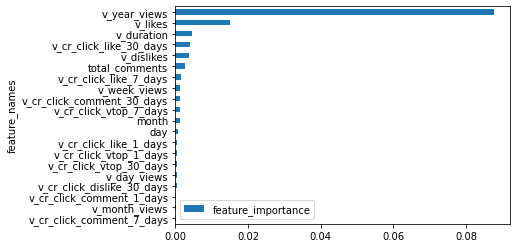

In [42]:
feat_importances[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

In [8]:
import joblib
#joblib.dump(model, 'model.pkl')

In [9]:
model = joblib.load('model.pkl')

## Submission

In [10]:
test_data = pd.read_csv('test_data/test_dataset_submission_queries.csv')

In [11]:
test_data

,query
0,Битва сильнейших экстрасенсов 2023 смотреть | ...
1,битва сильнейших экстрасенсов 2023\nбитва силь...
2,"Экстрасенсы. Битва сильнейших, 4 выпуск"
3,супер стар 4 сезон
4,пять ночей с Фредди
...,...
1995,Шоу аватар 2023
1996,Макс
1997,смотреть мужское женское 2019
1998,шоу вована и лексуса


In [12]:
sub = []
for q in tqdm((range(len(test_data)))):
    search = model_search.predict_front(test_data['query'].iloc[q])['video_id'].tolist()
    for j in search:
        sub.append([test_data['query'].iloc[q],j])
generated_cand_sub = pd.DataFrame(sub, columns = ['query', 'video_id'])

  0%|                                                  | 0/2000 [00:00<?, ?it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  35  ,  36  серия


  0%|                                          | 1/2000 [00:01<40:52,  1.23s/it]

  битва сильнейших экстрасенсов  2023  \n битва сильнейших экстрасенсов  2023  смотреть


  0%|                                          | 2/2000 [00:02<36:05,  1.08s/it]

 экстрасенсы. битва сильнейших,  4  выпуск


  0%|                                          | 3/2000 [00:03<34:50,  1.05s/it]

 супер стар  4  сезон


  0%|                                          | 4/2000 [00:04<33:58,  1.02s/it]

пять ночей с фредди


  0%|                                          | 5/2000 [00:05<33:19,  1.00s/it]

    5  ночей с фредди


  0%|▏                                         | 6/2000 [00:06<32:05,  1.04it/s]

 экстрасенсы. битва сильнейших,  1  выпуск


  0%|▏                                         | 7/2000 [00:06<31:37,  1.05it/s]

цска нижний новгород


  0%|▏                                         | 8/2000 [00:07<31:16,  1.06it/s]

 головоломка  2 


  0%|▏                                         | 9/2000 [00:08<31:53,  1.04it/s]

 экстрасенсы. битва сильнейших,  8  выпуск


  0%|▏                                        | 10/2000 [00:09<32:11,  1.03it/s]

 последний герой  3  выпуск


  1%|▏                                        | 11/2000 [00:10<32:38,  1.02it/s]

wiki show


  1%|▏                                        | 12/2000 [00:11<32:29,  1.02it/s]

  битва сильнейших экстрасенсов  2023 \n битва экстрасенсов\смотреть бесплатно  битва сильнейших экстрасенс


  1%|▎                                        | 13/2000 [00:12<33:40,  1.02s/it]

локомотив ахмат


  1%|▎                                        | 14/2000 [00:13<32:51,  1.01it/s]

 цска пари нижний новгород  5    11    2022 


  1%|▎                                        | 15/2000 [00:14<33:14,  1.00s/it]

 битва сильнейших экстрасенсов  23  выпуск


  1%|▎                                        | 16/2000 [00:16<34:03,  1.03s/it]

сочи динамо


  1%|▎                                        | 17/2000 [00:16<33:07,  1.00s/it]

 звезды в африке,  3   сезон,  1  выпуск


  1%|▎                                        | 18/2000 [00:17<32:29,  1.02it/s]

 слово пацана  1  серия


  1%|▍                                        | 19/2000 [00:18<31:57,  1.03it/s]

дабл бабл


  1%|▍                                        | 20/2000 [00:19<31:46,  1.04it/s]

экстрасенсы. битва сильнейших,


  1%|▍                                        | 21/2000 [00:20<31:48,  1.04it/s]

  битва сильнейших экстрасенсов\n битва экстрасенсов\n битва экстрасенсов  2023  смотреть бесплатно


  1%|▍                                        | 22/2000 [00:21<31:48,  1.04it/s]

неспортивный друг


  1%|▍                                        | 23/2000 [00:22<32:03,  1.03it/s]

 экстрасенсы. битва сильнейших,  3  выпуск


  1%|▍                                        | 24/2000 [00:23<32:01,  1.03it/s]

мама будет против 


  1%|▌                                        | 25/2000 [00:24<31:32,  1.04it/s]

цска пари нн


  1%|▌                                        | 26/2000 [00:25<30:59,  1.06it/s]

 лига городов  8  выпуск


  1%|▌                                        | 27/2000 [00:26<31:06,  1.06it/s]

пацаны с гоблином


  1%|▌                                        | 28/2000 [00:27<31:36,  1.04it/s]

сочи динамо


  1%|▌                                        | 29/2000 [00:28<30:53,  1.06it/s]

 экстрасенсы. битва сильнейших,  6  выпуск


  2%|▌                                        | 30/2000 [00:29<31:29,  1.04it/s]

 экстрасенсы. битва сильнейших,  7  выпуск


  2%|▋                                        | 31/2000 [00:30<31:12,  1.05it/s]

 суперстар  4   сезон  2  выпуск


  2%|▋                                        | 32/2000 [00:31<31:26,  1.04it/s]

праздники 


  2%|▋                                        | 33/2000 [00:32<32:22,  1.01it/s]

 новые звёзды в африке,  8  выпуск


  2%|▋                                        | 34/2000 [00:33<32:01,  1.02it/s]

 мужское женское  10  . 11  . 2023 


  2%|▋                                        | 35/2000 [00:34<32:32,  1.01it/s]

милан псж 


  2%|▋                                        | 36/2000 [00:35<32:05,  1.02it/s]

 мужское женское  13  . 11  . 2023 


  2%|▊                                        | 37/2000 [00:36<33:27,  1.02s/it]

слова пацана


  2%|▊                                        | 38/2000 [00:37<32:30,  1.01it/s]

 новые звёзды в африке,  7  выпуск


  2%|▊                                        | 39/2000 [00:38<32:07,  1.02it/s]

 лига городов  8 


  2%|▊                                        | 40/2000 [00:39<31:38,  1.03it/s]

челси манчестер сити


  2%|▊                                        | 41/2000 [00:40<31:27,  1.04it/s]

 мужское женское  07  . 11  . 2023 


  2%|▊                                        | 42/2000 [00:41<31:04,  1.05it/s]

 экстрасенсы. битва сильнейших,  5  выпуск


  2%|▉                                        | 43/2000 [00:42<31:39,  1.03it/s]

локомотив спартак


  2%|▉                                        | 44/2000 [00:43<31:16,  1.04it/s]

 битва сильнейших  11  . 11  . 2023 


  2%|▉                                        | 45/2000 [00:44<31:29,  1.03it/s]

 новые звёзды в африке,  2  выпуск


  2%|▉                                        | 46/2000 [00:44<31:01,  1.05it/s]

 новые звёзды в африке,  6  выпуск


  2%|▉                                        | 47/2000 [00:45<30:34,  1.06it/s]

    5  ночей с фредди 


  2%|▉                                        | 48/2000 [00:46<31:10,  1.04it/s]

серебрята


  2%|█                                        | 49/2000 [00:47<25:35,  1.27it/s]

 битва сильнейших  23  выпуск 


  2%|█                                        | 50/2000 [00:48<27:02,  1.20it/s]

 экстрасенсы. битва сильнейших,  9  выпуск


  3%|█                                        | 51/2000 [00:49<28:08,  1.15it/s]

цска пари


  3%|█                                        | 52/2000 [00:50<29:28,  1.10it/s]

новые звёзды в африке, 


  3%|█                                        | 53/2000 [00:51<29:37,  1.10it/s]

 мужское женское  09  . 11  . 2023 


  3%|█                                        | 54/2000 [00:52<30:26,  1.07it/s]

 аватар  2   сезон  1  выпуск


  3%|█▏                                       | 55/2000 [00:53<31:27,  1.03it/s]

ахмат факел


  3%|█▏                                       | 56/2000 [00:54<31:01,  1.04it/s]

 аватар шоу  1  сезон


  3%|█▏                                       | 57/2000 [00:54<31:06,  1.04it/s]

 слово пацана  2  серия


  3%|█▏                                       | 58/2000 [00:56<31:33,  1.03it/s]

 новые звёзды в африке,  5  выпуск


  3%|█▏                                       | 59/2000 [00:56<31:14,  1.04it/s]

челси манчестер сити


  3%|█▏                                       | 60/2000 [00:57<31:35,  1.02it/s]

фильм fnaf


  3%|█▎                                       | 61/2000 [00:58<31:08,  1.04it/s]

владус и лёня


  3%|█▎                                       | 62/2000 [00:59<30:42,  1.05it/s]

локомотив ахмат


  3%|█▎                                       | 63/2000 [01:00<30:57,  1.04it/s]

 дом отдыха ягодка  2  выпуск


  3%|█▎                                       | 64/2000 [01:01<31:15,  1.03it/s]

 экстрасенсы. битва сильнейших,  10  выпуск


  3%|█▎                                       | 65/2000 [01:02<31:03,  1.04it/s]

 битва сильнейших  11  . 11  . 23 


  3%|█▎                                       | 66/2000 [01:03<31:15,  1.03it/s]

 экстрасенсы. битва сильнейших,  11  выпуск


  3%|█▎                                       | 67/2000 [01:04<31:00,  1.04it/s]

 мама будет против  2  серия


  3%|█▍                                       | 68/2000 [01:05<31:13,  1.03it/s]

 аватар  2   сезон  2  выпуск


  3%|█▍                                       | 69/2000 [01:06<31:19,  1.03it/s]

 мужское женское  08  . 11  . 2023 


  4%|█▍                                       | 70/2000 [01:07<30:58,  1.04it/s]

 экстрасенсы битва сильнейших  22  серия


  4%|█▍                                       | 71/2000 [01:08<30:43,  1.05it/s]

 мужское женское  17  . 11  . 2023 


  4%|█▍                                       | 72/2000 [01:09<31:56,  1.01it/s]

 новые звёзды в африке,  10  выпуск


  4%|█▍                                       | 73/2000 [01:10<31:50,  1.01it/s]

экстрасенсы. битва сильнейших, 


  4%|█▌                                       | 74/2000 [01:11<30:57,  1.04it/s]

неспортивный друг


  4%|█▌                                       | 75/2000 [01:12<30:31,  1.05it/s]

 экстрасенсы. битва сильнейших,  22  выпуск


  4%|█▌                                       | 76/2000 [01:13<30:14,  1.06it/s]

 битва экстрасенсов  11  . 11  . 2023 


  4%|█▌                                       | 77/2000 [01:14<30:14,  1.06it/s]

  суперстар  4   сезон  2  выпуск


  4%|█▌                                       | 78/2000 [01:15<30:22,  1.05it/s]

  5  ночей с фредди


  4%|█▌                                       | 79/2000 [01:16<30:21,  1.05it/s]

фильм чебурашка


  4%|█▋                                       | 80/2000 [01:17<31:04,  1.03it/s]

сочи рубин


  4%|█▋                                       | 81/2000 [01:18<31:13,  1.02it/s]

 новые звёзды в африке,  9  выпуск


  4%|█▋                                       | 82/2000 [01:19<31:20,  1.02it/s]

 праздники  1  серия


  4%|█▋                                       | 83/2000 [01:20<30:38,  1.04it/s]

локомотив ахмат 


  4%|█▋                                       | 84/2000 [01:20<30:09,  1.06it/s]

 супер стар  4   сезон  3  выпуск


  4%|█▋                                       | 85/2000 [01:21<30:14,  1.06it/s]

skibidi туалет


  4%|█▊                                       | 86/2000 [01:22<30:10,  1.06it/s]

кино барби


  4%|█▊                                       | 87/2000 [01:23<29:59,  1.06it/s]

новые звёзды в африке,


  4%|█▊                                       | 88/2000 [01:24<29:53,  1.07it/s]

 новые звезды в африке  2   сезон  8  серия


  4%|█▊                                       | 89/2000 [01:25<30:03,  1.06it/s]

 экстрасенсы. битва сильнейших,  23  выпуск


  4%|█▊                                       | 90/2000 [01:26<29:58,  1.06it/s]

 цска пари нижний новгород  5  ноября


  5%|█▊                                       | 91/2000 [01:27<29:53,  1.06it/s]

 мужское женское  13  . 11  . 23 


  5%|█▉                                       | 92/2000 [01:28<29:54,  1.06it/s]

 вызов  2   сезон  4  выпуск


  5%|█▉                                       | 93/2000 [01:29<29:44,  1.07it/s]

 битва сильнейших  22 выпуск


  5%|█▉                                       | 94/2000 [01:30<29:48,  1.07it/s]

фнаф кино


  5%|█▉                                       | 95/2000 [01:31<30:13,  1.05it/s]

фнаф фильм 


  5%|█▉                                       | 96/2000 [01:32<29:41,  1.07it/s]

челси сити


  5%|█▉                                       | 97/2000 [01:33<29:28,  1.08it/s]

пять ночей с фредди 


  5%|██                                       | 98/2000 [01:34<29:45,  1.07it/s]

 последний герой выпуск  2 


  5%|██                                       | 99/2000 [01:35<29:37,  1.07it/s]

 последний герой  3  выпуск


  5%|██                                      | 100/2000 [01:36<30:00,  1.06it/s]

 лига городов  8 


  5%|██                                      | 101/2000 [01:37<30:05,  1.05it/s]

toca boca


  5%|██                                      | 102/2000 [01:37<30:19,  1.04it/s]

света и богдан


  5%|██                                      | 103/2000 [01:38<30:00,  1.05it/s]

мужское / женское новые выпуски


  5%|██                                      | 104/2000 [01:39<29:50,  1.06it/s]

цска нн


  5%|██                                      | 105/2000 [01:40<29:36,  1.07it/s]

 экстрасенсы. битва сильнейших,  21  выпуск


  5%|██                                      | 106/2000 [01:41<30:37,  1.03it/s]

 экстрасенсы битва сильнейших  23  выпуск


  5%|██▏                                     | 107/2000 [01:42<31:23,  1.01it/s]

 влада  4 


  5%|██▏                                     | 108/2000 [01:43<30:39,  1.03it/s]

цска пари не


  5%|██▏                                     | 109/2000 [01:44<30:36,  1.03it/s]

слово пацана 


  6%|██▏                                     | 110/2000 [01:45<30:06,  1.05it/s]

 мужское женское  10  . 11  . 23 


  6%|██▏                                     | 111/2000 [01:46<29:53,  1.05it/s]

лаки бобо


  6%|██▏                                     | 112/2000 [01:47<30:17,  1.04it/s]

 экстрасенсы. битва сильнейших,  13  выпуск


  6%|██▎                                     | 113/2000 [01:48<30:02,  1.05it/s]

 супер стар  4   сезон  1  выпуск


  6%|██▎                                     | 114/2000 [01:49<30:50,  1.02it/s]

 плакса  8  серия


  6%|██▎                                     | 115/2000 [01:50<30:45,  1.02it/s]

 битва экстрасенсов  11   ноября  2023 


  6%|██▎                                     | 116/2000 [01:51<30:47,  1.02it/s]

 ягодка  2  выпуск


  6%|██▎                                     | 117/2000 [01:52<30:13,  1.04it/s]

цска пари


  6%|██▎                                     | 118/2000 [01:53<29:39,  1.06it/s]

 битва сильнейших  23 выпуск


  6%|██▍                                     | 119/2000 [01:54<29:50,  1.05it/s]

челси ман сити


  6%|██▍                                     | 120/2000 [01:55<29:52,  1.05it/s]

 звезды в африке,  3   сезон,  12  выпуск


  6%|██▍                                     | 121/2000 [01:56<30:10,  1.04it/s]

 мужское женское  06  . 11  . 2023 


  6%|██▍                                     | 122/2000 [01:57<29:56,  1.05it/s]

 шоу воли  29  выпуск


  6%|██▍                                     | 123/2000 [01:58<30:20,  1.03it/s]

нубик в майнкрафте


  6%|██▍                                     | 124/2000 [01:59<30:36,  1.02it/s]

гоблин пацаны


  6%|██▌                                     | 125/2000 [02:00<30:22,  1.03it/s]

челси ман сити


  6%|██▌                                     | 126/2000 [02:01<30:36,  1.02it/s]

мужское женское ноябрь


  6%|██▌                                     | 127/2000 [02:02<31:06,  1.00it/s]

 последний герой остаться семьей  1  выпуск


  6%|██▌                                     | 128/2000 [02:03<30:40,  1.02it/s]

  суперстар возвращение  4  сезон


  6%|██▌                                     | 129/2000 [02:04<30:04,  1.04it/s]

 битва экстрасенсов  11  . 11  . 23 


  6%|██▌                                     | 130/2000 [02:05<30:22,  1.03it/s]

 экстрасенсы. битва сильнейших,  12  выпуск


  7%|██▌                                     | 131/2000 [02:06<30:13,  1.03it/s]

изолента live


  7%|██▋                                     | 132/2000 [02:06<30:00,  1.04it/s]

 битва сильнейших  11  . 11 


  7%|██▋                                     | 133/2000 [02:07<29:53,  1.04it/s]

выдра сериал


  7%|██▋                                     | 134/2000 [02:08<29:49,  1.04it/s]

 мужское женское  20  . 11  . 2023 


  7%|██▋                                     | 135/2000 [02:09<30:04,  1.03it/s]

сочи динамо 


  7%|██▋                                     | 136/2000 [02:10<29:28,  1.05it/s]

мама будет против 


  7%|██▋                                     | 137/2000 [02:11<29:12,  1.06it/s]

шоу воли агзамов


  7%|██▊                                     | 138/2000 [02:12<29:58,  1.04it/s]

 звезды в африке,  3   сезон,  7  выпуск


  7%|██▊                                     | 139/2000 [02:13<29:27,  1.05it/s]

саша против


  7%|██▊                                     | 140/2000 [02:14<29:16,  1.06it/s]

 битва сильнейших  04  . 11  . 2023 


  7%|██▊                                     | 141/2000 [02:15<30:04,  1.03it/s]

 новые звёзды в африке,  1  выпуск


  7%|██▊                                     | 142/2000 [02:16<29:37,  1.05it/s]

 битва сильнейших  4  ноября


  7%|██▊                                     | 143/2000 [02:17<29:26,  1.05it/s]

 мужское женское  07  . 11  . 2023 


  7%|██▉                                     | 144/2000 [02:18<29:20,  1.05it/s]

челси манчестер сити 


  7%|██▉                                     | 145/2000 [02:19<29:11,  1.06it/s]

 мужское / женское  2023 


  7%|██▉                                     | 146/2000 [02:20<29:22,  1.05it/s]

пять ночей с фредди


  7%|██▉                                     | 147/2000 [02:21<28:55,  1.07it/s]

копенгаген манчестер юнайтед


  7%|██▉                                     | 148/2000 [02:22<28:51,  1.07it/s]

тоттенхэм челси


  7%|██▉                                     | 149/2000 [02:23<28:42,  1.07it/s]

 мужское женское  14  . 11  . 2023 


  8%|███                                     | 150/2000 [02:24<28:57,  1.06it/s]

 экстрасенсы. битва сильнейших,  19  выпуск


  8%|███                                     | 151/2000 [02:24<28:54,  1.07it/s]

человек-паук нет пути домой


  8%|███                                     | 152/2000 [02:25<28:30,  1.08it/s]

копенгаген манчестер


  8%|███                                     | 153/2000 [02:26<28:30,  1.08it/s]

 дом отдыха ягодка  2  серия


  8%|███                                     | 154/2000 [02:27<28:55,  1.06it/s]

цска пари нн


  8%|███                                     | 155/2000 [02:28<28:54,  1.06it/s]

убежище


  8%|███                                     | 156/2000 [02:29<29:00,  1.06it/s]

 экстрасенсы. битва сильнейших,  14  выпуск


  8%|███▏                                    | 157/2000 [02:30<29:10,  1.05it/s]

 шоу аватар  2   сезон  2  выпуск


  8%|███▏                                    | 158/2000 [02:31<29:11,  1.05it/s]

 последний герой остаться семьей  3  выпуск


  8%|███▏                                    | 159/2000 [02:32<29:01,  1.06it/s]

рома лечче


  8%|███▏                                    | 160/2000 [02:33<29:07,  1.05it/s]

 мужское женское  09  . 11  . 23 


  8%|███▏                                    | 161/2000 [02:34<28:53,  1.06it/s]

 мужское женское  07  . 11  . 23 


  8%|███▏                                    | 162/2000 [02:35<29:35,  1.04it/s]

дожить до любви


  8%|███▎                                    | 163/2000 [02:36<29:48,  1.03it/s]

копенгаген манчестер юнайтед 


  8%|███▎                                    | 164/2000 [02:37<29:19,  1.04it/s]

 битва сильнейших  23  серия


  8%|███▎                                    | 165/2000 [02:38<29:09,  1.05it/s]

ворон турецкий сериал


  8%|███▎                                    | 166/2000 [02:39<29:19,  1.04it/s]

 мужское женское  20  . 11  . 23 


  8%|███▎                                    | 167/2000 [02:40<28:57,  1.06it/s]

 мужское женское  10  . 11  . 2023 


  8%|███▎                                    | 168/2000 [02:41<29:10,  1.05it/s]

 мужское женское  7  . 11  . 2023 


  8%|███▍                                    | 169/2000 [02:42<28:57,  1.05it/s]

сочи рубин


  8%|███▍                                    | 170/2000 [02:42<28:42,  1.06it/s]

сериал мама будет против


  9%|███▍                                    | 171/2000 [02:43<28:40,  1.06it/s]

 шоу аватар  2   сезон  1  выпуск


  9%|███▍                                    | 172/2000 [02:44<28:46,  1.06it/s]

 звезды в африке,  3   сезон,  5  выпуск


  9%|███▍                                    | 173/2000 [02:45<28:45,  1.06it/s]

 аватар шоу  2   сезон  2  выпуск


  9%|███▍                                    | 174/2000 [02:46<28:43,  1.06it/s]

 последний герой выпуск  3 


  9%|███▌                                    | 175/2000 [02:47<28:37,  1.06it/s]

 новые звёзды в африке,  13  выпуск


  9%|███▌                                    | 176/2000 [02:48<28:45,  1.06it/s]

    5  ночей с фредди куплинов


  9%|███▌                                    | 177/2000 [02:49<28:38,  1.06it/s]

 экстрасенсы. битва сильнейших,  20  выпуск


  9%|███▌                                    | 178/2000 [02:50<28:52,  1.05it/s]

 новые звёзды в африке,  12  выпуск


  9%|███▌                                    | 179/2000 [02:51<28:57,  1.05it/s]

 битва экстрасенсов битва сильнейших  23  выпуск


  9%|███▌                                    | 180/2000 [02:52<28:39,  1.06it/s]

  битва сильнейших экстрасенсов  2023   смотреть\n битва экстрасенсов  3 \тнт  битва экстрасенсов


  9%|███▌                                    | 181/2000 [02:53<28:57,  1.05it/s]

 мама будет против  2  серия


  9%|███▋                                    | 182/2000 [02:54<28:41,  1.06it/s]

мужское / женское последние выпуски


  9%|███▋                                    | 183/2000 [02:55<28:12,  1.07it/s]

копенгаген манчестер юнайтед


  9%|███▋                                    | 184/2000 [02:56<28:17,  1.07it/s]

сериал выдра


  9%|███▋                                    | 185/2000 [02:57<28:24,  1.06it/s]

  битва сильнейших экстрасенсов  2023   бесплатно\n битва экстрасенсов  4  выпуск


  9%|███▋                                    | 186/2000 [02:58<28:46,  1.05it/s]

  5  ночей с фредди 


  9%|███▋                                    | 187/2000 [02:59<29:18,  1.03it/s]

рома лечче


  9%|███▊                                    | 188/2000 [03:00<29:15,  1.03it/s]

 мужское женское  08  . 11  . 23 


  9%|███▊                                    | 189/2000 [03:01<29:25,  1.03it/s]

 битва экстрасенсов битва сильнейших  22  выпуск


 10%|███▊                                    | 190/2000 [03:02<28:59,  1.04it/s]

ляпота тв


 10%|███▊                                    | 191/2000 [03:02<28:48,  1.05it/s]

 лига городов  9  выпуск


 10%|███▊                                    | 192/2000 [03:03<29:12,  1.03it/s]

 битва сильнейших от  11  . 11  . 23 


 10%|███▊                                    | 193/2000 [03:04<29:08,  1.03it/s]

цифровой цирк


 10%|███▉                                    | 194/2000 [03:05<28:53,  1.04it/s]

следствие вели. \"подельники\


 10%|███▉                                    | 195/2000 [03:06<28:35,  1.05it/s]

цска нн


 10%|███▉                                    | 196/2000 [03:07<28:47,  1.04it/s]

купил дом в глуши


 10%|███▉                                    | 197/2000 [03:08<28:33,  1.05it/s]

 аватар шоу  2   сезон  1  выпуск


 10%|███▉                                    | 198/2000 [03:09<29:04,  1.03it/s]

 мужское и женское ноябрь  2023 


 10%|███▉                                    | 199/2000 [03:10<28:44,  1.04it/s]

 дом отдыха ягодка  2  серия


 10%|████                                    | 200/2000 [03:11<28:31,  1.05it/s]

пекло сирии


 10%|████                                    | 201/2000 [03:12<28:07,  1.07it/s]

тоттенхэм челси


 10%|████                                    | 202/2000 [03:13<28:03,  1.07it/s]

 битва сильнейших  11  . 11  . 2023 


 10%|████                                    | 203/2000 [03:14<27:56,  1.07it/s]

fnaf play


 10%|████                                    | 204/2000 [03:15<28:41,  1.04it/s]

 экстрасенсы битва сильнейших  24  выпуск


 10%|████                                    | 205/2000 [03:16<28:42,  1.04it/s]

мужское / женское новые серии


 10%|████                                    | 206/2000 [03:17<29:25,  1.02it/s]

 экстрасенсы битва сильнейших  22  выпуск 


 10%|████▏                                   | 207/2000 [03:18<29:10,  1.02it/s]

 мужское женское  2023  ноябрь


 10%|████▏                                   | 208/2000 [03:19<29:12,  1.02it/s]

баба яга спасает мир


 10%|████▏                                   | 209/2000 [03:20<28:54,  1.03it/s]

 мужское женское  17  . 11  . 23 


 10%|████▏                                   | 210/2000 [03:21<28:36,  1.04it/s]

тоттенхэм челси


 11%|████▏                                   | 211/2000 [03:22<28:29,  1.05it/s]

 мужское женское  9  . 11  . 2023 


 11%|████▏                                   | 212/2000 [03:23<29:28,  1.01it/s]

 слово пацана  3  серия


 11%|████▎                                   | 213/2000 [03:24<29:38,  1.00it/s]

 мужское женское  13  . 11  . 2023 


 11%|████▎                                   | 214/2000 [03:25<29:17,  1.02it/s]

\"мужское-женское\


 11%|████▎                                   | 215/2000 [03:26<28:41,  1.04it/s]

 аватар  2   сезон  1  выпуск


 11%|████▎                                   | 216/2000 [03:27<28:22,  1.05it/s]

 шоу воли  30  выпуск


 11%|████▎                                   | 217/2000 [03:27<28:15,  1.05it/s]

не спортивный друг


 11%|████▎                                   | 218/2000 [03:28<28:54,  1.03it/s]

 битва сильнейших  11  ноября


 11%|████▍                                   | 219/2000 [03:30<29:26,  1.01it/s]

 битва экстрасенсов  23   сезон  23  выпуск


 11%|████▍                                   | 220/2000 [03:31<29:41,  1.00s/it]

 последний герой остаться семьей  3  выпуск


 11%|████▍                                   | 221/2000 [03:31<29:05,  1.02it/s]

 мужское женское  7  . 11  . 23 


 11%|████▍                                   | 222/2000 [03:33<29:50,  1.01s/it]

сериал праздники 


 11%|████▍                                   | 223/2000 [03:33<29:08,  1.02it/s]

леди баг и супер-кот пробуждение силы


 11%|████▍                                   | 224/2000 [03:35<29:25,  1.01it/s]

пять ночей с фредди фильм


 11%|████▌                                   | 225/2000 [03:35<28:49,  1.03it/s]

мужское / женское последний выпуск


 11%|████▌                                   | 226/2000 [03:37<30:24,  1.03s/it]

шахтер барселона


 11%|████▌                                   | 227/2000 [03:38<29:32,  1.00it/s]

  битва сильнейших экстрасенсов  2023 \n битва экстрасенсов\смотреть  битва экстрасенсов


 11%|████▌                                   | 228/2000 [03:38<28:52,  1.02it/s]

челси манчестер сити


 11%|████▌                                   | 229/2000 [03:39<28:30,  1.04it/s]

 битва сильнейших  11  . 11  . 23 


 12%|████▌                                   | 230/2000 [03:40<29:41,  1.01s/it]

оренбург ростов


 12%|████▌                                   | 231/2000 [03:41<28:49,  1.02it/s]

сериал слово пацана


 12%|████▋                                   | 232/2000 [03:42<28:31,  1.03it/s]

 экстрасенсы. битва сильнейших,  18  выпуск


 12%|████▋                                   | 234/2000 [03:44<22:30,  1.31it/s]

серебрята
 новые звёзды в африке  2   сезон  8  выпуск


 12%|████▋                                   | 235/2000 [03:45<24:26,  1.20it/s]

челси сити


 12%|████▋                                   | 236/2000 [03:46<25:27,  1.15it/s]

фильм пять ночей с фредди


 12%|████▋                                   | 237/2000 [03:46<26:00,  1.13it/s]

 битва экстрасенсов  4  ноября


 12%|████▊                                   | 238/2000 [03:47<26:40,  1.10it/s]

 с чистого листа  1    2    3    4  серия


 12%|████▊                                   | 239/2000 [03:48<26:39,  1.10it/s]

 суперстар  4   сезон  2  выпуск


 12%|████▊                                   | 240/2000 [03:49<27:10,  1.08it/s]

шоу суперстар возвращение


 12%|████▊                                   | 241/2000 [03:50<27:30,  1.07it/s]

мультик барби


 12%|████▊                                   | 242/2000 [03:51<27:54,  1.05it/s]

 мужское женское  09  . 11  . 2023 


 12%|████▊                                   | 243/2000 [03:52<28:05,  1.04it/s]

мама будет против сериал


 12%|████▉                                   | 244/2000 [03:53<28:00,  1.04it/s]

 битва сильнейших  04  . 11  . 23 


 12%|████▉                                   | 245/2000 [03:54<27:55,  1.05it/s]

 аватар шоу  2  сезон


 12%|████▉                                   | 246/2000 [03:55<27:53,  1.05it/s]

 аватар  2  сезон 


 12%|████▉                                   | 247/2000 [03:56<27:33,  1.06it/s]

 аватар  2   сезон  2  выпуск


 12%|████▉                                   | 248/2000 [03:57<27:13,  1.07it/s]

 праздники  1  серия


 12%|████▉                                   | 249/2000 [03:58<27:39,  1.06it/s]

фнаф 


 12%|█████                                   | 250/2000 [03:59<28:23,  1.03it/s]

 битва экстрасенсов от  11  . 11  . 2023 


 13%|█████                                   | 251/2000 [04:00<28:05,  1.04it/s]

 новые звёзды в африке,  3  выпуск


 13%|█████                                   | 252/2000 [04:01<27:48,  1.05it/s]

фильм по щучьему велению


 13%|█████                                   | 253/2000 [04:02<28:25,  1.02it/s]

рецепт на любовь


 13%|█████                                   | 254/2000 [04:03<28:25,  1.02it/s]

 битва экстрасенсов  23  выпуск 


 13%|█████                                   | 255/2000 [04:04<28:45,  1.01it/s]

грузовичок лёва


 13%|█████                                   | 256/2000 [04:05<28:51,  1.01it/s]

 вызов  2   сезон  3 


 13%|█████▏                                  | 257/2000 [04:06<28:37,  1.02it/s]

фильм пять ночей с фредди


 13%|█████▏                                  | 258/2000 [04:07<27:58,  1.04it/s]

локо спартак


 13%|█████▏                                  | 259/2000 [04:08<27:50,  1.04it/s]

 экстрасенсы. битва сильнейших,  17  выпуск


 13%|█████▏                                  | 260/2000 [04:09<28:19,  1.02it/s]

 пацанки  8   сезон  8   выпуск  10    11    2022 


 13%|█████▏                                  | 261/2000 [04:10<29:14,  1.01s/it]

 битва сильнейших   22  выпуск


 13%|█████▏                                  | 262/2000 [04:11<28:55,  1.00it/s]

бавария хайденхайм


 13%|█████▎                                  | 263/2000 [04:12<29:12,  1.01s/it]

цифровой цирк


 13%|█████▎                                  | 264/2000 [04:13<29:21,  1.01s/it]

волшебный участок 


 13%|█████▎                                  | 265/2000 [04:14<30:02,  1.04s/it]

копенгаген манчестер 


 13%|█████▎                                  | 266/2000 [04:15<29:03,  1.01s/it]

локомотив спартак 


 13%|█████▎                                  | 267/2000 [04:16<29:39,  1.03s/it]

  канала 4 


 13%|█████▎                                  | 268/2000 [04:17<29:03,  1.01s/it]

гуситские войны жуков


 13%|█████▍                                  | 269/2000 [04:18<28:19,  1.02it/s]

копенгаген манчестер юнайтед


 14%|█████▍                                  | 270/2000 [04:19<27:42,  1.04it/s]

 новые звезды в африке  2   сезон  9  серия


 14%|█████▍                                  | 271/2000 [04:20<27:39,  1.04it/s]

 монстры на каникулах  1  часть


 14%|█████▍                                  | 272/2000 [04:21<28:33,  1.01it/s]

 мужское женское  14  . 11  . 23 


 14%|█████▍                                  | 273/2000 [04:22<27:59,  1.03it/s]

 фантастика  3  выпуск


 14%|█████▍                                  | 274/2000 [04:23<27:36,  1.04it/s]

 новые звёзды в африке,  4  выпуск


 14%|█████▌                                  | 275/2000 [04:24<27:55,  1.03it/s]

 экстрасенсы. битва сильнейших,  15  выпуск


 14%|█████▌                                  | 276/2000 [04:25<27:40,  1.04it/s]

 битва экстрасенсов  11  . 11  . 2023 


 14%|█████▌                                  | 277/2000 [04:25<27:38,  1.04it/s]

цска пари


 14%|█████▌                                  | 278/2000 [04:26<27:54,  1.03it/s]

 мужское женское  9  . 11  . 23 


 14%|█████▌                                  | 279/2000 [04:28<28:33,  1.00it/s]

  пацаны с гоблином s01e01  the name of the game


 14%|█████▌                                  | 280/2000 [04:29<28:28,  1.01it/s]

  суперстар  3   сезон  2  выпуск


 14%|█████▌                                  | 281/2000 [04:30<28:34,  1.00it/s]

 оно  2  фильм


 14%|█████▋                                  | 282/2000 [04:31<28:44,  1.00s/it]

 битва сильнейших экстрасенсов  11  . 11  . 2023 


 14%|█████▋                                  | 283/2000 [04:32<29:04,  1.02s/it]

скорая помощь


 14%|█████▋                                  | 284/2000 [04:33<28:59,  1.01s/it]

 экстрасенсы битва сильнейших  23  выпуск 


 14%|█████▋                                  | 285/2000 [04:34<29:30,  1.03s/it]

 битва экстрасенсов сильнейших  22  выпуск


 14%|█████▋                                  | 286/2000 [04:35<29:14,  1.02s/it]

 мужское женское  08  . 11  . 2023 


 14%|█████▋                                  | 287/2000 [04:36<28:35,  1.00s/it]

 битва экстрасенсов  04  . 11  . 2023 


 14%|█████▊                                  | 288/2000 [04:37<28:40,  1.01s/it]

 отчий берег  2017    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16  серия


 14%|█████▊                                  | 289/2000 [04:38<29:10,  1.02s/it]

овр шоу неспортивный друг


 14%|█████▊                                  | 290/2000 [04:39<28:39,  1.01s/it]

нтв аватар шоу


 15%|█████▊                                  | 291/2000 [04:40<28:23,  1.00it/s]

 битва экстрасенсов сильнейших  23  выпуск


 15%|█████▊                                  | 292/2000 [04:41<28:11,  1.01it/s]

 аватар  2023 


 15%|█████▊                                  | 293/2000 [04:42<28:05,  1.01it/s]

 битва экстрасенсов сильнейших  21 


 15%|█████▉                                  | 294/2000 [04:43<27:33,  1.03it/s]

 ярче звезд  6  выпуск


 15%|█████▉                                  | 295/2000 [04:43<27:25,  1.04it/s]

овр неспортивный друг


 15%|█████▉                                  | 296/2000 [04:44<27:15,  1.04it/s]

 обзор лиги чемпионов  07  . 11 


 15%|█████▉                                  | 297/2000 [04:45<27:30,  1.03it/s]

 вызов  2   сезон  4  выпуск


 15%|█████▉                                  | 298/2000 [04:46<28:15,  1.00it/s]

 аватар  2  шоу


 15%|█████▉                                  | 299/2000 [04:47<28:09,  1.01it/s]

 битва экстрасенсов  23  серия


 15%|██████                                  | 300/2000 [04:49<28:54,  1.02s/it]

фильм выдра


 15%|██████                                  | 301/2000 [04:49<28:17,  1.00it/s]

нубик и профессионал


 15%|██████                                  | 302/2000 [04:51<28:26,  1.00s/it]

 битва сильнейших от  11  . 11  . 2023 


 15%|██████                                  | 303/2000 [04:51<28:02,  1.01it/s]

 полный набор косметики за  1000 р. в магнит косметик


 15%|██████                                  | 304/2000 [04:52<27:34,  1.03it/s]

между нами горы


 15%|██████                                  | 305/2000 [04:53<27:55,  1.01it/s]

 аватар шоу  2  сезон 


 15%|██████                                  | 306/2000 [04:54<27:50,  1.01it/s]

 новые звёзды в африке,  11  выпуск


 15%|██████▏                                 | 307/2000 [04:55<27:19,  1.03it/s]

 битва сильнейших выпуск  22 


 15%|██████▏                                 | 308/2000 [04:56<27:14,  1.03it/s]

локо спартак


 15%|██████▏                                 | 309/2000 [04:57<26:52,  1.05it/s]

 последний герой остаться семьей  2  выпуск


 16%|██████▏                                 | 310/2000 [04:58<26:32,  1.06it/s]

кровь на асфальте


 16%|██████▏                                 | 311/2000 [04:59<27:02,  1.04it/s]

 супер стар  4  выпуск


 16%|██████▏                                 | 312/2000 [05:00<27:39,  1.02it/s]

 мужское женское  11  . 2023 


 16%|██████▎                                 | 313/2000 [05:01<27:58,  1.00it/s]

 империя петр i  1    2    3    4  серия


 16%|██████▎                                 | 314/2000 [05:02<27:36,  1.02it/s]

  мультика 4 


 16%|██████▎                                 | 315/2000 [05:03<27:10,  1.03it/s]

желейный медведь валера


 16%|██████▎                                 | 316/2000 [05:04<27:11,  1.03it/s]

овр неспортивный друг


 16%|██████▎                                 | 317/2000 [05:05<26:59,  1.04it/s]

  битва экстрасенсов  21  сезон смотреть\n битва экстрасенсов смотреть онлайн бесплатно в хорошем


 16%|██████▎                                 | 318/2000 [05:06<28:38,  1.02s/it]

 дом отдыха ягодка  1  выпуск


 16%|██████▍                                 | 319/2000 [05:07<27:48,  1.01it/s]

суперстар новый сезон


 16%|██████▍                                 | 320/2000 [05:08<28:17,  1.01s/it]

оренбург ростов


 16%|██████▍                                 | 321/2000 [05:09<27:58,  1.00it/s]

 ягодка  2  серия


 16%|██████▍                                 | 322/2000 [05:10<27:58,  1.00s/it]

отмороженные 


 16%|██████▍                                 | 323/2000 [05:11<27:27,  1.02it/s]

суперстар последний выпуск


 16%|██████▍                                 | 324/2000 [05:12<27:35,  1.01it/s]

 обзор лиги чемпионов  07  . 11  . 2023 


 16%|██████▌                                 | 325/2000 [05:13<27:22,  1.02it/s]

 экстрасенсы. битва сильнейших,  16  выпуск


 16%|██████▌                                 | 326/2000 [05:14<27:24,  1.02it/s]

encanto


 16%|██████▌                                 | 327/2000 [05:15<27:44,  1.01it/s]

 ярче звезд  6  выпуск


 16%|██████▌                                 | 328/2000 [05:16<27:18,  1.02it/s]

 последний герой  2  выпуск 


 16%|██████▌                                 | 329/2000 [05:17<27:15,  1.02it/s]

копенгаген мю 


 16%|██████▌                                 | 330/2000 [05:18<27:00,  1.03it/s]

фильм фнаф 


 17%|██████▌                                 | 331/2000 [05:19<26:36,  1.05it/s]

 битва сильнейших выпуск  23 


 17%|██████▋                                 | 332/2000 [05:20<26:21,  1.05it/s]

wiki show play


 17%|██████▋                                 | 333/2000 [05:21<26:48,  1.04it/s]

слово пацана


 17%|██████▋                                 | 334/2000 [05:22<26:48,  1.04it/s]

 мужское женское  8  . 11  . 23 


 17%|██████▋                                 | 335/2000 [05:23<26:43,  1.04it/s]

выдра фильм


 17%|██████▋                                 | 336/2000 [05:24<26:28,  1.05it/s]

мю копенгаген


 17%|██████▋                                 | 337/2000 [05:25<26:12,  1.06it/s]

локомотив спартак


 17%|██████▊                                 | 338/2000 [05:25<26:12,  1.06it/s]

 последний герой  4  выпуск


 17%|██████▊                                 | 339/2000 [05:26<26:36,  1.04it/s]

невеста для экстрасенса


 17%|██████▊                                 | 340/2000 [05:28<27:16,  1.01it/s]

милан псж 


 17%|██████▊                                 | 341/2000 [05:28<27:02,  1.02it/s]

мишка фредди


 17%|██████▊                                 | 342/2000 [05:29<27:11,  1.02it/s]

 шоу воли  30 


 17%|██████▊                                 | 343/2000 [05:30<26:49,  1.03it/s]

 битва сильнейших экстрасенсов  22  выпуск 


 17%|██████▉                                 | 344/2000 [05:31<26:25,  1.04it/s]

 битва экстрасенсов от  11  . 11  . 23 


 17%|██████▉                                 | 345/2000 [05:32<26:41,  1.03it/s]

 головоломка 2 


 17%|██████▉                                 | 346/2000 [05:33<26:24,  1.04it/s]

куклы lol


 17%|██████▉                                 | 347/2000 [05:34<27:28,  1.00it/s]

зима в сердце


 17%|██████▉                                 | 348/2000 [05:35<27:32,  1.00s/it]

луномосик.


 17%|██████▉                                 | 349/2000 [05:36<27:36,  1.00s/it]

фильм слово пацана


 18%|███████                                 | 350/2000 [05:38<29:00,  1.05s/it]

 скорая помощь новый сезон  1  серия


 18%|███████                                 | 351/2000 [05:39<28:05,  1.02s/it]

 вернувшиеся  5   сезон  9  выпуск


 18%|███████                                 | 352/2000 [05:39<27:31,  1.00s/it]

 слово пацана  1  серия 


 18%|███████                                 | 353/2000 [05:40<26:53,  1.02it/s]

 мультик головоломка  2 


 18%|███████                                 | 354/2000 [05:41<26:23,  1.04it/s]

 лига городов  8  выпуск 


 18%|███████                                 | 355/2000 [05:42<26:31,  1.03it/s]

    5  ночей с фредди 


 18%|███████                                 | 356/2000 [05:43<26:35,  1.03it/s]

пацаны гоблин


 18%|███████▏                                | 357/2000 [05:44<26:32,  1.03it/s]

 новые звезды в африке  2   сезон  8  выпуск


 18%|███████▏                                | 358/2000 [05:45<26:21,  1.04it/s]

мужское / женское новый выпуск


 18%|███████▏                                | 359/2000 [05:46<26:16,  1.04it/s]

 новые звёзды в африке,  14  выпуск


 18%|███████▏                                | 360/2000 [05:47<27:44,  1.01s/it]

 гарри поттер  1  часть


 18%|███████▏                                | 361/2000 [05:48<27:36,  1.01s/it]

динамо оренбург 


 18%|███████▏                                | 362/2000 [05:49<27:48,  1.02s/it]

  5  ночей с фредди фильм


 18%|███████▎                                | 363/2000 [05:50<27:06,  1.01it/s]

 битва сильнейших  4  . 11  . 23 


 18%|███████▎                                | 364/2000 [05:51<27:44,  1.02s/it]

 шоу воли,  1  выпуск


 18%|███████▎                                | 365/2000 [05:52<26:53,  1.01it/s]

праздник сериал


 18%|███████▎                                | 366/2000 [05:53<26:59,  1.01it/s]

 последний герой остаться семьёй  1  выпуск


 18%|███████▎                                | 367/2000 [05:54<26:39,  1.02it/s]

 битва сильнейших  4  . 11  . 2023 


 18%|███████▎                                | 368/2000 [05:55<26:32,  1.02it/s]

 новые звёзды в африке  2   сезон  6  выпуск


 18%|███████▍                                | 369/2000 [05:56<26:25,  1.03it/s]

 мужское женское  10  . 11  . 23 


 18%|███████▍                                | 370/2000 [05:57<27:06,  1.00it/s]

 мужское женское от  07  . 11  . 2023 


 19%|███████▍                                | 371/2000 [05:58<27:23,  1.01s/it]

 слово пацана кровь на асфальте  2  серия


 19%|███████▍                                | 372/2000 [05:59<27:06,  1.00it/s]

 экстрасенсы. битва сильнейших  23  выпуск


 19%|███████▍                                | 373/2000 [06:00<27:34,  1.02s/it]

 битва сильнейших от  11  ноября


 19%|███████▍                                | 374/2000 [06:01<27:28,  1.01s/it]

мужское женское дружба врозь


 19%|███████▌                                | 375/2000 [06:02<27:05,  1.00s/it]

динамо оренбург


 19%|███████▌                                | 376/2000 [06:03<26:37,  1.02it/s]

 мужское женское от  13  . 11  . 2023 


 19%|███████▌                                | 377/2000 [06:04<27:31,  1.02s/it]

 битва сильнейший  22  выпуск


 19%|███████▌                                | 378/2000 [06:05<26:49,  1.01it/s]

смотреть мужское / женское


 19%|███████▌                                | 379/2000 [06:06<26:34,  1.02it/s]

 экстра такси  14 


 19%|███████▌                                | 380/2000 [06:07<26:22,  1.02it/s]

 шоу воли  30 


 19%|███████▌                                | 381/2000 [06:08<26:00,  1.04it/s]

 последний герой  10   сезон  2  выпуск


 19%|███████▋                                | 382/2000 [06:09<26:06,  1.03it/s]

 шоу аватар  2  сезон


 19%|███████▋                                | 383/2000 [06:10<26:49,  1.00it/s]

локо ахмат


 19%|███████▋                                | 384/2000 [06:11<27:05,  1.01s/it]

 лига городов  9  выпуск


 19%|███████▋                                | 385/2000 [06:12<26:57,  1.00s/it]

 битва сильнейших экстрасенсов  23  серия


 19%|███████▋                                | 386/2000 [06:13<26:57,  1.00s/it]

зомби апокалипсис


 19%|███████▋                                | 387/2000 [06:14<26:20,  1.02it/s]

пять ночей с фредди 


 19%|███████▊                                | 388/2000 [06:15<26:11,  1.03it/s]

 битва сильнейших  11  . 11 


 19%|███████▊                                | 389/2000 [06:16<25:47,  1.04it/s]

 цифровой цирк  2  серия


 20%|███████▊                                | 390/2000 [06:17<26:11,  1.02it/s]

суперстар


 20%|███████▊                                | 391/2000 [06:18<26:22,  1.02it/s]

 новая битва экстрасенсов,  1   сезон,  3  выпуск


 20%|███████▊                                | 392/2000 [06:19<27:01,  1.01s/it]

 битва сильнейших  23   сезон  23  выпуск


 20%|███████▊                                | 393/2000 [06:20<26:30,  1.01it/s]

  суперстар  2  выпуск


 20%|███████▉                                | 394/2000 [06:21<26:36,  1.01it/s]

 новые звёзды в африке  2   сезон  9  выпуск


 20%|███████▉                                | 395/2000 [06:22<26:23,  1.01it/s]

кино фнаф


 20%|███████▉                                | 396/2000 [06:23<26:22,  1.01it/s]

 аватар  2  сезон 


 20%|███████▉                                | 397/2000 [06:24<26:40,  1.00it/s]

суперстар последний выпуск


 20%|███████▉                                | 398/2000 [06:25<25:54,  1.03it/s]

 суперстар  4   сезон  1  выпуск


 20%|███████▉                                | 399/2000 [06:26<25:47,  1.03it/s]

 экстрасенсы. битва сильнейших  22  выпуск


 20%|████████                                | 400/2000 [06:27<25:31,  1.04it/s]

 экстрасенсы. битва сильнейших,  2  выпуск


 20%|████████                                | 401/2000 [06:28<25:46,  1.03it/s]

не спортивный друг


 20%|████████                                | 402/2000 [06:29<26:15,  1.01it/s]

 ярче звёзд  5  выпуск


 20%|████████                                | 403/2000 [06:30<25:52,  1.03it/s]

 дом отдыха ягодка  2 


 20%|████████                                | 404/2000 [06:31<26:00,  1.02it/s]

 битва экстрасенсов сильнейших  22 


 20%|████████                                | 405/2000 [06:32<26:22,  1.01it/s]

 битва сильнейших  04  . 11 


 20%|████████                                | 406/2000 [06:33<25:49,  1.03it/s]

монако брест


 20%|████████▏                               | 407/2000 [06:34<26:58,  1.02s/it]

 мужское женское  06  . 11  . 23 


 20%|████████▏                               | 408/2000 [06:35<27:18,  1.03s/it]

канал домашний прямой эфир


 20%|████████▏                               | 409/2000 [06:36<27:04,  1.02s/it]

туалет fight


 20%|████████▏                               | 410/2000 [06:37<26:33,  1.00s/it]

 экстра такси  14  выпуск


 21%|████████▏                               | 411/2000 [06:38<26:34,  1.00s/it]

 экстрасенсы. битва сильнейших  23  выпуск


 21%|████████▏                               | 412/2000 [06:39<26:13,  1.01it/s]

 последний герой остаться семьёй  3  выпуск


 21%|████████▎                               | 413/2000 [06:40<26:22,  1.00it/s]

красота и здоровье самарой\


 21%|████████▎                               | 414/2000 [06:41<26:57,  1.02s/it]

цыганские свадьбы


 21%|████████▎                               | 415/2000 [06:42<26:35,  1.01s/it]

песня эщкере


 21%|████████▎                               | 416/2000 [06:43<26:19,  1.00it/s]

  суперстар возвращение  4  выпуск


 21%|████████▎                               | 417/2000 [06:44<26:25,  1.00s/it]

 ты суперстар  4  сезон


 21%|████████▎                               | 418/2000 [06:45<27:17,  1.04s/it]

компот minecraft


 21%|████████▍                               | 419/2000 [06:46<27:31,  1.04s/it]

зеркало для оборотня 


 21%|████████▍                               | 420/2000 [06:47<27:59,  1.06s/it]

шоу воли роза


 21%|████████▍                               | 421/2000 [06:48<27:07,  1.03s/it]

 мужское / женское  2023  год


 21%|████████▍                               | 422/2000 [06:49<27:23,  1.04s/it]

челси ман сити


 21%|████████▍                               | 423/2000 [06:50<27:03,  1.03s/it]

 битва сильнейших   23  выпуск


 21%|████████▍                               | 424/2000 [06:51<26:42,  1.02s/it]

шоу суперстар


 21%|████████▌                               | 425/2000 [06:52<27:05,  1.03s/it]

помни


 21%|████████▌                               | 426/2000 [06:53<26:18,  1.00s/it]

мужское женское если б я был султан


 21%|████████▌                               | 427/2000 [06:54<25:55,  1.01it/s]

 мама будет против  1  серия


 21%|████████▌                               | 428/2000 [06:55<25:56,  1.01it/s]

 мама будет против  2 


 21%|████████▌                               | 429/2000 [06:56<25:40,  1.02it/s]

крапленый сериал все серии


 22%|████████▌                               | 430/2000 [06:57<25:20,  1.03it/s]

 мужское женское от  10  . 11  . 2023 


 22%|████████▌                               | 431/2000 [06:58<25:31,  1.02it/s]

 лига городов  9 


 22%|████████▋                               | 432/2000 [06:59<25:15,  1.03it/s]

 дом отдыха ягодка  1  выпуск


 22%|████████▋                               | 433/2000 [07:00<25:47,  1.01it/s]

 слово пацана кровь на асфальте  1  серия


 22%|████████▋                               | 434/2000 [07:01<26:14,  1.01s/it]

локомотив спартак 


 22%|████████▋                               | 435/2000 [07:02<26:03,  1.00it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  21 


 22%|████████▋                               | 436/2000 [07:03<25:53,  1.01it/s]

 битва экстрасенсов  4   ноября  2023 


 22%|████████▋                               | 437/2000 [07:04<25:49,  1.01it/s]

стс мама будет против


 22%|████████▊                               | 438/2000 [07:05<26:02,  1.00s/it]

 суперстар  4  сезон 


 22%|████████▊                               | 439/2000 [07:06<25:38,  1.01it/s]

 мужское женское  07  . 11  . 23 


 22%|████████▊                               | 440/2000 [07:07<25:39,  1.01it/s]

тоттенхэм челси


 22%|████████▊                               | 441/2000 [07:08<25:32,  1.02it/s]

 новые звёзды в африке  2   сезон  8  выпуск


 22%|████████▊                               | 442/2000 [07:09<25:09,  1.03it/s]

локомотив спартак обзор


 22%|████████▊                               | 443/2000 [07:10<25:44,  1.01it/s]

фильм по щучьему велению


 22%|████████▉                               | 444/2000 [07:11<25:36,  1.01it/s]

 мужское женское  8  . 11  . 2023 


 22%|████████▉                               | 445/2000 [07:12<25:16,  1.03it/s]

 битва экстрасенсов  11  . 11 


 22%|████████▉                               | 446/2000 [07:13<25:35,  1.01it/s]

 битва сильнейших от  04  . 11  . 2023 


 22%|████████▉                               | 447/2000 [07:14<26:01,  1.01s/it]

фредди фазбер


 22%|████████▉                               | 448/2000 [07:15<25:25,  1.02it/s]

фильм человек-паук


 22%|████████▉                               | 449/2000 [07:16<25:24,  1.02it/s]

 битва сильнейших  23   сезон  22  выпуск


 22%|█████████                               | 450/2000 [07:17<26:09,  1.01s/it]

тулуза ливерпуль 


 23%|█████████                               | 451/2000 [07:18<26:01,  1.01s/it]

 экстрасенсы битва сильнейших  11  . 11  . 2023 


 23%|█████████                               | 452/2000 [07:19<26:14,  1.02s/it]

пять ночей с фредди


 23%|█████████                               | 453/2000 [07:20<25:53,  1.00s/it]

 экстрасенсы битва сильнейших  11  . 11  . 23 


 23%|█████████                               | 454/2000 [07:21<25:46,  1.00s/it]

фильм про fnaf


 23%|█████████                               | 455/2000 [07:22<25:28,  1.01it/s]

 битва сильнейших экстрасенсов  11  . 11  . 23 


 23%|█████████                               | 456/2000 [07:23<25:14,  1.02it/s]

рома лечче 


 23%|█████████▏                              | 457/2000 [07:24<25:19,  1.02it/s]

монако брест


 23%|█████████▏                              | 458/2000 [07:25<25:11,  1.02it/s]

прожарка ягодиц с резинкой стоя


 23%|█████████▏                              | 459/2000 [07:26<25:05,  1.02it/s]

 слово пацана  4  серия


 23%|█████████▏                              | 460/2000 [07:27<25:16,  1.02it/s]

 монстры на каникулах  4 


 23%|█████████▏                              | 461/2000 [07:28<24:59,  1.03it/s]

 мужское женское  7  . 11  . 2023 


 23%|█████████▏                              | 462/2000 [07:29<25:31,  1.00it/s]

 битва сильнейших  18  . 11  . 23 


 23%|█████████▎                              | 463/2000 [07:30<26:34,  1.04s/it]

шоу воли сябитова


 23%|█████████▎                              | 464/2000 [07:31<26:25,  1.03s/it]

 битва сильнейших  4  . 11 


 23%|█████████▎                              | 465/2000 [07:32<27:08,  1.06s/it]

 суперстар возвращение  4   сезон  1  выпуск


 23%|█████████▎                              | 466/2000 [07:33<26:54,  1.05s/it]

 ягодка  2  серия


 23%|█████████▎                              | 467/2000 [07:34<26:41,  1.04s/it]

 битва сильнейших экстрасенсов от  11  . 11  . 2023 


 23%|█████████▎                              | 468/2000 [07:35<26:21,  1.03s/it]

сопрано гоблин


 23%|█████████▍                              | 469/2000 [07:36<25:28,  1.00it/s]

стой, не то мама будет гадать


 24%|█████████▍                              | 470/2000 [07:37<25:59,  1.02s/it]

внеклассное чтение


 24%|█████████▍                              | 471/2000 [07:38<25:59,  1.02s/it]

лука мультик


 24%|█████████▍                              | 472/2000 [07:39<25:51,  1.02s/it]

 хрустальное счастье все серии сериал  2021 


 24%|█████████▍                              | 473/2000 [07:40<25:17,  1.01it/s]

суперстар последний выпуск


 24%|█████████▍                              | 474/2000 [07:41<25:26,  1.00s/it]

 битва экстрасенсов  11  . 11  . 23 


 24%|█████████▌                              | 475/2000 [07:42<25:27,  1.00s/it]

 лига чемпионов  07  . 11 


 24%|█████████▌                              | 476/2000 [07:43<25:10,  1.01it/s]

пять ночей с фредди 


 24%|█████████▌                              | 477/2000 [07:44<24:57,  1.02it/s]

спартак ростов 


 24%|█████████▌                              | 478/2000 [07:45<24:38,  1.03it/s]

 слово пацана  1 серия


 24%|█████████▌                              | 479/2000 [07:46<24:35,  1.03it/s]

 битва сильнейших  22 серия


 24%|█████████▌                              | 480/2000 [07:47<24:52,  1.02it/s]

 битва сильнейших экстрасенсов  23  выпуск 


 24%|█████████▌                              | 481/2000 [07:48<25:26,  1.00s/it]

праздники сериал 


 24%|█████████▋                              | 482/2000 [07:49<25:06,  1.01it/s]

слово пацана смотреть


 24%|█████████▋                              | 483/2000 [07:50<24:47,  1.02it/s]

 монстры на каникулах  1  часть


 24%|█████████▋                              | 484/2000 [07:51<25:20,  1.00s/it]

пять ночей у фредди


 24%|█████████▋                              | 485/2000 [07:52<25:58,  1.03s/it]

 лига городов  9 


 24%|█████████▋                              | 486/2000 [07:53<25:18,  1.00s/it]

канал стс


 24%|█████████▋                              | 487/2000 [07:54<25:04,  1.01it/s]

куколки lol


 24%|█████████▊                              | 488/2000 [07:55<24:57,  1.01it/s]

 шоу воли  30  выпуск


 24%|█████████▊                              | 489/2000 [07:56<24:41,  1.02it/s]

 битва шефов  3   сезон  12  выпуск


 24%|█████████▊                              | 490/2000 [07:57<25:29,  1.01s/it]

 суперстар  11  . 11  . 2023 


 25%|█████████▊                              | 491/2000 [07:58<24:53,  1.01it/s]

аватар шоу


 25%|█████████▊                              | 492/2000 [07:59<24:51,  1.01it/s]

 мужское женское  24  . 08  . 2020 


 25%|█████████▊                              | 493/2000 [08:00<24:36,  1.02it/s]

фильм оно


 25%|█████████▉                              | 494/2000 [08:01<24:44,  1.01it/s]

мультик маша и медведь


 25%|█████████▉                              | 495/2000 [08:02<24:30,  1.02it/s]

  тролли  3 


 25%|█████████▉                              | 496/2000 [08:03<24:04,  1.04it/s]

пари нн балтика


 25%|█████████▉                              | 497/2000 [08:04<24:24,  1.03it/s]

 битва сильнейших от  4  ноября


 25%|█████████▉                              | 498/2000 [08:05<24:32,  1.02it/s]

 битва сильнейших  57  серия


 25%|█████████▉                              | 499/2000 [08:06<24:24,  1.02it/s]

 мужское женское  09  . 11  . 23 


 25%|██████████                              | 500/2000 [08:07<24:31,  1.02it/s]

 плакса  1  серия 


 25%|██████████                              | 501/2000 [08:08<24:15,  1.03it/s]

 экстрасенсы битва сильнейших  22 выпуск


 25%|██████████                              | 502/2000 [08:09<24:29,  1.02it/s]

фнаф  фильм


 25%|██████████                              | 503/2000 [08:10<24:25,  1.02it/s]

 битва сильнейших от  11  . 11 


 25%|██████████                              | 504/2000 [08:11<24:30,  1.02it/s]

шоу воли агзамович


 25%|██████████                              | 505/2000 [08:12<24:30,  1.02it/s]

 новые звёзды в африке  2   сезон  9  выпуск


 25%|██████████                              | 506/2000 [08:12<24:03,  1.04it/s]

слово пацана кровь на асфальте


 25%|██████████▏                             | 507/2000 [08:14<24:40,  1.01it/s]

стой, а то мама будет гадать


 25%|██████████▏                             | 508/2000 [08:14<24:28,  1.02it/s]

  суперстар возвращение  4 


 25%|██████████▏                             | 509/2000 [08:16<24:53,  1.00s/it]

фильм гарри поттер


 26%|██████████▏                             | 510/2000 [08:17<25:05,  1.01s/it]

 мужское и женское  07  . 11  . 2023 


 26%|██████████▏                             | 511/2000 [08:18<24:34,  1.01it/s]

 выжить в дубае,  2  выпуск


 26%|██████████▏                             | 512/2000 [08:19<24:39,  1.01it/s]

крымчанин


 26%|██████████▎                             | 513/2000 [08:20<25:05,  1.01s/it]

ярче звезд


 26%|██████████▎                             | 514/2000 [08:20<24:26,  1.01it/s]

челси тоттенхэм


 26%|██████████▎                             | 515/2000 [08:21<23:57,  1.03it/s]

лара minecraft


 26%|██████████▎                             | 516/2000 [08:22<24:14,  1.02it/s]

шоу фантастика 


 26%|██████████▎                             | 517/2000 [08:23<24:42,  1.00it/s]

фильм про барби


 26%|██████████▎                             | 518/2000 [08:24<24:44,  1.00s/it]

факел цска 


 26%|██████████▍                             | 519/2000 [08:27<32:56,  1.33s/it]

 мужское и женское  07  . 11  . 2023 


 26%|██████████▍                             | 520/2000 [08:28<30:23,  1.23s/it]

 головоломка  2  мультик


 26%|██████████▍                             | 521/2000 [08:29<29:07,  1.18s/it]

 вызов  2   сезон  3  выпуск 


 26%|██████████▍                             | 522/2000 [08:30<27:33,  1.12s/it]

удивительные цифровой цирк


 26%|██████████▍                             | 523/2000 [08:31<26:06,  1.06s/it]

five nights at freddy's


 26%|██████████▍                             | 524/2000 [08:31<25:12,  1.02s/it]

ювентус кальяри


 26%|██████████▌                             | 525/2000 [08:32<24:38,  1.00s/it]

 слово пацана  1  серия


 26%|██████████▌                             | 526/2000 [08:33<24:03,  1.02it/s]

мультик три кота


 26%|██████████▌                             | 527/2000 [08:34<24:06,  1.02it/s]

 битва сильнейших  56  серия


 26%|██████████▌                             | 528/2000 [08:35<24:09,  1.02it/s]

 дом где сердце  2021    1    2    3    4  серия


 26%|██████████▌                             | 529/2000 [08:36<24:20,  1.01it/s]

 новые звёзды в африке  2   сезон  8  серия


 26%|██████████▌                             | 530/2000 [08:37<24:07,  1.02it/s]

пять ночей у фредди


 27%|██████████▌                             | 531/2000 [08:38<23:42,  1.03it/s]

оппенгеймер фильмах рутуб


 27%|██████████▋                             | 532/2000 [08:39<23:58,  1.02it/s]

шоу воли гаязовы


 27%|██████████▋                             | 533/2000 [08:40<23:49,  1.03it/s]

 аватар  2 сезон


 27%|██████████▋                             | 534/2000 [08:41<23:49,  1.03it/s]

 битва сильнейших  18  . 11  . 2023 


 27%|██████████▋                             | 535/2000 [08:42<23:45,  1.03it/s]

 мужское женское  6  . 11  . 2023 


 27%|██████████▋                             | 536/2000 [08:43<23:43,  1.03it/s]

владус владус


 27%|██████████▋                             | 537/2000 [08:44<24:19,  1.00it/s]

 мужское женское  15  . 11  . 2023 


 27%|██████████▊                             | 538/2000 [08:45<24:31,  1.01s/it]

 обзор матчей лиги чемпионов  07  . 11  . 2023 


 27%|██████████▊                             | 539/2000 [08:46<25:01,  1.03s/it]

праздники


 27%|██████████▊                             | 540/2000 [08:47<24:56,  1.03s/it]

не отпускай


 27%|██████████▊                             | 541/2000 [08:48<24:49,  1.02s/it]

неформат с михаилом задорновым


 27%|██████████▊                             | 542/2000 [08:49<24:29,  1.01s/it]

 головоломка  2  мультфильм


 27%|██████████▊                             | 543/2000 [08:50<24:07,  1.01it/s]

локомотив ахмат 


 27%|██████████▉                             | 544/2000 [08:51<23:58,  1.01it/s]

шахтер барселона 


 27%|██████████▉                             | 545/2000 [08:52<23:44,  1.02it/s]

 звезды в африке,  3   сезон,  6  выпуск


 27%|██████████▉                             | 546/2000 [08:53<23:30,  1.03it/s]

тоттенхэм челси


 27%|██████████▉                             | 547/2000 [08:54<23:51,  1.02it/s]

 днк ноябрь  2023 


 27%|██████████▉                             | 548/2000 [08:55<23:39,  1.02it/s]

фильм про фнаф


 27%|██████████▉                             | 549/2000 [08:56<23:38,  1.02it/s]

  битва сильнейших экстрасенсов  2023  смотреть\n битва экстрасенсов


 28%|███████████                             | 550/2000 [08:57<23:50,  1.01it/s]

изгиб


 28%|███████████                             | 551/2000 [08:58<23:18,  1.04it/s]

нтв суперстар возвращение


 28%|███████████                             | 552/2000 [08:59<23:27,  1.03it/s]

камуфляж и шпионаж


 28%|███████████                             | 553/2000 [09:00<23:29,  1.03it/s]

  экстра такси  14  выпуск


 28%|███████████                             | 554/2000 [09:01<23:24,  1.03it/s]

  528  гц частота для поднятия положительных вибраций музыка для медитации


 28%|███████████                             | 555/2000 [09:02<23:29,  1.03it/s]

спартак ростов обзор


 28%|███████████                             | 556/2000 [09:03<23:18,  1.03it/s]

света геймер


 28%|███████████▏                            | 557/2000 [09:04<23:18,  1.03it/s]

такси с владом чреватым


 28%|███████████▏                            | 558/2000 [09:05<23:08,  1.04it/s]

кошка лана


 28%|███████████▏                            | 559/2000 [09:06<24:04,  1.00s/it]

 суперстар


 28%|███████████▏                            | 560/2000 [09:07<24:16,  1.01s/it]

сериал праздник


 28%|███████████▏                            | 561/2000 [09:08<24:03,  1.00s/it]

отель для двоих


 28%|███████████▏                            | 562/2000 [09:09<24:01,  1.00s/it]

челси мс


 28%|███████████▎                            | 563/2000 [09:10<23:39,  1.01it/s]

город героев мультик


 28%|███████████▎                            | 564/2000 [09:11<24:05,  1.01s/it]

камеди клаб завещание


 28%|███████████▎                            | 565/2000 [09:12<23:48,  1.00it/s]

смотреть сериал праздники


 28%|███████████▎                            | 566/2000 [09:13<23:17,  1.03it/s]

 макияж косметикой за  1000  рублей


 28%|███████████▎                            | 567/2000 [09:14<23:32,  1.01it/s]

цска не


 28%|███████████▎                            | 568/2000 [09:15<23:31,  1.01it/s]

 битва сильнейших  11   ноября  2023 


 28%|███████████▍                            | 569/2000 [09:16<23:14,  1.03it/s]

звук при коликах


 28%|███████████▍                            | 570/2000 [09:17<23:05,  1.03it/s]

слово пацана кровь на асфальте


 29%|███████████▍                            | 571/2000 [09:18<23:22,  1.02it/s]

звездная пыль фильм


 29%|███████████▍                            | 572/2000 [09:19<23:27,  1.01it/s]

 мужское женское  8   ноября  2023 


 29%|███████████▍                            | 573/2000 [09:20<23:10,  1.03it/s]

 головоломка  2 


 29%|███████████▍                            | 574/2000 [09:21<22:54,  1.04it/s]

великолепный век


 29%|███████████▌                            | 575/2000 [09:22<23:00,  1.03it/s]

цска пари нн 


 29%|███████████▌                            | 576/2000 [09:23<23:00,  1.03it/s]

 экстрасенсы  24  выпуск


 29%|███████████▌                            | 577/2000 [09:24<23:56,  1.01s/it]

 новые звезды в африке  2   сезон  8  выпуск 


 29%|███████████▌                            | 578/2000 [09:25<23:59,  1.01s/it]

 школа глазами школьника  4 


 29%|███████████▌                            | 579/2000 [09:26<24:03,  1.02s/it]

однажды в россии неспортивный друг


 29%|███████████▌                            | 580/2000 [09:27<23:35,  1.00it/s]

харли квинн


 29%|███████████▌                            | 581/2000 [09:28<23:26,  1.01it/s]

сосед


 29%|███████████▋                            | 582/2000 [09:29<23:11,  1.02it/s]

экстрасенсы битва сильнейших шестнадцатый выпуск


 29%|███████████▋                            | 583/2000 [09:30<22:44,  1.04it/s]

аудиокниги 


 29%|███████████▋                            | 584/2000 [09:31<23:05,  1.02it/s]

 суперстар возвращение  4   сезон  2  выпуск


 29%|███████████▋                            | 585/2000 [09:31<22:58,  1.03it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  17 


 29%|███████████▋                            | 586/2000 [09:32<23:01,  1.02it/s]

призраки в венеции 


 29%|███████████▋                            | 587/2000 [09:34<23:20,  1.01it/s]

 последний герой  3  выпуск 


 29%|███████████▊                            | 588/2000 [09:34<22:59,  1.02it/s]

 битва сильнейших  2023    22  выпуск


 29%|███████████▊                            | 589/2000 [09:35<22:57,  1.02it/s]

 мужское и женское  10  . 11  . 2023 


 30%|███████████▊                            | 590/2000 [09:36<22:58,  1.02it/s]

ральф


 30%|███████████▊                            | 591/2000 [09:37<23:19,  1.01it/s]

 последний герой выпуск  2 


 30%|███████████▊                            | 592/2000 [09:38<23:01,  1.02it/s]

песня про маму


 30%|███████████▊                            | 593/2000 [09:39<22:59,  1.02it/s]

 супер стар  4  сезон 


 30%|███████████▉                            | 594/2000 [09:40<22:52,  1.02it/s]

овр шоу не спортивный друг


 30%|███████████▉                            | 595/2000 [09:41<22:56,  1.02it/s]

буду стоять


 30%|███████████▉                            | 596/2000 [09:42<22:53,  1.02it/s]

стой не то мама будет гадать 


 30%|███████████▉                            | 597/2000 [09:43<23:01,  1.02it/s]

фильм аниматроники


 30%|███████████▉                            | 598/2000 [09:44<22:58,  1.02it/s]

реал мадрид брага


 30%|███████████▉                            | 599/2000 [09:45<23:00,  1.01it/s]

fnaf фильм


 30%|████████████                            | 600/2000 [09:46<22:49,  1.02it/s]

 суперстар возвращение  2023 


 30%|████████████                            | 601/2000 [09:47<22:41,  1.03it/s]

 экстрасенсы битва сильнейших  57  серия


 30%|████████████                            | 602/2000 [09:48<22:34,  1.03it/s]

челси ман сити


 30%|████████████                            | 604/2000 [09:49<17:27,  1.33it/s]

russgo
фильм пять ночей с фредди


 30%|████████████                            | 605/2000 [09:50<19:01,  1.22it/s]

 мужское женское  17  . 11  . 2023 


 30%|████████████                            | 606/2000 [09:51<20:02,  1.16it/s]

five nights at freddy's фильм


 30%|████████████▏                           | 607/2000 [09:52<20:56,  1.11it/s]

шоу воли акзамов


 30%|████████████▏                           | 608/2000 [09:53<21:21,  1.09it/s]

 битва сильнейших  21 сезон


 30%|████████████▏                           | 609/2000 [09:54<22:35,  1.03it/s]

 дела житейские  2022    1    2    3    4  серия


 30%|████████████▏                           | 610/2000 [09:55<22:44,  1.02it/s]

барби и кен


 31%|████████████▏                           | 611/2000 [09:56<22:57,  1.01it/s]

богдан и света


 31%|████████████▏                           | 612/2000 [09:57<22:56,  1.01it/s]

 звезды в африке,  3   сезон,  4  выпуск


 31%|████████████▎                           | 613/2000 [09:58<22:35,  1.02it/s]

динамо оренбург


 31%|████████████▎                           | 614/2000 [09:59<22:12,  1.04it/s]

копенгаген манчестер 


 31%|████████████▎                           | 615/2000 [10:00<22:40,  1.02it/s]

сочи динамо 


 31%|████████████▎                           | 616/2000 [10:01<22:47,  1.01it/s]

 битва экстрасенсов  18  . 11  . 2023 


 31%|████████████▎                           | 617/2000 [10:02<22:52,  1.01it/s]

за палыча


 31%|████████████▎                           | 618/2000 [10:03<22:46,  1.01it/s]

павлович аспиналл


 31%|████████████▍                           | 619/2000 [10:04<22:26,  1.03it/s]

шоу воли губерниев


 31%|████████████▍                           | 620/2000 [10:05<22:52,  1.01it/s]

аня дабл бабл


 31%|████████████▍                           | 621/2000 [10:06<22:34,  1.02it/s]

  суперстар возвращение  3   сезон  2  выпуск


 31%|████████████▍                           | 622/2000 [10:07<23:28,  1.02s/it]

город призраков


 31%|████████████▍                           | 623/2000 [10:08<23:15,  1.01s/it]

 битва сильнейших  04  . 11  . 2023 


 31%|████████████▍                           | 624/2000 [10:09<23:51,  1.04s/it]

локомотив ахмат


 31%|████████████▌                           | 625/2000 [10:10<23:20,  1.02s/it]

спартак ростов


 31%|████████████▌                           | 626/2000 [10:11<22:47,  1.01it/s]

 ледниковый период  4  континентальный дрейф полная версия


 31%|████████████▌                           | 627/2000 [10:12<22:16,  1.03it/s]

аватар world


 31%|████████████▌                           | 628/2000 [10:13<22:18,  1.02it/s]

да был бабл


 31%|████████████▌                           | 629/2000 [10:14<21:58,  1.04it/s]

отмороженные


 32%|████████████▌                           | 630/2000 [10:15<21:49,  1.05it/s]

 superstar  4  сезон


 32%|████████████▌                           | 631/2000 [10:16<21:39,  1.05it/s]

псарня в малиновке


 32%|████████████▋                           | 632/2000 [10:17<21:47,  1.05it/s]

  битва сильнейших экстрасенсов  2023   смотреть\n битва экстрасенсов\n битва экстрасенсов  2023 


 32%|████████████▋                           | 633/2000 [10:18<23:54,  1.05s/it]

 суперстар  5  сезон


 32%|████████████▋                           | 634/2000 [10:19<23:56,  1.05s/it]

челси манчестер сити


 32%|████████████▋                           | 635/2000 [10:20<23:48,  1.05s/it]

 битва экстрасенсов  23  серия


 32%|████████████▋                           | 636/2000 [10:21<23:28,  1.03s/it]

 последний герой остаться семьёй  2  выпуск


 32%|████████████▋                           | 637/2000 [10:22<23:09,  1.02s/it]

шоу воли агзамов 


 32%|████████████▊                           | 638/2000 [10:23<23:03,  1.02s/it]

гравити фолз


 32%|████████████▊                           | 639/2000 [10:24<22:54,  1.01s/it]

человек паук фильм


 32%|████████████▊                           | 640/2000 [10:25<23:14,  1.03s/it]

мультик лунтик


 32%|████████████▊                           | 641/2000 [10:26<22:40,  1.00s/it]

бетис арис


 32%|████████████▊                           | 642/2000 [10:27<22:12,  1.02it/s]

волшебный участок 


 32%|████████████▊                           | 643/2000 [10:28<22:20,  1.01it/s]

овр шоу неспортивный друг


 32%|████████████▉                           | 644/2000 [10:29<22:31,  1.00it/s]

человек-паук через вселенную


 32%|████████████▉                           | 645/2000 [10:30<22:40,  1.00s/it]

гоблин пацаны


 32%|████████████▉                           | 646/2000 [10:31<22:25,  1.01it/s]

 лига городов  8  выпуск 


 32%|████████████▉                           | 647/2000 [10:32<22:08,  1.02it/s]

путь феникса


 32%|████████████▉                           | 648/2000 [10:33<21:51,  1.03it/s]

овр не спортивный друг


 32%|████████████▉                           | 649/2000 [10:34<22:38,  1.01s/it]

 экстрасенсы битва сильнейших  22  


 32%|█████████████                           | 650/2000 [10:35<22:22,  1.01it/s]

 вызов  2   сезон  4 


 33%|█████████████                           | 651/2000 [10:36<22:20,  1.01it/s]

 битва сильнейших  4   ноября  2023 


 33%|█████████████                           | 652/2000 [10:37<21:54,  1.03it/s]

 пираты карибского моря  1  проклятие черной жемчужины 


 33%|█████████████                           | 653/2000 [10:38<22:00,  1.02it/s]

 рик и морти  7   сезон  4  серия


 33%|█████████████                           | 654/2000 [10:39<21:43,  1.03it/s]

шоу воли ренат


 33%|█████████████                           | 655/2000 [10:40<21:30,  1.04it/s]

пять ночей фредди


 33%|█████████████                           | 656/2000 [10:41<21:58,  1.02it/s]

мосгаз последнее дело черкасова


 33%|█████████████▏                          | 657/2000 [10:42<21:46,  1.03it/s]

  аватар  2 


 33%|█████████████▏                          | 658/2000 [10:43<21:41,  1.03it/s]

 новые звезды в африке  2   сезон  8  серия


 33%|█████████████▏                          | 659/2000 [10:44<21:44,  1.03it/s]

компот компот


 33%|█████████████▏                          | 660/2000 [10:45<21:55,  1.02it/s]

 новые звезды в африке  2   сезон  9  серия


 33%|█████████████▏                          | 661/2000 [10:46<21:45,  1.03it/s]

битва сильнейших шестнадцатый выпуск


 33%|█████████████▏                          | 662/2000 [10:47<21:49,  1.02it/s]

  битва сильнейших экстрасенсов  2023   смотреть\n битва экстрасенсов  2023  новый сезон


 33%|█████████████▎                          | 663/2000 [10:48<22:37,  1.02s/it]

канал double bubble


 33%|█████████████▎                          | 664/2000 [10:49<22:04,  1.01it/s]

 экстрасенсы битва сильнейших  19   сезон  21  серия


 33%|█████████████▎                          | 665/2000 [10:50<21:42,  1.03it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  12 


 33%|█████████████▎                          | 666/2000 [10:51<21:32,  1.03it/s]

челси тоттенхэм


 33%|█████████████▎                          | 667/2000 [10:52<21:16,  1.04it/s]

экстрасенсы битва сильнейших восемнадцатый выпуск


 33%|█████████████▎                          | 668/2000 [10:53<21:26,  1.04it/s]

 битва экстрасенсов  04  . 11  . 23 


 33%|█████████████▍                          | 669/2000 [10:54<21:14,  1.04it/s]

убийца фильм


 34%|█████████████▍                          | 670/2000 [10:55<21:00,  1.06it/s]

 головоломка  2015 


 34%|█████████████▍                          | 671/2000 [10:56<21:00,  1.05it/s]

 вернувшиеся  5   сезон  8  выпуск


 34%|█████████████▍                          | 672/2000 [10:57<21:14,  1.04it/s]

пучков пацаны


 34%|█████████████▍                          | 673/2000 [10:58<21:39,  1.02it/s]

файт найт


 34%|█████████████▍                          | 674/2000 [10:58<21:20,  1.04it/s]

 битва экстрасенсов  18  ноября


 34%|█████████████▌                          | 675/2000 [11:00<21:41,  1.02it/s]

луномосик старые серии


 34%|█████████████▌                          | 676/2000 [11:00<21:37,  1.02it/s]

 обзор лиги чемпионов  08  . 11 


 34%|█████████████▌                          | 677/2000 [11:01<21:33,  1.02it/s]

 последний герой  2 выпуск


 34%|█████████████▌                          | 678/2000 [11:03<21:55,  1.00it/s]

удача


 34%|█████████████▌                          | 679/2000 [11:03<21:49,  1.01it/s]

атлетико селтик 


 34%|█████████████▌                          | 680/2000 [11:04<21:22,  1.03it/s]

эщ эщ


 34%|█████████████▌                          | 681/2000 [11:05<20:54,  1.05it/s]

 новые звёзды в африке  2   сезон  4  серия


 34%|█████████████▋                          | 682/2000 [11:06<21:08,  1.04it/s]

 шоу аватар  2  сезон 


 34%|█████████████▋                          | 683/2000 [11:07<21:16,  1.03it/s]

 сочи динамо  9    09    2022 


 34%|█████████████▋                          | 684/2000 [11:08<21:31,  1.02it/s]

 великолепная пятерка  3  сезон


 34%|█████████████▋                          | 685/2000 [11:09<21:54,  1.00it/s]

человек-паук через вселенные


 34%|█████████████▋                          | 686/2000 [11:10<21:27,  1.02it/s]

 мужское женское от  17  . 11  . 2023 


 34%|█████████████▋                          | 687/2000 [11:11<21:27,  1.02it/s]

 битва сильнейших  22  серия 


 34%|█████████████▊                          | 688/2000 [11:12<21:20,  1.02it/s]

поздние цветы


 34%|█████████████▊                          | 689/2000 [11:13<21:06,  1.04it/s]

псарня в малиновке


 34%|█████████████▊                          | 690/2000 [11:14<21:09,  1.03it/s]

 битва сильнейших  23   выпуск


 35%|█████████████▊                          | 691/2000 [11:15<21:00,  1.04it/s]

 экстрасенсы ведут расследование  10   сезон  2  серия. анонс, дата выхода


 35%|█████████████▊                          | 692/2000 [11:16<21:18,  1.02it/s]

рио


 35%|█████████████▊                          | 693/2000 [11:17<21:25,  1.02it/s]

 новые звёзды в африке,  2  сезон


 35%|█████████████▉                          | 694/2000 [11:18<21:31,  1.01it/s]

 битва сильнейших  11  ноября


 35%|█████████████▉                          | 695/2000 [11:19<21:55,  1.01s/it]

гуляй вася


 35%|█████████████▉                          | 696/2000 [11:20<21:25,  1.01it/s]

 мужское женское  08  . 11  . 23 


 35%|█████████████▉                          | 697/2000 [11:21<21:08,  1.03it/s]

челси ман сити


 35%|█████████████▉                          | 698/2000 [11:22<20:54,  1.04it/s]

сергей павлович


 35%|█████████████▉                          | 699/2000 [11:23<20:31,  1.06it/s]

моя мама против


 35%|██████████████                          | 700/2000 [11:24<20:56,  1.03it/s]

кухня сериал все серии


 35%|██████████████                          | 701/2000 [11:25<22:08,  1.02s/it]

 битва сильнейших  04  . 11  . 23 


 35%|██████████████                          | 702/2000 [11:26<21:45,  1.01s/it]

now and then


 35%|██████████████                          | 703/2000 [11:27<21:26,  1.01it/s]

мужское / женское старые выпуски


 35%|██████████████                          | 704/2000 [11:28<22:07,  1.02s/it]

эскере


 35%|██████████████                          | 705/2000 [11:29<22:24,  1.04s/it]

челси манчестер сити 


 35%|██████████████                          | 706/2000 [11:30<22:06,  1.02s/it]

жена по совместительству


 35%|██████████████▏                         | 707/2000 [11:31<21:32,  1.00it/s]

 фильм  5  ночей с фредди


 35%|██████████████▏                         | 708/2000 [11:32<21:27,  1.00it/s]

фильм sonic


 35%|██████████████▏                         | 709/2000 [11:33<21:20,  1.01it/s]

 мужское женское  6  . 11  . 23 


 36%|██████████████▏                         | 710/2000 [11:34<21:24,  1.00it/s]

шоу воли сябитова


 36%|██████████████▏                         | 711/2000 [11:35<21:22,  1.01it/s]

челси мс


 36%|██████████████▏                         | 712/2000 [11:36<21:33,  1.00s/it]

 битва экстрасенсов  11   ноября  2023 


 36%|██████████████▎                         | 713/2000 [11:37<22:30,  1.05s/it]

последние выпуски мужское женское


 36%|██████████████▎                         | 714/2000 [11:38<22:03,  1.03s/it]

тулуза ливерпуль


 36%|██████████████▎                         | 715/2000 [11:40<24:06,  1.13s/it]

саша против 


 36%|██████████████▎                         | 716/2000 [11:41<23:22,  1.09s/it]

  скорая помощь  6  сезон


 36%|██████████████▎                         | 717/2000 [11:42<22:48,  1.07s/it]

экстрасенсы битва сильнейших девятый выпуск


 36%|██████████████▎                         | 718/2000 [11:43<22:16,  1.04s/it]

адор


 36%|██████████████▍                         | 719/2000 [11:44<21:46,  1.02s/it]

 папины дочки  2  сезон


 36%|██████████████▍                         | 720/2000 [11:45<21:55,  1.03s/it]

 суперстар  4   сезон  1  серия


 36%|██████████████▍                         | 721/2000 [11:46<22:08,  1.04s/it]

 экстрасенсы битва сильнейших  24  серия


 36%|██████████████▍                         | 722/2000 [11:47<21:37,  1.02s/it]

жги с нами


 36%|██████████████▍                         | 723/2000 [11:48<21:15,  1.00it/s]

гарри поттер первая часть


 36%|██████████████▍                         | 724/2000 [11:49<21:10,  1.00it/s]

хатико


 36%|██████████████▌                         | 725/2000 [11:50<21:28,  1.01s/it]

мама будет против смотреть


 36%|██████████████▌                         | 726/2000 [11:51<21:33,  1.02s/it]

 шоу аватар  1   сезон  4  выпуск


 36%|██████████████▌                         | 727/2000 [11:52<21:27,  1.01s/it]

жуткая семейка


 36%|██████████████▌                         | 728/2000 [11:53<21:18,  1.00s/it]

 битва сильнейших  24  выпуск 


 36%|██████████████▌                         | 729/2000 [11:54<21:23,  1.01s/it]

 черная весна  2022    1    2    3    4    5    6    7    8  серия


 36%|██████████████▌                         | 730/2000 [11:55<21:04,  1.00it/s]

 мама будет против  2 серия


 37%|██████████████▌                         | 731/2000 [11:56<20:44,  1.02it/s]

однажды в россии не спортивный друг


 37%|██████████████▋                         | 732/2000 [11:57<20:51,  1.01it/s]

учитель в законе схватка


 37%|██████████████▋                         | 733/2000 [11:58<20:41,  1.02it/s]

 головоломка мультфильм  2 


 37%|██████████████▋                         | 734/2000 [11:58<20:18,  1.04it/s]

спартак-ростов


 37%|██████████████▋                         | 735/2000 [11:59<20:28,  1.03it/s]

фильм селебрити


 37%|██████████████▋                         | 736/2000 [12:00<20:46,  1.01it/s]

богдан


 37%|██████████████▋                         | 737/2000 [12:01<20:30,  1.03it/s]

 новые звёзды в африке  2   сезон  7  серия


 37%|██████████████▊                         | 738/2000 [12:02<20:31,  1.02it/s]

 новые звёзды в африке  2   сезон  3  выпуск


 37%|██████████████▊                         | 739/2000 [12:03<20:10,  1.04it/s]

сериал праздники 


 37%|██████████████▊                         | 740/2000 [12:04<20:31,  1.02it/s]

фильм уэнсдей


 37%|██████████████▊                         | 741/2000 [12:05<20:20,  1.03it/s]

 битва сильнейших выпуск от  11  . 11  . 2023 


 37%|██████████████▊                         | 742/2000 [12:06<20:15,  1.04it/s]

слово пацана все серии


 37%|██████████████▊                         | 743/2000 [12:07<20:05,  1.04it/s]

 мужское женское  16  . 11  . 23 


 37%|██████████████▉                         | 744/2000 [12:08<19:59,  1.05it/s]

 ёлки  10 


 37%|██████████████▉                         | 745/2000 [12:09<20:01,  1.04it/s]

 мужское женское  22  . 11  . 2023 


 37%|██████████████▉                         | 746/2000 [12:10<20:19,  1.03it/s]

 битва экстрасенсов  4  . 11  . 23 


 37%|██████████████▉                         | 747/2000 [12:11<20:18,  1.03it/s]

головоломка мультик


 37%|██████████████▉                         | 748/2000 [12:12<20:08,  1.04it/s]

маша и медведь новые серии


 37%|██████████████▉                         | 749/2000 [12:13<20:11,  1.03it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  11  выпуск


 38%|███████████████                         | 750/2000 [12:14<20:28,  1.02it/s]

 битва экстрасенсов  23   сезон  22 


 38%|███████████████                         | 751/2000 [12:15<20:38,  1.01it/s]

 новые звёзды в африке  2   сезон  10  выпуск


 38%|███████████████                         | 752/2000 [12:16<20:36,  1.01it/s]

 \"экстрасенсы. битва сильнейших\"  11  выпуск


 38%|███████████████                         | 753/2000 [12:17<20:43,  1.00it/s]

 экстрасенсы битва сильнейших  19   сезон  23  серия


 38%|███████████████                         | 754/2000 [12:18<20:37,  1.01it/s]

фильм один дома


 38%|███████████████                         | 755/2000 [12:19<20:34,  1.01it/s]

евген бро прятки


 38%|███████████████                         | 756/2000 [12:20<20:55,  1.01s/it]

 суперстар  1  выпуск


 38%|███████████████▏                        | 757/2000 [12:21<20:55,  1.01s/it]

 аватар шоу  2 сезон


 38%|███████████████▏                        | 758/2000 [12:22<20:46,  1.00s/it]

 последний герой остаться семьей  3 


 38%|███████████████▏                        | 759/2000 [12:23<20:21,  1.02it/s]

 смутное время  2 


 38%|███████████████▏                        | 760/2000 [12:24<20:27,  1.01it/s]

слово пацана 


 38%|███████████████▏                        | 761/2000 [12:25<20:31,  1.01it/s]

 битва сильнейших экстрасенсы  22  выпуск


 38%|███████████████▏                        | 762/2000 [12:26<20:11,  1.02it/s]

  битва сильнейших экстрасенсов  2023  смотреть онлайн\экстрасенсы  битва сильнейших смотреть онлайн


 38%|███████████████▎                        | 763/2000 [12:27<21:35,  1.05s/it]

бурундуки


 38%|███████████████▎                        | 764/2000 [12:28<21:04,  1.02s/it]

аватар


 38%|███████████████▎                        | 765/2000 [12:29<20:40,  1.00s/it]

блоггер компот


 38%|███████████████▎                        | 766/2000 [12:30<20:52,  1.02s/it]

 «маска»,  4   сезон,  12  выпуск. финал


 38%|███████████████▎                        | 767/2000 [12:31<20:31,  1.00it/s]

 маша и медведь, первая встреча,  1  серия


 38%|███████████████▎                        | 768/2000 [12:32<20:11,  1.02it/s]

крестовые походы клим жуков


 38%|███████████████▍                        | 769/2000 [12:33<20:43,  1.01s/it]

  суперстар от  11  . 11  . 2023 


 38%|███████████████▍                        | 770/2000 [12:34<20:44,  1.01s/it]

звёзды в африке новые


 39%|███████████████▍                        | 771/2000 [12:35<20:12,  1.01it/s]

 битва шефов  3   сезон  12 


 39%|███████████████▍                        | 772/2000 [12:36<20:26,  1.00it/s]

витязи фильм


 39%|███████████████▍                        | 773/2000 [12:37<19:57,  1.02it/s]

отмороженные


 39%|███████████████▍                        | 774/2000 [12:38<19:49,  1.03it/s]

 битва сильнейших экстрасенсов  04  . 11  . 2023 


 39%|███████████████▌                        | 775/2000 [12:39<20:19,  1.00it/s]

 отряд самоубийц  1 


 39%|███████████████▌                        | 776/2000 [12:40<19:54,  1.03it/s]

 головоломка  2  смотреть


 39%|███████████████▌                        | 777/2000 [12:41<19:49,  1.03it/s]

 звезды в африке,  3   сезон,  8  выпуск


 39%|███████████████▌                        | 778/2000 [12:42<19:55,  1.02it/s]

рома легче


 39%|███████████████▌                        | 779/2000 [12:43<19:28,  1.04it/s]

мужское женское непослушная


 39%|███████████████▌                        | 780/2000 [12:44<19:52,  1.02it/s]

  5  ночей с фредди 


 39%|███████████████▌                        | 781/2000 [12:45<19:58,  1.02it/s]

интер фрозиноне


 39%|███████████████▋                        | 782/2000 [12:46<19:30,  1.04it/s]

мужское / женское новое


 39%|███████████████▋                        | 783/2000 [12:47<19:25,  1.04it/s]

 лига чемпионов  07  . 11  . 2023 


 39%|███████████████▋                        | 784/2000 [12:48<19:51,  1.02it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  22  серия


 39%|███████████████▋                        | 785/2000 [12:49<21:28,  1.06s/it]

боевой континент


 39%|███████████████▋                        | 786/2000 [12:50<20:26,  1.01s/it]

 полярный  3 


 39%|███████████████▋                        | 787/2000 [12:51<19:57,  1.01it/s]

 битва сильнейших экстрасенсов  2023   смотреть / битва сильнейших экстрасенсов  2023 


 39%|███████████████▊                        | 788/2000 [12:52<19:46,  1.02it/s]

выдра сериал


 39%|███████████████▊                        | 789/2000 [12:53<19:26,  1.04it/s]

 аватар  2   сезон  1  выпуск 


 40%|███████████████▊                        | 790/2000 [12:54<19:43,  1.02it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  17  выпуск


 40%|███████████████▊                        | 791/2000 [12:55<19:41,  1.02it/s]

императорская кухня 


 40%|███████████████▊                        | 792/2000 [12:56<19:33,  1.03it/s]

 битва сильнейших экстрасенсов  22  


 40%|███████████████▊                        | 793/2000 [12:57<19:19,  1.04it/s]

шоу воли,


 40%|███████████████▉                        | 794/2000 [12:57<19:07,  1.05it/s]

узбек музыка


 40%|███████████████▉                        | 795/2000 [12:58<19:00,  1.06it/s]

 мужское женское  9   ноября  2023 


 40%|███████████████▉                        | 796/2000 [12:59<19:04,  1.05it/s]

 экстрасенсы битва сильнейших  23  серия


 40%|███████████████▉                        | 797/2000 [13:00<19:27,  1.03it/s]

криминальная россия 


 40%|███████████████▉                        | 798/2000 [13:01<19:09,  1.05it/s]

ярче звезд гагарина


 40%|███████████████▉                        | 799/2000 [13:02<18:56,  1.06it/s]

 головоломка  2  фильм


 40%|████████████████                        | 800/2000 [13:03<18:59,  1.05it/s]

закрытый вопрос


 40%|████████████████                        | 801/2000 [13:04<19:38,  1.02it/s]

песня пикачу


 40%|████████████████                        | 802/2000 [13:05<19:34,  1.02it/s]

суперстар


 40%|████████████████                        | 803/2000 [13:06<19:28,  1.02it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  22 


 40%|████████████████                        | 804/2000 [13:07<19:40,  1.01it/s]

 мультфильм головоломка  2 


 40%|████████████████                        | 805/2000 [13:08<19:37,  1.02it/s]

смотреть передачу мужское / женское


 40%|████████████████                        | 806/2000 [13:09<19:13,  1.04it/s]

 дом отдыха ягодка  2 


 40%|████████████████▏                       | 807/2000 [13:10<19:30,  1.02it/s]

мортал комбат


 40%|████████████████▏                       | 808/2000 [13:11<19:39,  1.01it/s]

ахмат факел 


 40%|████████████████▏                       | 809/2000 [13:12<19:43,  1.01it/s]

звёзды в африке последний выпуск


 40%|████████████████▏                       | 810/2000 [13:13<19:32,  1.01it/s]

тоттенхэм челси


 41%|████████████████▏                       | 811/2000 [13:14<19:23,  1.02it/s]

мультики мультики


 41%|████████████████▏                       | 812/2000 [13:15<19:01,  1.04it/s]

 головоломка  1 


 41%|████████████████▎                       | 813/2000 [13:16<19:20,  1.02it/s]

 битва экстрасенсов от  11  . 11  . 2023 


 41%|████████████████▎                       | 814/2000 [13:17<19:45,  1.00it/s]

тоттенхэм челси 


 41%|████████████████▎                       | 815/2000 [13:18<19:27,  1.02it/s]

 звезды в африке  12  . 11  . 2023 


 41%|████████████████▎                       | 816/2000 [13:19<19:17,  1.02it/s]

клим жуков смутное время


 41%|████████████████▎                       | 817/2000 [13:20<19:08,  1.03it/s]

смотреть фильм чебурашка


 41%|████████████████▎                       | 818/2000 [13:21<18:50,  1.05it/s]

оп и боб


 41%|████████████████▍                       | 819/2000 [13:22<18:38,  1.06it/s]

музыка музыка


 41%|████████████████▍                       | 820/2000 [13:23<18:30,  1.06it/s]

культурный шок


 41%|████████████████▍                       | 821/2000 [13:24<18:37,  1.06it/s]

пять ночей с фредди 


 41%|████████████████▍                       | 822/2000 [13:25<18:27,  1.06it/s]

 мужское женское  9  . 11  . 2023 


 41%|████████████████▍                       | 823/2000 [13:26<19:07,  1.03it/s]

звезды в африке, 


 41%|████████████████▍                       | 824/2000 [13:27<19:12,  1.02it/s]

кукла lol


 41%|████████████████▌                       | 825/2000 [13:28<18:52,  1.04it/s]

 superstar  4   сезон  2  выпуск


 41%|████████████████▌                       | 826/2000 [13:29<19:06,  1.02it/s]

моцарт колыбельная для малышей


 41%|████████████████▌                       | 827/2000 [13:30<19:26,  1.01it/s]

экстрасенсы. битва сильнейших, выпуск


 41%|████████████████▌                       | 828/2000 [13:30<18:56,  1.03it/s]

гоблин ликвидация 


 41%|████████████████▌                       | 829/2000 [13:31<18:55,  1.03it/s]

аватар последний выпуск


 42%|████████████████▌                       | 830/2000 [13:32<18:36,  1.05it/s]

сериал барби


 42%|████████████████▌                       | 831/2000 [13:33<19:14,  1.01it/s]

тнт праздники


 42%|████████████████▋                       | 832/2000 [13:34<19:20,  1.01it/s]

бавария хайденхайм


 42%|████████████████▋                       | 833/2000 [13:35<19:26,  1.00it/s]

павлович аспиналл


 42%|████████████████▋                       | 834/2000 [13:37<19:40,  1.01s/it]

света и никита


 42%|████████████████▋                       | 835/2000 [13:37<19:25,  1.00s/it]

тест днк


 42%|████████████████▋                       | 836/2000 [13:39<19:34,  1.01s/it]

закаленные огнем


 42%|████████████████▋                       | 837/2000 [13:40<19:34,  1.01s/it]

фильм выживший


 42%|████████████████▊                       | 838/2000 [13:40<19:06,  1.01it/s]

chicken run


 42%|████████████████▊                       | 839/2000 [13:41<18:58,  1.02it/s]

копенгаген июль


 42%|████████████████▊                       | 840/2000 [13:42<19:12,  1.01it/s]

 экстрасенсы битва сильнейших  23 выпуск


 42%|████████████████▊                       | 841/2000 [13:43<19:18,  1.00it/s]

сочи динамо 


 42%|████████████████▊                       | 842/2000 [13:44<19:07,  1.01it/s]

  шабнами сураё суруди нав  2022   shabnami surayo surudi nav  2022 


 42%|████████████████▊                       | 843/2000 [13:46<19:52,  1.03s/it]

леди баг пробуждение силы


 42%|████████████████▉                       | 844/2000 [13:47<19:52,  1.03s/it]

 суперстар  4   сезон  2  серия


 42%|████████████████▉                       | 845/2000 [13:48<20:15,  1.05s/it]

 экстрасенсы  11  . 11  . 2023 


 42%|████████████████▉                       | 846/2000 [13:49<19:53,  1.03s/it]

локо ахмат 


 42%|████████████████▉                       | 847/2000 [13:50<19:25,  1.01s/it]

мультики барби


 42%|████████████████▉                       | 848/2000 [13:51<19:00,  1.01it/s]

 суперстар 2023 


 42%|████████████████▉                       | 849/2000 [13:52<18:38,  1.03it/s]

 битва экстрасенсов  11  ноября


 42%|█████████████████                       | 850/2000 [13:52<18:37,  1.03it/s]

экстрасенсы битва сильнейших новый выпуск


 43%|█████████████████                       | 851/2000 [13:53<18:32,  1.03it/s]

  333  выпуск


 43%|█████████████████                       | 852/2000 [13:54<18:37,  1.03it/s]

праздники все серии


 43%|█████████████████                       | 853/2000 [13:55<18:48,  1.02it/s]

кеосаян тигран


 43%|█████████████████                       | 854/2000 [13:56<18:42,  1.02it/s]

дружба врозь


 43%|█████████████████                       | 855/2000 [13:57<19:07,  1.00s/it]

спартак локо


 43%|█████████████████                       | 856/2000 [13:58<18:58,  1.00it/s]

breaking bad с климом жуковбергом пятый сезон


 43%|█████████████████▏                      | 857/2000 [14:00<20:32,  1.08s/it]

колыбельная мелодия


 43%|█████████████████▏                      | 858/2000 [14:01<19:53,  1.05s/it]

 фнаф фильм  2023 


 43%|█████████████████▏                      | 859/2000 [14:02<19:48,  1.04s/it]

 экстрасенсы битва сильнейших  19   сезон  22  серия


 43%|█████████████████▏                      | 860/2000 [14:03<19:30,  1.03s/it]

 лига чемпионов обзор  07  . 11 


 43%|█████████████████▏                      | 861/2000 [14:04<19:24,  1.02s/it]

 битва экстрасенсов  23   сезон  24  выпуск


 43%|█████████████████▏                      | 862/2000 [14:05<18:50,  1.01it/s]

 экстрасенсы битва сильнейших   23  выпуск


 43%|█████████████████▎                      | 863/2000 [14:06<18:33,  1.02it/s]

 рик и морти  7   сезон  4  серия


 43%|█████████████████▎                      | 864/2000 [14:07<18:45,  1.01it/s]

спуск


 43%|█████████████████▎                      | 865/2000 [14:08<18:26,  1.03it/s]

пять ночей с фредди 


 43%|█████████████████▎                      | 866/2000 [14:08<18:08,  1.04it/s]

аврора осеннее настроение распаковка


 43%|█████████████████▎                      | 867/2000 [14:09<18:22,  1.03it/s]

 суперстар  11  . 11  . 23 


 43%|█████████████████▎                      | 868/2000 [14:10<18:34,  1.02it/s]

 фильм  5  ночей с фредди


 43%|█████████████████▍                      | 869/2000 [14:11<18:25,  1.02it/s]

 звезды в африке  12  . 11  . 2023 


 44%|█████████████████▍                      | 870/2000 [14:12<18:49,  1.00it/s]

компот в майнкрафте


 44%|█████████████████▍                      | 871/2000 [14:13<18:36,  1.01it/s]

 мужское женское  20  . 11  . 2023 


 44%|█████████████████▍                      | 872/2000 [14:14<18:21,  1.02it/s]

 обзор лиги чемпионов  07  . 11  . 23 


 44%|█████████████████▍                      | 873/2000 [14:15<18:20,  1.02it/s]

смотреть битву экстрасенсов


 44%|█████████████████▍                      | 874/2000 [14:16<18:07,  1.04it/s]

музлофт ivan


 44%|█████████████████▌                      | 875/2000 [14:17<17:43,  1.06it/s]

цска пари не


 44%|█████████████████▌                      | 876/2000 [14:18<18:16,  1.03it/s]

звёзды в африке последняя серия


 44%|█████████████████▌                      | 877/2000 [14:19<18:26,  1.02it/s]

 последний герой  2023    3  выпуск


 44%|█████████████████▌                      | 878/2000 [14:20<18:25,  1.02it/s]

жизненные истории


 44%|█████████████████▌                      | 879/2000 [14:21<18:35,  1.00it/s]

 битва сильнейших выпуск  11  . 11  . 2023 


 44%|█████████████████▌                      | 880/2000 [14:22<18:33,  1.01it/s]

человек-паук возвращение домой


 44%|█████████████████▌                      | 881/2000 [14:23<18:08,  1.03it/s]

легенда о волках


 44%|█████████████████▋                      | 882/2000 [14:24<18:20,  1.02it/s]

 фнаф  1 


 44%|█████████████████▋                      | 883/2000 [14:25<18:07,  1.03it/s]

котэ попу мыть


 44%|█████████████████▋                      | 884/2000 [14:26<17:48,  1.04it/s]

придержи тьму


 44%|█████████████████▋                      | 885/2000 [14:27<17:42,  1.05it/s]

сериал зеркало для оборотня


 44%|█████████████████▋                      | 886/2000 [14:28<17:42,  1.05it/s]

 мужское женское  11  . 23 


 44%|█████████████████▋                      | 887/2000 [14:29<17:43,  1.05it/s]

мультик minecraft


 44%|█████████████████▊                      | 888/2000 [14:30<17:52,  1.04it/s]

 новая битва экстрасенсов,  1   сезон,  13  выпуск


 44%|█████████████████▊                      | 889/2000 [14:31<18:00,  1.03it/s]

мужское женское не княгиня


 44%|█████████████████▊                      | 890/2000 [14:32<17:56,  1.03it/s]

цска пари 


 45%|█████████████████▊                      | 891/2000 [14:33<17:51,  1.03it/s]

 вызов  2   сезон  3 


 45%|█████████████████▊                      | 892/2000 [14:34<17:40,  1.04it/s]

фильм абрек


 45%|█████████████████▊                      | 893/2000 [14:35<17:55,  1.03it/s]

монако брест


 45%|█████████████████▉                      | 894/2000 [14:36<17:46,  1.04it/s]

 стой не то мама будет гадать  4  серия


 45%|█████████████████▉                      | 895/2000 [14:37<18:28,  1.00s/it]

ванда вижен


 45%|█████████████████▉                      | 896/2000 [14:38<18:01,  1.02it/s]

аватар новый выпуск


 45%|█████████████████▉                      | 897/2000 [14:39<17:49,  1.03it/s]

 сериал праздники  1  серия


 45%|█████████████████▉                      | 898/2000 [14:40<17:43,  1.04it/s]

экстрасенсы битва сильнейших восьмой выпуск


 45%|█████████████████▉                      | 899/2000 [14:41<17:25,  1.05it/s]

конг остров черепа


 45%|██████████████████                      | 900/2000 [14:42<17:31,  1.05it/s]

дип хаус вокал


 45%|██████████████████                      | 901/2000 [14:42<17:28,  1.05it/s]

мужское и женское новый сезон


 45%|██████████████████                      | 902/2000 [14:43<17:46,  1.03it/s]

нтв шоу аватар


 45%|██████████████████                      | 903/2000 [14:44<17:32,  1.04it/s]

шум воды в джакузи для детей


 45%|██████████████████                      | 904/2000 [14:45<17:35,  1.04it/s]

  суперстар  4   сезон  2  выпуск 


 45%|██████████████████                      | 905/2000 [14:46<17:59,  1.01it/s]

музыка для сна малышам моцарт


 45%|██████████████████                      | 906/2000 [14:47<18:10,  1.00it/s]

хлеба утки


 45%|██████████████████▏                     | 907/2000 [14:48<18:07,  1.01it/s]

 мужское женское от  09  . 11  . 2023 


 45%|██████████████████▏                     | 908/2000 [14:49<18:03,  1.01it/s]

 битва сильнейших экстрасенсов  04  . 11  . 23 


 45%|██████████████████▏                     | 909/2000 [14:50<18:02,  1.01it/s]

ночей с фредди


 46%|██████████████████▏                     | 910/2000 [14:51<17:45,  1.02it/s]

  мужские и женские  2023 


 46%|██████████████████▏                     | 911/2000 [14:52<17:54,  1.01it/s]

видео компота


 46%|██████████████████▏                     | 912/2000 [14:53<17:39,  1.03it/s]

шоу воли ренат агзамов


 46%|██████████████████▎                     | 913/2000 [14:54<17:28,  1.04it/s]

 смутное время  3 


 46%|██████████████████▎                     | 914/2000 [14:55<17:27,  1.04it/s]

новогодняя маска + аватар


 46%|██████████████████▎                     | 915/2000 [14:56<17:29,  1.03it/s]

фильм five nights at freddy's


 46%|██████████████████▎                     | 916/2000 [14:57<17:17,  1.04it/s]

фактор by


 46%|██████████████████▎                     | 917/2000 [14:58<17:02,  1.06it/s]

 новая битва экстрасенсов,  1   сезон,  1  выпуск


 46%|██████████████████▎                     | 918/2000 [14:59<17:01,  1.06it/s]

гарри поттер принц-полукровка


 46%|██████████████████▍                     | 919/2000 [15:00<16:47,  1.07it/s]

хай настя


 46%|██████████████████▍                     | 920/2000 [15:01<17:13,  1.04it/s]

 маша и медведь, до весны не будить!  2  серия


 46%|██████████████████▍                     | 921/2000 [15:02<17:16,  1.04it/s]

 битва экстрасенсов смотреть бесплатно/ битва сильнейших экстрасенсов  2023  смотреть


 46%|██████████████████▍                     | 922/2000 [15:03<17:14,  1.04it/s]

игра престолов с климом жукариеном первый сезон вторая серия


 46%|██████████████████▍                     | 923/2000 [15:04<17:08,  1.05it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  21  выпуск


 46%|██████████████████▍                     | 924/2000 [15:05<17:05,  1.05it/s]

сериал мама будет против


 46%|██████████████████▌                     | 925/2000 [15:06<17:02,  1.05it/s]

локомотив спартак 


 46%|██████████████████▌                     | 926/2000 [15:07<16:52,  1.06it/s]

песня спикермена


 46%|██████████████████▌                     | 927/2000 [15:08<16:54,  1.06it/s]

 битва сильнейших экстрасенсов  11  . 11 


 46%|██████████████████▌                     | 928/2000 [15:09<17:50,  1.00it/s]

шоу воли ринат агзамович


 46%|██████████████████▌                     | 929/2000 [15:10<17:44,  1.01it/s]

шахтер барселона


 46%|██████████████████▌                     | 930/2000 [15:11<17:29,  1.02it/s]

по щучьему велению


 47%|██████████████████▌                     | 931/2000 [15:12<17:12,  1.04it/s]

brawl stars


 47%|██████████████████▋                     | 932/2000 [15:12<16:55,  1.05it/s]

 ярче звезд  6 


 47%|██████████████████▋                     | 933/2000 [15:13<16:48,  1.06it/s]

 аватар  2   сезон  2  серия


 47%|██████████████████▋                     | 934/2000 [15:14<17:28,  1.02it/s]

мультики три кота


 47%|██████████████████▋                     | 935/2000 [15:15<17:29,  1.01it/s]

динамо сочи


 47%|██████████████████▋                     | 936/2000 [15:16<17:21,  1.02it/s]

 веном  2  смотреть фильм


 47%|██████████████████▋                     | 937/2000 [15:17<17:25,  1.02it/s]

 клаус лучший мультфильм  2019  года


 47%|██████████████████▊                     | 938/2000 [15:18<17:25,  1.02it/s]

gacha life


 47%|██████████████████▊                     | 939/2000 [15:19<17:14,  1.03it/s]

  экстра такси  13 


 47%|██████████████████▊                     | 940/2000 [15:20<17:16,  1.02it/s]

 час пик  1 


 47%|██████████████████▊                     | 941/2000 [15:21<17:06,  1.03it/s]

розовый шум


 47%|██████████████████▊                     | 942/2000 [15:22<17:05,  1.03it/s]

мужское/женское последний выпуск


 47%|██████████████████▊                     | 943/2000 [15:23<16:59,  1.04it/s]

звук фена


 47%|██████████████████▉                     | 944/2000 [15:24<16:50,  1.05it/s]

 звезды в африке,  3   сезон,  9  выпуск


 47%|██████████████████▉                     | 945/2000 [15:25<16:49,  1.05it/s]

 последний герой  10   сезон  2  серия


 47%|██████████████████▉                     | 946/2000 [15:26<16:44,  1.05it/s]

тихая охота


 47%|██████████████████▉                     | 947/2000 [15:27<17:00,  1.03it/s]

 пацанки  8   сезон  8  серия


 47%|██████████████████▉                     | 948/2000 [15:28<17:21,  1.01it/s]

 битва экстрасенсов  04  . 11  . 2023 


 47%|██████████████████▉                     | 949/2000 [15:29<17:18,  1.01it/s]

канал лента


 48%|███████████████████                     | 950/2000 [15:30<17:05,  1.02it/s]

 битва сильнейших от  04  . 11  . 23 


 48%|███████████████████                     | 951/2000 [15:31<17:02,  1.03it/s]

все части форсажа


 48%|███████████████████                     | 952/2000 [15:32<16:54,  1.03it/s]

колыбель для малыша


 48%|███████████████████                     | 953/2000 [15:33<16:59,  1.03it/s]

белый шум для крепкого сна. белый шум для младенцев. шум от коликов. помогает успокоить ребенка


 48%|███████████████████                     | 954/2000 [15:34<17:11,  1.01it/s]

 лига городов  4  выпуск 


 48%|███████████████████                     | 955/2000 [15:35<17:22,  1.00it/s]

шоу воли ренат 


 48%|███████████████████                     | 956/2000 [15:36<16:49,  1.03it/s]

суперстар возвращение


 48%|███████████████████▏                    | 957/2000 [15:37<16:37,  1.05it/s]

 битва сильнейших экстрасенсов  23 выпуск


 48%|███████████████████▏                    | 958/2000 [15:38<16:36,  1.05it/s]

 экстрасенсы битва сильнейших  04  . 11  . 2023 


 48%|███████████████████▏                    | 959/2000 [15:39<16:38,  1.04it/s]

нтв суперстар


 48%|███████████████████▏                    | 960/2000 [15:40<16:37,  1.04it/s]

 мужское женское от  08  . 11  . 2023 


 48%|███████████████████▏                    | 961/2000 [15:41<16:57,  1.02it/s]

лайк


 48%|███████████████████▏                    | 962/2000 [15:42<16:50,  1.03it/s]

фильм фредди


 48%|███████████████████▎                    | 963/2000 [15:43<17:11,  1.01it/s]

 мужское и женское  17  . 11  . 2023 


 48%|███████████████████▎                    | 964/2000 [15:44<17:11,  1.00it/s]

мужское женское закаленные огнем


 48%|███████████████████▎                    | 965/2000 [15:45<16:43,  1.03it/s]

неспортивный друг 


 48%|███████████████████▎                    | 966/2000 [15:46<16:31,  1.04it/s]

  а4  дети


 48%|███████████████████▎                    | 967/2000 [15:47<16:57,  1.02it/s]

страшный фильм


 48%|███████████████████▎                    | 968/2000 [15:48<16:53,  1.02it/s]

 по щучьему велению фильм  2023 


 48%|███████████████████▍                    | 969/2000 [15:49<16:57,  1.01it/s]

 мужское и женское ноябрь  2023 


 48%|███████████████████▍                    | 970/2000 [15:49<16:37,  1.03it/s]

прикуп фильм


 49%|███████████████████▍                    | 971/2000 [15:50<16:45,  1.02it/s]

 битва экстрасенсов  4  . 11  . 2023 


 49%|███████████████████▍                    | 972/2000 [15:51<16:50,  1.02it/s]

муин эрони


 49%|███████████████████▍                    | 973/2000 [15:53<17:02,  1.00it/s]

 обзор лиги чемпионов  08  . 11  . 2023 


 49%|███████████████████▍                    | 974/2000 [15:53<16:57,  1.01it/s]

 мужское женское  17  . 11  . 23 


 49%|███████████████████▌                    | 975/2000 [15:54<16:40,  1.02it/s]

сваты все серии подряд


 49%|███████████████████▌                    | 976/2000 [15:55<16:49,  1.01it/s]

зимняя рыбалка плотва жерлицы и чем кормим рыб


 49%|███████████████████▌                    | 977/2000 [15:56<16:52,  1.01it/s]

 новые звезды в африке,  2  сезон


 49%|███████████████████▌                    | 978/2000 [15:57<16:46,  1.02it/s]

 тест на отцовство  2022 


 49%|███████████████████▌                    | 979/2000 [15:58<16:29,  1.03it/s]

тулуза ливерпуль


 49%|███████████████████▌                    | 980/2000 [15:59<16:54,  1.01it/s]

смотреть битва сильнейших


 49%|███████████████████▌                    | 981/2000 [16:00<17:10,  1.01s/it]

 мужское женское за октябрь  2023  года


 49%|███████████████████▋                    | 982/2000 [16:01<16:57,  1.00it/s]

 город призраков  2008 


 49%|███████████████████▋                    | 983/2000 [16:02<17:01,  1.00s/it]

тоттенхэм челси 


 49%|███████████████████▋                    | 984/2000 [16:03<16:42,  1.01it/s]

крейт блэк раша


 49%|███████████████████▋                    | 985/2000 [16:04<16:48,  1.01it/s]

 мужское женское  11  . 11  . 2023 


 49%|███████████████████▋                    | 986/2000 [16:05<17:09,  1.01s/it]

 суперстар  4   сезон  1  выпуск 


 49%|███████████████████▋                    | 987/2000 [16:06<16:46,  1.01it/s]

интересные мультики


 49%|███████████████████▊                    | 988/2000 [16:07<16:45,  1.01it/s]

 малыш уснул за  3  минуты || колыбельные для малышей || колыбельная для быстрого засыпания


 49%|███████████████████▊                    | 989/2000 [16:08<17:04,  1.01s/it]

 лихач  3  сезон


 50%|███████████████████▊                    | 990/2000 [16:09<16:54,  1.00s/it]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  18  выпуск


 50%|███████████████████▊                    | 991/2000 [16:10<16:47,  1.00it/s]

локомотив-спартак


 50%|███████████████████▊                    | 992/2000 [16:11<16:40,  1.01it/s]

храброе сердце мультфильм


 50%|███████████████████▊                    | 993/2000 [16:12<16:41,  1.01it/s]

  суперстар от  11  . 11  . 23 


 50%|███████████████████▉                    | 994/2000 [16:13<17:10,  1.02s/it]

 шоу аватар  2  выпуск смотреть


 50%|███████████████████▉                    | 995/2000 [16:15<17:07,  1.02s/it]

шейди мэн


 50%|███████████████████▉                    | 996/2000 [16:16<17:01,  1.02s/it]

сериал отмороженные


 50%|███████████████████▉                    | 997/2000 [16:17<17:27,  1.04s/it]

боруссия бавария


 50%|███████████████████▉                    | 998/2000 [16:18<17:24,  1.04s/it]

 битва экстрасенсов от  4   ноября  2023 


 50%|███████████████████▉                    | 999/2000 [16:19<17:05,  1.02s/it]

экстрасенсы. битва сильнейших,  выпуск


 50%|███████████████████▌                   | 1000/2000 [16:20<16:44,  1.00s/it]

мужское / женское смотреть онлайн


 50%|███████████████████▌                   | 1001/2000 [16:21<16:23,  1.02it/s]

фильм пила


 50%|███████████████████▌                   | 1002/2000 [16:22<16:38,  1.00s/it]

фильм зеркало для оборотня


 50%|███████████████████▌                   | 1003/2000 [16:23<16:40,  1.00s/it]

мама будет против сериал


 50%|███████████████████▌                   | 1004/2000 [16:24<16:43,  1.01s/it]

сериал плакса 


 50%|███████████████████▌                   | 1005/2000 [16:25<16:20,  1.02it/s]

тулуза


 50%|███████████████████▌                   | 1006/2000 [16:25<16:03,  1.03it/s]

цветочное танго


 50%|███████████████████▋                   | 1007/2000 [16:26<15:45,  1.05it/s]

 «маска»,  4   сезон,  1  выпуск


 50%|███████████████████▋                   | 1008/2000 [16:27<15:42,  1.05it/s]

 обзор лиги чемпионов  7  . 11 


 50%|███████████████████▋                   | 1009/2000 [16:28<16:02,  1.03it/s]

  shazam top  50    хиты ? лучшие песни  2023  ? новинки музыки ? русская музыка ? russische musik


 50%|███████████████████▋                   | 1010/2000 [16:29<16:17,  1.01it/s]

обзор зенит краснодар


 51%|███████████████████▋                   | 1011/2000 [16:30<16:31,  1.00s/it]

 последний герой  2023    2  выпуск


 51%|███████████████████▋                   | 1012/2000 [16:31<16:18,  1.01it/s]

 последний герой  10   сезон  3  выпуск


 51%|███████████████████▊                   | 1013/2000 [16:32<16:08,  1.02it/s]

 уральские пельмени  2022  год


 51%|███████████████████▊                   | 1014/2000 [16:33<16:19,  1.01it/s]

 слово пацана  2  серия 


 51%|███████████████████▊                   | 1015/2000 [16:34<16:15,  1.01it/s]

ман сити челси


 51%|███████████████████▊                   | 1016/2000 [16:35<16:37,  1.01s/it]

 мужское и женское  13  . 11  . 2023 


 51%|███████████████████▊                   | 1017/2000 [16:36<16:25,  1.00s/it]

лечче милан


 51%|███████████████████▊                   | 1018/2000 [16:37<16:10,  1.01it/s]

  битва сильнейших экстрасенсов  22 


 51%|███████████████████▊                   | 1019/2000 [16:38<16:59,  1.04s/it]

 битва экстрасенсов  11    11    2023 


 51%|███████████████████▉                   | 1020/2000 [16:39<16:49,  1.03s/it]

 звезды в африке,  3   сезон,  13  выпуск


 51%|███████████████████▉                   | 1021/2000 [16:40<16:39,  1.02s/it]

 новые звёзды в африке  2   сезон  7  выпуск


 51%|███████████████████▉                   | 1022/2000 [16:41<16:26,  1.01s/it]

 последний герой остаться семьей  1  серия


 51%|███████████████████▉                   | 1023/2000 [16:42<16:09,  1.01it/s]

 мужское женское  09  . 11 


 51%|███████████████████▉                   | 1024/2000 [16:43<15:49,  1.03it/s]

 белый шум  12  часов 


 51%|███████████████████▉                   | 1025/2000 [16:44<15:45,  1.03it/s]

 мужское и женское  13  . 11  . 23 


 51%|████████████████████                   | 1026/2000 [16:45<15:46,  1.03it/s]

павлович 


 51%|████████████████████                   | 1027/2000 [16:46<15:41,  1.03it/s]

  игра престолов  1  сезон


 51%|████████████████████                   | 1028/2000 [16:47<16:04,  1.01it/s]

 мужское женское  3  . 11  . 23 


 51%|████████████████████                   | 1029/2000 [16:48<15:50,  1.02it/s]

 ледниковый период  3 


 52%|████████████████████                   | 1030/2000 [16:49<16:23,  1.01s/it]

 мужское женское  2023 год


 52%|████████████████████                   | 1031/2000 [16:50<16:22,  1.01s/it]

 битва сильнейших  25  выпуск


 52%|████████████████████                   | 1032/2000 [16:51<16:44,  1.04s/it]

тик-так


 52%|████████████████████▏                  | 1033/2000 [16:53<16:54,  1.05s/it]

кино чебурашка


 52%|████████████████████▏                  | 1034/2000 [16:54<16:30,  1.03s/it]

мужское женское новые выпуски


 52%|████████████████████▏                  | 1035/2000 [16:54<16:10,  1.01s/it]

мужское / женское смотреть


 52%|████████████████████▏                  | 1036/2000 [16:55<16:07,  1.00s/it]

праздники тнт


 52%|████████████████████▏                  | 1037/2000 [16:56<16:15,  1.01s/it]

 битва сильнейших  23   сезон  22  серия


 52%|████████████████████▏                  | 1038/2000 [16:57<15:53,  1.01it/s]

хайд онлайн


 52%|████████████████████▎                  | 1039/2000 [16:58<15:42,  1.02it/s]

ягодка отель


 52%|████████████████████▎                  | 1040/2000 [16:59<15:28,  1.03it/s]

здравствуй папа новый год


 52%|████████████████████▎                  | 1041/2000 [17:00<15:46,  1.01it/s]

мультик гравити фолз


 52%|████████████████████▎                  | 1042/2000 [17:01<15:32,  1.03it/s]

  экстрасенсы битва сильнейших  21  выпуск


 52%|████████████████████▎                  | 1043/2000 [17:02<15:51,  1.01it/s]

 монстры на каникулах трансформация  2022 


 52%|████████████████████▎                  | 1044/2000 [17:03<15:39,  1.02it/s]

однажды в россии полиция


 52%|████████████████████▍                  | 1045/2000 [17:04<15:31,  1.03it/s]

 лига городов  10  выпуск


 52%|████████████████████▍                  | 1046/2000 [17:05<15:20,  1.04it/s]

музыка упражнения большое дерево


 52%|████████████████████▍                  | 1047/2000 [17:06<15:24,  1.03it/s]

 битва сильнейших  23 серия


 52%|████████████████████▍                  | 1048/2000 [17:07<15:14,  1.04it/s]

лечение от веселья


 52%|████████████████████▍                  | 1049/2000 [17:08<15:24,  1.03it/s]

мультик элементарно


 52%|████████████████████▍                  | 1050/2000 [17:09<15:11,  1.04it/s]

пять ночей фредди


 53%|████████████████████▍                  | 1051/2000 [17:10<14:58,  1.06it/s]

звезды в африке,


 53%|████████████████████▌                  | 1052/2000 [17:11<14:55,  1.06it/s]

вилли вонка и шоколадная фабрика


 53%|████████████████████▌                  | 1053/2000 [17:12<14:56,  1.06it/s]

лацио-фиорентина


 53%|████████████████████▌                  | 1054/2000 [17:13<15:12,  1.04it/s]

 последний герой выпуск  1 


 53%|████████████████████▌                  | 1055/2000 [17:14<15:21,  1.03it/s]

сочи рубин 


 53%|████████████████████▌                  | 1056/2000 [17:15<15:06,  1.04it/s]

 смутное время  5 


 53%|████████████████████▌                  | 1057/2000 [17:16<15:12,  1.03it/s]

 мужское и женское  09  . 11  . 2023 


 53%|████████████████████▋                  | 1058/2000 [17:17<15:09,  1.04it/s]

мужское / женское сегодняшний выпуск


 53%|████████████████████▋                  | 1059/2000 [17:18<15:02,  1.04it/s]

 битва сильнейших экстрасенсов 22 


 53%|████████████████████▋                  | 1060/2000 [17:19<15:20,  1.02it/s]

сумерки все части


 53%|████████████████████▋                  | 1061/2000 [17:20<15:29,  1.01it/s]

breaking bad с климом жуковбергом


 53%|████████████████████▋                  | 1062/2000 [17:21<15:52,  1.02s/it]

мосгаз последнее дело черкасова


 53%|████████████████████▋                  | 1063/2000 [17:22<15:33,  1.00it/s]

шоу воли роза


 53%|████████████████████▋                  | 1064/2000 [17:23<15:12,  1.03it/s]

 суперстар  4   сезон  1 выпуск


 53%|████████████████████▊                  | 1065/2000 [17:24<15:03,  1.04it/s]

звук при коликах


 53%|████████████████████▊                  | 1066/2000 [17:25<14:56,  1.04it/s]

 мужское женское  12  . 11  . 2023 


 53%|████████████████████▊                  | 1067/2000 [17:26<15:00,  1.04it/s]

 новые звёзды в африке,  12 


 53%|████████████████████▊                  | 1068/2000 [17:27<15:08,  1.03it/s]

мужское / женское программа


 53%|████████████████████▊                  | 1069/2000 [17:28<15:25,  1.01it/s]

 битва сильнейших экстрасенсов  4  . 11  . 2023 


 54%|████████████████████▊                  | 1070/2000 [17:29<15:21,  1.01it/s]

 фильм аватар  1 


 54%|████████████████████▉                  | 1071/2000 [17:30<15:14,  1.02it/s]

 новая битва экстрасенсов,  1   сезон,  7  выпуск


 54%|████████████████████▉                  | 1072/2000 [17:31<15:29,  1.00s/it]

 последний герой остаться семьёй  2  серия


 54%|████████████████████▉                  | 1073/2000 [17:32<15:21,  1.01it/s]

опасный генри


 54%|████████████████████▉                  | 1074/2000 [17:32<15:04,  1.02it/s]

фиорентина ювентус


 54%|████████████████████▉                  | 1075/2000 [17:33<14:50,  1.04it/s]

 скорая помощь  6   сезон  2  серия


 54%|████████████████████▉                  | 1076/2000 [17:34<14:41,  1.05it/s]

 битва сильнейших от  18  . 11  . 23 


 54%|█████████████████████                  | 1077/2000 [17:35<14:38,  1.05it/s]

слова пацана кровь на асфальте


 54%|█████████████████████                  | 1078/2000 [17:36<14:35,  1.05it/s]

неспортивный друг 


 54%|█████████████████████                  | 1079/2000 [17:37<14:28,  1.06it/s]

фильм по фнаф


 54%|█████████████████████                  | 1080/2000 [17:38<14:59,  1.02it/s]

мишки мимимишки


 54%|█████████████████████                  | 1081/2000 [17:39<14:51,  1.03it/s]

эмпатия манучи


 54%|█████████████████████                  | 1082/2000 [17:40<14:51,  1.03it/s]

 экстрасенсы  23  выпуск 


 54%|█████████████████████                  | 1083/2000 [17:41<14:40,  1.04it/s]

вызов байконур


 54%|█████████████████████▏                 | 1084/2000 [17:42<14:23,  1.06it/s]

 мужское и женское  2023 г


 54%|█████████████████████▏                 | 1085/2000 [17:43<14:24,  1.06it/s]

 фильм головоломка  2 


 54%|█████████████████████▏                 | 1086/2000 [17:44<14:38,  1.04it/s]

быстрое засыпание - лечит тревожные расстройства, депрессию - устраняет всю негативную энергию


 54%|█████████████████████▏                 | 1087/2000 [17:45<14:32,  1.05it/s]

мультики танки


 54%|█████████████████████▏                 | 1088/2000 [17:46<14:48,  1.03it/s]

мужское и женское ноябрь


 54%|█████████████████████▏                 | 1089/2000 [17:47<14:40,  1.03it/s]

фильм про аниматроников


 55%|█████████████████████▎                 | 1090/2000 [17:48<14:35,  1.04it/s]

качек луномосик


 55%|█████████████████████▎                 | 1091/2000 [17:49<14:25,  1.05it/s]

экстрасенсы битва сильнейших девятнадцатый выпуск


 55%|█████████████████████▎                 | 1092/2000 [17:50<14:25,  1.05it/s]

 новые звезды в африке  2   сезон  9  выпуск


 55%|█████████████████████▎                 | 1093/2000 [17:51<14:33,  1.04it/s]

джунгли фильм


 55%|█████████████████████▎                 | 1094/2000 [17:52<14:22,  1.05it/s]

 звезды в африке,  4  сезон


 55%|█████████████████████▎                 | 1095/2000 [17:53<14:14,  1.06it/s]

 музыка кавказа новинки  2022  kavkaz box


 55%|█████████████████████▎                 | 1096/2000 [17:54<14:40,  1.03it/s]

 экстрасенсы. битва сильнейших,  21 


 55%|█████████████████████▍                 | 1097/2000 [17:55<15:02,  1.00it/s]

 битва экстрасенсов  23   сезон  22  серия


 55%|█████████████████████▍                 | 1098/2000 [17:56<15:14,  1.01s/it]

 макияж косметикой за  1000   рублей часть  2 


 55%|█████████████████████▍                 | 1099/2000 [17:57<15:04,  1.00s/it]

юрий бойко


 55%|█████████████████████▍                 | 1100/2000 [17:58<15:09,  1.01s/it]

 битва сильнейших от  11   ноября  2023 


 55%|█████████████████████▍                 | 1101/2000 [17:59<15:09,  1.01s/it]

 лига городов  1   сезон  8  выпуск


 55%|█████████████████████▍                 | 1102/2000 [18:00<15:15,  1.02s/it]

дружба врозь


 55%|█████████████████████▌                 | 1103/2000 [18:01<15:13,  1.02s/it]

песня шнурки


 55%|█████████████████████▌                 | 1104/2000 [18:02<14:54,  1.00it/s]

фильм один дома


 55%|█████████████████████▌                 | 1105/2000 [18:03<14:40,  1.02it/s]

дом отдыха ягодки


 55%|█████████████████████▌                 | 1106/2000 [18:04<14:40,  1.02it/s]

звук фена


 55%|█████████████████████▌                 | 1107/2000 [18:05<14:23,  1.03it/s]

vitek play happy wheels


 55%|█████████████████████▌                 | 1108/2000 [18:06<14:43,  1.01it/s]

мама будет против стс


 55%|█████████████████████▋                 | 1109/2000 [18:07<14:54,  1.00s/it]

цска нижний новгород


 56%|█████████████████████▋                 | 1110/2000 [18:08<14:37,  1.01it/s]

 битва экстрасенсов битва сильнейших  22  серия


 56%|█████████████████████▋                 | 1111/2000 [18:09<14:34,  1.02it/s]

 один дома  2 


 56%|█████████████████████▋                 | 1112/2000 [18:10<14:41,  1.01it/s]

воскрешение эртугрула 


 56%|█████████████████████▋                 | 1113/2000 [18:11<14:28,  1.02it/s]

нуб нубик и профессионал


 56%|█████████████████████▋                 | 1114/2000 [18:11<14:10,  1.04it/s]

мама будет против


 56%|█████████████████████▋                 | 1115/2000 [18:12<14:34,  1.01it/s]

мультик чебурашка


 56%|█████████████████████▊                 | 1116/2000 [18:13<14:27,  1.02it/s]

фиорентина ювентус 


 56%|█████████████████████▊                 | 1117/2000 [18:14<14:39,  1.00it/s]

один дома фильм


 56%|█████████████████████▊                 | 1118/2000 [18:15<14:31,  1.01it/s]

 мужское женское ноябрь  23 


 56%|█████████████████████▊                 | 1119/2000 [18:16<14:21,  1.02it/s]

 белый шум  11  часов


 56%|█████████████████████▊                 | 1120/2000 [18:17<14:14,  1.03it/s]

последний герой остаться с семьёй


 56%|█████████████████████▊                 | 1121/2000 [18:18<14:11,  1.03it/s]

сериал праздники


 56%|█████████████████████▉                 | 1122/2000 [18:19<14:04,  1.04it/s]

чуковский аудиосказки


 56%|█████████████████████▉                 | 1123/2000 [18:20<14:06,  1.04it/s]

  суперстар  4   сезон  2  выпуск


 56%|█████████████████████▉                 | 1124/2000 [18:21<14:07,  1.03it/s]

 лига городов  10  выпуск


 56%|█████████████████████▉                 | 1125/2000 [18:22<14:01,  1.04it/s]

копенгаген мю


 56%|█████████████████████▉                 | 1126/2000 [18:23<13:58,  1.04it/s]

тоттенхэм челси


 56%|█████████████████████▉                 | 1127/2000 [18:24<13:57,  1.04it/s]

 час пик  3 


 56%|█████████████████████▉                 | 1128/2000 [18:25<13:49,  1.05it/s]

загадки человечества — где находятся \"врата в ад\": координаты


 56%|██████████████████████                 | 1129/2000 [18:26<13:55,  1.04it/s]

 скибиди туалет  68 


 56%|██████████████████████                 | 1130/2000 [18:27<14:09,  1.02it/s]

неисправимый рон


 57%|██████████████████████                 | 1131/2000 [18:28<13:50,  1.05it/s]

интер фрозиноне 


 57%|██████████████████████                 | 1132/2000 [18:29<13:40,  1.06it/s]

 начальник разведки  1  серия


 57%|██████████████████████                 | 1133/2000 [18:30<13:41,  1.05it/s]

мертвая невеста


 57%|██████████████████████                 | 1134/2000 [18:31<13:41,  1.05it/s]

настрои сытина против онкологии


 57%|██████████████████████▏                | 1135/2000 [18:32<13:35,  1.06it/s]

мужское женское псарня в малиновке


 57%|██████████████████████▏                | 1136/2000 [18:33<13:46,  1.05it/s]

такси под прикрытием 


 57%|██████████████████████▏                | 1137/2000 [18:34<14:00,  1.03it/s]

фильм манюня


 57%|██████████████████████▏                | 1138/2000 [18:35<13:52,  1.04it/s]

клэр


 57%|██████████████████████▏                | 1139/2000 [18:36<14:10,  1.01it/s]

утренняя зарядка ссср


 57%|██████████████████████▏                | 1140/2000 [18:37<13:54,  1.03it/s]

 экстрасенсы битва сильнейших  19   сезон  4  выпуск


 57%|██████████████████████▏                | 1141/2000 [18:38<13:43,  1.04it/s]

 экстрасенсы. битва сильнейших,  23 


 57%|██████████████████████▎                | 1142/2000 [18:38<13:34,  1.05it/s]

тибетские монахи горловое пение


 57%|██████████████████████▎                | 1143/2000 [18:39<13:22,  1.07it/s]

 новые звёзды в африке  2   сезон  9  серия


 57%|██████████████████████▎                | 1144/2000 [18:40<13:16,  1.08it/s]

челленджи


 57%|██████████████████████▎                | 1145/2000 [18:41<13:22,  1.07it/s]

хомут в шоке


 57%|██████████████████████▎                | 1146/2000 [18:42<13:44,  1.04it/s]

 солдаты первый сезон  1  серия


 57%|██████████████████████▎                | 1147/2000 [18:43<13:55,  1.02it/s]

дом где сердце


 57%|██████████████████████▍                | 1148/2000 [18:44<13:45,  1.03it/s]

кавказские хиты песни


 57%|██████████████████████▍                | 1149/2000 [18:45<13:36,  1.04it/s]

skibidi туалета


 57%|██████████████████████▍                | 1150/2000 [18:46<14:34,  1.03s/it]

 выжить в дубае,  4  выпуск


 58%|██████████████████████▍                | 1151/2000 [18:47<14:28,  1.02s/it]

если б я был султан


 58%|██████████████████████▍                | 1152/2000 [18:48<14:24,  1.02s/it]

сити челси


 58%|██████████████████████▍                | 1153/2000 [18:49<14:04,  1.00it/s]

 сериал пять минут тишины  1  сезон


 58%|██████████████████████▌                | 1154/2000 [18:50<14:21,  1.02s/it]

компот minecraft


 58%|██████████████████████▌                | 1155/2000 [18:51<14:20,  1.02s/it]

фнаф смотреть


 58%|██████████████████████▌                | 1156/2000 [18:52<14:08,  1.01s/it]

шан чи


 58%|██████████████████████▌                | 1157/2000 [18:53<14:01,  1.00it/s]

youtube


 58%|██████████████████████▌                | 1158/2000 [18:54<13:53,  1.01it/s]

 битва экстрасенсов битва сильнейших  23  выпуск


 58%|██████████████████████▌                | 1159/2000 [18:55<13:31,  1.04it/s]

 супер стар  4 


 58%|██████████████████████▌                | 1160/2000 [18:56<13:28,  1.04it/s]

пацанки последний сезон


 58%|██████████████████████▋                | 1161/2000 [18:57<13:27,  1.04it/s]

 последний герой  4  выпуск


 58%|██████████████████████▋                | 1162/2000 [18:58<13:48,  1.01it/s]

мужское женское камень окаянный


 58%|██████████████████████▋                | 1163/2000 [18:59<13:48,  1.01it/s]

 мужское женское  13   ноября  2023 


 58%|██████████████████████▋                | 1164/2000 [19:00<14:07,  1.01s/it]

 мужское женское  7   ноября  2023 


 58%|██████████████████████▋                | 1165/2000 [19:01<13:42,  1.02it/s]

 последний герой  1  выпуск 


 58%|██████████████████████▋                | 1166/2000 [19:02<13:34,  1.02it/s]

мультики про машинок


 58%|██████████████████████▊                | 1167/2000 [19:03<13:34,  1.02it/s]

 ярче звезд  6 


 58%|██████████████████████▊                | 1168/2000 [19:04<13:55,  1.00s/it]

аниме человек бензопила


 58%|██████████████████████▊                | 1169/2000 [19:05<13:41,  1.01it/s]

 музыка русская  2022 


 58%|██████████████████████▊                | 1170/2000 [19:06<13:29,  1.02it/s]

 аватар шоу  2  выпуск смотреть


 59%|██████████████████████▊                | 1171/2000 [19:07<13:26,  1.03it/s]

    5   ночей с фредди  2023 


 59%|██████████████████████▊                | 1172/2000 [19:08<13:27,  1.03it/s]

аудиокнига записки о шерлоке холмсе


 59%|██████████████████████▊                | 1173/2000 [19:09<13:55,  1.01s/it]

слово пацана. кровь на асфальте


 59%|██████████████████████▉                | 1174/2000 [19:10<13:44,  1.00it/s]

канал алекса марал


 59%|██████████████████████▉                | 1175/2000 [19:11<13:41,  1.00it/s]

слова пацана 


 59%|██████████████████████▉                | 1176/2000 [19:12<14:05,  1.03s/it]

удивительный цирковой цирк


 59%|██████████████████████▉                | 1177/2000 [19:13<13:44,  1.00s/it]

 плакса  8  серия 


 59%|██████████████████████▉                | 1178/2000 [19:14<13:53,  1.01s/it]

 видео а 4 


 59%|██████████████████████▉                | 1179/2000 [19:15<13:38,  1.00it/s]

смотреть фильм слово пацана


 59%|███████████████████████                | 1180/2000 [19:16<13:29,  1.01it/s]

 фантастика  2   сезон  2  выпуск


 59%|███████████████████████                | 1181/2000 [19:17<13:23,  1.02it/s]

мужское / женское все выпуски


 59%|███████████████████████                | 1182/2000 [19:18<13:09,  1.04it/s]

шоу воли ренат агзамов


 59%|███████████████████████                | 1183/2000 [19:19<13:21,  1.02it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  12  серия


 59%|███████████████████████                | 1184/2000 [19:20<13:25,  1.01it/s]

суперстар новый выпуск


 59%|███████████████████████                | 1185/2000 [19:21<13:10,  1.03it/s]

 суперстар  4  . 11  . 2023 


 59%|███████████████████████▏               | 1186/2000 [19:22<13:05,  1.04it/s]

 ледниковый период  2 


 59%|███████████████████████▏               | 1187/2000 [19:23<13:02,  1.04it/s]

саша против 


 59%|███████████████████████▏               | 1188/2000 [19:24<13:09,  1.03it/s]

кукутики - забавные животные


 59%|███████████████████████▏               | 1189/2000 [19:25<13:13,  1.02it/s]

 битва сильнейших от  4   ноября  2023 


 60%|███████████████████████▏               | 1190/2000 [19:26<13:14,  1.02it/s]

 суперстар  2023    2  выпуск


 60%|███████████████████████▏               | 1191/2000 [19:27<13:17,  1.01it/s]

ellidi


 60%|███████████████████████▏               | 1192/2000 [19:28<13:06,  1.03it/s]

суперстар


 60%|███████████████████████▎               | 1193/2000 [19:29<12:59,  1.04it/s]

человек z


 60%|███████████████████████▎               | 1194/2000 [19:30<12:54,  1.04it/s]

 звезды в африке,  3   сезон,  15  выпуск


 60%|███████████████████████▎               | 1195/2000 [19:31<13:02,  1.03it/s]

экстрасенсы битва сильнейших двадцатый выпуск


 60%|███████████████████████▎               | 1196/2000 [19:32<13:26,  1.00s/it]

 суперстар от  4   ноября  2023 


 60%|███████████████████████▎               | 1197/2000 [19:33<13:30,  1.01s/it]

интер фрозиноне


 60%|███████████████████████▎               | 1198/2000 [19:34<13:09,  1.02it/s]

человек-паук фильм


 60%|███████████████████████▍               | 1199/2000 [19:35<12:56,  1.03it/s]

мужское / женское передача


 60%|███████████████████████▍               | 1200/2000 [19:36<12:47,  1.04it/s]

смотреть сериал слово пацана


 60%|███████████████████████▍               | 1201/2000 [19:37<13:17,  1.00it/s]

мультик маша и медведь все серии подряд


 60%|███████████████████████▍               | 1202/2000 [19:38<13:04,  1.02it/s]

зеркало оборотня


 60%|███████████████████████▍               | 1203/2000 [19:39<12:59,  1.02it/s]

 суперстар  4 сезон


 60%|███████████████████████▍               | 1204/2000 [19:40<13:10,  1.01it/s]

 дом ягодка  2  выпуск


 60%|███████████████████████▍               | 1205/2000 [19:41<13:01,  1.02it/s]

мультики барбоскины


 60%|███████████████████████▌               | 1206/2000 [19:41<12:52,  1.03it/s]

фильм чарли и шоколадная фабрика


 60%|███████████████████████▌               | 1207/2000 [19:42<12:51,  1.03it/s]

дабл бабу


 60%|███████████████████████▌               | 1208/2000 [19:43<12:44,  1.04it/s]

учитель в законе возвращение


 60%|███████████████████████▌               | 1209/2000 [19:44<12:55,  1.02it/s]

fnaf кино


 60%|███████████████████████▌               | 1210/2000 [19:45<12:47,  1.03it/s]

растяжка спины


 61%|███████████████████████▌               | 1211/2000 [19:46<12:32,  1.05it/s]

 новые звёзды в африке,  13 


 61%|███████████████████████▋               | 1212/2000 [19:47<12:26,  1.06it/s]

  суперстар возвращение  4   сезон  2  выпуск


 61%|███████████████████████▋               | 1213/2000 [19:48<13:04,  1.00it/s]

 битва экстрасенсов битва сильнейших  21  серия


 61%|███████████████████████▋               | 1214/2000 [19:49<13:07,  1.00s/it]

город героев


 61%|███████████████████████▋               | 1215/2000 [19:50<12:54,  1.01it/s]

локомотив ахмат обзор


 61%|███████████████████████▋               | 1216/2000 [19:51<13:04,  1.00s/it]

 мужское и женское  2023    25  . 10 .


 61%|███████████████████████▋               | 1217/2000 [19:52<12:52,  1.01it/s]

ахмат факел обзор


 61%|███████████████████████▊               | 1218/2000 [19:53<13:07,  1.01s/it]

 русские горки  1    20  серия смотреть онлайн бесплатно все серии подряд анонс


 61%|███████████████████████▊               | 1219/2000 [19:54<13:07,  1.01s/it]

шопен нежность


 61%|███████████████████████▊               | 1220/2000 [19:55<12:49,  1.01it/s]

  5  ночей


 61%|███████████████████████▊               | 1221/2000 [19:56<12:45,  1.02it/s]

 мужское женское за ноябрь  2023 


 61%|███████████████████████▊               | 1222/2000 [19:57<12:59,  1.00s/it]

дорама истинная красота


 61%|███████████████████████▊               | 1223/2000 [19:58<12:35,  1.03it/s]

лесник сериал все серии


 61%|███████████████████████▊               | 1224/2000 [19:59<12:30,  1.03it/s]

мама будет против все серии


 61%|███████████████████████▉               | 1225/2000 [20:00<12:28,  1.04it/s]

 битва экстрасенсов  23 выпуск


 61%|███████████████████████▉               | 1226/2000 [20:01<12:39,  1.02it/s]

 суперстар  1   сезон  1  выпуск


 61%|███████████████████████▉               | 1227/2000 [20:02<12:27,  1.03it/s]

экстрасенсы,битва сильнейших


 61%|███████████████████████▉               | 1228/2000 [20:03<12:27,  1.03it/s]

 мужское женское выпуск от  13  . 11  . 2023 


 62%|███████████████████████▉               | 1230/2000 [20:04<09:37,  1.33it/s]

мультикикотэ
интер фрозиноне


 62%|████████████████████████               | 1231/2000 [20:05<10:12,  1.25it/s]

однажды в россии не спортивный друг


 62%|████████████████████████               | 1232/2000 [20:06<10:49,  1.18it/s]

последний герой семья


 62%|████████████████████████               | 1233/2000 [20:07<11:09,  1.15it/s]

губка боб


 62%|████████████████████████               | 1234/2000 [20:08<11:38,  1.10it/s]

мультик ледниковый период


 62%|████████████████████████               | 1235/2000 [20:09<11:54,  1.07it/s]

копенгаген мб


 62%|████████████████████████               | 1236/2000 [20:10<12:19,  1.03it/s]

 экстрасенсы битва сильнейших  11  . 11 


 62%|████████████████████████               | 1237/2000 [20:11<12:17,  1.03it/s]

гача видео


 62%|████████████████████████▏              | 1238/2000 [20:12<12:14,  1.04it/s]

 экстрасенсы битва сильнейших выпуск  23 


 62%|████████████████████████▏              | 1239/2000 [20:13<12:08,  1.04it/s]

 битва сильнейший  22 


 62%|████████████████████████▏              | 1240/2000 [20:14<12:07,  1.04it/s]

программа мужское женское


 62%|████████████████████████▏              | 1241/2000 [20:15<12:16,  1.03it/s]

обзор матчей лиги чемпионов


 62%|████████████████████████▏              | 1242/2000 [20:16<12:16,  1.03it/s]

 битва экстрасенсов  11   ноября  2022 


 62%|████████████████████████▏              | 1243/2000 [20:17<12:15,  1.03it/s]

 https://rutube.ru/video/e 61828  cfcdbc 936  b 1  dc 5176  f 65  f 433 cc/


 62%|████████████████████████▎              | 1244/2000 [20:18<12:11,  1.03it/s]

 скорая помощь  7  сезон


 62%|████████████████████████▎              | 1245/2000 [20:19<12:22,  1.02it/s]

однажды в россии неспортивный друг


 62%|████████████████████████▎              | 1246/2000 [20:20<12:13,  1.03it/s]

никита и дима


 62%|████████████████████████▎              | 1247/2000 [20:21<12:02,  1.04it/s]

мультик человек-паук


 62%|████████████████████████▎              | 1248/2000 [20:22<11:54,  1.05it/s]

посмотреть компота


 62%|████████████████████████▎              | 1249/2000 [20:23<12:25,  1.01it/s]

 мужское и женское  08  . 11  . 2023 


 62%|████████████████████████▍              | 1250/2000 [20:24<12:29,  1.00it/s]

 битва экстрасенсов выпуск  11  . 11  . 2023 


 63%|████████████████████████▍              | 1251/2000 [20:25<12:17,  1.02it/s]

 битва сильнейший  23  выпуск


 63%|████████████████████████▍              | 1252/2000 [20:26<12:18,  1.01it/s]

однажды в россии: новые серии


 63%|████████████████████████▍              | 1253/2000 [20:27<12:11,  1.02it/s]

  мантра удачи и успеха во всем программируем себя на удачу mp4 


 63%|████████████████████████▍              | 1254/2000 [20:28<12:31,  1.01s/it]

 суперстар  4   сезон  3  выпуск


 63%|████████████████████████▍              | 1255/2000 [20:29<12:30,  1.01s/it]

сборник колыбельных 


 63%|████████████████████████▍              | 1256/2000 [20:30<12:22,  1.00it/s]

 экстрасенсы. битва сильнейших  10   выпуск  03  . 06  . 2023 


 63%|████████████████████████▌              | 1257/2000 [20:31<12:14,  1.01it/s]

 битва сильнейших от  4  . 11  . 23 


 63%|████████████████████████▌              | 1258/2000 [20:32<12:03,  1.03it/s]

  евгения  2  серия


 63%|████████████████████████▌              | 1259/2000 [20:33<12:01,  1.03it/s]

по щучьему велению по моему хотению


 63%|████████████████████████▌              | 1260/2000 [20:34<11:57,  1.03it/s]

 суперстар  4   ноября  2023 


 63%|████████████████████████▌              | 1261/2000 [20:35<12:01,  1.02it/s]

заезды в африке новые 


 63%|████████████████████████▌              | 1262/2000 [20:35<11:54,  1.03it/s]

цифровой цирк


 63%|████████████████████████▋              | 1263/2000 [20:36<11:51,  1.04it/s]

 мужское женское  07  . 11 


 63%|████████████████████████▋              | 1264/2000 [20:37<11:40,  1.05it/s]

бетис арис


 63%|████████████████████████▋              | 1265/2000 [20:38<11:46,  1.04it/s]

кибер деревня 


 63%|████████████████████████▋              | 1266/2000 [20:39<11:32,  1.06it/s]

 звезды в африке  05  . 11  . 2023 


 63%|████████████████████████▋              | 1267/2000 [20:40<11:30,  1.06it/s]

коричневый шум


 63%|████████████████████████▋              | 1268/2000 [20:41<11:33,  1.06it/s]

пять ночей с фредди смотреть


 63%|████████████████████████▋              | 1269/2000 [20:42<11:39,  1.04it/s]

страшные истории даша рокси


 64%|████████████████████████▊              | 1270/2000 [20:43<11:44,  1.04it/s]

мультяшный кот


 64%|████████████████████████▊              | 1271/2000 [20:44<11:39,  1.04it/s]

сказка о царе салтане


 64%|████████████████████████▊              | 1272/2000 [20:45<11:34,  1.05it/s]

битва экстрасенсов, битва сильнейших


 64%|████████████████████████▊              | 1273/2000 [20:46<11:36,  1.04it/s]

выдра сериал 


 64%|████████████████████████▊              | 1274/2000 [20:47<11:35,  1.04it/s]

театральный развод


 64%|████████████████████████▊              | 1275/2000 [20:48<11:33,  1.05it/s]

 битва сильнейших  22   выпуск


 64%|████████████████████████▉              | 1276/2000 [20:49<11:30,  1.05it/s]

коран для детей


 64%|████████████████████████▉              | 1277/2000 [20:50<11:27,  1.05it/s]

 ярче звёзд  6  выпуск


 64%|████████████████████████▉              | 1278/2000 [20:51<11:25,  1.05it/s]

муз-тв


 64%|████████████████████████▉              | 1279/2000 [20:52<11:57,  1.00it/s]

 метод  михайлова   20   серия


 64%|████████████████████████▉              | 1280/2000 [20:53<11:59,  1.00it/s]

 мужское и женское! 2023 


 64%|████████████████████████▉              | 1281/2000 [20:54<11:44,  1.02it/s]

лучшая подборка колыбельных песен! | колыбельные для детей #колыбельныедлядетей


 64%|████████████████████████▉              | 1282/2000 [20:55<11:38,  1.03it/s]

малыш в жёлтом


 64%|█████████████████████████              | 1283/2000 [20:56<11:40,  1.02it/s]

мужское и женское! старые выпуски


 64%|█████████████████████████              | 1284/2000 [20:57<11:50,  1.01it/s]

тоттенхэм челси


 64%|█████████████████████████              | 1285/2000 [20:58<11:38,  1.02it/s]

девять


 64%|█████████████████████████              | 1286/2000 [20:59<11:21,  1.05it/s]

однажды в россии первый сезон


 64%|█████████████████████████              | 1287/2000 [21:00<11:16,  1.05it/s]

 мужское женское  15  . 11  . 23 


 64%|█████████████████████████              | 1288/2000 [21:00<11:17,  1.05it/s]

я краснею 


 64%|█████████████████████████▏             | 1289/2000 [21:02<11:37,  1.02it/s]

страна чудес вилли


 64%|█████████████████████████▏             | 1290/2000 [21:03<11:34,  1.02it/s]

    5  ночей с фредди кино


 65%|█████████████████████████▏             | 1291/2000 [21:03<11:27,  1.03it/s]

баба яга спасает мир 


 65%|█████████████████████████▏             | 1292/2000 [21:04<11:19,  1.04it/s]

слово пацана кровь на асфальте 


 65%|█████████████████████████▏             | 1293/2000 [21:05<11:20,  1.04it/s]

  экстрасенсы битва сильнейших  22  выпуск


 65%|█████████████████████████▏             | 1294/2000 [21:06<11:41,  1.01it/s]

челси манчестер сити


 65%|█████████████████████████▎             | 1295/2000 [21:07<11:27,  1.03it/s]

 точь в точь выпуск от 25  . 05  . 2014 


 65%|█████████████████████████▎             | 1296/2000 [21:08<11:44,  1.00s/it]

кавказские хиты


 65%|█████████████████████████▎             | 1297/2000 [21:09<11:32,  1.02it/s]

тренажер для глаз метод бейтса


 65%|█████████████████████████▎             | 1298/2000 [21:10<11:42,  1.00s/it]

 убийца  2023 


 65%|█████████████████████████▎             | 1299/2000 [21:11<11:37,  1.01it/s]

паровозики и машинки


 65%|█████████████████████████▎             | 1300/2000 [21:12<11:31,  1.01it/s]

 битва сильнейший  23 


 65%|█████████████████████████▎             | 1301/2000 [21:13<11:24,  1.02it/s]

мужское женское не детские показания 


 65%|█████████████████████████▍             | 1302/2000 [21:14<11:25,  1.02it/s]

малыш уснул за


 65%|█████████████████████████▍             | 1303/2000 [21:15<11:19,  1.03it/s]

ну здравствуй оксана соколова


 65%|█████████████████████████▍             | 1304/2000 [21:16<11:16,  1.03it/s]

 канал влада а 4 


 65%|█████████████████████████▍             | 1305/2000 [21:17<11:11,  1.04it/s]

рождественские хроники


 65%|█████████████████████████▍             | 1306/2000 [21:18<11:04,  1.04it/s]

новые звезды в африке второй сезон восьмой выпуск


 65%|█████████████████████████▍             | 1307/2000 [21:19<10:54,  1.06it/s]

павлович аспиналл


 65%|█████████████████████████▌             | 1308/2000 [21:20<11:05,  1.04it/s]

нубик пэнн и bonbon


 65%|█████████████████████████▌             | 1309/2000 [21:21<11:16,  1.02it/s]

я буду стоять


 66%|█████████████████████████▌             | 1310/2000 [21:22<11:02,  1.04it/s]

 мужское женское  16  . 11  . 2023 


 66%|█████████████████████████▌             | 1311/2000 [21:23<10:56,  1.05it/s]

сверчок песня


 66%|█████████████████████████▌             | 1312/2000 [21:24<10:50,  1.06it/s]

давид и артур


 66%|█████████████████████████▌             | 1313/2000 [21:25<10:45,  1.06it/s]

пега


 66%|█████████████████████████▌             | 1314/2000 [21:26<10:49,  1.06it/s]

 супер стар  1   сезон  1  выпуск


 66%|█████████████████████████▋             | 1315/2000 [21:27<10:57,  1.04it/s]

 ягодка  1  выпуск


 66%|█████████████████████████▋             | 1316/2000 [21:28<10:56,  1.04it/s]

матч тв обзоры


 66%|█████████████████████████▋             | 1317/2000 [21:29<10:58,  1.04it/s]

 суперстар возвращение  2  выпуск


 66%|█████████████████████████▋             | 1318/2000 [21:30<10:51,  1.05it/s]

 слово пацана  2  серия


 66%|█████████████████████████▋             | 1319/2000 [21:31<10:49,  1.05it/s]

аватар шоу


 66%|█████████████████████████▋             | 1320/2000 [21:32<10:52,  1.04it/s]

милан псж обзор


 66%|█████████████████████████▊             | 1321/2000 [21:32<10:54,  1.04it/s]

мурчание кота треск костра


 66%|█████████████████████████▊             | 1322/2000 [21:34<11:09,  1.01it/s]

fnaf 


 66%|█████████████████████████▊             | 1323/2000 [21:35<11:20,  1.01s/it]

фильм дед морозов


 66%|█████████████████████████▊             | 1324/2000 [21:36<11:07,  1.01it/s]

незнайка аудиокнига


 66%|█████████████████████████▊             | 1325/2000 [21:36<10:50,  1.04it/s]

обзор лиги европы


 66%|█████████████████████████▊             | 1326/2000 [21:37<10:48,  1.04it/s]

выживание в майнкрафте


 66%|█████████████████████████▉             | 1327/2000 [21:38<10:41,  1.05it/s]

ягодка дом


 66%|█████████████████████████▉             | 1328/2000 [21:39<10:37,  1.05it/s]

стой а то мама будет гадать 


 66%|█████████████████████████▉             | 1329/2000 [21:40<10:33,  1.06it/s]

  слово пацана  1  серия


 66%|█████████████████████████▉             | 1330/2000 [21:41<10:42,  1.04it/s]

хиты кавказа сказка востока


 67%|█████████████████████████▉             | 1331/2000 [21:42<10:46,  1.04it/s]

 шоу аватар  2   сезон  1  выпуск


 67%|█████████████████████████▉             | 1332/2000 [21:43<10:45,  1.04it/s]

 мужское женское  7  . 11  . 23 


 67%|█████████████████████████▉             | 1333/2000 [21:44<10:52,  1.02it/s]

 шоу аватар  2   сезон  1  выпуск


 67%|██████████████████████████             | 1334/2000 [21:45<10:57,  1.01it/s]

 абрек  2  серия


 67%|██████████████████████████             | 1335/2000 [21:46<10:57,  1.01it/s]

физрук банан врезался в машину мамая


 67%|██████████████████████████             | 1336/2000 [21:47<10:50,  1.02it/s]

 тринадцать огней  46 


 67%|██████████████████████████             | 1337/2000 [21:48<10:41,  1.03it/s]

 вызов  2   сезон  4  серия


 67%|██████████████████████████             | 1338/2000 [21:49<10:53,  1.01it/s]

 битва экстрасенсов сильнейших  20  выпуск


 67%|██████████████████████████             | 1339/2000 [21:50<11:08,  1.01s/it]

фнаф фильм


 67%|██████████████████████████▏            | 1340/2000 [21:51<11:16,  1.03s/it]

рэдфорд


 67%|██████████████████████████▏            | 1341/2000 [21:52<11:14,  1.02s/it]

перси джексон и похититель молний


 67%|██████████████████████████▏            | 1342/2000 [21:53<10:58,  1.00s/it]

  суперстар  04  . 11  . 2023 


 67%|██████████████████████████▏            | 1343/2000 [21:54<10:50,  1.01it/s]

боруссия бавария


 67%|██████████████████████████▏            | 1344/2000 [21:55<10:41,  1.02it/s]

праздники фильм


 67%|██████████████████████████▏            | 1345/2000 [21:56<10:48,  1.01it/s]

 днк  07  . 11  . 2023 


 67%|██████████████████████████▏            | 1346/2000 [21:57<10:43,  1.02it/s]

 группа кино  2022  на цска  арене


 67%|██████████████████████████▎            | 1347/2000 [21:58<10:50,  1.00it/s]

пять ночей с фредди


 67%|██████████████████████████▎            | 1348/2000 [21:59<10:56,  1.01s/it]

#плакса


 67%|██████████████████████████▎            | 1349/2000 [22:00<10:49,  1.00it/s]

мужское и женское


 68%|██████████████████████████▎            | 1350/2000 [22:01<10:40,  1.01it/s]

викинги гоблин


 68%|██████████████████████████▎            | 1351/2000 [22:02<10:42,  1.01it/s]

русский шансон


 68%|██████████████████████████▎            | 1352/2000 [22:03<10:48,  1.00s/it]

 суперстар  4   сезон  2  выпуск 


 68%|██████████████████████████▍            | 1353/2000 [22:04<10:37,  1.01it/s]

 обзор лиги чемпионов  08  . 11  . 23 


 68%|██████████████████████████▍            | 1354/2000 [22:05<10:27,  1.03it/s]

 маша и медведь  100  серий подряд


 68%|██████████████████████████▍            | 1355/2000 [22:06<10:20,  1.04it/s]

апгрейд


 68%|██████████████████████████▍            | 1356/2000 [22:07<10:35,  1.01it/s]

  музыка для сна малыша колыбельные для детей эффект моцарта успокаивающее сон mp4 


 68%|██████████████████████████▍            | 1357/2000 [22:08<10:31,  1.02it/s]

мама будет против


 68%|██████████████████████████▍            | 1358/2000 [22:09<10:27,  1.02it/s]

битва сильнейших  всё серии


 68%|██████████████████████████▌            | 1359/2000 [22:10<10:21,  1.03it/s]

 шоу аватар  2  сезон


 68%|██████████████████████████▌            | 1360/2000 [22:11<10:15,  1.04it/s]

фильм стекло


 68%|██████████████████████████▌            | 1361/2000 [22:12<10:13,  1.04it/s]

мужское женское если б я был султан


 68%|██████████████████████████▌            | 1362/2000 [22:13<10:16,  1.03it/s]

метод вима хофа, лес, снег, вода


 68%|██████████████████████████▌            | 1363/2000 [22:14<10:20,  1.03it/s]

beamng drive


 68%|██████████████████████████▌            | 1364/2000 [22:15<10:12,  1.04it/s]

нашиды для души


 68%|██████████████████████████▌            | 1365/2000 [22:16<10:15,  1.03it/s]

 дом отдыха ягодка  2  выпуск 


 68%|██████████████████████████▋            | 1366/2000 [22:17<10:21,  1.02it/s]

звёзды сошлись последний выпуск


 68%|██████████████████████████▋            | 1367/2000 [22:18<10:14,  1.03it/s]

 аватар шоу  2023 


 68%|██████████████████████████▋            | 1368/2000 [22:19<10:23,  1.01it/s]

 смерть на ниле  2022 


 68%|██████████████████████████▋            | 1369/2000 [22:20<10:17,  1.02it/s]

гоблин пацаны 


 68%|██████████████████████████▋            | 1370/2000 [22:21<10:09,  1.03it/s]

 последний герой остаться семьей  2  серия


 69%|██████████████████████████▋            | 1371/2000 [22:21<10:06,  1.04it/s]

сериал абрек


 69%|██████████████████████████▊            | 1372/2000 [22:22<10:15,  1.02it/s]

перфект 


 69%|██████████████████████████▊            | 1373/2000 [22:23<10:07,  1.03it/s]

 экстрасенсы  11  . 11  . 2023 


 69%|██████████████████████████▊            | 1374/2000 [22:24<10:07,  1.03it/s]

доктор плюшевого


 69%|██████████████████████████▊            | 1375/2000 [22:25<10:10,  1.02it/s]

 аватар сезон  2 


 69%|██████████████████████████▊            | 1376/2000 [22:26<10:04,  1.03it/s]

 мужское женское  2023 


 69%|██████████████████████████▊            | 1377/2000 [22:27<09:58,  1.04it/s]

 мужское и женское  13  . 11  . 2023 


 69%|██████████████████████████▊            | 1378/2000 [22:28<10:02,  1.03it/s]

шишонин гимнастика для шеи без музыки


 69%|██████████████████████████▉            | 1379/2000 [22:29<10:05,  1.03it/s]

локомотив ахмат 


 69%|██████████████████████████▉            | 1380/2000 [22:30<10:00,  1.03it/s]

 мужское женское  8  . 11  . 2023 


 69%|██████████████████████████▉            | 1381/2000 [22:31<10:02,  1.03it/s]

 мужское женское  04  . 11  . 2023 


 69%|██████████████████████████▉            | 1382/2000 [22:32<09:58,  1.03it/s]

 мужское-женское смотреть  2023 


 69%|██████████████████████████▉            | 1383/2000 [22:33<10:10,  1.01it/s]

 новые пацанки  9  выпуск


 69%|██████████████████████████▉            | 1384/2000 [22:34<10:18,  1.00s/it]

фиксики аудиосказка


 69%|███████████████████████████            | 1385/2000 [22:35<10:03,  1.02it/s]

титмаус


 69%|███████████████████████████            | 1386/2000 [22:36<09:59,  1.02it/s]

 лига чемпионов  07  . 11  . 23 


 69%|███████████████████████████            | 1387/2000 [22:37<09:53,  1.03it/s]

гарри поттер вторая часть


 69%|███████████████████████████            | 1388/2000 [22:38<09:56,  1.03it/s]

ярче звёзд гагарина


 69%|███████████████████████████            | 1389/2000 [22:39<09:52,  1.03it/s]

 битва сильнейших выпуск от  11  . 11  . 23 


 70%|███████████████████████████            | 1390/2000 [22:40<10:01,  1.01it/s]

большой стэн


 70%|███████████████████████████            | 1391/2000 [22:41<09:48,  1.04it/s]

следствие вели лицо с обложки


 70%|███████████████████████████▏           | 1392/2000 [22:42<09:52,  1.03it/s]

зеркало для оборотня фильм


 70%|███████████████████████████▏           | 1393/2000 [22:43<09:57,  1.02it/s]

краснодар-крылья советов


 70%|███████████████████████████▏           | 1394/2000 [22:44<10:05,  1.00it/s]

фильм фредди


 70%|███████████████████████████▏           | 1395/2000 [22:45<10:00,  1.01it/s]

фильм веном


 70%|███████████████████████████▏           | 1396/2000 [22:46<09:48,  1.03it/s]

 новая битва экстрасенсов,  1   сезон,  10  выпуск


 70%|███████████████████████████▏           | 1397/2000 [22:47<09:49,  1.02it/s]

отмороженные сериал


 70%|███████████████████████████▎           | 1398/2000 [22:48<09:56,  1.01it/s]

ахмат локомотив 


 70%|███████████████████████████▎           | 1399/2000 [22:49<09:44,  1.03it/s]

советский мультфильм про настеньку


 70%|███████████████████████████▎           | 1400/2000 [22:50<09:42,  1.03it/s]

мультик грузовичок лёва


 70%|███████████████████████████▎           | 1401/2000 [22:51<09:41,  1.03it/s]

прогрессив хаус


 70%|███████████████████████████▎           | 1402/2000 [22:52<09:36,  1.04it/s]

фильм легион


 70%|███████████████████████████▎           | 1403/2000 [22:53<09:26,  1.05it/s]

 обзор лиги чемпионов  7  . 11  . 23 


 70%|███████████████████████████▍           | 1404/2000 [22:54<09:29,  1.05it/s]

экстрасенсы битва сильнейших двенадцатый выпуск


 70%|███████████████████████████▍           | 1405/2000 [22:55<09:29,  1.05it/s]

мужское женское ужасная мать


 70%|███████████████████████████▍           | 1406/2000 [22:56<09:42,  1.02it/s]

  агентство око  2  сезон


 70%|███████████████████████████▍           | 1407/2000 [22:57<09:36,  1.03it/s]

мультик дракула


 70%|███████████████████████████▍           | 1408/2000 [22:58<09:43,  1.01it/s]

мужское / женское трэш


 70%|███████████████████████████▍           | 1409/2000 [22:59<09:50,  1.00it/s]

 битва сильнейших экстрасенсы  23  выпуск


 70%|███████████████████████████▍           | 1410/2000 [23:00<09:32,  1.03it/s]

канал а ну-ка давай-ка


 71%|███████████████████████████▌           | 1411/2000 [23:01<09:35,  1.02it/s]

 битва сильнейших 22  выпуск


 71%|███████████████████████████▌           | 1412/2000 [23:01<09:31,  1.03it/s]

лунтик все серии 


 71%|███████████████████████████▌           | 1413/2000 [23:02<09:35,  1.02it/s]

гарри поттер седьмая часть


 71%|███████████████████████████▌           | 1414/2000 [23:03<09:32,  1.02it/s]

 мужское и женское  11  . 2023 


 71%|███████████████████████████▌           | 1415/2000 [23:04<09:43,  1.00it/s]

экстрасенсы расследование


 71%|███████████████████████████▌           | 1416/2000 [23:06<09:46,  1.00s/it]

счастливы вместе все серии


 71%|███████████████████████████▋           | 1417/2000 [23:06<09:35,  1.01it/s]

нарисуй меня счастливой


 71%|███████████████████████████▋           | 1418/2000 [23:07<09:32,  1.02it/s]

 последний герой  10   сезон  2  серия


 71%|███████████████████████████▋           | 1419/2000 [23:08<09:30,  1.02it/s]

тоттенхэм челси


 71%|███████████████████████████▋           | 1420/2000 [23:09<09:18,  1.04it/s]

 смутное время  1 


 71%|███████████████████████████▋           | 1421/2000 [23:10<09:30,  1.01it/s]

безумный макс дорога ярости


 71%|███████████████████████████▋           | 1422/2000 [23:11<09:22,  1.03it/s]

 битва шефов  3   сезон  12  серия


 71%|███████████████████████████▋           | 1423/2000 [23:12<09:18,  1.03it/s]

 битва сильнейший  18  выпуск


 71%|███████████████████████████▊           | 1424/2000 [23:13<09:16,  1.03it/s]

милан удинезе


 71%|███████████████████████████▊           | 1425/2000 [23:14<09:21,  1.02it/s]

пучков сопрано


 71%|███████████████████████████▊           | 1426/2000 [23:15<09:22,  1.02it/s]

последний герой остаться семьей


 71%|███████████████████████████▊           | 1427/2000 [23:16<09:32,  1.00it/s]

 заклятие  1 


 71%|███████████████████████████▊           | 1428/2000 [23:17<09:23,  1.02it/s]

  однажды в россии  11  сезон:


 71%|███████████████████████████▊           | 1429/2000 [23:18<09:48,  1.03s/it]

 битва сильнейших от  11  . 11 


 72%|███████████████████████████▉           | 1430/2000 [23:19<09:42,  1.02s/it]

гипноз для похудения во сне с бобровским


 72%|███████████████████████████▉           | 1431/2000 [23:21<10:05,  1.06s/it]

мелодрамы про деревню пожалуйста


 72%|███████████████████████████▉           | 1432/2000 [23:22<10:01,  1.06s/it]

мужское женское новые выпуски


 72%|███████████████████████████▉           | 1433/2000 [23:23<09:45,  1.03s/it]

  смотреть а4 


 72%|███████████████████████████▉           | 1434/2000 [23:23<09:29,  1.01s/it]

 один дома  2  фильм


 72%|███████████████████████████▉           | 1435/2000 [23:25<09:38,  1.02s/it]

 слово пацана  2 серия


 72%|████████████████████████████           | 1436/2000 [23:26<09:31,  1.01s/it]

  битва экстрасенсов  2023  новый сезон\n битва экстрасенсов онлайн бесплатно\n битва экстрасенсов смотреть


 72%|████████████████████████████           | 1437/2000 [23:26<09:19,  1.01it/s]

 человек-паук  3 


 72%|████████████████████████████           | 1438/2000 [23:27<09:09,  1.02it/s]

шан чи и легенда десяти колец


 72%|████████████████████████████           | 1439/2000 [23:28<09:04,  1.03it/s]

 аватар  2   сезон  1  серия


 72%|████████████████████████████           | 1440/2000 [23:29<09:03,  1.03it/s]

 аватар шоу  1   сезон  2  выпуск


 72%|████████████████████████████           | 1441/2000 [23:30<09:14,  1.01it/s]

  фильм  5  ночей с фредди


 72%|████████████████████████████           | 1442/2000 [23:31<09:06,  1.02it/s]

три кота три кота


 72%|████████████████████████████▏          | 1443/2000 [23:32<09:07,  1.02it/s]

фильм мама будет против


 72%|████████████████████████████▏          | 1444/2000 [23:33<08:59,  1.03it/s]

 капитан марвел  2 


 72%|████████████████████████████▏          | 1445/2000 [23:34<08:57,  1.03it/s]

сказочные колыбельные


 72%|████████████████████████████▏          | 1446/2000 [23:35<08:45,  1.05it/s]

не вэлл


 72%|████████████████████████████▏          | 1447/2000 [23:36<08:45,  1.05it/s]

 новые звезды в африке  2   сезон  8 


 72%|████████████████████████████▏          | 1448/2000 [23:37<08:48,  1.04it/s]

котик и панда пульт управления


 72%|████████████████████████████▎          | 1449/2000 [23:38<08:49,  1.04it/s]

пучков пацаны


 72%|████████████████████████████▎          | 1450/2000 [23:39<08:58,  1.02it/s]

экстрасенсы, битва сильнейших


 73%|████████████████████████████▎          | 1451/2000 [23:40<09:06,  1.00it/s]

последний богатырь корень зла


 73%|████████████████████████████▎          | 1452/2000 [23:41<09:23,  1.03s/it]

 битва сильнейших  11  ноября 


 73%|████████████████████████████▎          | 1453/2000 [23:42<09:23,  1.03s/it]

fnaf фильм смотреть


 73%|████████████████████████████▎          | 1454/2000 [23:43<09:05,  1.00it/s]

 аватар  2023 


 73%|████████████████████████████▎          | 1455/2000 [23:44<08:58,  1.01it/s]

рябкова


 73%|████████████████████████████▍          | 1456/2000 [23:45<08:44,  1.04it/s]

все серии форсажа


 73%|████████████████████████████▍          | 1457/2000 [23:46<08:41,  1.04it/s]

 белый китель  1  сезон


 73%|████████████████████████████▍          | 1458/2000 [23:47<08:35,  1.05it/s]

 лига чемпионов  7  . 11 


 73%|████████████████████████████▍          | 1459/2000 [23:48<08:44,  1.03it/s]

мультик лунтик


 73%|████████████████████████████▍          | 1460/2000 [23:49<08:45,  1.03it/s]

#монтян в эфире: есть что обсудить ?


 73%|████████████████████████████▍          | 1461/2000 [23:50<08:52,  1.01it/s]

смотреть фильм барби


 73%|████████████████████████████▌          | 1462/2000 [23:51<09:19,  1.04s/it]

слово пацана кровь на асфальте


 73%|████████████████████████████▌          | 1463/2000 [23:52<09:22,  1.05s/it]

 новая битва экстрасенсов,  1   сезон,  4  выпуск


 73%|████████████████████████████▌          | 1464/2000 [23:53<09:06,  1.02s/it]

мужское женское самые шокирующие выпуски


 73%|████████████████████████████▌          | 1465/2000 [23:54<09:05,  1.02s/it]

звездная пыль


 73%|████████████████████████████▌          | 1466/2000 [23:55<09:06,  1.02s/it]

 праздники  1 серия


 73%|████████████████████████████▌          | 1467/2000 [23:56<08:47,  1.01it/s]

 жить здорово  26  . 12  . 2017 


 73%|████████████████████████████▋          | 1468/2000 [23:57<08:51,  1.00it/s]

 мужское женское  07    11    2023 


 73%|████████████████████████████▋          | 1469/2000 [23:58<08:44,  1.01it/s]

обзор матча лиги чемпионов


 74%|████████████████████████████▋          | 1470/2000 [23:59<08:49,  1.00it/s]

цифровой цирк на русском 


 74%|████████████████████████████▋          | 1471/2000 [24:00<08:50,  1.00s/it]

мультфильм я краснею


 74%|████████████████████████████▋          | 1472/2000 [24:01<08:39,  1.02it/s]

лайфхаки для девушек


 74%|████████████████████████████▋          | 1473/2000 [24:02<08:39,  1.01it/s]

призраки в венеции 


 74%|████████████████████████████▋          | 1474/2000 [24:03<08:27,  1.04it/s]

 экстра такси  13  выпуск 


 74%|████████████████████████████▊          | 1475/2000 [24:04<08:27,  1.03it/s]

матрица горяева можно слушать вечно исцеление


 74%|████████████████████████████▊          | 1476/2000 [24:05<08:25,  1.04it/s]

тоттенхэм челси


 74%|████████████████████████████▊          | 1477/2000 [24:06<08:24,  1.04it/s]

шоу  давай поженимся


 74%|████████████████████████████▊          | 1478/2000 [24:07<08:24,  1.04it/s]

 трон отмеченный богом  4  сезон


 74%|████████████████████████████▊          | 1479/2000 [24:08<08:23,  1.04it/s]

локомотив ахмат 


 74%|████████████████████████████▊          | 1480/2000 [24:09<08:30,  1.02it/s]

лёня владус


 74%|████████████████████████████▉          | 1481/2000 [24:10<08:40,  1.00s/it]

супермозг


 74%|████████████████████████████▉          | 1482/2000 [24:11<08:27,  1.02it/s]

 лига чемпионов  08  . 11  . 2023 


 74%|████████████████████████████▉          | 1483/2000 [24:12<08:23,  1.03it/s]

между нами горы фильм


 74%|████████████████████████████▉          | 1484/2000 [24:13<08:22,  1.03it/s]

матрица горяева регенерация всех органов


 74%|████████████████████████████▉          | 1485/2000 [24:14<08:25,  1.02it/s]

 экстрасенсы битвайших  23  сезон


 74%|████████████████████████████▉          | 1486/2000 [24:15<08:15,  1.04it/s]

попугай кеша


 74%|████████████████████████████▉          | 1487/2000 [24:16<08:19,  1.03it/s]

лайфхаки для школы


 74%|█████████████████████████████          | 1488/2000 [24:17<08:16,  1.03it/s]

тролли мировой тур


 74%|█████████████████████████████          | 1489/2000 [24:18<08:39,  1.02s/it]

три кота три хвоста


 74%|█████████████████████████████          | 1490/2000 [24:19<08:34,  1.01s/it]

 богиня,  3   сезон,  2  выпуск


 75%|█████████████████████████████          | 1491/2000 [24:20<08:34,  1.01s/it]

цска пари нн обзор


 75%|█████████████████████████████          | 1492/2000 [24:21<08:26,  1.00it/s]

 битва сильнейших  2023    23  выпуск


 75%|█████████████████████████████          | 1493/2000 [24:22<08:20,  1.01it/s]

анютка-малютка


 75%|█████████████████████████████▏         | 1494/2000 [24:23<08:12,  1.03it/s]

леня в майнкрафте


 75%|█████████████████████████████▏         | 1495/2000 [24:24<08:16,  1.02it/s]

неспортивный друг овр


 75%|█████████████████████████████▏         | 1496/2000 [24:25<08:07,  1.03it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  15  выпуск


 75%|█████████████████████████████▏         | 1497/2000 [24:26<08:14,  1.02it/s]

 аватар  2  выпуск смотреть


 75%|█████████████████████████████▏         | 1498/2000 [24:26<08:03,  1.04it/s]

аталанта интер


 75%|█████████████████████████████▏         | 1499/2000 [24:27<07:58,  1.05it/s]

honey badger


 75%|█████████████████████████████▎         | 1500/2000 [24:28<07:55,  1.05it/s]

 супер стар  4   сезон  1 выпуск


 75%|█████████████████████████████▎         | 1501/2000 [24:29<08:04,  1.03it/s]

липси ха


 75%|█████████████████████████████▎         | 1502/2000 [24:30<07:59,  1.04it/s]

тилька play


 75%|█████████████████████████████▎         | 1503/2000 [24:31<08:04,  1.03it/s]

  суперстар  1  выпуск


 75%|█████████████████████████████▎         | 1504/2000 [24:32<08:07,  1.02it/s]

светлячок фильм


 75%|█████████████████████████████▎         | 1505/2000 [24:33<08:06,  1.02it/s]

 стой а то мама будет гадать  2  серия


 75%|█████████████████████████████▎         | 1506/2000 [24:34<08:19,  1.01s/it]

 стой не то мама будет гадать  6  серия


 75%|█████████████████████████████▍         | 1507/2000 [24:35<08:12,  1.00it/s]

 музыка новинки  2023   года ? топ шазам  2023   ▶️ самое популярное! хиты  2023  , русская музыка  2023 


 75%|█████████████████████████████▍         | 1508/2000 [24:36<08:05,  1.01it/s]

ваша наташа


 75%|█████████████████████████████▍         | 1509/2000 [24:37<08:00,  1.02it/s]

 экстрасенсы битва сильнейших от  11  . 11  . 23 


 76%|█████████████████████████████▍         | 1510/2000 [24:38<07:56,  1.03it/s]

последний герой первый выпуск


 76%|█████████████████████████████▍         | 1511/2000 [24:39<07:56,  1.03it/s]

 битва экстрасенсов  23   сезон  23  серия


 76%|█████████████████████████████▍         | 1512/2000 [24:40<07:57,  1.02it/s]

милан псж


 76%|█████████████████████████████▌         | 1513/2000 [24:41<07:56,  1.02it/s]

барбоскины все серии


 76%|█████████████████████████████▌         | 1514/2000 [24:42<07:49,  1.04it/s]

настоящий 


 76%|█████████████████████████████▌         | 1515/2000 [24:43<07:42,  1.05it/s]

сериал екатерина фавориты


 76%|█████████████████████████████▌         | 1516/2000 [24:44<07:44,  1.04it/s]

 суперстар от  11  . 11  . 2023 


 76%|█████████████████████████████▌         | 1517/2000 [24:45<07:43,  1.04it/s]

фильм шоколадная фабрика


 76%|█████████████████████████████▌         | 1518/2000 [24:46<07:48,  1.03it/s]

гарри поттер дары смерти


 76%|█████████████████████████████▌         | 1519/2000 [24:47<07:49,  1.02it/s]

 фильм веном  2 


 76%|█████████████████████████████▋         | 1520/2000 [24:48<07:50,  1.02it/s]

 мужское женское от  20  . 11  . 2023 


 76%|█████████████████████████████▋         | 1521/2000 [24:49<07:50,  1.02it/s]

однажды в россии


 76%|█████████████████████████████▋         | 1522/2000 [24:50<07:41,  1.04it/s]

 импровизация,  7   сезон,  30  выпуск


 76%|█████████████████████████████▋         | 1523/2000 [24:51<07:50,  1.01it/s]

five nights at freddy фильм


 76%|█████████████████████████████▋         | 1524/2000 [24:52<07:51,  1.01it/s]

однажды в абхазии 


 76%|█████████████████████████████▋         | 1525/2000 [24:53<07:55,  1.00s/it]

мама будет


 76%|█████████████████████████████▊         | 1526/2000 [24:54<07:50,  1.01it/s]

 шоу аватар  1   сезон  3  выпуск


 76%|█████████████████████████████▊         | 1527/2000 [24:55<07:37,  1.03it/s]

 битва сильнейших экстрасенсов  23   сезон  22  выпуск


 76%|█████████████████████████████▊         | 1528/2000 [24:56<07:35,  1.04it/s]

белый шум дождь


 76%|█████████████████████████████▊         | 1529/2000 [24:57<07:31,  1.04it/s]

мультфильм котенок по имени гав


 76%|█████████████████████████████▊         | 1530/2000 [24:58<07:40,  1.02it/s]

матрица гаряева для восстановления нервов


 77%|█████████████████████████████▊         | 1531/2000 [24:59<07:55,  1.01s/it]

мультики милана


 77%|█████████████████████████████▊         | 1532/2000 [25:00<07:40,  1.02it/s]

ежик пых пых пых


 77%|█████████████████████████████▉         | 1533/2000 [25:01<07:32,  1.03it/s]

слушать кавказскую музыку


 77%|█████████████████████████████▉         | 1534/2000 [25:02<07:28,  1.04it/s]

однажды в абхазии


 77%|█████████████████████████████▉         | 1535/2000 [25:03<07:33,  1.03it/s]

 ночь перед рождеством  1951  мультфильм ссср фильм к смотреть онлайн


 77%|█████████████████████████████▉         | 1536/2000 [25:04<07:36,  1.02it/s]

 новые звёзды в африке  13  выпуск


 77%|█████████████████████████████▉         | 1537/2000 [25:05<07:58,  1.03s/it]

гоблин смутное время


 77%|█████████████████████████████▉         | 1538/2000 [25:06<07:54,  1.03s/it]

кино венсдей


 77%|██████████████████████████████         | 1539/2000 [25:07<07:56,  1.03s/it]

операция неман


 77%|██████████████████████████████         | 1540/2000 [25:08<07:45,  1.01s/it]

 суперстар от  11  . 11  . 23 


 77%|██████████████████████████████         | 1541/2000 [25:09<07:34,  1.01it/s]

 праздники  2  серия


 77%|██████████████████████████████         | 1542/2000 [25:10<07:39,  1.00s/it]

 битва экстрасенсов сильнейшие  21 


 77%|██████████████████████████████         | 1543/2000 [25:11<07:40,  1.01s/it]

 битва экстрасенсов  18 выпуск


 77%|██████████████████████████████         | 1544/2000 [25:12<07:33,  1.01it/s]

нтв шоу суперстар


 77%|██████████████████████████████▏        | 1545/2000 [25:13<07:47,  1.03s/it]

фильм fnaf на русском


 77%|██████████████████████████████▏        | 1546/2000 [25:14<07:39,  1.01s/it]

реал брага 


 77%|██████████████████████████████▏        | 1547/2000 [25:15<07:28,  1.01it/s]

  битва сильнейших экстрасенсов  14  выпуск


 77%|██████████████████████████████▏        | 1548/2000 [25:16<07:30,  1.00it/s]

 луномосик видео  2020  года


 77%|██████████████████████████████▏        | 1549/2000 [25:17<07:20,  1.02it/s]

молитва богу на исцеление. самая сильная молитва на исцеление


 78%|██████████████████████████████▏        | 1550/2000 [25:18<07:20,  1.02it/s]

кино fnaf


 78%|██████████████████████████████▏        | 1551/2000 [25:19<07:17,  1.03it/s]

про машинки для мальчиков


 78%|██████████████████████████████▎        | 1552/2000 [25:20<07:14,  1.03it/s]

солдаты. 


 78%|██████████████████████████████▎        | 1553/2000 [25:21<07:13,  1.03it/s]

 новая битва экстрасенсов  21  выпуск


 78%|██████████████████████████████▎        | 1554/2000 [25:22<07:11,  1.03it/s]

для сна музыка ребёнку


 78%|██████████████████████████████▎        | 1555/2000 [25:22<07:11,  1.03it/s]

песня рвсн


 78%|██████████████████████████████▎        | 1556/2000 [25:23<07:15,  1.02it/s]

 мужское женское  9  . 11  . 23 


 78%|██████████████████████████████▎        | 1557/2000 [25:24<07:07,  1.04it/s]

тренажеры для глаз


 78%|██████████████████████████████▍        | 1558/2000 [25:25<07:08,  1.03it/s]

 новые звезды в африке  2   сезон  9  выпуск


 78%|██████████████████████████████▍        | 1559/2000 [25:26<07:03,  1.04it/s]

лед фильм


 78%|██████████████████████████████▍        | 1560/2000 [25:27<07:01,  1.04it/s]

екатерина фильм


 78%|██████████████████████████████▍        | 1561/2000 [25:28<06:56,  1.05it/s]

 битва сильнейших  2023  все серии


 78%|██████████████████████████████▍        | 1562/2000 [25:29<07:06,  1.03it/s]

лёня в роблоксе


 78%|██████████████████████████████▍        | 1563/2000 [25:30<07:05,  1.03it/s]

мужское и женское все выпуски подряд


 78%|██████████████████████████████▍        | 1564/2000 [25:31<07:01,  1.04it/s]

 история игрушек  2 


 78%|██████████████████████████████▌        | 1565/2000 [25:32<07:11,  1.01it/s]

 аватар шоу  2   выпуск от  10    09    2022 


 78%|██████████████████████████████▌        | 1566/2000 [25:33<07:10,  1.01it/s]

аниматроники фильм


 78%|██████████████████████████████▌        | 1567/2000 [25:34<07:04,  1.02it/s]

 мужское и женское  2016  год


 78%|██████████████████████████████▌        | 1568/2000 [25:35<06:57,  1.03it/s]

бен и холли


 78%|██████████████████████████████▌        | 1569/2000 [25:36<06:55,  1.04it/s]

 экстрасенсы битва сильнейших   22  выпуск


 78%|██████████████████████████████▌        | 1570/2000 [25:37<06:56,  1.03it/s]

  мужское женское 2020 


 79%|██████████████████████████████▋        | 1571/2000 [25:38<07:00,  1.02it/s]

 король десертов  2  выпуск


 79%|██████████████████████████████▋        | 1572/2000 [25:39<07:10,  1.01s/it]

умнее 


 79%|██████████████████████████████▋        | 1573/2000 [25:40<07:13,  1.01s/it]

  битва сильнейших экстрасенсов  23 


 79%|██████████████████████████████▋        | 1574/2000 [25:41<07:02,  1.01it/s]

силия грей


 79%|██████████████████████████████▋        | 1575/2000 [25:42<06:52,  1.03it/s]

 супер стар  4   сезон  1  выпуск


 79%|██████████████████████████████▋        | 1576/2000 [25:43<06:50,  1.03it/s]

 аватар шоу  2   сезон  2  выпуск


 79%|██████████████████████████████▊        | 1577/2000 [25:44<06:57,  1.01it/s]

звук пылесоса


 79%|██████████████████████████████▊        | 1578/2000 [25:45<06:56,  1.01it/s]

 новые звёзды в африке  2   сезон  8  выпуск


 79%|██████████████████████████████▊        | 1579/2000 [25:46<06:51,  1.02it/s]

мия и я


 79%|██████████████████████████████▊        | 1580/2000 [25:47<06:45,  1.03it/s]

 пацанки  8   сезон  8  выпуск


 79%|██████████████████████████████▊        | 1581/2000 [25:48<06:39,  1.05it/s]

 концерт шамана в г тула день россии  2022 


 79%|██████████████████████████████▊        | 1582/2000 [25:49<06:44,  1.03it/s]

акафист о всех усопших


 79%|██████████████████████████████▊        | 1583/2000 [25:50<06:42,  1.04it/s]

мужское женское про органы опеки


 79%|██████████████████████████████▉        | 1584/2000 [25:51<06:47,  1.02it/s]

кота


 79%|██████████████████████████████▉        | 1585/2000 [25:52<06:42,  1.03it/s]

игра престолов с климом жукариеном первый сезон пятая серия


 79%|██████████████████████████████▉        | 1586/2000 [25:53<06:48,  1.01it/s]

 супер стар   4  сезон


 79%|██████████████████████████████▉        | 1587/2000 [25:54<06:52,  1.00it/s]

 соник  2  в кино


 79%|██████████████████████████████▉        | 1588/2000 [25:55<06:46,  1.01it/s]

 битва сильнейших  23   сезон  23  серия


 79%|██████████████████████████████▉        | 1589/2000 [25:56<06:51,  1.00s/it]

 экстрасенсы. битва сильнейших,  24  выпуск


 80%|███████████████████████████████        | 1590/2000 [25:57<06:42,  1.02it/s]

 стой не то мама будет гадать  3  серия


 80%|███████████████████████████████        | 1591/2000 [25:58<06:35,  1.03it/s]

звезды сошлись


 80%|███████████████████████████████        | 1592/2000 [25:59<06:29,  1.05it/s]

дэдпул фильм


 80%|███████████████████████████████        | 1593/2000 [26:00<06:28,  1.05it/s]

детские песни котэ


 80%|███████████████████████████████        | 1594/2000 [26:01<06:41,  1.01it/s]

идеальная утренняя зарядка


 80%|███████████████████████████████        | 1595/2000 [26:02<06:40,  1.01it/s]

  суперстар  11  . 11  . 23 


 80%|███████████████████████████████        | 1596/2000 [26:03<06:38,  1.01it/s]

рая и последний дракон


 80%|███████████████████████████████▏       | 1597/2000 [26:04<06:39,  1.01it/s]

 воскресший эртугрул  2  сезон


 80%|███████████████████████████████▏       | 1598/2000 [26:05<06:42,  1.00s/it]

  пацаны с гоблином s01   e02  cherry


 80%|███████████████████████████████▏       | 1599/2000 [26:06<06:50,  1.02s/it]

песня чёрные глаза


 80%|███████████████████████████████▏       | 1600/2000 [26:07<06:37,  1.01it/s]

 битва сильнейших  04  . 11 


 80%|███████████████████████████████▏       | 1601/2000 [26:08<06:31,  1.02it/s]

 мачо и ботан  2 


 80%|███████████████████████████████▏       | 1602/2000 [26:09<06:25,  1.03it/s]

пять ночей у фредди


 80%|███████████████████████████████▎       | 1603/2000 [26:09<06:26,  1.03it/s]

игра престолов с климом жукариеном первый сезон восьмая серия


 80%|███████████████████████████████▎       | 1604/2000 [26:11<06:34,  1.00it/s]

 битва сильнейших экстрасенсов  4  ноября


 80%|███████████████████████████████▎       | 1605/2000 [26:12<06:31,  1.01it/s]

 стой не то мама будет гадать  1  серия


 80%|███████████████████████████████▎       | 1606/2000 [26:12<06:25,  1.02it/s]

 плакса  2  серия 


 80%|███████████████████████████████▎       | 1607/2000 [26:13<06:18,  1.04it/s]

альбина нурисламова


 80%|███████████████████████████████▎       | 1608/2000 [26:14<06:08,  1.06it/s]

клим жуков крестовые походы


 80%|███████████████████████████████▍       | 1609/2000 [26:15<06:02,  1.08it/s]

один дома


 80%|███████████████████████████████▍       | 1610/2000 [26:16<06:11,  1.05it/s]

факел цска обзор


 81%|███████████████████████████████▍       | 1611/2000 [26:17<06:10,  1.05it/s]

сантехник обзор на позор


 81%|███████████████████████████████▍       | 1612/2000 [26:18<06:19,  1.02it/s]

изгиб фильм


 81%|███████████████████████████████▍       | 1613/2000 [26:19<06:25,  1.00it/s]

шоу воли губерниев


 81%|███████████████████████████████▍       | 1614/2000 [26:20<06:19,  1.02it/s]

последний герой остаться семье


 81%|███████████████████████████████▍       | 1615/2000 [26:21<06:14,  1.03it/s]

 молодежка  4   сезон  1  серия


 81%|███████████████████████████████▌       | 1616/2000 [26:22<06:16,  1.02it/s]

 дела житейские сериал  2022 


 81%|███████████████████████████████▌       | 1617/2000 [26:23<06:11,  1.03it/s]

квартирник у маргулиса zivert


 81%|███████████████████████████████▌       | 1618/2000 [26:24<06:11,  1.03it/s]

пять ночей с фредди фильм 


 81%|███████████████████████████████▌       | 1619/2000 [26:25<06:12,  1.02it/s]

фиорентина ювентус


 81%|███████████████████████████████▌       | 1620/2000 [26:26<06:10,  1.03it/s]

мультик tiny love


 81%|███████████████████████████████▌       | 1621/2000 [26:27<06:17,  1.00it/s]

винченцо


 81%|███████████████████████████████▋       | 1622/2000 [26:28<06:17,  1.00it/s]

фильм жанна


 81%|███████████████████████████████▋       | 1623/2000 [26:29<06:09,  1.02it/s]

 экстрасенсы  11  . 11  . 23 


 81%|███████████████████████████████▋       | 1624/2000 [26:30<06:21,  1.01s/it]

розовый шум


 81%|███████████████████████████████▋       | 1625/2000 [26:31<06:12,  1.01it/s]

мужское и женское детей много не бывает


 81%|███████████████████████████████▋       | 1626/2000 [26:32<06:10,  1.01it/s]

кино на севкабеле


 81%|███████████████████████████████▋       | 1627/2000 [26:33<06:09,  1.01it/s]

венсдей фильм


 81%|███████████████████████████████▋       | 1628/2000 [26:34<06:01,  1.03it/s]

супермозг


 81%|███████████████████████████████▊       | 1629/2000 [26:35<05:53,  1.05it/s]

 звезды в африке  05  . 11  . 23 


 82%|███████████████████████████████▊       | 1630/2000 [26:36<06:03,  1.02it/s]

погнали


 82%|███████████████████████████████▊       | 1631/2000 [26:37<05:59,  1.03it/s]

five nights at freddy s film


 82%|███████████████████████████████▊       | 1632/2000 [26:38<06:00,  1.02it/s]

паровозы для мальчиков


 82%|███████████████████████████████▊       | 1633/2000 [26:39<06:08,  1.01s/it]

фильм человек паук нет пути домой


 82%|███████████████████████████████▊       | 1634/2000 [26:40<06:00,  1.02it/s]

 видео про влада  4 


 82%|███████████████████████████████▉       | 1635/2000 [26:41<05:57,  1.02it/s]

ледибаг и супер кот


 82%|███████████████████████████████▉       | 1636/2000 [26:42<05:57,  1.02it/s]

бузова вернись


 82%|███████████████████████████████▉       | 1637/2000 [26:43<06:02,  1.00it/s]

родком все серии


 82%|███████████████████████████████▉       | 1638/2000 [26:44<06:04,  1.01s/it]

 днк  08  . 11  . 2023 


 82%|███████████████████████████████▉       | 1639/2000 [26:45<05:54,  1.02it/s]

мегамозг


 82%|███████████████████████████████▉       | 1640/2000 [26:46<05:50,  1.03it/s]

 битва экстрасенсов  24  выпуск


 82%|███████████████████████████████▉       | 1641/2000 [26:47<05:49,  1.03it/s]

фильм чернобыль


 82%|████████████████████████████████       | 1642/2000 [26:48<05:54,  1.01it/s]

аталанта интер


 82%|████████████████████████████████       | 1643/2000 [26:49<05:50,  1.02it/s]

цска нижний


 82%|████████████████████████████████       | 1644/2000 [26:50<05:53,  1.01it/s]

 умнее всех,  1   сезон,  2  выпуск


 82%|████████████████████████████████       | 1645/2000 [26:51<05:58,  1.01s/it]

слово пацана кровь


 82%|████████████████████████████████       | 1646/2000 [26:52<05:58,  1.01s/it]

жуков смутное время


 82%|████████████████████████████████       | 1647/2000 [26:53<05:54,  1.01s/it]

 пацанки новые  3  серия


 82%|████████████████████████████████▏      | 1648/2000 [26:54<05:51,  1.00it/s]

стой 


 82%|████████████████████████████████▏      | 1649/2000 [26:55<05:56,  1.02s/it]

мультик я краснею


 82%|████████████████████████████████▏      | 1650/2000 [26:56<05:48,  1.01it/s]

копенгаген ман юнайтед


 83%|████████████████████████████████▏      | 1651/2000 [26:57<05:40,  1.02it/s]

сериал кухня


 83%|████████████████████████████████▏      | 1652/2000 [26:58<05:46,  1.00it/s]

песня спикер ментов


 83%|████████████████████████████████▏      | 1653/2000 [26:59<05:47,  1.00s/it]

и тебе туалеты


 83%|████████████████████████████████▎      | 1654/2000 [27:00<05:38,  1.02it/s]

  уэнсдей  2022   сериал  1   сезон  1  серия


 83%|████████████████████████████████▎      | 1655/2000 [27:01<05:49,  1.01s/it]

маша  и  медведь


 83%|████████████████████████████████▎      | 1656/2000 [27:02<05:42,  1.01it/s]

вы дракино


 83%|████████████████████████████████▎      | 1657/2000 [27:03<05:33,  1.03it/s]

 выжить в дубае,  7  выпуск


 83%|████████████████████████████████▎      | 1658/2000 [27:04<05:28,  1.04it/s]

испытание аулом


 83%|████████████████████████████████▎      | 1659/2000 [27:05<05:33,  1.02it/s]

поле чудес смотреть


 83%|████████████████████████████████▎      | 1660/2000 [27:06<05:36,  1.01it/s]

 капитан марвел  2 


 83%|████████████████████████████████▍      | 1661/2000 [27:07<05:32,  1.02it/s]

 последний герой  2  серия 


 83%|████████████████████████████████▍      | 1662/2000 [27:07<05:26,  1.04it/s]

 экстрасенсы. битва сильнейших,  12 


 83%|████████████████████████████████▍      | 1663/2000 [27:08<05:21,  1.05it/s]

 мужское и женское  14  . 11  . 2023 


 83%|████████████████████████████████▍      | 1664/2000 [27:09<05:22,  1.04it/s]

 дорамы влюбиться в твою улыбку с русской озвучкой  2  серия


 83%|████████████████████████████████▍      | 1665/2000 [27:10<05:24,  1.03it/s]

спят усталые игрушки 


 83%|████████████████████████████████▍      | 1666/2000 [27:11<05:22,  1.03it/s]

кино пёс


 83%|████████████████████████████████▌      | 1667/2000 [27:12<05:19,  1.04it/s]

элвин и бурундуки


 83%|████████████████████████████████▌      | 1668/2000 [27:13<05:16,  1.05it/s]

 звезды в африке  05  . 11  . 2023 


 83%|████████████████████████████████▌      | 1669/2000 [27:14<05:17,  1.04it/s]

фильмы барби


 84%|████████████████████████████████▌      | 1670/2000 [27:15<05:22,  1.02it/s]

гелиевые шары


 84%|████████████████████████████████▌      | 1671/2000 [27:16<05:17,  1.03it/s]

мишка гумми бер


 84%|████████████████████████████████▌      | 1672/2000 [27:17<05:20,  1.02it/s]

 однажды в россии  3   сезон  19  выпуск


 84%|████████████████████████████████▌      | 1673/2000 [27:18<05:19,  1.02it/s]

ювентус кальяри


 84%|████████████████████████████████▋      | 1674/2000 [27:19<05:16,  1.03it/s]

 вызов  2   сезон  4  выпуск 


 84%|████████████████████████████████▋      | 1675/2000 [27:20<05:10,  1.05it/s]

мультик компот


 84%|████████████████████████████████▋      | 1676/2000 [27:21<05:11,  1.04it/s]

мультик котэ поезд


 84%|████████████████████████████████▋      | 1677/2000 [27:22<05:09,  1.04it/s]

новые звёзды в африке последний выпуск


 84%|████████████████████████████████▋      | 1678/2000 [27:23<05:13,  1.03it/s]

 битва сильнейших от  4  . 11  . 2023 


 84%|████████████████████████████████▋      | 1679/2000 [27:24<05:11,  1.03it/s]

робин гуд начало


 84%|████████████████████████████████▊      | 1680/2000 [27:25<05:08,  1.04it/s]

актерские судьбы на твц


 84%|████████████████████████████████▊      | 1681/2000 [27:26<05:13,  1.02it/s]

 битва экстрасенсов выпуск от  11  . 11  . 2023 


 84%|████████████████████████████████▊      | 1682/2000 [27:27<05:14,  1.01it/s]

трактора мультфильмы


 84%|████████████████████████████████▊      | 1683/2000 [27:28<05:11,  1.02it/s]

ростов оренбург 


 84%|████████████████████████████████▊      | 1684/2000 [27:29<05:05,  1.03it/s]

 мужское и женское  8  . 11  . 2023 


 84%|████████████████████████████████▊      | 1685/2000 [27:30<05:06,  1.03it/s]

 последний герой  3 выпуск


 84%|████████████████████████████████▉      | 1686/2000 [27:31<05:03,  1.04it/s]

артамонов александр германович


 84%|████████████████████████████████▉      | 1687/2000 [27:32<04:58,  1.05it/s]

фильм убежище


 84%|████████████████████████████████▉      | 1688/2000 [27:33<04:59,  1.04it/s]

полярный


 84%|████████████████████████████████▉      | 1689/2000 [27:34<04:57,  1.05it/s]

три богатыря и конь на троне


 84%|████████████████████████████████▉      | 1690/2000 [27:35<05:05,  1.02it/s]

света луномосик


 85%|████████████████████████████████▉      | 1691/2000 [27:36<05:02,  1.02it/s]

 мужское и женское одиннадцатый месяц  2023  год


 85%|████████████████████████████████▉      | 1692/2000 [27:37<04:59,  1.03it/s]

мультик сказочный патруль


 85%|█████████████████████████████████      | 1693/2000 [27:38<04:59,  1.02it/s]

как лепить тирекса динозавра


 85%|█████████████████████████████████      | 1694/2000 [27:39<05:03,  1.01it/s]

милые кости фильм


 85%|█████████████████████████████████      | 1695/2000 [27:40<05:12,  1.02s/it]

комнатные цветы


 85%|█████████████████████████████████      | 1696/2000 [27:41<05:03,  1.00it/s]

аня дабл-бабл


 85%|█████████████████████████████████      | 1697/2000 [27:42<05:16,  1.04s/it]

    5  ночей у фредди


 85%|█████████████████████████████████      | 1698/2000 [27:43<05:07,  1.02s/it]

мужское и женское начало


 85%|█████████████████████████████████▏     | 1699/2000 [27:44<05:02,  1.00s/it]

рататуй 


 85%|█████████████████████████████████▏     | 1700/2000 [27:45<05:02,  1.01s/it]

шоу воли роза 


 85%|█████████████████████████████████▏     | 1701/2000 [27:46<04:59,  1.00s/it]

 плакса  1 серия


 85%|█████████████████████████████████▏     | 1702/2000 [27:47<04:51,  1.02it/s]

нло рен тв


 85%|█████████████████████████████████▏     | 1703/2000 [27:48<04:46,  1.04it/s]

мужское / женское ужас


 85%|█████████████████████████████████▏     | 1704/2000 [27:49<04:45,  1.04it/s]

мужское / женское вчерашний выпуск


 85%|█████████████████████████████████▏     | 1705/2000 [27:50<04:55,  1.00s/it]

грозовые ворота все серии


 85%|█████████████████████████████████▎     | 1706/2000 [27:51<04:58,  1.01s/it]

 адский дом. мужское / женское. выпуск от  05  . 04  . 2021 


 85%|█████████████████████████████████▎     | 1707/2000 [27:52<04:49,  1.01it/s]

динамо оренбург


 85%|█████████████████████████████████▎     | 1708/2000 [27:53<04:48,  1.01it/s]

  3   аккорда 6  . 8  . 2023 


 85%|█████████████████████████████████▎     | 1709/2000 [27:54<04:46,  1.02it/s]

жихарка колобок козья хатка кот и лиса гора самоцветов мультфильм для детей


 86%|█████████████████████████████████▎     | 1710/2000 [27:54<04:43,  1.02it/s]

путь феникса


 86%|█████████████████████████████████▎     | 1711/2000 [27:55<04:38,  1.04it/s]

аватар золушка


 86%|█████████████████████████████████▍     | 1712/2000 [27:56<04:33,  1.05it/s]

локомотив спартак 


 86%|█████████████████████████████████▍     | 1713/2000 [27:57<04:34,  1.04it/s]

сегодняшний выпуск мужского и женского


 86%|█████████████████████████████████▍     | 1714/2000 [27:58<04:34,  1.04it/s]

 битва экстрасенсов  22   сезон,  6  выпуск


 86%|█████████████████████████████████▍     | 1715/2000 [27:59<04:38,  1.02it/s]

  бордо бордо


 86%|█████████████████████████████████▍     | 1716/2000 [28:00<04:39,  1.02it/s]

дабл бабл школа


 86%|█████████████████████████████████▍     | 1717/2000 [28:01<04:33,  1.04it/s]

история игрушек 


 86%|█████████████████████████████████▌     | 1718/2000 [28:02<04:33,  1.03it/s]

мультики с паровозиками


 86%|█████████████████████████████████▌     | 1719/2000 [28:03<04:30,  1.04it/s]

 человек-паук  2 


 86%|█████████████████████████████████▌     | 1720/2000 [28:04<04:25,  1.06it/s]

хватайка


 86%|█████████████████████████████████▌     | 1721/2000 [28:05<04:27,  1.04it/s]

 битва сильнейших  21   выпуск  2023 


 86%|█████████████████████████████████▌     | 1722/2000 [28:06<04:28,  1.03it/s]

фильм слово пацана 


 86%|█████████████████████████████████▌     | 1723/2000 [28:07<04:27,  1.04it/s]

мужское женское лучшее\мужское женское новое\мужское женское онлайн


 86%|█████████████████████████████████▌     | 1724/2000 [28:08<04:24,  1.04it/s]

 битва экстрасенсов  11  . 11 


 86%|█████████████████████████████████▋     | 1725/2000 [28:09<04:19,  1.06it/s]

динозавры  лекции


 86%|█████████████████████████████████▋     | 1726/2000 [28:10<04:15,  1.07it/s]

 мужское и женское  09  . 11  . 2023 


 86%|█████████████████████████████████▋     | 1727/2000 [28:11<04:15,  1.07it/s]

тулуза


 86%|█████████████████████████████████▋     | 1728/2000 [28:12<04:17,  1.06it/s]

 ярче звёзд  5 


 86%|█████████████████████████████████▋     | 1729/2000 [28:13<04:19,  1.04it/s]

  а4  мультик


 86%|█████████████████████████████████▋     | 1730/2000 [28:14<04:15,  1.06it/s]

 локи  2   сезон  1  серия


 87%|█████████████████████████████████▊     | 1731/2000 [28:15<04:16,  1.05it/s]

вернувшиеся


 87%|█████████████████████████████████▊     | 1732/2000 [28:15<04:13,  1.06it/s]

  суперстар  3   сезон  7  выпуск


 87%|█████████████████████████████████▊     | 1733/2000 [28:17<04:20,  1.03it/s]

  1 дома


 87%|█████████████████████████████████▊     | 1734/2000 [28:17<04:17,  1.03it/s]

фильм форсаж


 87%|█████████████████████████████████▊     | 1735/2000 [28:18<04:13,  1.04it/s]

сплюшка тв колыбельные


 87%|█████████████████████████████████▊     | 1736/2000 [28:19<04:09,  1.06it/s]

на ферме у зенона


 87%|█████████████████████████████████▊     | 1737/2000 [28:20<04:10,  1.05it/s]

 один дома  1  часть


 87%|█████████████████████████████████▉     | 1738/2000 [28:21<04:11,  1.04it/s]

фнаф фильм


 87%|█████████████████████████████████▉     | 1739/2000 [28:22<04:08,  1.05it/s]

мир юрского периода


 87%|█████████████████████████████████▉     | 1740/2000 [28:23<04:07,  1.05it/s]

смотреть однажды в россии все сезоны


 87%|█████████████████████████████████▉     | 1741/2000 [28:24<04:05,  1.05it/s]

пусть говорят последний выпуск


 87%|█████████████████████████████████▉     | 1742/2000 [28:25<04:12,  1.02it/s]

 шоу \"закрытый вопрос\" # 1   / баргаев, молинет, аксель, рокси /  1  часть


 87%|█████████████████████████████████▉     | 1743/2000 [28:26<04:15,  1.00it/s]

 головоломка  2  мультфильм 


 87%|██████████████████████████████████     | 1744/2000 [28:27<04:14,  1.01it/s]

 мужское женское  08  . 11 


 87%|██████████████████████████████████     | 1745/2000 [28:28<04:16,  1.01s/it]

 звезды в африке,  4   сезон,  1  выпуск


 87%|██████████████████████████████████     | 1746/2000 [28:29<04:10,  1.02it/s]

битва сильнейших xix


 87%|██████████████████████████████████     | 1747/2000 [28:30<04:09,  1.01it/s]

 мужское и женское  10  . 11  . 23 


 87%|██████████████████████████████████     | 1748/2000 [28:31<04:07,  1.02it/s]

 лига чемпионов обзор  07  . 11  . 2023 


 87%|██████████████████████████████████     | 1749/2000 [28:32<04:08,  1.01it/s]

владус minecraft


 88%|██████████████████████████████████▏    | 1750/2000 [28:33<04:06,  1.01it/s]

кьюбайт


 88%|██████████████████████████████████▏    | 1751/2000 [28:34<04:01,  1.03it/s]

крылья советов урал 


 88%|██████████████████████████████████▏    | 1752/2000 [28:35<03:55,  1.05it/s]

 три метра над уровнем неба  3 


 88%|██████████████████████████████████▏    | 1753/2000 [28:36<03:55,  1.05it/s]

фильм вызов


 88%|██████████████████████████████████▏    | 1754/2000 [28:37<03:55,  1.04it/s]

 отель элеон  2   сезон  14  серия


 88%|██████████████████████████████████▏    | 1756/2000 [28:38<03:01,  1.35it/s]

луноиосик
 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  22  выпуск


 88%|██████████████████████████████████▎    | 1757/2000 [28:39<03:20,  1.21it/s]

 обзор лиги чемпионов  07    11 


 88%|██████████████████████████████████▎    | 1758/2000 [28:40<03:31,  1.14it/s]

 битва сильнейших  4  . 11  . 2023 


 88%|██████████████████████████████████▎    | 1759/2000 [28:41<03:35,  1.12it/s]

куклы барби


 88%|██████████████████████████████████▎    | 1760/2000 [28:42<03:36,  1.11it/s]

алиса мими лисса


 88%|██████████████████████████████████▎    | 1761/2000 [28:43<03:40,  1.08it/s]

музыка для сна малышам


 88%|██████████████████████████████████▎    | 1762/2000 [28:44<03:47,  1.04it/s]

мужское женское убили маленького ребенка


 88%|██████████████████████████████████▍    | 1763/2000 [28:45<03:47,  1.04it/s]

адамс


 88%|██████████████████████████████████▍    | 1764/2000 [28:46<03:45,  1.05it/s]

вика соловьёва


 88%|██████████████████████████████████▍    | 1765/2000 [28:47<03:44,  1.04it/s]

битва сильнейших девятнадцатый выпуск


 88%|██████████████████████████████████▍    | 1766/2000 [28:48<03:42,  1.05it/s]

 экстрасенсы  23  серия


 88%|██████████████████████████████████▍    | 1767/2000 [28:49<03:38,  1.06it/s]

 ресторан по понятиям  1   сезон  1  серия


 88%|██████████████████████████████████▍    | 1768/2000 [28:50<03:38,  1.06it/s]

варежки крючком


 88%|██████████████████████████████████▍    | 1769/2000 [28:51<03:36,  1.07it/s]

 новые звезды в африке  2   сезон  8  


 88%|██████████████████████████████████▌    | 1770/2000 [28:51<03:35,  1.07it/s]

 битва экстрасенсов от  04  . 11  . 23 


 89%|██████████████████████████████████▌    | 1771/2000 [28:52<03:35,  1.06it/s]

мама будет  против


 89%|██████████████████████████████████▌    | 1772/2000 [28:53<03:36,  1.05it/s]

ксюша и аня


 89%|██████████████████████████████████▌    | 1773/2000 [28:54<03:32,  1.07it/s]

 аватар  2  сезон шоу


 89%|██████████████████████████████████▌    | 1774/2000 [28:55<03:32,  1.06it/s]

 слово пацана  1 


 89%|██████████████████████████████████▌    | 1775/2000 [28:56<03:31,  1.06it/s]

 новые звезды в африке  05  . 11  . 2023 


 89%|██████████████████████████████████▋    | 1776/2000 [28:57<03:33,  1.05it/s]

 вернувшиеся  5   сезон  7  серия


 89%|██████████████████████████████████▋    | 1777/2000 [28:58<03:33,  1.05it/s]

фильм живой


 89%|██████████████████████████████████▋    | 1778/2000 [28:59<03:32,  1.04it/s]

 звезды в африке,  2   сезон,  1  выпуск


 89%|██████████████████████████████████▋    | 1779/2000 [29:00<03:33,  1.04it/s]

маша и медведь мультик


 89%|██████████████████████████████████▋    | 1780/2000 [29:01<03:31,  1.04it/s]

 праздники сериал  1  серия


 89%|██████████████████████████████████▋    | 1781/2000 [29:02<03:30,  1.04it/s]

 битва экстрасенсов от  4  . 11  . 23 


 89%|██████████████████████████████████▋    | 1782/2000 [29:03<03:36,  1.01it/s]

  битва сильнейших экстрасенсов бесплатно\n битва экстрасенсов  2023   смотреть онлайн\n битва экстрасенсов  4 


 89%|██████████████████████████████████▊    | 1783/2000 [29:04<03:41,  1.02s/it]

осбшники


 89%|██████████████████████████████████▊    | 1784/2000 [29:05<03:34,  1.01it/s]

 битва сильнейших  4  ноября


 89%|██████████████████████████████████▊    | 1785/2000 [29:06<03:35,  1.00s/it]

сочи динамо обзор


 89%|██████████████████████████████████▊    | 1786/2000 [29:07<03:35,  1.00s/it]

империя


 89%|██████████████████████████████████▊    | 1787/2000 [29:08<03:30,  1.01it/s]

 истинная красота  1  серия


 89%|██████████████████████████████████▊    | 1788/2000 [29:09<03:34,  1.01s/it]

 новые серии а 4 


 89%|██████████████████████████████████▉    | 1789/2000 [29:10<03:28,  1.01it/s]

бобрдобр


 90%|██████████████████████████████████▉    | 1790/2000 [29:11<03:22,  1.03it/s]

 великолепная пятерка  1   сезон  6  серия


 90%|██████████████████████████████████▉    | 1791/2000 [29:12<03:19,  1.05it/s]

давай-бум


 90%|██████████████████████████████████▉    | 1792/2000 [29:13<03:24,  1.02it/s]

последний герой второй выпуск


 90%|██████████████████████████████████▉    | 1793/2000 [29:14<03:20,  1.03it/s]

новаторы


 90%|██████████████████████████████████▉    | 1794/2000 [29:15<03:17,  1.04it/s]

  пацаны с гоблином s01e03  get some


 90%|███████████████████████████████████    | 1795/2000 [29:16<03:15,  1.05it/s]

челси манчестер сити обзор


 90%|███████████████████████████████████    | 1796/2000 [29:17<03:15,  1.04it/s]

с.one


 90%|███████████████████████████████████    | 1797/2000 [29:18<03:17,  1.03it/s]

car parking


 90%|███████████████████████████████████    | 1798/2000 [29:19<03:13,  1.05it/s]

 новые звезды в африке  05  . 11  . 2023 


 90%|███████████████████████████████████    | 1799/2000 [29:20<03:18,  1.01it/s]

 битва экстрасенсов от  04  . 11  . 2023 


 90%|███████████████████████████████████    | 1800/2000 [29:21<03:15,  1.02it/s]

герои фуджитсу


 90%|███████████████████████████████████    | 1801/2000 [29:22<03:23,  1.02s/it]

аталанта интер 


 90%|███████████████████████████████████▏   | 1802/2000 [29:23<03:17,  1.00it/s]

 последний герой остаться семьей  3  серия


 90%|███████████████████████████████████▏   | 1803/2000 [29:24<03:13,  1.02it/s]

наше дело!


 90%|███████████████████████████████████▏   | 1804/2000 [29:25<03:07,  1.04it/s]

тин тин 


 90%|███████████████████████████████████▏   | 1805/2000 [29:26<03:11,  1.02it/s]

турецкий сериал ворон


 90%|███████████████████████████████████▏   | 1806/2000 [29:27<03:06,  1.04it/s]

братик мультики


 90%|███████████████████████████████████▏   | 1807/2000 [29:27<03:04,  1.04it/s]

 полярный  2  сезон все серии


 90%|███████████████████████████████████▎   | 1808/2000 [29:29<03:11,  1.00it/s]

бавария хайденхайм


 90%|███████████████████████████████████▎   | 1809/2000 [29:29<03:08,  1.02it/s]

рыжий кот гейм


 90%|███████████████████████████████████▎   | 1810/2000 [29:30<03:07,  1.01it/s]

лечче милан


 91%|███████████████████████████████████▎   | 1811/2000 [29:31<03:02,  1.03it/s]

фильм невидимая сторона


 91%|███████████████████████████████████▎   | 1812/2000 [29:32<03:00,  1.04it/s]

 битва сильнейших  4  . 11  . 23 


 91%|███████████████████████████████████▎   | 1813/2000 [29:33<02:59,  1.04it/s]

милан псж 


 91%|███████████████████████████████████▎   | 1814/2000 [29:34<02:58,  1.04it/s]

 мужское и женское  9  . 11  . 23 


 91%|███████████████████████████████████▍   | 1815/2000 [29:35<02:57,  1.04it/s]

 мужское женское  10    11    2023 


 91%|███████████████████████████████████▍   | 1816/2000 [29:36<02:59,  1.02it/s]

акафист святителю николаю чудотворцу


 91%|███████████████████████████████████▍   | 1817/2000 [29:37<03:01,  1.01it/s]

 жить здорово  18  . 06  . 2018 


 91%|███████████████████████████████████▍   | 1818/2000 [29:38<02:59,  1.02it/s]

гарри поттер философский камень


 91%|███████████████████████████████████▍   | 1819/2000 [29:39<02:58,  1.01it/s]

  битва сильнейших  3 


 91%|███████████████████████████████████▍   | 1820/2000 [29:40<02:56,  1.02it/s]

 ярче звёзд  1   сезон  5  выпуск


 91%|███████████████████████████████████▌   | 1821/2000 [29:41<02:54,  1.03it/s]

  мультфильмы про машинки мультики для детей разные виды транспорта новинка осень  2016   mp4 


 91%|███████████████████████████████████▌   | 1822/2000 [29:42<02:56,  1.01it/s]

сериал екатерина взлет


 91%|███████████████████████████████████▌   | 1823/2000 [29:43<02:53,  1.02it/s]

женское новые выпуски


 91%|███████████████████████████████████▌   | 1824/2000 [29:44<02:49,  1.04it/s]

 суперстар возвращение  4  сезон 


 91%|███████████████████████████████████▌   | 1825/2000 [29:45<02:46,  1.05it/s]

 доктор пси  2  серия


 91%|███████████████████████████████████▌   | 1826/2000 [29:46<02:45,  1.05it/s]

 аватар шоу  2   сезон  1  выпуск


 91%|███████████████████████████████████▋   | 1827/2000 [29:47<02:45,  1.04it/s]

джой


 91%|███████████████████████████████████▋   | 1828/2000 [29:48<02:43,  1.05it/s]

  суперстар  11  . 11  . 2023 


 91%|███████████████████████████████████▋   | 1829/2000 [29:49<02:43,  1.04it/s]

мужское женское сынок на время


 92%|███████████████████████████████████▋   | 1830/2000 [29:50<02:46,  1.02it/s]

 мужское женское  21  . 11  . 2023 


 92%|███████████████████████████████████▋   | 1831/2000 [29:51<02:43,  1.03it/s]

злую тучку наказали


 92%|███████████████████████████████████▋   | 1832/2000 [29:52<02:40,  1.04it/s]

песня эo эo


 92%|███████████████████████████████████▋   | 1833/2000 [29:53<02:39,  1.05it/s]

 мужское женское ужасы в мосейцево часть  1 


 92%|███████████████████████████████████▊   | 1834/2000 [29:54<02:45,  1.01it/s]

слушать спокойную музыку


 92%|███████████████████████████████████▊   | 1835/2000 [29:55<02:44,  1.00it/s]

фредди крюгер


 92%|███████████████████████████████████▊   | 1836/2000 [29:56<02:43,  1.00it/s]

песни для сна


 92%|███████████████████████████████████▊   | 1837/2000 [29:57<02:44,  1.01s/it]

фнаф плюс


 92%|███████████████████████████████████▊   | 1838/2000 [29:58<02:39,  1.02it/s]

свежие выпуски программы мужское женское


 92%|███████████████████████████████████▊   | 1839/2000 [29:59<02:38,  1.02it/s]

рождённый стать королём


 92%|███████████████████████████████████▉   | 1840/2000 [30:00<02:35,  1.03it/s]

ольга ускова


 92%|███████████████████████████████████▉   | 1841/2000 [30:01<02:32,  1.05it/s]

реальная мистика


 92%|███████████████████████████████████▉   | 1842/2000 [30:02<02:31,  1.04it/s]

мультик кампус


 92%|███████████████████████████████████▉   | 1843/2000 [30:03<02:32,  1.03it/s]

мистер макс открываем акулу


 92%|███████████████████████████████████▉   | 1844/2000 [30:04<02:32,  1.02it/s]

трансформеры эпоха истребления


 92%|███████████████████████████████████▉   | 1845/2000 [30:04<02:30,  1.03it/s]

  мужское женское


 92%|███████████████████████████████████▉   | 1846/2000 [30:05<02:27,  1.04it/s]

незнайка на луне аудиосказка


 92%|████████████████████████████████████   | 1847/2000 [30:06<02:29,  1.02it/s]

милан псж обзор


 92%|████████████████████████████████████   | 1848/2000 [30:07<02:32,  1.00s/it]

цифровая история онегин


 92%|████████████████████████████████████   | 1849/2000 [30:09<02:31,  1.00s/it]

роман ябьява


 92%|████████████████████████████████████   | 1850/2000 [30:09<02:29,  1.00it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  19  серия


 93%|████████████████████████████████████   | 1851/2000 [30:11<02:35,  1.04s/it]

ахмат факел


 93%|████████████████████████████████████   | 1852/2000 [30:12<02:28,  1.01s/it]

песня никола тесла


 93%|████████████████████████████████████▏  | 1853/2000 [30:12<02:24,  1.02it/s]

 мужское женское от  7  . 11  . 2023 


 93%|████████████████████████████████████▏  | 1854/2000 [30:13<02:21,  1.03it/s]

пацаны с гоблином


 93%|████████████████████████████████████▏  | 1855/2000 [30:14<02:18,  1.04it/s]

пучков викинги


 93%|████████████████████████████████████▏  | 1856/2000 [30:15<02:16,  1.06it/s]

владус и лёня все видео


 93%|████████████████████████████████████▏  | 1857/2000 [30:16<02:16,  1.05it/s]

 последний герой  11  . 11  . 2023 


 93%|████████████████████████████████████▏  | 1858/2000 [30:17<02:15,  1.05it/s]

 лига городов  8 выпуск


 93%|████████████████████████████████████▎  | 1859/2000 [30:18<02:13,  1.06it/s]

 «маска»,  4   сезон,  3  выпуск


 93%|████████████████████████████████████▎  | 1860/2000 [30:19<02:11,  1.06it/s]

жизнь прекрасна


 93%|████████████████████████████████████▎  | 1861/2000 [30:20<02:12,  1.05it/s]

 стой не то мама будет гадать  2  серия


 93%|████████████████████████████████████▎  | 1862/2000 [30:21<02:11,  1.05it/s]

шум фена для новорожденных


 93%|████████████████████████████████████▎  | 1863/2000 [30:22<02:12,  1.04it/s]

синий трактор клубничка


 93%|████████████████████████████████████▎  | 1865/2000 [30:23<01:41,  1.32it/s]

потапова_блог
 босс-молокосос  1  часть


 93%|████████████████████████████████████▍  | 1866/2000 [30:24<01:47,  1.24it/s]

zivert зелёные волны


 93%|████████████████████████████████████▍  | 1867/2000 [30:25<01:52,  1.18it/s]

смотреть шоу аватар


 93%|████████████████████████████████████▍  | 1868/2000 [30:26<01:54,  1.16it/s]

стой а не то мама


 93%|████████████████████████████████████▍  | 1869/2000 [30:27<02:00,  1.09it/s]

 новая битва экстрасенсов   1   сезон  1  выпуск


 94%|████████████████████████████████████▍  | 1870/2000 [30:28<02:01,  1.07it/s]

звëзды в африке


 94%|████████████████████████████████████▍  | 1871/2000 [30:29<02:01,  1.07it/s]

 музыка для сна  8 часов


 94%|████████████████████████████████████▌  | 1872/2000 [30:30<02:02,  1.05it/s]

  мужской женской  2023 


 94%|████████████████████████████████████▌  | 1873/2000 [30:31<02:01,  1.05it/s]

 звёзды в африке  2   сезон  7  серия


 94%|████████████████████████████████████▌  | 1874/2000 [30:32<02:02,  1.03it/s]

песня ягода малина


 94%|████████████████████████████████████▌  | 1875/2000 [30:33<02:04,  1.01it/s]

кровь на асфальте 


 94%|████████████████████████████████████▌  | 1876/2000 [30:34<02:02,  1.01it/s]

 локомотив спартак обзор матча  12    11    2022  чемпионат россии


 94%|████████████████████████████████████▌  | 1877/2000 [30:35<02:00,  1.02it/s]

видео про поезда


 94%|████████████████████████████████████▌  | 1878/2000 [30:36<02:02,  1.00s/it]

изобретение лжи


 94%|████████████████████████████████████▋  | 1879/2000 [30:37<01:59,  1.01it/s]

аниматроники


 94%|████████████████████████████████████▋  | 1880/2000 [30:38<01:58,  1.02it/s]

фредди 


 94%|████████████████████████████████████▋  | 1881/2000 [30:39<01:54,  1.04it/s]

колыбельная для девочек 


 94%|████████████████████████████████████▋  | 1882/2000 [30:40<01:53,  1.04it/s]

 пекло сирии  3 


 94%|████████████████████████████████████▋  | 1883/2000 [30:41<01:52,  1.04it/s]

 мужское женское от  09  . 11  . 23 


 94%|████████████████████████████████████▋  | 1884/2000 [30:42<01:52,  1.03it/s]

белый шум звук фена


 94%|████████████████████████████████████▊  | 1885/2000 [30:43<01:50,  1.04it/s]

 мужское / женское. выпуск от  19  . 09  . 2023  


 94%|████████████████████████████████████▊  | 1886/2000 [30:44<01:51,  1.02it/s]

смотреть экстрасенсы битва сильнейших


 94%|████████████████████████████████████▊  | 1887/2000 [30:45<01:53,  1.00s/it]

 последний герой  2023    2  выпуск


 94%|████████████████████████████████████▊  | 1888/2000 [30:46<01:52,  1.00s/it]

 последний герой  10   сезон  3  серия


 94%|████████████████████████████████████▊  | 1889/2000 [30:47<01:50,  1.01it/s]

барби фильм барби


 94%|████████████████████████████████████▊  | 1890/2000 [30:48<01:48,  1.01it/s]

шансон о любви


 95%|████████████████████████████████████▊  | 1891/2000 [30:49<01:45,  1.03it/s]

стажёр


 95%|████████████████████████████████████▉  | 1892/2000 [30:50<01:43,  1.04it/s]

  битва сильнейших экстрасенсов  23 


 95%|████████████████████████████████████▉  | 1893/2000 [30:51<01:43,  1.03it/s]

смотреть буба


 95%|████████████████████████████████████▉  | 1894/2000 [30:51<01:40,  1.05it/s]

хчо


 95%|████████████████████████████████████▉  | 1895/2000 [30:52<01:39,  1.06it/s]

суперстар


 95%|████████████████████████████████████▉  | 1896/2000 [30:53<01:40,  1.03it/s]

 экстрасенсы. битва сильнейших,  23 выпуск


 95%|████████████████████████████████████▉  | 1897/2000 [30:54<01:39,  1.03it/s]

и шоколадная фабрика


 95%|█████████████████████████████████████  | 1898/2000 [30:55<01:37,  1.04it/s]

спартак ростов 


 95%|█████████████████████████████████████  | 1899/2000 [30:56<01:35,  1.06it/s]

отель на двоих


 95%|█████████████████████████████████████  | 1900/2000 [30:57<01:35,  1.05it/s]

 плакса фильм  2023 


 95%|█████████████████████████████████████  | 1901/2000 [30:58<01:36,  1.02it/s]

чужой завет


 95%|█████████████████████████████████████  | 1902/2000 [30:59<01:38,  1.01s/it]

 мама будет против  2  серия 


 95%|█████████████████████████████████████  | 1903/2000 [31:00<01:37,  1.00s/it]

зарядка в хамовниках


 95%|█████████████████████████████████████▏ | 1904/2000 [31:01<01:33,  1.03it/s]

  битва сильнейших  22  выпуск


 95%|█████████████████████████████████████▏ | 1905/2000 [31:02<01:32,  1.03it/s]

акне выдавливание


 95%|█████████████████████████████████████▏ | 1906/2000 [31:03<01:30,  1.04it/s]

золото шансона


 95%|█████████████████████████████████████▏ | 1907/2000 [31:04<01:28,  1.05it/s]

евген бро и мама


 95%|█████████████████████████████████████▏ | 1908/2000 [31:05<01:27,  1.05it/s]

 битва экстрасенсов от  04  . 11  . 2023 


 95%|█████████████████████████████████████▏ | 1909/2000 [31:06<01:26,  1.05it/s]

 битва сильнейших экстрасенсов  11  ноября


 96%|█████████████████████████████████████▏ | 1910/2000 [31:07<01:24,  1.06it/s]

 музыка  2022   новинки хиты  2022   самые лучшие песни  2023  russische musik


 96%|█████████████████████████████████████▎ | 1911/2000 [31:08<01:25,  1.04it/s]

уральские пельмени лучше максим ярица


 96%|█████████████████████████████████████▎ | 1912/2000 [31:09<01:24,  1.04it/s]

матрица горяева регенерация печени


 96%|█████████████████████████████████████▎ | 1913/2000 [31:10<01:24,  1.03it/s]

мятежник джек


 96%|█████████████████████████████████████▎ | 1914/2000 [31:11<01:21,  1.06it/s]

семья шпионов


 96%|█████████████████████████████████████▎ | 1915/2000 [31:12<01:21,  1.04it/s]

пять ночей с фредди смотреть


 96%|█████████████████████████████████████▎ | 1916/2000 [31:13<01:21,  1.03it/s]

 беременность в  16    6   сезон  7  выпуск


 96%|█████████████████████████████████████▍ | 1917/2000 [31:14<01:22,  1.01it/s]

смотреть фильм фнаф


 96%|█████████████████████████████████████▍ | 1918/2000 [31:15<01:22,  1.00s/it]

 аватар шоу  2   сезон  1  выпуск 


 96%|█████████████████████████████████████▍ | 1919/2000 [31:16<01:21,  1.00s/it]

место встречи изменить нельзя


 96%|█████████████████████████████████████▍ | 1920/2000 [31:17<01:19,  1.01it/s]

молитва божьей матери 'царица моя преблагая


 96%|█████████████████████████████████████▍ | 1921/2000 [31:18<01:17,  1.02it/s]

днк на нта


 96%|█████████████████████████████████████▍ | 1922/2000 [31:19<01:16,  1.01it/s]

песня эщ


 96%|█████████████████████████████████████▍ | 1923/2000 [31:20<01:14,  1.04it/s]

желейный медведь валера


 96%|█████████████████████████████████████▌ | 1924/2000 [31:20<01:11,  1.06it/s]

 звезды в африке,  3   сезон,  3  выпуск


 96%|█████████████████████████████████████▌ | 1925/2000 [31:21<01:11,  1.05it/s]

песня лето и арбалеты


 96%|█████████████████████████████████████▌ | 1926/2000 [31:22<01:10,  1.04it/s]

 музыка для сна младенца ❤ малыш уснет за  5  минут! ❤ колыбельная для сна


 96%|█████████████████████████████████████▌ | 1927/2000 [31:23<01:10,  1.04it/s]

песнями ланы филимоновой


 96%|█████████████████████████████████████▌ | 1928/2000 [31:24<01:10,  1.02it/s]

  новая битва экстрасенсов  2023  \онлайн битва экстрасенсов  2023  / экстрасенсы битва сильнейших


 96%|█████████████████████████████████████▌ | 1929/2000 [31:26<01:14,  1.05s/it]

музыка девяностых


 96%|█████████████████████████████████████▋ | 1930/2000 [31:27<01:10,  1.01s/it]

копенгаген мою


 97%|█████████████████████████████████████▋ | 1931/2000 [31:28<01:09,  1.01s/it]

мужское / женское последние серии


 97%|█████████████████████████████████████▋ | 1932/2000 [31:29<01:08,  1.01s/it]

света и богдан лайфхаки


 97%|█████████████████████████████████████▋ | 1933/2000 [31:30<01:07,  1.01s/it]

белый шум малышей 


 97%|█████████████████████████████████████▋ | 1934/2000 [31:31<01:05,  1.01it/s]

 битва сильнейших выпуск  04  . 11  . 2023 


 97%|█████████████████████████████████████▋ | 1935/2000 [31:32<01:06,  1.02s/it]

битва сильнейших на тнт последняя серия


 97%|█████████████████████████████████████▊ | 1936/2000 [31:33<01:03,  1.00it/s]

 перезагрузка  2020 


 97%|█████████████████████████████████████▊ | 1937/2000 [31:34<01:02,  1.00it/s]

 аватар  2   сезон  1  серия


 97%|█████████████████████████████████████▊ | 1938/2000 [31:35<01:01,  1.00it/s]

пин-код


 97%|█████████████████████████████████████▊ | 1939/2000 [31:35<00:59,  1.02it/s]

 елки  10 


 97%|█████████████████████████████████████▊ | 1940/2000 [31:36<00:58,  1.03it/s]

 суперстар  4   сезон  2 


 97%|█████████████████████████████████████▊ | 1941/2000 [31:37<00:56,  1.04it/s]

 битва сильнейших  18  . 11 


 97%|█████████████████████████████████████▊ | 1942/2000 [31:38<00:55,  1.05it/s]

смотреть фильм по щучьему велению


 97%|█████████████████████████████████████▉ | 1943/2000 [31:39<00:55,  1.02it/s]

 угадай мелодию  1996 


 97%|█████████████████████████████████████▉ | 1944/2000 [31:40<00:54,  1.02it/s]

    мужское женское


 97%|█████████████████████████████████████▉ | 1945/2000 [31:41<00:52,  1.04it/s]

финес и ферб все серии


 97%|█████████████████████████████████████▉ | 1946/2000 [31:42<00:51,  1.05it/s]

уцц


 97%|█████████████████████████████████████▉ | 1947/2000 [31:43<00:50,  1.06it/s]

читка


 97%|█████████████████████████████████████▉ | 1948/2000 [31:44<00:48,  1.06it/s]

 аватар от  12  . 11  . 2023 


 97%|██████████████████████████████████████ | 1949/2000 [31:45<00:47,  1.07it/s]

сериал стой а то мама будет гадать


 98%|██████████████████████████████████████ | 1950/2000 [31:46<00:46,  1.08it/s]

нам не жить друг без друга


 98%|██████████████████████████████████████ | 1951/2000 [31:47<00:45,  1.08it/s]

песенка про часы


 98%|██████████████████████████████████████ | 1952/2000 [31:48<00:44,  1.08it/s]

 битва экстрасенсов  4  ноября 


 98%|██████████████████████████████████████ | 1953/2000 [31:49<00:43,  1.08it/s]

фильм по щучьему веленью


 98%|██████████████████████████████████████ | 1954/2000 [31:50<00:43,  1.06it/s]

 последний герой выпуск  3 


 98%|██████████████████████████████████████ | 1955/2000 [31:51<00:43,  1.03it/s]

экстрасенсы, битва сильнейших


 98%|██████████████████████████████████████▏| 1956/2000 [31:52<00:42,  1.05it/s]

паша фрейзин


 98%|██████████████████████████████████████▏| 1957/2000 [31:53<00:40,  1.05it/s]

 последний герой  1  выпуск 


 98%|██████████████████████████████████████▏| 1958/2000 [31:53<00:39,  1.07it/s]

 мужское женское  1   декабря  2022 


 98%|██████████████████████████████████████▏| 1959/2000 [31:54<00:38,  1.07it/s]

 битва сильнейших экстрасенсов  2023   смотреть | экстрасенсы битва сильнейших  10 


 98%|██████████████████████████████████████▏| 1960/2000 [31:55<00:38,  1.05it/s]

 пираты карибского моря  1  проклятие черной жемчужины


 98%|██████████████████████████████████████▏| 1961/2000 [31:56<00:36,  1.06it/s]

 мужское женское  19  .. 09  . 23 


 98%|██████████████████████████████████████▎| 1962/2000 [31:57<00:35,  1.06it/s]

  экстрасенсы битва сильнейших  22  выпуск


 98%|██████████████████████████████████████▎| 1963/2000 [31:58<00:35,  1.04it/s]

тини лав


 98%|██████████████████████████████████████▎| 1964/2000 [31:59<00:34,  1.04it/s]

 дом ягодка  2  выпуск


 98%|██████████████████████████████████████▎| 1965/2000 [32:00<00:33,  1.04it/s]

канон покаянный иисусу христу


 98%|██████████████████████████████████████▎| 1966/2000 [32:01<00:32,  1.06it/s]

михаил. евдокимов. концерт ыы


 98%|██████████████████████████████████████▎| 1967/2000 [32:02<00:31,  1.05it/s]

мультик простоквашино


 98%|██████████████████████████████████████▍| 1968/2000 [32:03<00:31,  1.01it/s]

гимнастика для шеи доктора а.ю. шишонина (без музыки)


 98%|██████████████████████████████████████▍| 1969/2000 [32:04<00:30,  1.02it/s]

сравнение звёзд галактик и планет


 98%|██████████████████████████████████████▍| 1970/2000 [32:05<00:29,  1.03it/s]

трансляция релакс музыка


 99%|██████████████████████████████████████▍| 1971/2000 [32:06<00:27,  1.04it/s]

zig and sharko


 99%|██████████████████████████████████████▍| 1972/2000 [32:07<00:26,  1.05it/s]

оренбург-ростов


 99%|██████████████████████████████████████▍| 1973/2000 [32:08<00:25,  1.05it/s]

следователь со сверхвозможностями


 99%|██████████████████████████████████████▍| 1974/2000 [32:09<00:24,  1.06it/s]

прохождение игры timber born


 99%|██████████████████████████████████████▌| 1975/2000 [32:10<00:24,  1.03it/s]

 ягодка  1  выпуск


 99%|██████████████████████████████████████▌| 1976/2000 [32:11<00:23,  1.04it/s]

  мужское женское  2023 


 99%|██████████████████████████████████████▌| 1977/2000 [32:12<00:22,  1.02it/s]

головоломка


 99%|██████████████████████████████████████▌| 1978/2000 [32:13<00:21,  1.03it/s]

пучков смутное время


 99%|██████████████████████████████████████▌| 1979/2000 [32:14<00:20,  1.03it/s]

    5 ночей с фредди


 99%|██████████████████████████████████████▌| 1980/2000 [32:15<00:19,  1.02it/s]

мужское и женское выпуск


 99%|██████████████████████████████████████▋| 1981/2000 [32:16<00:18,  1.03it/s]

 новые звезды в африке  2   сезон  8  серия 


 99%|██████████████████████████████████████▋| 1982/2000 [32:17<00:17,  1.02it/s]

спартак локо


 99%|██████████████████████████████████████▋| 1983/2000 [32:18<00:16,  1.02it/s]

прорваться в нба


 99%|██████████████████████████████████████▋| 1984/2000 [32:19<00:15,  1.05it/s]

now and then


 99%|██████████████████████████████████████▋| 1985/2000 [32:20<00:14,  1.02it/s]

клим жуков смута


 99%|██████████████████████████████████████▋| 1986/2000 [32:21<00:13,  1.02it/s]

анастасия


 99%|██████████████████████████████████████▋| 1987/2000 [32:21<00:12,  1.04it/s]

инфинити певица приятного аппетита


 99%|██████████████████████████████████████▊| 1988/2000 [32:22<00:11,  1.05it/s]

лева грузовичок песни


 99%|██████████████████████████████████████▊| 1989/2000 [32:23<00:10,  1.06it/s]

фильм балабол


100%|██████████████████████████████████████▊| 1990/2000 [32:24<00:09,  1.06it/s]

ffgtv обычные видео не игры


100%|██████████████████████████████████████▊| 1991/2000 [32:25<00:08,  1.06it/s]

 босс-молокосос  1 


100%|██████████████████████████████████████▊| 1992/2000 [32:26<00:07,  1.06it/s]

рома лечче


100%|██████████████████████████████████████▊| 1993/2000 [32:27<00:06,  1.07it/s]

манчестер сити челси 


100%|██████████████████████████████████████▉| 1994/2000 [32:28<00:05,  1.07it/s]

  битва экстрасенсов смотреть онлайн бесплатно\нова  битва экстрасенсов  2023 \новая  битва экстрасенсов


100%|██████████████████████████████████████▉| 1995/2000 [32:29<00:04,  1.05it/s]

 шоу аватар  2023 


100%|██████████████████████████████████████▉| 1996/2000 [32:30<00:03,  1.03it/s]

макс 


100%|██████████████████████████████████████▉| 1997/2000 [32:31<00:02,  1.02it/s]

 смотреть мужское женское  2019 


100%|██████████████████████████████████████▉| 1998/2000 [32:32<00:01,  1.03it/s]

шоу вована и лексуса


100%|██████████████████████████████████████▉| 1999/2000 [32:33<00:00,  1.04it/s]

  мужское женское выпуск от  04    06    2021 


100%|███████████████████████████████████████| 2000/2000 [32:34<00:00,  1.02it/s]


In [48]:
sub_df = generated_cand_sub.merge(
    features,
    how='left',
    on='video_id',
    #right_on='video_id'
)

sub_df = sub_df.drop('report_date', axis=1)
sub_df = sub_df.drop_duplicates()

In [51]:
sub_df['group_id'] = sub_df.groupby(['query']).ngroup()

In [52]:
sub_df = sub_df.sort_values('group_id')

In [53]:
metainfo_columns = ['query', 'video_id', 'group_id']
submission = pd.DataFrame()
for i in tqdm(range(len(test_data))):
    data = sub_df[sub_df['query'] == test_data['query'].iloc[i]]
    Val = data.drop(metainfo_columns, axis=1)
    val_pool = Pool(data=Val.values,
                    group_id=data['group_id'].values,
                    # cat_features = ['v_category','v_channel_type'],
                    feature_names=Val.columns.to_list())
    data['score'] = model.predict(val_pool)
    submission = submission._append(data.sort_values(by='score', ascending = False).head(5)[['query','video_id']])
submission  = submission.reset_index(drop=True)    

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 445.88it/s]


In [54]:
submission.nunique()

query       2000
video_id    4219
dtype: int64

In [55]:
len(set(test_data['query'])- set(submission['query']))

0

In [ ]:
sub = pd.DataFrame()
for i in submission['query'].unique().tolist():
    df = submission[submission['query'] == i]
    if len(df)!=1:
        sub = sub._append(df)
    else:
        df
        for j in range(5):
            sub = sub._append(df)

In [57]:
sub.to_csv('submission_bm25_catboost.csv',index=False)

,query,video_id,total_comments,v_year_views,v_month_views,v_week_views,v_day_views,v_likes,v_dislikes,v_duration,...,v_cr_click_long_view_30_days,v_cr_click_comment_30_days,v_cr_click_like_1_days,v_cr_click_dislike_1_days,v_cr_click_vtop_1_days,v_cr_click_long_view_1_days,v_cr_click_comment_1_days,month,hour,day
0,Битва сильнейших экстрасенсов 2023 смотреть | ...,video_11083436,0.0,262.0,8.0,0.0,0.0,0.0,0.0,76377.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,4.0,17.0,22.0
1,Битва сильнейших экстрасенсов 2023 смотреть | ...,video_3048626,0.0,871.0,21.0,12.0,0.0,0.0,0.0,85920.0,...,0.428571,0.000000,0.0,0.0,0.0,0.000000,0.0,4.0,0.0,18.0
2,Битва сильнейших экстрасенсов 2023 смотреть | ...,video_24627118,0.0,440.0,23.0,0.0,0.0,0.0,0.0,75076.0,...,0.130435,0.000000,0.0,0.0,0.0,0.000000,0.0,4.0,1.0,27.0
3,Битва сильнейших экстрасенсов 2023 смотреть | ...,video_9558708,0.0,303.0,17.0,7.0,0.0,0.0,0.0,85886.0,...,0.411765,0.000000,0.0,0.0,0.0,0.000000,0.0,4.0,13.0,24.0
4,Битва сильнейших экстрасенсов 2023 смотреть | ...,video_7205638,0.0,726.0,59.0,0.0,0.0,0.0,0.0,82416.0,...,0.050847,0.000000,0.0,0.0,0.0,0.000000,0.0,4.0,17.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,мужкое женское выпуск от 04 06 2021,video_25107757,56.0,75778.0,8452.0,1505.0,151.0,35.0,1.0,2527045.0,...,0.643990,0.000473,0.0,0.0,0.0,0.562914,0.0,4.0,20.0,27.0
39996,мужкое женское выпуск от 04 06 2021,video_1803218,5.0,12905.0,883.0,179.0,21.0,4.0,0.0,856808.0,...,0.310306,0.000000,0.0,0.0,0.0,0.190476,0.0,4.0,14.0,6.0
39997,мужкое женское выпуск от 04 06 2021,video_28998063,3.0,13583.0,3536.0,780.0,95.0,11.0,0.0,2451685.0,...,0.554864,0.000566,0.0,0.0,0.0,0.431579,0.0,4.0,14.0,21.0
39998,мужкое женское выпуск от 04 06 2021,video_28717941,15.0,20503.0,2687.0,956.0,133.0,13.0,0.0,2511837.0,...,0.540007,0.001861,0.0,0.0,0.0,0.548872,0.0,4.0,19.0,7.0
